<table style="width:100%; border-collapse: collapse;">
    <tr>
        <td style="text-align: left; font-size: 16px; color: gray;">
            <strong>Máster en Big Data, Data Science & Inteligencia Artificial</strong>
        </td>
        <td style="text-align: right;">
            <img src="https://www.nticmaster.es/wp-content/uploads/logo-nticmaster-ucm.png" alt="Logo Universidad" style="height:45px;">
        </td>
    </tr>
</table>

<br>

<h1 style="font-size: 30px; text-align: center; margin-top: 20px;"><strong>Predicción del Riesgo de Cáncer de Mama Basado en Factores Clínicos y Demográficos Mediante Técnicas de Aprendizaje Automático</strong></h1>

<br>

---

<div style="font-size: 14px; color: gray; padding: 2px;">
    <strong>Autor:</strong> Eva María Villar Álvarez<br>
    <strong>DNI:</strong> 77401448P<br>
    <strong>Email:</strong> eva.villar.alvarez@gmail.com / evavil01@ucm.es
</div>


# **Preparación del Entorno**

## Importación de librerías

In [1]:
import os
import pickle
import time
from tqdm import tqdm
from typing import Tuple, List, Union, Dict, Any, Optional


import pandas as pd
from pandas import Series
import numpy as np

import matplotlib.pyplot as plt
from cycler import cycler 
import seaborn as sns
import missingno as msno
from collections import Counter
import shap

from scipy.stats import chi2_contingency

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFECV
from sklearn.impute import IterativeImputer
from sklearn.model_selection import (train_test_split, StratifiedKFold, 
                                     cross_validate, GridSearchCV)
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier,
                              StackingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (accuracy_score, roc_auc_score, roc_curve, auc,
                            confusion_matrix, classification_report, 
                            make_scorer, recall_score, f1_score,
                            average_precision_score, precision_score)

import shap
import ipywidgets as widgets
from IPython.display import display, clear_output
from lime.lime_tabular import LimeTabularExplainer

In [2]:
import warnings
warnings.filterwarnings("ignore", message=".*tight_layout.*")
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Ruta del directorio de trabajo deseado
directorio_trabajo = r'C:\Users\evama\Desktop\TFM'

# Cambiar al directorio de trabajo deseado
os.chdir(directorio_trabajo)

In [4]:
# Fijar la semilla de aleatorización
seed = 12345

In [5]:
# Set Matplotlib defaults
colors = ['#B0B0B0', '#E75480']

plt.style.use("seaborn-v0_8-white")
plt.rc("axes", prop_cycle=cycler(color=colors))
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize=10,
    titleweight="bold",
    titlesize=12,
    titlepad=8)

In [6]:
# pandas default
pd.set_option('display.max_colwidth', None)

<br>

## Funciones Útiles

In [7]:
def plot_categorias(data: pd.DataFrame, col_cat: list, target: str, 
                    porcentaje: bool = False, usar_count: bool = False
                   ) -> None:
    
    """
    Grafica la distribución de categorías de varias columnas respecto a la 
    variable "target", para el dataset RISK FACTORS del "Breast Cancer 
    Surveillance Consortium": 
    https://www.bcsc-research.org/index.php/datasets/rf/documentation 

    Cada columna en `col_cat` se grafica como un subplot mostrando el total 
    de perfiles o su porcentaje, pudiendo elegir si ponderar por el número 
    de pacientes (`count`) o simplemente por filas del dataset.

    Parameters
    ----------
    data : pd.DataFrame
        DataFrame que contiene los datos 
        
    col_cat : list
        Lista con los nombres de las columnas categóricas a graficar.
        
    target: str
        Nombre de la variable target
        
    porcentaje : bool, opcional (default=False)
        Si True, grafica los porcentajes de perfiles en cada categoría.
        Si False, grafica el total de perfiles

    usar_count : bool, opcional (default=False)
        Si True, pondera por número de pacientes usando la columna `count`.
        Si False, usa el número de filas (perfiles de riesgo) agregadas.

    Return
    -------
    None
        Muestra los gráficos en pantalla.
    """
    
    n_rows = (len(col_cat) + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=(10, n_rows*2.5)) 

    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for i, ax in zip(col_cat, axes):
        if usar_count:
            freq = data.groupby([i, target])["count"].sum().unstack(fill_value=0)
            etiqueta = "Pacientes"
        else:
            freq = data.groupby([i, target]).size().unstack(fill_value=0)
            etiqueta = "Perfiles de Riesgo"

        if porcentaje:
            freq = freq.div(freq.sum(axis=1), axis=0)
            ylabel = "% " + etiqueta
        else:
            ylabel = "Total " + etiqueta

        freq.plot(kind='bar', stacked=porcentaje, ax=ax, alpha=0.8)

        # Personalización del gráfico
        ax.set_title(f"Distribución de \"{i}\"", fontsize=11)
        ax.set_xlabel("")
        ax.tick_params(axis='x', labelsize=9)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.legend(loc='upper right', fontsize=7)

    if len(axes) - len(col_cat) > 0:
        for j in range(1, len(axes) - len(col_cat) + 1 ):
            fig.delaxes(axes[-j])

    plt.subplots_adjust(wspace=0.4, hspace=0.4) 
    plt.tight_layout() 
    plt.show()

In [8]:
def analizar_categorias(data: pd.DataFrame, col: str) -> None:
    """
    Muestra las etiquetas únicas, conteo absoluto 
    y porcentaje de cada categoría en una columna.

    Parameters
    ----------
    data : DataFrame
        El DataFrame que contiene la columna a analizar.
    col : str
        Nombre de la columna categórica a analizar.

    Returns
    -------
    None
        La función imprime la información directamente y no retorna nada.
    """
    counts = data[col].value_counts()
    percents = (data[col].value_counts(normalize=True) * 100).round(2)
    
    table = pd.DataFrame({ "Count": counts, "%": percents})
    
    print('Labels:', data[col].unique(), '\n')
    print(f"{col} distribution:")
    print(table, '\n')

In [9]:
def analisis_bivariante(
    data: pd.DataFrame, col1: str, col2: str) -> None:
    """
    
    Realiza un análisis bivariante entre dos variables categóricas

    Muestra:
    - Tabla cruzada normalizada en porcentajes.
    - Prueba de chi-cuadrado.
    - Residuos estandarizados ajustados.
    - Heatmap de la distribución porcentual.
    - Comparación con distribución marginal de col2.
    
    Nota: Cada fila del dataset representa un perfil de factores de 
    riesgo agregado, independientemente de cuántas pacientes compartan 
    ese perfil. Por tanto, el análisis considera los perfiles como unidades, 
    no a las pacientes individuales.


    Parameters
    ----------
    data : pd.DataFrame
        Conjunto de datos que contiene las columnas a analizar.
    col1 : str
        Nombre de la primera columna categórica.
    col2 : str
        Nombre de la segunda columna categórica.

    Return
    ------
    None
    """
    
    # Crear la tabla cruzada normalizada en porcentajes
    tabla_cruzada = pd.crosstab(data[col1], data[col2], 
                                #values=data['count'], aggfunc='sum'
                               ).fillna(0)
    
    tabla_pct = pd.crosstab(data[col1], data[col2], 
                            normalize=1,
                            #values=data['count'], aggfunc='sum'
                           ).fillna(0)


    # Prueba de Chi-cuadrado
    chi2, p_valor, dof, expected = chi2_contingency(tabla_cruzada)
    print(f"Valor de Chi-cuadrado: {chi2:.4f}")
    print(f"Valor p: {p_valor:.4f}")

    if p_valor > 0.05:
        print("No hay relación significativa entre las variables (p > 0.05).\n")
    else:
        print("Sí hay relación significativa entre las variables (p ≤ 0.05).\n")

    
    # Visualización con heatmap de la tabla de frecuencias
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        tabla_pct*100,
        annot=True,
        cmap="Blues",
        fmt=".2f",
        cbar_kws={"label": "Porcentaje (%)"},
        linewidths=0.5,
        linecolor="black"
    )
    plt.title(f"Distribución de {col1} por categoría de {col2} en %", 
              fontsize=10)
    plt.xlabel(col2)
    plt.ylabel(col1)
    plt.tight_layout()
    plt.show()


    # Comparación respecto a distribución marginal de col2
    tabla_comp = pd.crosstab(data[col1], data[col2], normalize=0,
                            #values=data['count'], aggfunc='sum'
                           ).fillna(0)
    ax2 = tabla_comp.plot(kind="line", figsize=(6, 3), color=colors)
    yT_0 = data[col2].value_counts(normalize=True)[0] 
    yT_1 = data[col2].value_counts(normalize=True)[1] 
    ax2.axhline(y=yT_0, color=colors[0], linestyle='--')
    ax2.axhline(y=yT_1, color=colors[1], linestyle='--')
    
    plt.title(f"Distribución de {col1} vs {col2}",fontsize=10)
    plt.ylabel("Proporción")
    plt.xlabel(col1)
    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend(title=col2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    
    # Residuos 
    n_total = tabla_cruzada.values.sum()
    fila_sumas = tabla_cruzada.sum(axis=1).values.reshape(-1, 1)
    col_sumas = tabla_cruzada.sum(axis=0).values.reshape(1, -1)

    expected_df = pd.DataFrame(expected,
                           index=tabla_cruzada.index,
                           columns=tabla_cruzada.columns)

    ajuste = np.sqrt(
        expected * (1 - fila_sumas / n_total) * (1 - col_sumas / n_total))
    
    residuos_ajustados = (tabla_cruzada - expected_df) / ajuste 

    residuos_df = pd.DataFrame(
        residuos_ajustados,
        index=tabla_cruzada.index,
        columns=tabla_cruzada.columns
    )

    print(f"\nResiduals:\n-------------\n{residuos_df.round(2)}\n")

In [10]:
def Vcramer(v: Series, target: Series) -> float:
    """
    Calcula el coeficiente V de Cramer entre dos variables. 
    Si alguna de ellas es continua, la discretiza.

    Paráameters
    ----------
    v : pandas.Series
        Serie de datos categóricos o numéricos.
    target : pandas.Series
        Serie de datos categóricos o numéricos.

    Return
    -------
    float
        Coeficiente V de Cramer que mide la asociación entre las dos variables.
    """

    if v.dtype in ['float64', 'int64']:
        # Si v es numérica, discretizar
        p = sorted(list(set(v.quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0]))))
        v = pd.cut(v, bins=p)
        v = v.fillna(v.min())

    if target.dtype in ['float64', 'int64']:
        # Si v es numérica, discretizar
        p = sorted(list(set(target.quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0]))))
        target = pd.cut(target, bins=p)
        target = target.fillna(target.min())

    v = v.reset_index(drop=True)
    target = target.reset_index(drop=True)

    tabla_cruzada = pd.crosstab(v, target)
    chi2 = chi2_contingency(tabla_cruzada)[0]
    n = tabla_cruzada.sum().sum()
    v_cramer = np.sqrt(chi2 / (n * (min(tabla_cruzada.shape) - 1)))

    return v_cramer

    
def graficoVcramer(matriz: pd.DataFrame, target: pd.Series)-> None:
    """
    Genera un gráfico de barras horizontales que muestra el coeficiente 
    V de Cramer entre cada columna de matriz y la variable target.
    
    Parameters
    ----------
    matriz : pandas.DataFrame
        DataFrame con las variables independientes a comparar.
    target : pandas.Series
        Serie de la variable objetivo (categórica o discretizada).

    Return
    -------
    None
        Muestra un gráfico de barras horizontales.
    """
    
    # Calcula el coeficiente V de Cramer para cada columna de matriz y target
    salidaVcramer = {x: Vcramer(matriz[x], target) for x in matriz.columns}

    # Ordena los resultados en orden descendente por el coeficiente V de Cramer
    sorted_data = dict(sorted(
        salidaVcramer.items(), key=lambda item: item[1], reverse=True))

    # Crea el gráfico de barras horizontales
    plt.figure(figsize=(8, 5))
    plt.barh(list(sorted_data.keys()), list(sorted_data.values()), color='#BA68C8')
    plt.xlabel('V de Cramer')
    plt.show()

In [11]:
def patron_perdidos(datos_input: pd.DataFrame) -> None:
    """
    Visualiza un mapa de calor que muestra la matriz de correlación 
    de valores ausentes en el conjunto de datos.

    Parameter:
    ----------
    datos_input: DataFrame 
            El conjunto de datos de entrada.

    Return:
    -------
    None
        El gráfico con la matriz de correlación de valores perdidos
    """
     
    correlation_matrix = datos_input[datos_input.columns[datos_input.isna().sum() > 0]].isna().corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    plt.figure(figsize=(8, 4))
    sns.set(font_scale=0.8)
    
    # Genero un mapa de calor (heatmap) de la matriz de correlación de valores ausentes
    # 'annot=True' muestra los valores dentro de las celdas
    # 'cmap='coolwarm'' establece la paleta de colores del mapa de calor
    # 'fmt=".2f"' formatea los valores como números de punto flotante con dos decimales
    # 'cbar=False' oculta la barra de color (escala) en el lado derecho
    # 'mask=mask' aplica la máscara para ocultar la mitad superior de la matriz
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
                fmt=".2f", cbar=False, mask=mask)
    
    plt.title("Matriz de correlación de valores ausentes")
    plt.show()

In [12]:
def summary_missing(df: pd.DataFrame) -> None:
    """
    Muestra un resumen de los valores nulos en un DataFrame, incluyendo:
    - Número y porcentaje de nulos por variable.
    - Estadísticas descriptivas del porcentaje de nulos por fila.
    - Mapa de calor de los valores nulos.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame sobre el que se quiere analizar la cantidad de valores nulos.

    Returns
    -------
    None
        Imprime los resultados y muestra el heatmap.
    """

    missing_table = (
        pd.DataFrame({
            'Num Nulos': df.isnull().sum(),
            '% Nulos': df.isnull().sum() * 100/len(df)
        }).sort_values(by='% Nulos', ascending=False))

    print(f"TOTAL FILAS: {df.shape[0]}\n")
    print("NULOS POR VARIABLE:\n----------------------")
    print(missing_table, "\n")
    print("NULOS POR FILA (%):\n-----------------")
    print((df.isnull().mean(axis=1)*100).describe(), "\n")
    
    ax = msno.matrix(df, figsize=(8,4))
    plt.title("Mapa de valores nulos", fontsize=12)  
    ax.tick_params(axis='x', labelsize=9)           
    ax.tick_params(axis='y', labelsize=9)          
    plt.show()

In [13]:
def plot_train_test_differences(modelos: Dict[str, object], 
                               X_train: pd.DataFrame, y_train: pd.Series,
                               X_test: pd.DataFrame, y_test: pd.Series
                              ) -> pd.DataFrame:
    """
    Calcula y grafica las diferencias entre las métricas de entrenamiento y prueba 
    para un conjunto de modelos, y devuelve los resultados en un DataFrame.

    Para cada modelo en `modelos`, calcula:
    - AUC (Área bajo la curva ROC) en entrenamiento y prueba.
    - Recall en entrenamiento y prueba.
    - La diferencia entre prueba y entrenamiento como indicador de sobreajuste.

    Los resultados se muestran en dos gráficos de barras:
    1. Diferencias de AUC (test - train)
    2. Diferencias de Recall (test - train)

    Parameters
    ----------
    modelos : Dict[str, object]
        Diccionario con nombres de modelos como claves y modelos entrenados como valores.
    X_train : pd.DataFrame
        Conjunto de entrenamiento (Variables explicativas).
    y_train : pd.Series
        Conjunto de entrenamiento (variables explicativas).
    X_test : pd.DataFrame
        Conjunto de prueba (variable objetivo).
    y_test : pd.Series
       Conjunto de prueba (variable objetivo).

    Returns
    -------
    pd.DataFrame
        DataFrame con columnas:
        - "Diff AUC (test - train)"
        - "Diff Recall (test - train)"
        Index: nombres de los modelos.
    """
    resultados = []
    
    #"Diff AUC para cada modelo:"
    for modelo, nombre in zip(modelos.values(), modelos.keys()):
        y_test_prob = modelo.predict_proba(X_test)[:, 1]
        y_train_prob = modelo.predict_proba(X_train)[:, 1]
        
        auc_test = roc_auc_score(y_test, y_test_prob)
        auc_train = roc_auc_score(y_train, y_train_prob)
        diff_auc = auc_test - auc_train

    # Diff Recall para cada modelo:"
        y_test_pred = modelo.predict(X_test)
        y_train_pred = modelo.predict(X_train)

        rec_test = recall_score(y_test, y_test_pred)
        rec_train = recall_score(y_train, y_train_pred)
        diff_rec = rec_test - rec_train

        resultados.append({
            "Modelo": nombre,
            "Diff AUC (test - train)": diff_auc,
            "Diff Recall (test - train)": diff_rec})

    df_res = pd.DataFrame(resultados).set_index("Modelo")
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 6))
    
    axes[0].bar(df_res.index, df_res["Diff AUC (test - train)"])
    axes[0].axhline(0, color="red", linestyle="--", linewidth=1)
    axes[0].set_title("Diferencia AUC (test - train)")
    axes[0].set_ylabel("Diferencia")
    axes[0].tick_params(axis="x", rotation=90)

    axes[1].bar(df_res.index, df_res["Diff Recall (test - train)"])
    axes[1].axhline(0, color="red", linestyle="--", linewidth=1)
    axes[1].set_title("Diferencia Recall (test - train)")
    axes[1].tick_params(axis="x", rotation=90)
    
    plt.tight_layout()
    plt.show()

    return df_res

In [14]:
def graficar_metricas_gridsearch(df_resultados: pd.DataFrame) -> None:
    """
    Dibuja una gráfica lineal para cada modelo indicado como índice
    mostrando cla recall y el AUC medios para cada combinación de
    hiperparámetros.
    
    Parametes:
    -----------
    - df_resultados: pd.DataFrame
        DataFrame con columnas 'mean_test_recall' y 'mean_test_roc_auc'

    Returns
    -----------
    None
        Imprime la gráfica de resultados
    """
    plt.figure(figsize=(20, 6))
    plt.plot(df_resultados.index, 
             df_resultados['mean_test_recall'], 
             label='Mean Test Recall', marker='o')
    plt.plot(df_resultados.index, 
             df_resultados['mean_test_roc_auc'],
             label='Mean Test ROC AUC', marker='s')

    # Etiquetas de índice en cada punto
    for i in df_resultados.index:
        plt.text(i, df_resultados['mean_test_recall'][i] + 0.002, 
                 str(i), ha='center', va='bottom', fontsize=8, color='blue')
        plt.text(i, df_resultados['mean_test_roc_auc'][i] - 0.002, 
                 str(i), ha='center', va='bottom', fontsize=8, color='black')
    
    plt.title('Resultados de Grid Search')
    plt.xlabel('Índice de los modelos')
    plt.ylabel('Métrica')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
def comparar_boxplot_cv5(results_df: pd.DataFrame, 
                         indices_modelos: List[int]) -> None:
    """
    Genera un boxplot con los recall de cross-validation de 5 splits cv=5 
    para varios modelos seleccionados por índice.

    Parameters:
    -----------
    results_df : pd.DataFrame
        DataFrame con los resultados del GridSearchCV
    indices_modelos : List[int]
        Lista de índices de los modelos a comparar dentro de results_df.

    Return
    -------
    None
        Muestra un boxplot de recall por modelo.

    """
  
    columnas_recall = [f"split{i}_test_recall" for i in range(5)]

    # Extraer los valores de accuracy de cada modelo
    recalls = [results_df[columnas_recall].iloc[i].values for i in indices_modelos]

    # Generar etiquetas automáticamente 
    etiquetas_modelos = [f'model{idx}' for idx in indices_modelos]

    # Crear el boxplot
    plt.figure(figsize=(8, 4))
    plt.boxplot(recalls, labels=etiquetas_modelos, showmeans=True)

    plt.title('Boxplots de Recall 5 Splits')
    plt.xlabel('Modelos evaluados')
    plt.ylabel('Recall')
    plt.tight_layout()
    plt.show()
    

In [16]:
def comparar_boxplot_cv5_auc_roc(results_df: pd.DataFrame, 
                         indices_modelos: List[int]) -> None:
    """
    Genera un boxplot con los accuracy de cross-validation de 5 splits cv=5 
    para varios modelos seleccionados por índice.

    Parameters:
    -----------
    results_df : pd.DataFrame
        DataFrame con los resultados del GridSearchCV
    indices_modelos : List[int]
        Lista de índices de los modelos a comparar dentro de results_df.

    Return
    -------
    None
        Muestra un boxplot de accuracies por modelo.

    """
  
    columnas_auc = [f"split{i}_test_roc_auc" for i in range(5)]

    # Extraer los valores de accuracy de cada modelo
    auc_roc = [results_df[columnas_auc].iloc[i].values for i in indices_modelos]

    # Generar etiquetas automáticamente 
    etiquetas_modelos = [f'model{idx}' for idx in indices_modelos]

    # Crear el boxplot
    plt.figure(figsize=(8, 4))
    plt.boxplot(auc_roc, labels=etiquetas_modelos, showmeans=True)

    plt.title('Boxplots de AUC 5 Splits')
    plt.xlabel('Modelos evaluados')
    plt.ylabel('AUC_ROC')
    plt.tight_layout()
    plt.show()

In [17]:
def evaluar_modelos_train_test(modelos: Dict[str, object], 
                               X_train: pd.DataFrame, y_train: pd.Series,
                               X_test: pd.DataFrame, y_test: pd.Series
                              ) -> None:
    """
    Evalúa el rendimiento de varios modelos en los conjuntos de entrenamiento y prueba.
    Para cada modelo, calcula:
    - AUC (Área bajo la curva ROC) en entrenamiento y prueba.
    - Recall en entrenamiento y prueba.
    - La diferencia entre entrenamiento y prueba (indicador de sobreajuste).

    Parameters:
    ----------
    modelos : dict
        Diccionario con nombres de modelos como claves y los modelos entrenados como valores.
    X_train, y_train : pd.DataFrame
        Conjunto de características y target de entrenamiento.
    X_test, y_test : pd.Series
        Conjunto de características y target de test

    Return:
    ------
        Imprime las métricas AUC y Recall para cada modelo,
        mostrando los valores en entrenamiento, prueba y su diferencia.
    """
    
    print("AUC para cada modelo:")
    for modelo, nombre in zip(modelos.values(), modelos.keys()):
        y_test_prob = modelo.predict_proba(X_test)[:, 1]
        y_train_prob = modelo.predict_proba(X_train)[:, 1]
        
        auc_test = roc_auc_score(y_test, y_test_prob)
        auc_train = roc_auc_score(y_train, y_train_prob)
        diff = auc_test - auc_train

        print(f"{nombre} | AUC_Train: {auc_train:.4f} | AUC_Test: {auc_test:.4f} | Diferencia: {diff:.4f}")

    
    print("\nRecall para cada modelo:")
    for modelo, nombre in zip(modelos.values(), modelos.keys()):
        y_test_pred = modelo.predict(X_test)
        y_train_pred = modelo.predict(X_train)

        rec_test = recall_score(y_test, y_test_pred)
        rec_train = recall_score(y_train, y_train_pred)
        diff = rec_test - rec_train

        print(f"{nombre} | Recall_Train: {rec_train:.4f} | Recall_Test: {rec_test:.4f} | Diferencia: {diff:.4f}")

In [18]:
def graficar_roc_multiple_con_display(modelos: List[Tuple[object, str]],
                                      X_test: pd.DataFrame, y_test: pd.Series
                                     ) -> None:
    """
    Dibuja las curvas ROC para uno o múltiples modelos en la misma gráfica 
    usando RocCurveDisplay.
    
    Parameters:
    ----------
    modelos : list of tuple
        Lista de tuplas (modelo, nombre), donde cada modelo es un clasificador entrenado.
    X_test : pd.DataFrame
        Características del conjunto de prueba.
    y_test : pd.Series
        Etiquetas reales del conjunto de prueba.

    Return
    -------
    None
        Muestra la gráfica con las curvas ROC de los modelos.
    """
    plt.figure(figsize=(4, 3))

    # Dibujar la línea de "random" (AUC = 0.5)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
    
    for i, (modelo, nombre) in enumerate(modelos):
        # Cálculo de la curva ROC
        y_prob = modelo.predict_proba(X_test)[:, 1]        
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_value = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{nombre} (AUC = {auc_value:.4f})")
    
    # Personalizar la gráfica
    plt.title("Curvas ROC")
    plt.xlabel("Tasa de Falsos Positivos (FPR)")
    plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
    plt.legend(loc="lower right")
    plt.grid(True)
    
    # Mostrar la gráfica
    plt.show()

In [19]:
def graficar_matriz_confusion(cm: np.ndarray) -> None:
    """
    Función para graficar la matriz de confusión utilizando un mapa de calor.
    
    Parameters:
    -----------
    cm : np.ndarray
        Matriz de confusión calculada previamente.

    Return
    -------
    None
        Muestra la matriz de confusión como un heatmap
    """
     # Calcular porcentaje sobre el total general
    total = cm.sum()
    cm_perc = cm / total * 100
            
    # Crear la gráfica
    plt.figure(figsize=(4, 3))
    ax = sns.heatmap(cm, annot=False, fmt='', cmap='Blues', cbar=False,
                     xticklabels=['Sano', 'Cancer'], 
                     yticklabels=['Sano', 'Cancer'], 
                     linewidths=1, linecolor='black')

    # Escribir número y porcentaje 
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            facecolor = ax.collections[0].get_facecolors()[i*cm.shape[1] + j]
            brightness = np.sqrt(0.299*facecolor[0]**2 + \
                                 0.587*facecolor[1]**2 + 0.114*facecolor[2]**2)
            text_color = 'white' if brightness < 0.5 else 'black'
            
            # Número grande
            ax.text(j+0.5, i+0.5, f"{cm[i,j]}",
                    ha='center', va='center', fontsize=14, color=text_color)
            # Porcentaje más pequeño, 
            ax.text(j+0.5, i+0.5+0.2, f"({cm_perc[i,j]:.1f}%)", 
                    ha='center', va='center', fontsize=10, color=text_color)
    
    # Títulos y etiquetas
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Datos Reales')
    
    # Mejorar la visualización
    plt.show()


In [20]:
def evaluacion_test_modelo(modelos: List[Tuple[BaseEstimator, str]],
                           X_test: pd.DataFrame, y_test: pd.Series,
                           threshold: Optional[float] = None) -> None:
    """
    Evalúa uno o varios modelos clasificadores y muestra métricas de bondad de ajuste,
    curva ROC, matriz de confusión e informe de clasificación. Permite usar diferentes
    umbrales de decisión
    
    Parameters
    ----------
    modelos : List[Tuple[BaseEstimator, str]]
        Lista de tuplas (modelo, nombre) a evaluar.
    X_test : pd.DataFrame
        Matriz de características de test.
    y_test : pd.Series
        Vector de etiquetas reales de test.
    threshold : float, optional
        Umbral de decisión para convertir probabilidades en clases. Por defecto 0.5

    Return
    ----------
      Muestra la curva ROc, matriz de confusión e informe.
    """
    for modelo, nombre in modelos:
        # Predicciones
        y_proba = modelo.predict_proba(X_test)[:, 1]
        if threshold is not None:
            y_pred = (y_proba >= threshold).astype(int)
        else:
            y_pred = modelo.predict(X_test)
            threshold = 0.5
        
        # Métricas principales
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        
        print(f'----------Métricas para el modelo {nombre}:----------\n')
        print(f'  Accuracy: {accuracy:.4f}')
        print(f'  Recall:   {recall:.4f}')
        print(f'  AUC:      {auc:.4f}\n')
        
        # Curva ROC múltiple
        graficar_roc_multiple_con_display([(modelo, nombre)], X_test, y_test)
        
        # Matriz de confusión
        print(f'\nMatriz de confusion lineal. Pto de Corte={threshold:.2f}')
        cm = confusion_matrix(y_test, y_pred)
        graficar_matriz_confusion(cm)
        
        # Informe de clasificación
        print(f'\nInforme de clasificación para {nombre}:')
        print(classification_report(y_test, y_pred))

In [21]:
def youden(model: Any, X: pd.DataFrame, y_true: pd.Series) -> float:
    """
    Calcula el punto de corte óptimo de Youden y genera la gráfica de 
    sensibilidad y especificidad frente al umbral a partir de un modelo.
    
    Parameters
    ----------
    model : Any
        Modelo entrenado que tenga el método `predict_proba`.
    X : pd.DataFrame
        Matriz de características de entrada.
    y_true : pd.Series
        Valores verdaderos (0 = sano, 1 = enfermo).
    
    Returns
    -------
    best_threshold : float
        Umbral óptimo según el índice de Youden
    """
    y_pred_prob = model.predict_proba(X)[:, 1]
    
    # Calcular ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Especificidad
    tnr = 1 - fpr
    
    # Índice de Youden
    J = tpr + tnr - 1
    best_idx = np.argmax(J)
    best_threshold = round(thresholds[best_idx],2)
    
    # Graficar sensibilidad y especificidad
    plt.figure(figsize=(6,3))
    plt.plot(thresholds, tpr, label='Sensibilidad (TPR)', color='skyblue', lw=1)
    plt.plot(thresholds, tnr, label='Especificidad (TNR)', color='salmon', lw=1)
    
    # Línea vertical en el mejor umbral
    plt.axvline(x=best_threshold, color='grey', linestyle='--', 
                label=f'Mejor umbral: {best_threshold} (Auc:{roc_auc:.3f})')

    plt.xlabel('Umbral de probabilidad')
    plt.ylabel('Sensibilidad / Especificidad')
    plt.title('Curvas de Sensibilidad y Especificidad vs. Umbral')
    plt.legend()
    plt.show()
    
    return best_threshold

In [22]:
def comparar_modelos_CV5_boxplot(modelos: List[Tuple[BaseEstimator, str]],
                         X_train_work: pd.DataFrame,
                         y_train_work: pd.Series,
                         scoring: List[str]= ['roc_auc', 'recall']
                        ) -> None:
    """
    Ejecuta una validación cruzada de 5 folds sobre varios modelos 
    y grafica los boxplots de AUC y Recall correspondientes.

    Parameters:
    -----------
    modelos: Any
        Lista de tuplas (modelo, nombre)
    X_train_work: pd.DataFrame
         Matriz de características de entrada.
    y_train_work: pd.Series
        Valores target de entrenamiento (0 = sano, 1 = enfermo).
    scoring: List[str]
        Métricas a calcular (por defecto ['roc_auc', 'recall'])

    Return:
    ------
        Boxplots de las métricas para los modelos proporcionados.
    """

    resultados_auc = {}
    resultados_recall = {}
    metricas = scoring

    # Obtener el AUC y el Recall para cada fold
    for modelo, nombre in modelos_comparacion:
        scores = cross_validate(modelo, X_train_work, y_train_work, 
                                cv=cv5, scoring=metricas, n_jobs=-1)
        resultados_auc[nombre] = scores['test_roc_auc']
        resultados_recall[nombre] = scores['test_recall']
    
    # Convertir los diccionarios a DataFrames para graficar
    df_auc = pd.DataFrame(resultados_auc)
    df_recall = pd.DataFrame(resultados_recall)
    
    # Crear los subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # --- Box Plot de AUC ---
    sns.boxplot(data=df_auc, palette='crest', saturation=0.8, ax=axes[0])
    axes[0].set_title('Distribución de AUC',)
    axes[0].set_ylabel('AUC')
    axes[0].set_xlabel('Modelos')
    
    # --- Bocplot del Recall ---
    sns.boxplot(data=df_recall, palette='plasma', saturation=0.8, ax=axes[1])
    axes[1].set_title('Distribución de Recall (Clase 1)')
    axes[1].set_ylabel('Recall')
    axes[1].set_xlabel('Modelos')
    
    plt.tight_layout()
    plt.show()

In [23]:
def make_shap_waterfall_plot(shap_values: Union[np.ndarray, list], 
                             features: pd.DataFrame, num_display: int = 10
                            ) -> None:
    """
    Función para construir un gráfico waterfall de SHAP.
    
    Este gráfico permite visualizar las features más importantes en orden descendente.
    
    Parameters:
    -----------
    shap_values: np.ndarray o list 
        valores SHAP obtenidos del modelo
    features : pd.DataFrame
        DataFrame con las features utilizadas en el modelo
    num_mostrar : int, por defecto 20
        Número de features a mostrar en el gráfico.
    
    Return:
    -------
    None
        Muestra el gráfico tipo waterfall de SHAP.
    """
     # Lista de nombres de columnas
    column_list = features.columns

    # Porcentaje de contribución de cada feature
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    
    # Limitar número de features a mostrar
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]

    # Ajuste del tamaño del gráfico
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax2 = plt.subplots(figsize=(8, 8 + num_height))
    ax2.plot(cum_sum[::-1], column_list[::-1], c='dimgrey', marker='o')
    ax1 = ax2.twiny()
    ax1.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6, color=colors[1])

    # Anotar valores al final de cada barra
    for i, valor in enumerate(feature_ratio_order[::-1]):
        ax1.text(
            valor + 0.5,                  # posición horizontal 
            i,                             # posición vertical
            f"{valor:.1f}%",               # texto a mostrar
            va='center',                   # alinear verticalmente con la barra
            fontsize=9, color='darkmagenta'
        )
    
    ax2.grid(True)
    ax1.grid(False)
    ax2.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax1.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax2.set_xlabel('Cumulative Ratio')
    ax1.set_xlabel('Composition Ratio')
    ax2.tick_params(axis="y", labelsize=10)
    plt.ylim(-1, len(column_list))

<br>

# **Introducción**

## Contexto y objetivos

El cáncer de mama es el tipo de cáncer más frecuente en mujeres a nivel mundial. Su detección y prevención temprana son determinantes para mejorar las tasas de supervivencia. Aproximadamente la mitad de los casos se asocian a factores de riesgo conocidos, cuya evaluación permite orientar estrategias preventivas, optimizar la vigilancia médica e identificar grupos de riesgo que podrían beneficiarse de tratamientos y seguimiendo individualizados,  como aconsejar cambios en hábitos modificables, hasta priorizar pruebas genéticas en determinados perfiles y planificar la vigilancia mediante mamografías de cribado. Una predicción precisa del riesgo no solo facilita la detección temprana en mujeres con mayor probabilidad de desarrollar la enfermedad, sino que también contribuye a reducir costes sanitarios al evitar terapias innecesarias.

Este trabajo tiene como objetivos:
1. Identificar los factores de riesgo clínicos y demográficos con mayor peso predictivo en la aparición del cáncer de mama. 
2. Evaluar y comparar distintos modelos de clasificación de machine learning 
3. Desarrollar un modelo predictivo que combine alta precisión y aplicabilidad práctica real para estimar la íncidencia de cáncer de mama.



## Descripción del dataset

El **Breast Cancer Surveillance Consortium (BCSC) Risk Factor Dataset** es un conjunto de datos clínicos anónimos que contiene información agregada sobre factores de riesgo asociados al cáncer de mama en mujeres que se han sometido a mamografías entre los años 2005 y 2017. El dataset completo contiene 1522340 registros, representando 6788436 mamografías. Cada registro representa un examen por mujer, por año-calendario y por edad, un perfil de combinación de factores de riesgo. Selecciona preferentemente mamografías de cribado frente a diagnósticas cuando ambas están disponibles para una misma mujer en un mismo año.

Las variables presentes están relacionadas con factores de riesgo clásicos ampliamente estudiados en epidemiología mamaria, tanto clínicas como demográficas. En total contiene 13 atributos, en el que se incluye una columna "count" que indica cuántas mujeres comparten exactamente esa misma combinación de valores.

La codificación del dataset es el siguiente:

| Variable                  | Descripción                                           | Codificación |
|---------------------------|-------------------------------------------------------|--------------|
| **year**                      | Año de observación                                    | Numérico, 2005–2017 |
| **age_group_5_years**         | Grupo de edad <br>   (intervalos de 5 años)           | 1 = 18-29 <br> 2 = 30-34 <br> 3 = 35-39 <br> 4 = 40-44 <br> 5 = 45-49 <br> 6 = 50-54 <br> 7 = 55-59 <br> 8 = 60-64 <br> 9 = 65-69 <br> 10 = 70-74 <br> 11 = 75-79 <br> 12 = 80-84 <br> 13 = >85 |
| **race_eth**                 | Raza/etnia                                            | 1=No hispana blanca <br> 2=No hispana negra <br> 3=Asiática/isleña del Pacífico <br> 4=Nativa americana <br> 5=Hispana <br> 6=Otra/mixta <br> 9=Desconocida |
| **first_degree_hx**          | Antecedente familiar en 1er grado                      | 0=No <br> 1=Sí <br> 9=Desconocido |
| **age_menarche**              | Edad de la menarquía                                   | 0=>14 <br> 1=12-13 <br> 2=<12 <br> 9=Desconocida |
| **age_first_birth**           | Edad del primer parto                                  | 0=<20 <br> 1=20-24 <br> 2=25-29 <br> 3=>30 <br> 4=Nulípara  <br>  9=Desconocida |
| **BIRADS_breast_density**     | Densidad mamaria (BI-RADS)                             | 1=Casi completamente grasa <br>  2=Densidades fibroglandulares dispersas <br>  3=Heterogéneamente densa <br>  4=Extremadamente densa <br>  9=Desconocida/sistema diferente |
| **current_hrt**               | Uso de terapia hormonal                               | 0=No <br>  1=Sí <br>  9=Desconocido |
| **menopaus**                  | Estado menopáusico                                    | 1=Pre/peri-menopáusica <br>  2=Post-menopáusica <br>  3=Menopausia quirúrgica <br>  9=Desconocido |
| **bmi_group**                 | Índice de masa corporal, IMC              | 1=10-24.99 <br>  2=25-29.99 <br>  3=30-34.99 <br>  4=≥35 <br>  9=Desconocido |
| **biophx**                    | Biopsia de mama previa  o aspiración                  | 0=No <br>  1=Sí <br>  9=Desconocido |
| **breast_cancer_history**     | Cáncer de mama previo diagnosticado                   | 0=No <br>  1=Sí <br> 9=Desconocido |
| **count**                     | Frecuencia            | Numérico, número de mujeres con esa combinación de factores de riesgo |

<span style="color:gray; font-style:italic;">
Data collection and sharing was supported by the National Cancer Institute (P01CA154292; U54CA163303), the Patient-Centered Outcomes Research Institute (PCS-1504-30370), and the Agency for Health Research and Quality (R01 HS018366-01A1). We thank the participating women, mammography facilities, and radiologists for the data they have provided for this study. You can learn more about the BCSC at: http://www.bcsc-research.org/.
</span>

<br>

# **Análisis Exploratorio de Datos (EDA)**

## Importación del conjunto de datos y asignación correcta de variables

In [24]:
# Leer el archivo CSV y concatenar
df1 = pd.read_csv('bcsc_risk_factors_summarized1_092020.csv')  
df2 = pd.read_csv('bcsc_risk_factors_summarized2_092020.csv')
df3 = pd.read_csv('bcsc_risk_factors_summarized3_092020.csv')

df = pd.concat([df1, df2, df3], ignore_index=True)
df = df.sort_values(by='year').reset_index(drop=True)

df.head()

year  age_group_5_years  race_eth  first_degree_hx  age_menarche  \
0  2005                  9         1                9             9   
1  2005                  8         2                0             1   
2  2005                  8         2                0             1   
3  2005                  8         2                0             1   
4  2005                  8         2                0             1   

   age_first_birth  BIRADS_breast_density  current_hrt  menopaus  bmi_group  \
0                4                      1            9         2          1   
1                0                      2            1         2          4   
2                0                      2            0         2          9   
3                0                      2            0         2          9   
4                0                      2            0         2          9   

   biophx  breast_cancer_history  count  
0       0                      9      1  
1       0                      0      1  
2       1                      1      1  
3       1                      0     13  
4       0                      1      2

In [25]:
##Dimensiones de la bbdd en raw
print(f'Número original de filas: {df.shape[0]}') 
print(f'Número original de columnas: {df.shape[1]}')

Número original de filas: 1522340
Número original de columnas: 13


In [26]:
#¿Existen filas duplicadas?
print(f'Número de duplicados:{df.duplicated().sum()}')

Número de duplicados:0


In [27]:
print("\nInformación del dataset:")
df.info()


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522340 entries, 0 to 1522339
Data columns (total 13 columns):
 #   Column                 Non-Null Count    Dtype
---  ------                 --------------    -----
 0   year                   1522340 non-null  int64
 1   age_group_5_years      1522340 non-null  int64
 2   race_eth               1522340 non-null  int64
 3   first_degree_hx        1522340 non-null  int64
 4   age_menarche           1522340 non-null  int64
 5   age_first_birth        1522340 non-null  int64
 6   BIRADS_breast_density  1522340 non-null  int64
 7   current_hrt            1522340 non-null  int64
 8   menopaus               1522340 non-null  int64
 9   bmi_group              1522340 non-null  int64
 10  biophx                 1522340 non-null  int64
 11  breast_cancer_history  1522340 non-null  int64
 12  count                  1522340 non-null  int64
dtypes: int64(13)
memory usage: 151.0 MB


No se observan nulos salvo la codificación de "9, Unknown". No se observan duplicados en el dataset original. 

Se observan tres tipos de datos:
- Numéricas: *count*, *year*
- Categóricas nominal: *race_eth*, *first_degree_hx*, *current_hrt*, *menopaus*, *biophx*, *breast_cancer_history*
- Categórica ordinal: *age_group_5_years*, *age_menarche*, *age_first_birth*, *BIRADS_breast_density*, *bmi_group*

Las categóricas ordinales por definición mantienen un orden natural. Se mantienen como int temporalmente para el EDA. Se cambiará posteriormente en el apartado de postprocesado, si es oportuno.

In [28]:
# El tipo de datos no están asignado correctamente.
variables = df.columns
numericas = ['count', 'year']
cat_nominal = ['race_eth', 'first_degree_hx', 'current_hrt', 
               'menopaus', 'biophx', 'breast_cancer_history']
cat_ordinal = [v for v in variables if v not in (numericas + cat_nominal)]

df[cat_nominal] = df[cat_nominal].astype('str')
df.dtypes

year                      int64
age_group_5_years         int64
race_eth                 object
first_degree_hx          object
age_menarche              int64
age_first_birth           int64
BIRADS_breast_density     int64
current_hrt              object
menopaus                 object
bmi_group                 int64
biophx                   object
breast_cancer_history    object
count                     int64
dtype: object

In [29]:
# Cambiamos los nombres a unos mas sencillos y manejables
new_names = ['year', 'age', 'race', 'first_degree', 'menarche', 'first_birth', 
             'birads', 'hrt', 'menopaus', 'bmi', 'bioph', 'cancer', 'count']

# Para hacer la depuración se copia en un nuevo dataframe
data = df.copy()
data.columns = new_names
data.head()

year  age race first_degree  menarche  first_birth  birads hrt menopaus  \
0  2005    9    1            9         9            4       1   9        2   
1  2005    8    2            0         1            0       2   1        2   
2  2005    8    2            0         1            0       2   0        2   
3  2005    8    2            0         1            0       2   0        2   
4  2005    8    2            0         1            0       2   0        2   

   bmi bioph cancer  count  
0    1     0      9      1  
1    4     0      0      1  
2    9     1      1      1  
3    9     1      0     13  
4    9     0      1      2

In [30]:
# La variable 'Cancer' es la variable objetivo (target) para los modelos de predicción.
# En la BBDD original, esta variable puede tomar tres valores: 'Yes', 'No' y 'Unknown'.
data['cancer'].value_counts(normalize=True) * 100

cancer
0    63.695495
9    21.736406
1    14.568099
Name: proportion, dtype: float64

In [31]:
# Para simplificar el análisis y centrarnos en casos con información fiable,
# se descartan los registros con valor 'Unknown' (categoría 9), 21.7%  de los datos.
# Dada la gran dimensión de la BBDD original, la eliminación no afecta 
# significativamente para el objetivo final
# 1 para 'Yes' (diagnóstico de cáncer) y 0 para 'No' (sin cáncer).

data = data[data['cancer'] != '9']
data_cancer_unknown = data[data['cancer'] == '9']

data['cancer'].unique()

array(['0', '1'], dtype=object)

In [32]:
# el dataset está desbalanceado
# 81% de las personas no tuvo cancer previo
# el 19% sí tuvo o tiene cancer

data['cancer'].value_counts(normalize=True) * 100

cancer
0    81.385855
1    18.614145
Name: proportion, dtype: float64

In [33]:
# Dimensiones finales sin expandir count
print(f'Número de filas tras eliminar cancer unknown: {data.shape[0]}') 
print(f'Número de columnas tras eliminar cancer unknown: {data.shape[1]}')

Número de filas tras eliminar cancer unknown: 1191438
Número de columnas tras eliminar cancer unknown: 13


In [34]:
data.isnull().sum()

# No hay valores NAN
# La categorización "9" se clasifican como desconocido.
# Se encuentra en todas las variables excepto year, age, count
# Para el EDA se mantiene esta categoria
# así se puede comprobar su conexión con target u otras categorías

year            0
age             0
race            0
first_degree    0
menarche        0
first_birth     0
birads          0
hrt             0
menopaus        0
bmi             0
bioph           0
cancer          0
count           0
dtype: int64

## EDA: Variables Numéricas

Para el análisis univariante de datos numéricos, normalmente observamos su distribución y estadísticas descriptivas.

In [35]:
col_num = ['count', 'year']

In [36]:
# Mostrar estadísticas descriptivas (solo columnas numéricas)
data[col_num].describe()

count          year
count  1.191438e+06  1.191438e+06
mean   4.794887e+00  2.010781e+03
std    2.037358e+01  3.660390e+00
min    1.000000e+00  2.005000e+03
25%    1.000000e+00  2.008000e+03
50%    1.000000e+00  2.011000e+03
75%    3.000000e+00  2.014000e+03
max    2.684000e+03  2.017000e+03

In [37]:
# # Añadimos más descriptivos a los anteriores
descriptivos_num = data[col_num].describe().T

for num in col_num:
    descriptivos_num.loc[num, "Asimetria"] = data[num].skew()
    descriptivos_num.loc[num, "Kurtosis"] = data[num].kurtosis()
    descriptivos_num.loc[num, "Rango"] = data[num].max() - data[num].min()

descriptivos_num

count         mean        std     min     25%     50%     75%  \
count  1191438.0     4.794887  20.373575     1.0     1.0     1.0     3.0   
year   1191438.0  2010.780718   3.660390  2005.0  2008.0  2011.0  2014.0   

          max  Asimetria     Kurtosis   Rango  
count  2684.0  37.460536  2891.647015  2683.0  
year   2017.0   0.052841    -1.170511    12.0

### Year

In [38]:
#¿Cuantos registros distintos hay (sin tener en cuenta el peso)?
print('Year:\n',data['year'].value_counts())

Year:
 year
2013    97666
2009    97368
2010    97177
2007    96009
2005    95801
2008    95327
2006    94581
2012    93274
2011    93093
2014    90785
2015    87355
2016    80013
2017    72989
Name: count, dtype: int64


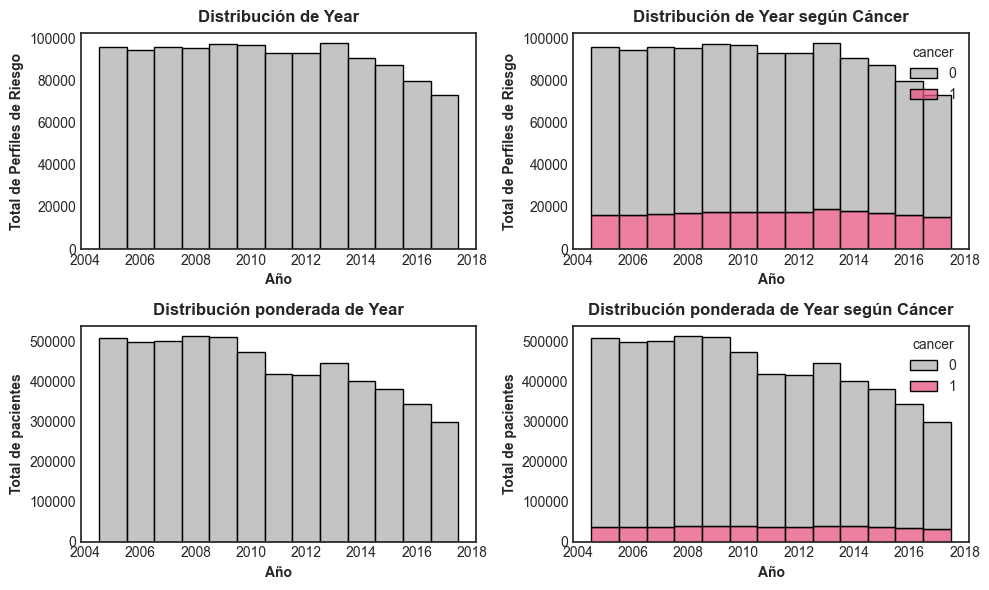

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

sns.histplot(data=data, x='year', discrete=True, ax=axes[0])
axes[0].set_title('Distribución de Year')
axes[0].set_ylabel('Total de Perfiles de Riesgo')
axes[0].set_xlabel('Año')

sns.histplot(data=data, x='year', discrete=True, hue=data['cancer'], multiple="stack", ax=axes[1])
axes[1].set_title('Distribución de Year según Cáncer')
axes[1].set_ylabel('Total de Perfiles de Riesgo')
axes[1].set_xlabel('Año')

sns.histplot(data=data, x='year', discrete=True, weights=data['count'], ax=axes[2])
axes[2].set_title('Distribución ponderada de Year')
axes[2].set_ylabel('Total de pacientes')
axes[2].set_xlabel('Año')

sns.histplot(data=data, x='year', discrete=True, weights=data['count'], hue=data['cancer'], multiple="stack", ax=axes[3])
axes[3].set_title('Distribución ponderada de Year según Cáncer')
axes[3].set_ylabel('Total de pacientes')
axes[3].set_xlabel('Año')

plt.tight_layout()
plt.show()


 "*year*" indica únicamente el año de observación y no aporta información sobre los factores de riesgo intrínsecos de cada mujer, por lo que se descarta.    

El periodo de observación se encuentran entre 2005 y 2017, barcando un periodo de 13 años. 

Los casos de riesgo están repartidos bastante uniformemente a lo largo del periodo. El máximo de perfiles diferentes (combinaciones de factores de riesgo distintas) que se registró fue en 2009 con 97368.

El número total de mujeres por año se mantiene estable en torno a 500.000 hasta 2009–2010, para luego mostrar una tendencia decreciente a partir de 2011, alcanzando el mínimo en 2017 con unas 300.000 pacientes.

La proporción de mujeres diagnosticadas de cáncer (target = 1) es relativamente constante a lo largo de los años, lo que sugiere que el año de referencia no influye de forma apreciable en la tasa de casos positivos dentro del dataset.

Dado que  "*year*" es únicamente un marcador temporal y no representa un factor de riesgo clínico, no se utilizará como variable predictiva en la modelización. Por estos motivos, el EDA se centra exclusivamente en las variables categóricas, que permiten explorar la distribución y las relaciones entre los factores de riesgo asociados al cáncer de mama.

In [40]:
data = data.drop(columns=['year'])
data.head()

age race first_degree  menarche  first_birth  birads hrt menopaus  bmi  \
1    8    2            0         1            0       2   1        2    4   
2    8    2            0         1            0       2   0        2    9   
3    8    2            0         1            0       2   0        2    9   
4    8    2            0         1            0       2   0        2    9   
5    8    2            0         1            0       2   0        2    9   

  bioph cancer  count  
1     0      0      1  
2     1      1      1  
3     1      0     13  
4     0      1      2  
5     0      0     65

### Count

In [41]:
# Al eliminar la variable "year" es probable que se generarar duplicados
# Es decir, hay ciertos perfiles que se repiten cada año 
# (sin tener en cuenta la agregación count)
data_nocount = data.drop("count", axis=1)
print(f'Número de filas inicial: {data_nocount.shape[0]}')
print(f'Duplicados en dataset inicial: {data_nocount.duplicated().sum()}')

Número de filas inicial: 1191438
Duplicados en dataset inicial: 885093


In [42]:
# "count" representa la frecuencia de cada combinación de factores de riesgo 
# número de mujeres con ese perfil según la combinación de variables
# Al quitar year, los registros de un mismo perfil en años distintos 
# ahora parecen duplicados, porque todas las demás columnas coinciden.
# Se reconstruye el dataset volviedo a agregar por perfil en count
data_agg = data.groupby([col for col in data.columns if col != "count"], dropna=False
                       ).agg({'count':'sum'}).reset_index()

print(f'Número de filas final:{data_agg.shape[0]}')
print(f'Duplicados en dataset final:{data_agg.duplicated().sum()}')
data_agg.head(10)

Número de filas final:306345
Duplicados en dataset final:0


age race first_degree  menarche  first_birth  birads hrt menopaus  bmi  \
0    1    1            0         0            0       1   0        1    4   
1    1    1            0         0            0       2   0        1    2   
2    1    1            0         0            0       2   0        1    9   
3    1    1            0         0            0       3   0        1    9   
4    1    1            0         0            0       4   0        1    1   
5    1    1            0         0            0       4   0        1    2   
6    1    1            0         0            0       4   0        1    9   
7    1    1            0         0            0       4   0        1    9   
8    1    1            0         0            0       4   1        2    1   
9    1    1            0         0            0       9   0        1    3   

  bioph cancer  count  
0     0      0      1  
1     0      0      1  
2     0      0      3  
3     0      0      1  
4     0      0      2  
5     0      0      1  
6     0      0      5  
7     1      0      1  
8     1      0      1  
9     0      0      1

In [43]:
# ¿Cuantos valores distintos hay de count?
print('\nCount:\n', data_agg['count'].value_counts())


Count:
 count
1       108893
2        45580
3        26607
4        18024
5        12828
         ...  
1070         1
1534         1
1801         1
3436         1
1064         1
Name: count, Length: 1396, dtype: int64


In [44]:
data_agg['count'].value_counts()[data_agg['count'].value_counts()>=1100]

count
1     108893
2      45580
3      26607
4      18024
5      12828
6       9619
7       7480
8       6098
9       5110
10      4409
11      3703
12      3319
13      2965
14      2568
15      2253
16      2201
17      1904
18      1744
19      1626
20      1433
21      1400
22      1196
23      1166
Name: count, dtype: int64

In [45]:
descriptivos_num = data_agg[['count']].describe().T
num = 'count'
descriptivos_num.loc[num, "Asimetria"] = data_agg[num].skew()
descriptivos_num.loc[num, "Kurtosis"] = data_agg[num].kurtosis()
descriptivos_num.loc[num, "Rango"] = data_agg[num].max() - data_agg[num].min()

descriptivos_num

count       mean        std  min  25%  50%  75%      max  Asimetria  \
count  306345.0  18.648292  124.00914  1.0  1.0  2.0  8.0  15973.0  42.865351   

          Kurtosis    Rango  
count  3509.852782  15972.0

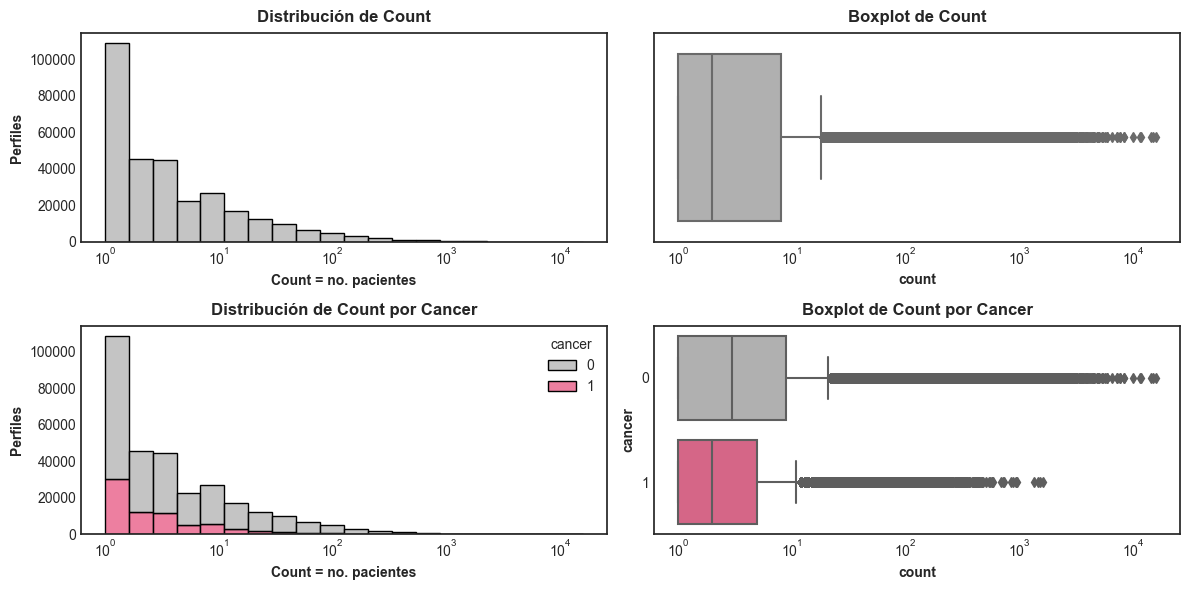

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6)) 

sns.histplot(data=data_agg, x='count', bins=20, log_scale=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribución de Count')
axes[0, 0].set_ylabel('Perfiles')
axes[0, 0].set_xlabel('Count = no. pacientes')

sns.boxplot(x=data_agg['count'],  ax=axes[0, 1])
axes[0, 1].set_title('Boxplot de Count')
axes[0, 1].set_xscale('log')

sns.histplot(data=data_agg, x='count', hue='cancer', bins=20, log_scale=True, 
             ax=axes[1, 0], multiple="stack")
axes[1, 0].set_title('Distribución de Count por Cancer')
axes[1, 0].set_ylabel('Perfiles')
axes[1, 0].set_xlabel('Count = no. pacientes')

sns.boxplot(y='cancer', x='count', data=data_agg, ax=axes[1, 1])
axes[1, 1].set_title('Boxplot de Count por Cancer')
axes[1, 1].set_xscale('log')

plt.tight_layout()
plt.show()

 "*count*" representa la frecuencia de cada combinación de factores de riesgo y no corresponde a un atributo individual. Es decir, indica cuántas pacientes hay en el dataset con un perfil idéntico de factores de riesgo (fila agregada)  
 - Cada fila agrupa entre 1 y 15973 mujeres con la misma combinación de factores.
 - Por lo general, al menos el 25% de los datos son combinaciones únicas (solo 1 mujer).
 - El percentil 75%, muestra agrupaciones de hasta 8 mujeres con la misma combinación de factores de riesgo.
 - La gran mayoría de perfiles corresponden a muy pocos pacientes (la mayoría de combinaciones aparece pocas veces)
 - Hay un pequeño número de combinaciones muy frecuentes. Estos valores grandes de count representan perfiles comunes (por ejemplo, pacientes con características muy frecuentes en la población).
 - En el histograma se observa que los perfiles poco frecuentes (valores bajos de count) son los más numerosos. Dentro de esta diversidad, algunas combinaciones presentan una mayor proporción de casos con cáncer, lo que subraya la importancia de identificar patrones asociados a mayor riesgo.
 - Interpretación: Ciertas combinaciones de edad, densidad mamaria, antecedentes familiares y otros factores de riesgo son muy prevalentes en la población, mientras que otras son raras, y en estas combinaciones raras se encuentran mayores casos de incidencia de cancer.
 
Dado que  "*count*"  refleja la frecuencia de un perfil y no una característica clínica, no se utiliza como variable predictiva. Aunque es muy útil como variable descriptiva para mostrar la prevalencia de ciertos perfiles en la población. Sin embargo, puede emplearse como peso en la modelización para que las combinaciones más frecuentes tengan mayor influencia en el ajuste del modelo.

In [47]:
col_num = ['count']
col_cat_ord = ['age', 'menarche', 'first_birth', 'birads', 'bmi']
col_cat_nom = ['race', 'first_degree', 'hrt', 'menopaus', 'bioph', 'cancer']

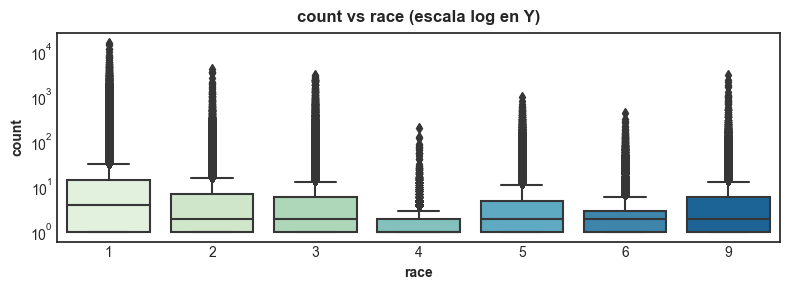

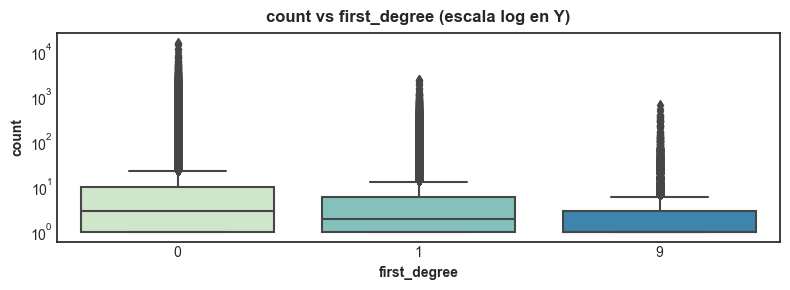

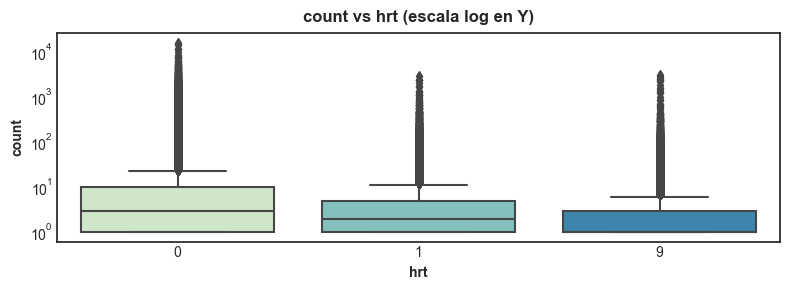

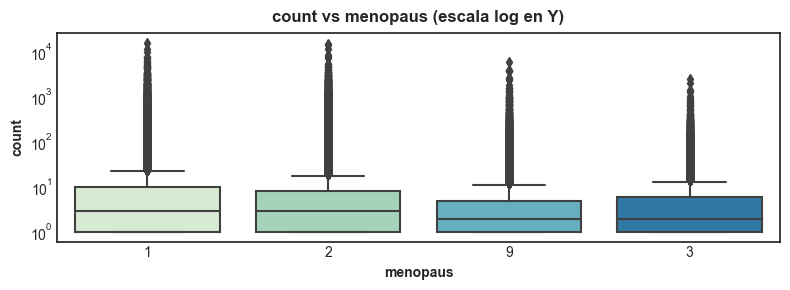

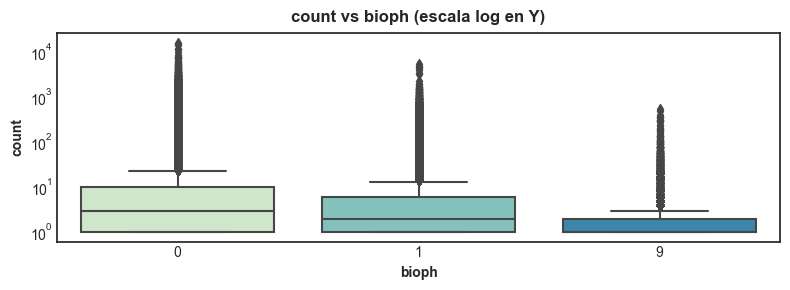

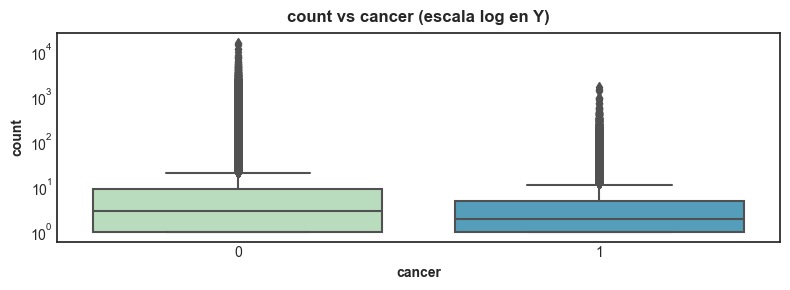

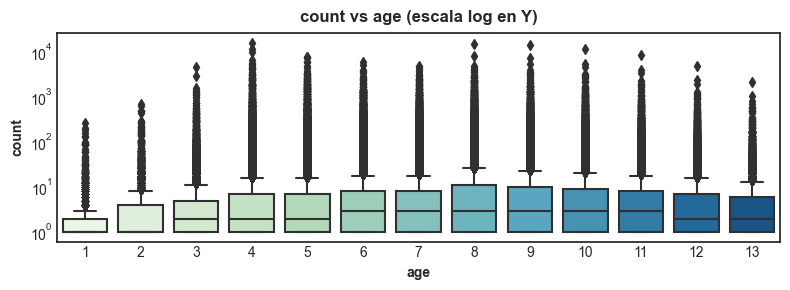

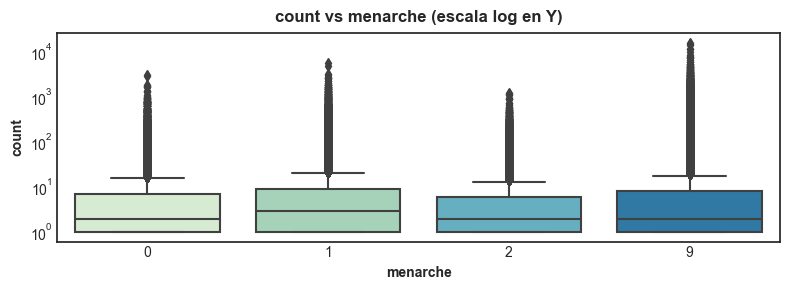

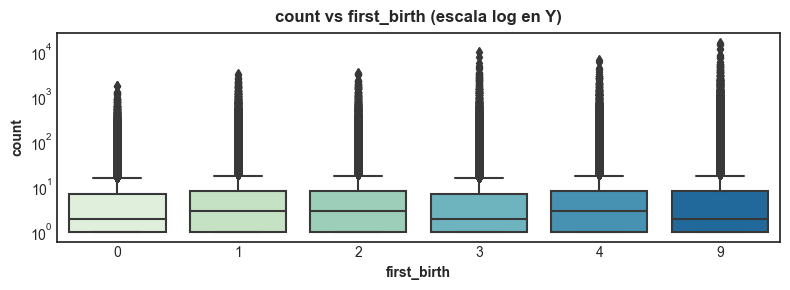

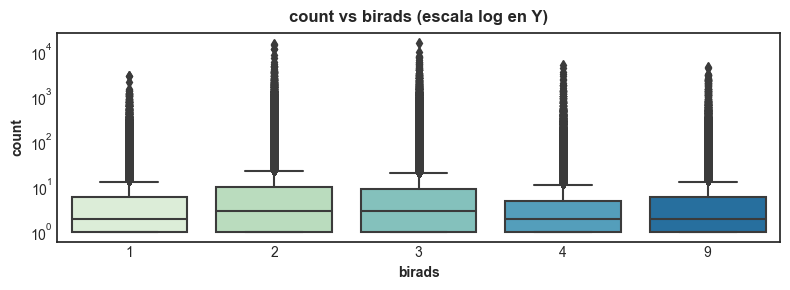

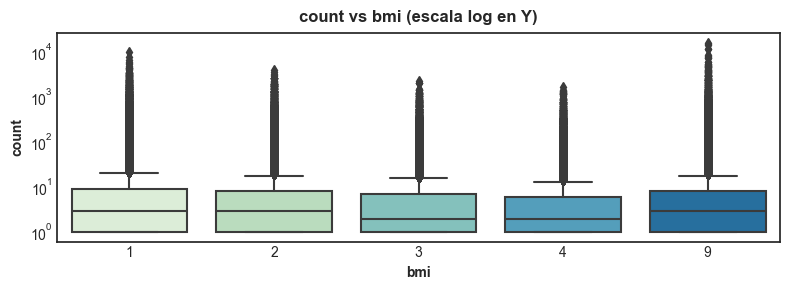

In [48]:
# ¿Cual es la proporción de pacientes en el resto de variables?

cat_list = col_cat_nom + col_cat_ord

for i in range(0, len(cat_list)):
    cat = cat_list[i]
    for j in range(0, len(col_num)):
        num = col_num[j]
        plt.figure (figsize = (8,3))
        sns.boxplot( x = cat, y = num, data = data_agg, palette = "GnBu" )
        plt.yscale("log")   
        plt.title(f"{num} vs {cat} (escala log en Y)")
        plt.show()

## EDA: Variables Categóricas Nominales

Para el análisis univariado de datos categóricos, el objetivo es entender la distribución de las categorías. Por lo que no es necesario ponderar por el número de pacientes. Solo interesa la proporción de perfiles por categoría.  
Para el análisis bivariante, el objetivo es entender la distribución de las categorías en función de las categorías de la variable target: "cancer"  
Medidas de asociación bivariante (aunque no funcionen muy bien con tamaños muestrales muy grandes, no hay que fiarse de los p-values. Las utilizo para ver hacia donde apuntan. las medidas de asociación miden dependencia entre dos variables (bivariante): en este caso, entre la variable objetivo y cada una de las explicativas. Para las categóricas son la chi cuadrado y tablas de contigencia.

In [49]:
# guardar datos agregados
with open("data_agg.pkl", "wb") as f:
    pickle.dump(data_agg, f)

In [50]:
data_agg[col_cat_nom].describe()

race first_degree     hrt menopaus   bioph  cancer
count   306345       306345  306345   306345  306345  306345
unique       7            3       3        4       3       2
top          1            0       0        2       0       0
freq    118979       190293  223069   175655  162744  234198

In [51]:
# Categorical Nomimal sin categoría 9 (Desconocidos)
data_agg[col_cat_nom].replace("9", np.nan).describe()

race first_degree     hrt menopaus   bioph  cancer
count   282989       288798  257154   271512  293467  306345
unique       6            2       2        3       2       2
top          1            0       0        2       0       0
freq    118979       190293  223069   175655  162744  234198

La mayoría de las variables son categóricas binarias, con excepción de "race" y "menopaus", que tienen múltiples categorías.   
La raza más representada es la blanca.    
Predominan mujeres Post-menopausicas.   
La no presencia de antecedentes familiares en primer grado, el no uso de terapia hormonal (hrt), sin biopsias son los perfiles más comunes.   
Hay más datos de perfiles sin cancer.

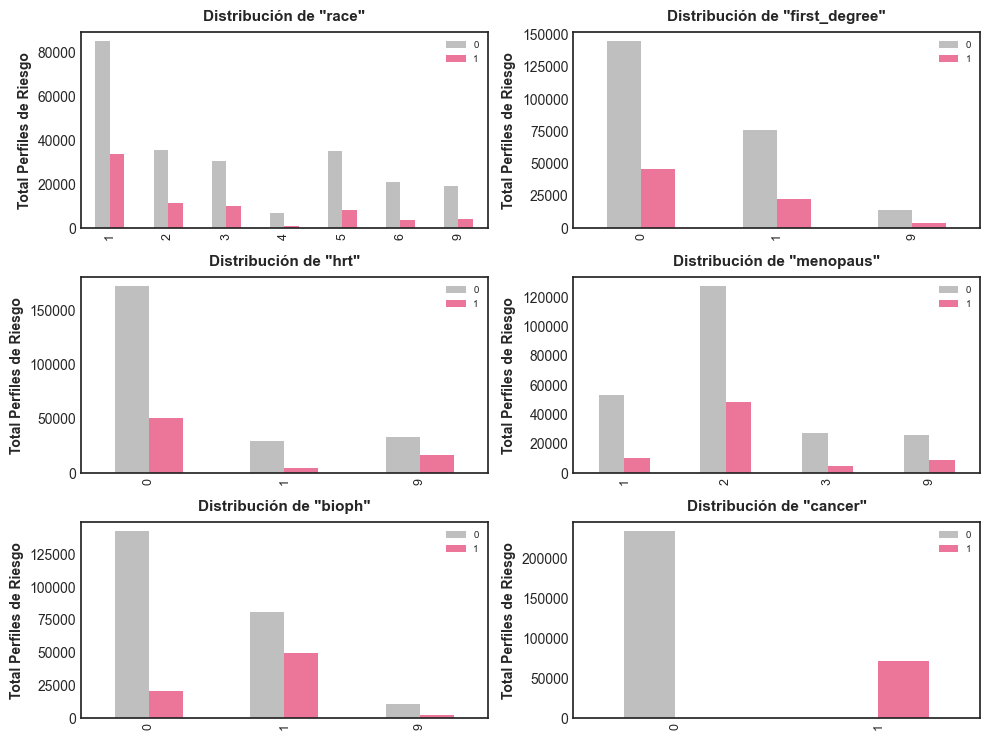

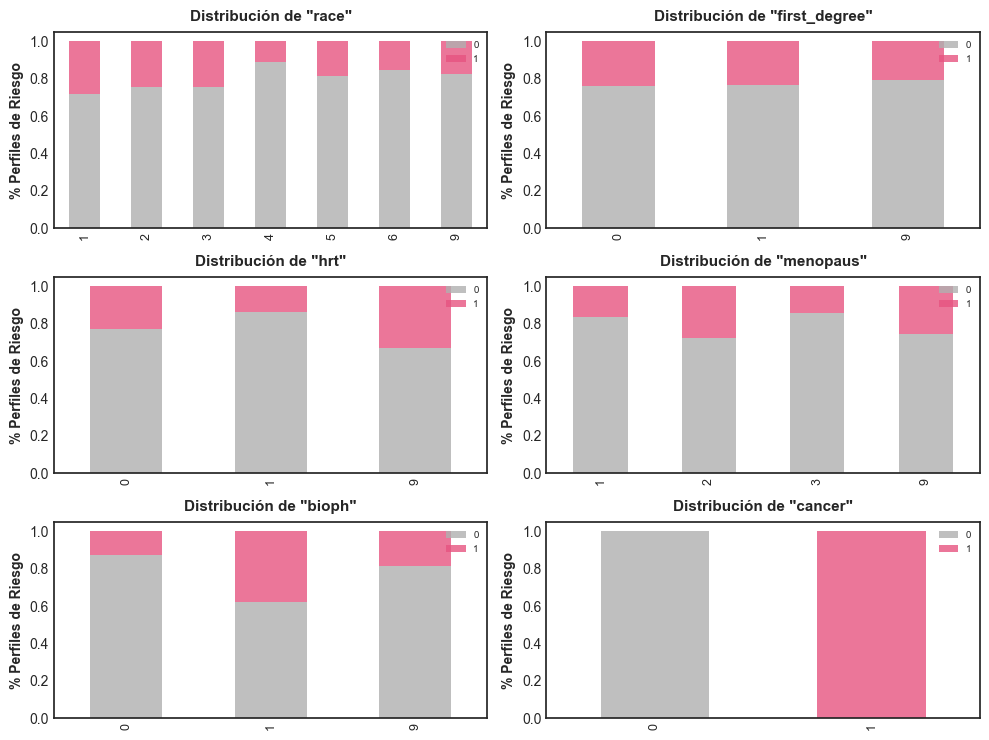

In [52]:
# Perfiles de Riesgo
# Visualizacion unidimensional categoricas 
# Para observar su discriminacion por target
plot_categorias(data_agg, col_cat_nom, 'cancer', False, False)
print("\n")
plot_categorias(data_agg, col_cat_nom, 'cancer', True, False)

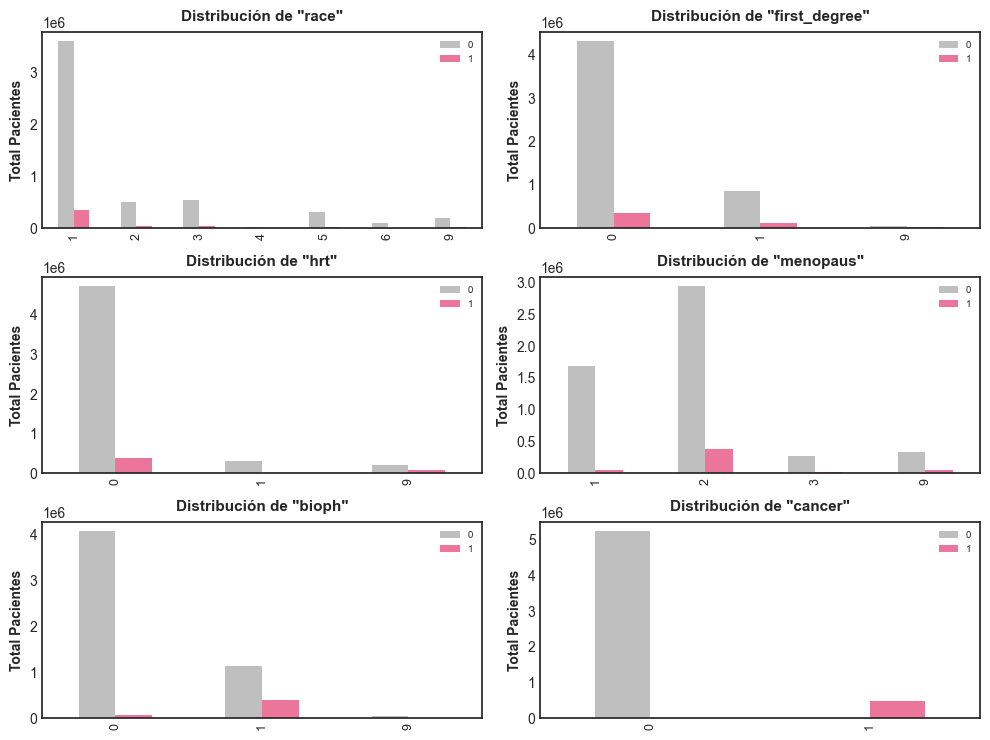

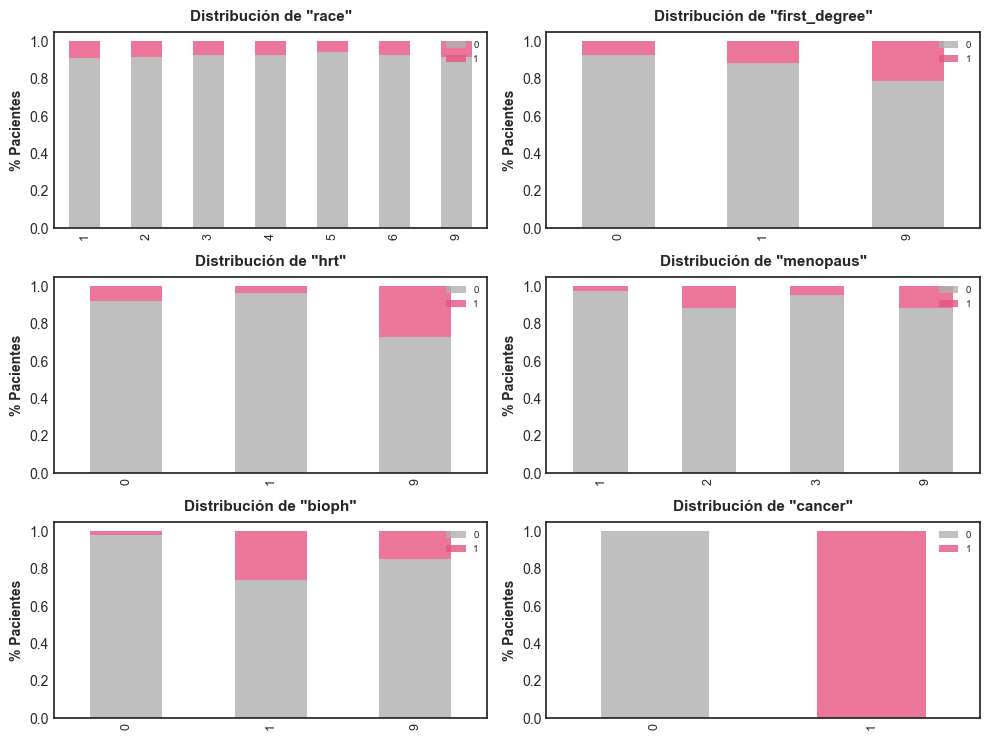

In [53]:
# Visualizaciones por pacientes
# Visualizacion unidimensional categoricas 
# Para observar su discriminacion por target
plot_categorias(data_agg, col_cat_nom, 'cancer', False, True)
print("\n")
plot_categorias(data_agg, col_cat_nom, 'cancer', True, True)

Trataremos de reducir el número de variables categóricas cuando existen demasiadas casuísiticas o cuando existen muy pocos registros en una categoría.  

Las categorías con baja representación puede causar muchos problemas en los modelos por falta de base muestral para la estimación de los parámetros correspondientes a la pertenencia a esa categoría. Por ello, es conveniente echar un vistazo y recodificar las vairables uniendo categorías muy poco representativas con otras cuya unión tenga algún sentido (tienen comportamiento similar frente a la objetivo, la variable tiene caracter ordinal por lo que la unión con mayor sentido sería hacia categorías adyacentes...).

Es imprescindible que todas los niveles de las variables cualitativas esten bien representados pues, de lo contrario, se podrían detectar patrones que no fueran extrapolables al estar basados en muy pocas observaciones. Por ello, se debe verificar que la frecuencia de todas ellas sea superior al 5 % (el porcentaje exacto depende del numero de observaciones del conjunto de datos).

In [54]:
analizar_categorias(data_agg, 'cancer')

Labels: ['0' '1'] 

cancer distribution:
         Count      %
cancer               
0       234198  76.45
1        72147  23.55 



### Race 	 	 	 		 	 	 	

In [55]:
analizar_categorias(data_agg, 'race')

# No parace haber errores de escritura en las etiquetas
# Y algunas categorias poco representadas (<5%): 4 = Native American

Labels: ['1' '2' '3' '4' '5' '6' '9'] 

race distribution:
       Count      %
race               
1     118979  38.84
2      46983  15.34
5      43482  14.19
3      40786  13.31
6      24984   8.16
9      23356   7.62
4       7775   2.54 



In [56]:
def categorizar_raza(race):
    if race in ('4', '6'):
        return 'Others'
    elif race == '1':
        return 'White'
    elif race == '2':
        return 'Black'
    elif race == '3':
        return 'AAPI'
    elif race == '5':
        return 'Hisp'
    else:
        return race

data_agg['race'] = data_agg['race'].apply(categorizar_raza)
analizar_categorias(data_agg, 'race')

Labels: ['White' 'Black' 'AAPI' 'Others' 'Hisp' '9'] 

race distribution:
         Count      %
race                 
White   118979  38.84
Black    46983  15.34
Hisp     43482  14.19
AAPI     40786  13.31
Others   32759  10.69
9        23356   7.62 



Valor de Chi-cuadrado: 4231.1755
Valor p: 0.0000
Sí hay relación significativa entre las variables (p ≤ 0.05).



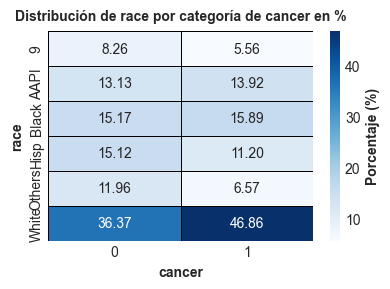

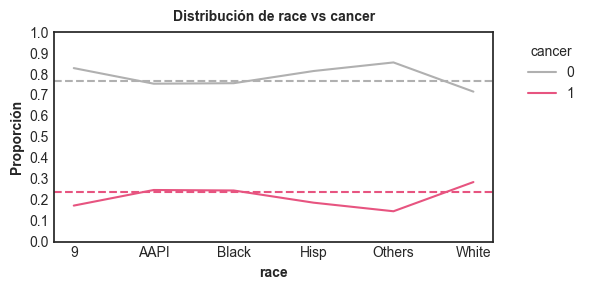


Residuals:
-------------
cancer      0      1
race                
9       23.87 -23.87
AAPI    -5.51   5.51
Black   -4.69   4.69
Hisp    26.40 -26.40
Others  40.96 -40.96
White  -50.56  50.56



In [57]:
# Tabla cruzada entre dos variables categóricas explicativa y objeto
analisis_bivariante(data_agg, 'race', 'cancer')

# Porcentajes respecto al total de cada fila (normalize=0), 
# habría que comparar con el porcentaje de eventos en el total de la muestra (23.55 %)
# categorias entorno a la media no nos dan información, pero sí al contrario

p es menor que el nivel de significancia, se puede rechazar la hipótesis nula   
hay suficiente evidencia para afirmar que hay una asociación significativa entre las variables raza y cancer

Categorias que puede ser discriminativas de target:   
"white" tiene una mayor proporción de observaciones asociadas con cancer   
"others"  mayor proporcion asociado con ausencia de cancer

Los valores desconocidos no son aleatorios respecto al target, y podrían aportar información predictiva.

### Menopaus

In [58]:
analizar_categorias(data_agg, 'menopaus')

# No parace haber errores de escritura en las etiquetas
# Categorias bien representadas

Labels: ['1' '2' '9' '3'] 

menopaus distribution:
           Count      %
menopaus               
2         175655  57.34
1          63553  20.75
9          34833  11.37
3          32304  10.54 



Valor de Chi-cuadrado: 4939.9298
Valor p: 0.0000
Sí hay relación significativa entre las variables (p ≤ 0.05).



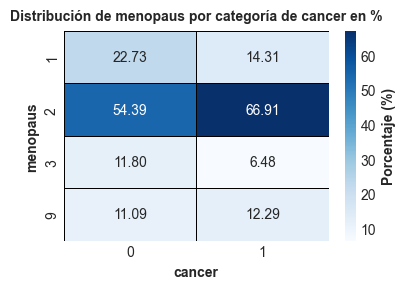

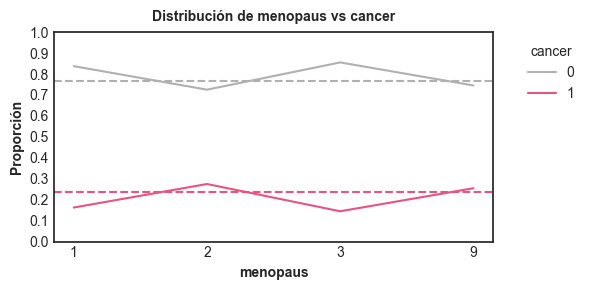


Residuals:
-------------
cancer        0      1
menopaus              
1         48.73 -48.73
2        -59.46  59.46
3         40.66 -40.66
9         -8.94   8.94



In [59]:
# Tabla cruzada entre dos variables categóricas explicativa y objeto
analisis_bivariante(data_agg, 'menopaus', 'cancer')

El cáncer es más frecuente en mujeres post-menopáusicas. Que en parte está relacionado con la edad.

Para menopaus = 9, los valores missing casi no están asociados con cancer.

### First_degree

In [60]:
analizar_categorias(data_agg, 'first_degree')

# No parace haber errores de escritura en las etiquetas
# Categorias bien representadas

Labels: ['0' '1' '9'] 

first_degree distribution:
               Count      %
first_degree               
0             190293  62.12
1              98505  32.15
9              17547   5.73 



Valor de Chi-cuadrado: 99.3240
Valor p: 0.0000
Sí hay relación significativa entre las variables (p ≤ 0.05).



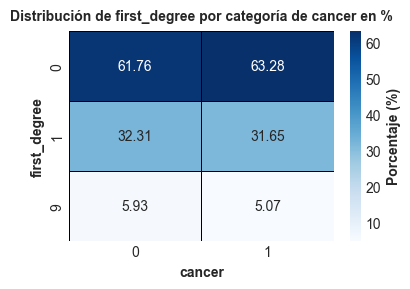

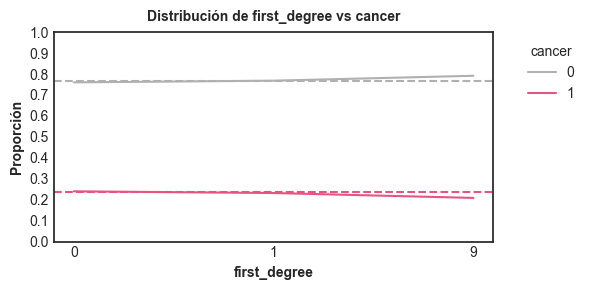


Residuals:
-------------
cancer           0     1
first_degree            
0            -7.37  7.37
1             3.33 -3.33
9             8.69 -8.69



In [61]:
# Tabla cruzada entre dos variables categóricas explicativa y objeto
analisis_bivariante(data_agg, 'first_degree', 'cancer')

p es menor que el nivel de significancia, se puede rechazar la hipótesis nula, 
hay suficiente evidencia para afirmar que hay una asociación significativa entre las variables first_degree y cancer

No Tener un familiar de primer grado con cáncer está asociado a una menor probabilidad de presentar cáncer
No parece ser una variable muy discriminativa

Los missing (categoría 9) no muestran un patrón claro respecto al target. No depende de cancer.

### Hrt

In [62]:
analizar_categorias(data_agg, 'hrt')

# No parace haber errores de escritura en las etiquetas
# Categorias bien representadas

Labels: ['0' '1' '9'] 

hrt distribution:
      Count      %
hrt               
0    223069  72.82
9     49191  16.06
1     34085  11.13 



Valor de Chi-cuadrado: 4409.4007
Valor p: 0.0000
Sí hay relación significativa entre las variables (p ≤ 0.05).



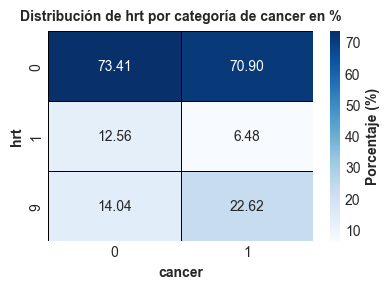

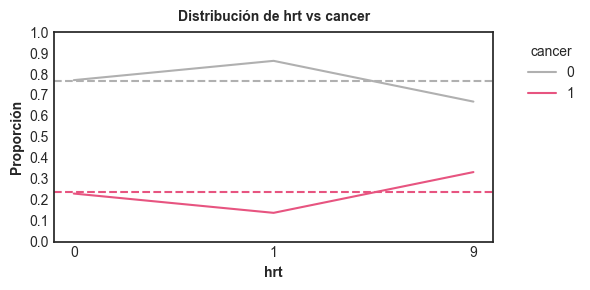


Residuals:
-------------
cancer      0      1
hrt                 
0       13.24 -13.24
1       45.38 -45.38
9      -54.92  54.92



In [63]:
# Tabla cruzada entre dos variables categóricas explicativa y objeto
analisis_bivariante(data_agg, 'hrt', 'cancer')

El consumo de HRT (hrt = 1) se asocia con menos presencia de cáncer de lo esperado, según los datos.

Los missing (categoria 9) de hrt no son aleatorios respecto a cancer, está relacionado con la variable objetivo-

### Bioph

In [64]:
analizar_categorias(data_agg, 'bioph')

# No parace haber errores de escritura en las etiquetas
# Categorias bien representadas

Labels: ['0' '1' '9'] 

bioph distribution:
        Count      %
bioph               
0      162744  53.12
1      130723  42.67
9       12878   4.20 



Valor de Chi-cuadrado: 25922.7511
Valor p: 0.0000
Sí hay relación significativa entre las variables (p ≤ 0.05).



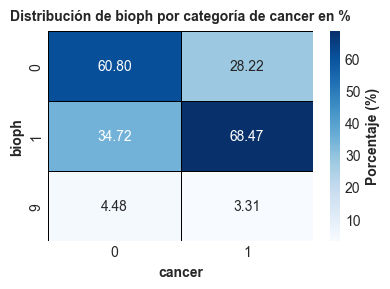

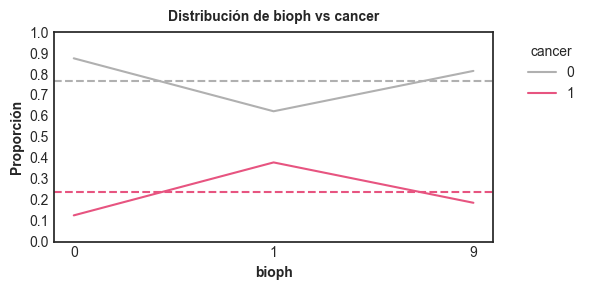


Residuals:
-------------
cancer       0       1
bioph                 
0       153.31 -153.31
1      -160.26  160.26
9        13.75  -13.75



In [65]:
# Tabla cruzada entre dos variables categóricas explicativa y objeto
analisis_bivariante(data_agg, 'bioph', 'cancer')

Como era de esperar, quienes tienen historial previo de biopsia presentan mas casos de cancer

Los missing en bioph tienen asociación débil con cancer.

## EDA: Variables Categóricas Ordinales

Para el análisis univariado de variables ordinales, se adopta un enfoque doble. 

Primero, las variables se tratan como numéricas para calcular estadísticas descriptivas como media, mediana, mínimo, máximo y desviación estándar, etc. para entender la tendencia central de la variable ordinal. Además, se analiza su correlación utilizando la distribución de Spearman, dado que se trata de variables categóricas ordinales.

Posteriormente, las mismas variables se convertiran a categóricas para examinar la distribución de cada categoría y aplicar un test estadístico de chi-cuadrado.

In [66]:
# Categorical Ordinal con label 9 ('unknown')
data_agg[col_cat_ord].describe()

age       menarche    first_birth         birads  \
count  306345.000000  306345.000000  306345.000000  306345.000000   
mean        7.160368       4.491971       3.451834       3.439338   
std         2.684390       4.027745       3.100222       2.503615   
min         1.000000       0.000000       0.000000       1.000000   
25%         5.000000       1.000000       1.000000       2.000000   
50%         7.000000       2.000000       3.000000       3.000000   
75%         9.000000       9.000000       4.000000       4.000000   
max        13.000000       9.000000       9.000000       9.000000   

                 bmi  
count  306345.000000  
mean        4.085263  
std         3.133181  
min         1.000000  
25%         2.000000  
50%         3.000000  
75%         9.000000  
max         9.000000

In [67]:
# Categorical Ordinal sin label 9 (unknown)
to_nan = ['menarche', 'first_birth', 'birads', 'bmi']
temp = data_agg[col_cat_ord].copy()
temp[to_nan] = temp[to_nan].mask(temp[to_nan] == 9, np.nan)

temp.describe()

age       menarche    first_birth         birads  \
count  306345.000000  171922.000000  243561.000000  260008.000000   
mean        7.160368       0.967218       2.021654       2.448352   
std         2.684390       0.770292       1.452112       0.944739   
min         1.000000       0.000000       0.000000       1.000000   
25%         5.000000       0.000000       1.000000       2.000000   
50%         7.000000       1.000000       2.000000       2.000000   
75%         9.000000       2.000000       3.000000       3.000000   
max        13.000000       2.000000       4.000000       4.000000   

                 bmi  
count  223527.000000  
mean        2.264326  
std         1.090290  
min         1.000000  
25%         1.000000  
50%         2.000000  
75%         3.000000  
max         4.000000

In [68]:
descriptivos_ord = temp.describe().T

for ord in col_cat_ord:
    descriptivos_ord.loc[ord, "Asimetria"] = data[ord].skew()
    descriptivos_ord.loc[ord, "Kurtosis"] = data[ord].kurtosis()
    descriptivos_ord.loc[ord, "Rango"] = data[ord].max() - data[ord].min()

descriptivos_ord

count      mean       std  min  25%  50%  75%   max  \
age          306345.0  7.160368  2.684390  1.0  5.0  7.0  9.0  13.0   
menarche     171922.0  0.967218  0.770292  0.0  0.0  1.0  2.0   2.0   
first_birth  243561.0  2.021654  1.452112  0.0  1.0  2.0  3.0   4.0   
birads       260008.0  2.448352  0.944739  1.0  2.0  2.0  3.0   4.0   
bmi          223527.0  2.264326  1.090290  1.0  1.0  2.0  3.0   4.0   

             Asimetria  Kurtosis  Rango  
age           0.293607 -0.482994   12.0  
menarche      0.167581 -1.899166    9.0  
first_birth   0.887623 -0.481229    9.0  
birads        1.740614  1.948514    8.0  
bmi           0.815245 -1.009936    8.0

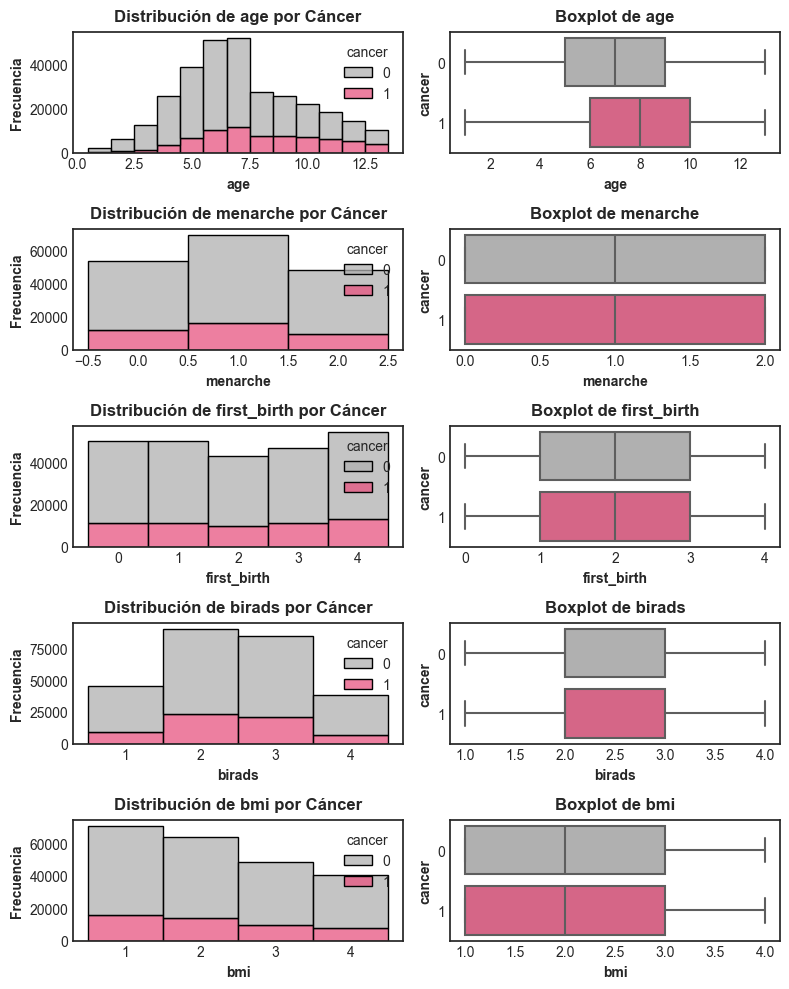

In [69]:
fig, axes = plt.subplots(len(col_cat_ord), 2, figsize=(8, 10)) 

for i, col in enumerate(col_cat_ord):
    # Histograma de la variable categórica ordinal
    sns.histplot(data=temp, x=col, discrete=True, hue=data_agg["cancer"], multiple="stack", ax=axes[i, 0])
    axes[i, 0].set_title(f"Distribución de {col} por Cáncer")
    axes[i, 0].set_ylabel("Frecuencia")
    
    sns.boxplot(x=col, y=data_agg['cancer'], data=temp, ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()

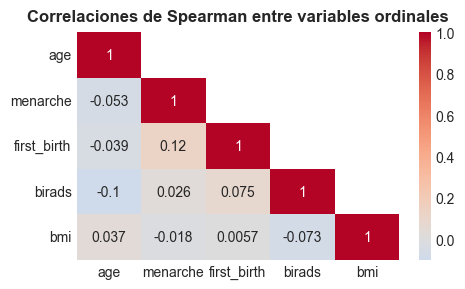

In [70]:
corr_spearman = data_agg[col_cat_ord].corr(method="spearman")

plt.figure(figsize=(5, 3))
mask = np.triu(np.ones_like(corr_spearman, dtype=bool), k=1)
sns.heatmap(corr_spearman, mask=mask, annot=True, cmap="coolwarm", center=0)
plt.title("Correlaciones de Spearman entre variables ordinales")
plt.show()

Las variables ordinales no están correlacionadas.   
Sin tener en cuenta los valores de la categoría "unknown":  
"Age" presenta una media Age 55-59, una distribución relativamente simétrica y homogénea a lo largo de sus categorías. Se observa que para valores de edad altos aumenta el riesgo de cancer.      
Las variables "menarche" y "first_birth" muestran concentraciones en los valores más bajos, con medianas de 1 (Age 12-13) y 2 (Age 25-29) respectivamente. Por su parte, "birads" y "bmi" se distribuyen principalmente en las categorías intermedias, con medianas de 2 (Scattered fibroglandular densities) y 2 (25-29.99) respectivamente.

In [71]:
# Vision categoricas
data_agg[col_cat_ord] = data_agg[col_cat_ord].astype('str')
data_agg.dtypes

age             object
race            object
first_degree    object
menarche        object
first_birth     object
birads          object
hrt             object
menopaus        object
bmi             object
bioph           object
cancer          object
count            int64
dtype: object

In [72]:
# Categorical Ordinal con categoría 9 (Desconocidos)
data_agg[col_cat_ord].describe()

age menarche first_birth  birads     bmi
count   306345   306345      306345  306345  306345
unique      13        4           6       5       5
top          7        9           9       2       9
freq     51929   134423       62784   90691   82818

In [73]:
# Categorical Ordinal sin categoría 9 (Desconocidos)
temp.astype('object').describe()

age  menarche  first_birth    birads       bmi
count   306345  171922.0     243561.0  260008.0  223527.0
unique      13       3.0          5.0       4.0       4.0
top          7       1.0          4.0       2.0       1.0
freq     51929   69728.0      54333.0   90691.0   70526.0

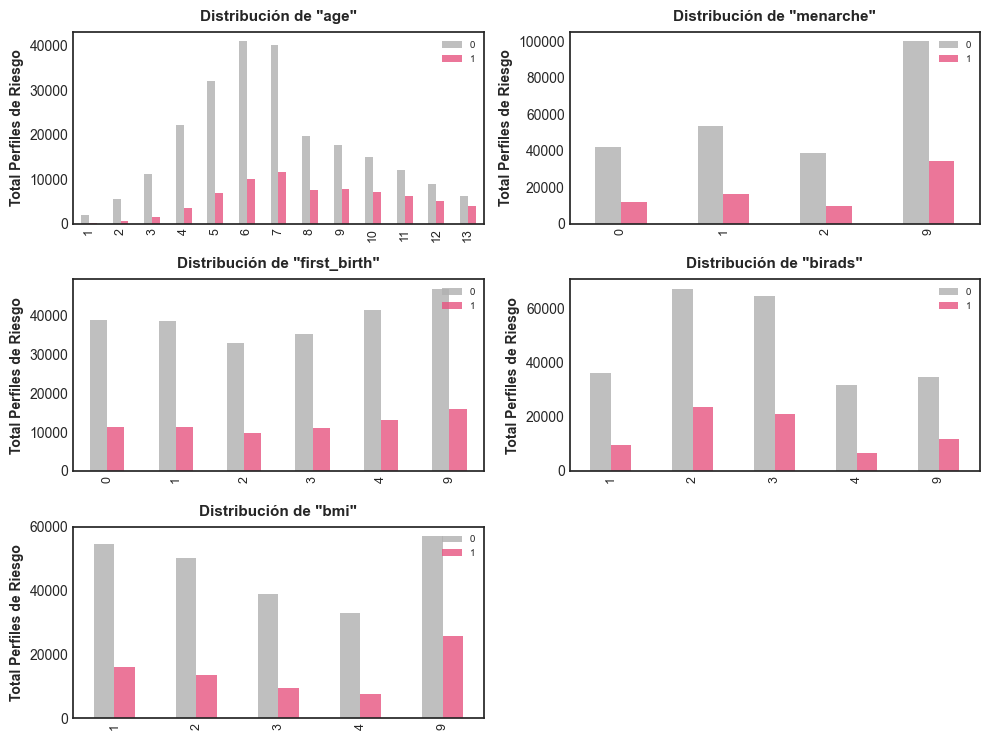

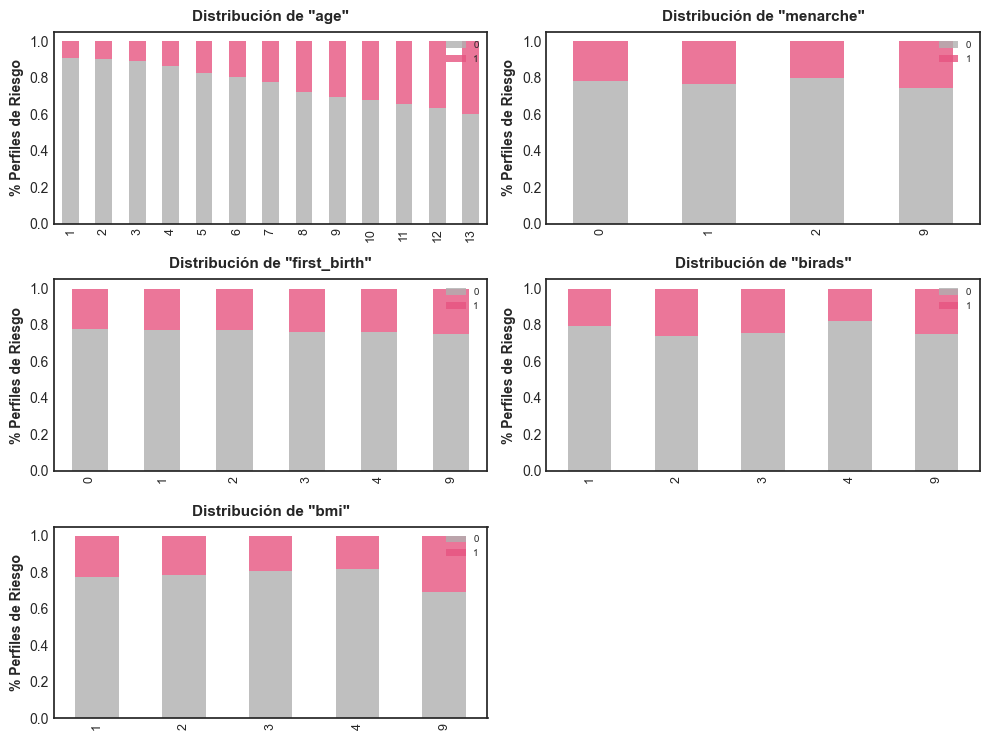

In [74]:
# Perfiles de Riesgo
# Visualizacion unidimensional categoricas 
# Para observar su discriminacion por target
data_agg_temp = data_agg.copy()
data_agg_temp['age'] = data_agg_temp['age'].astype('Int64')

plot_categorias(data_agg_temp, col_cat_ord, 'cancer', False, False)
print("\n")
plot_categorias(data_agg_temp, col_cat_ord, 'cancer', True, False)

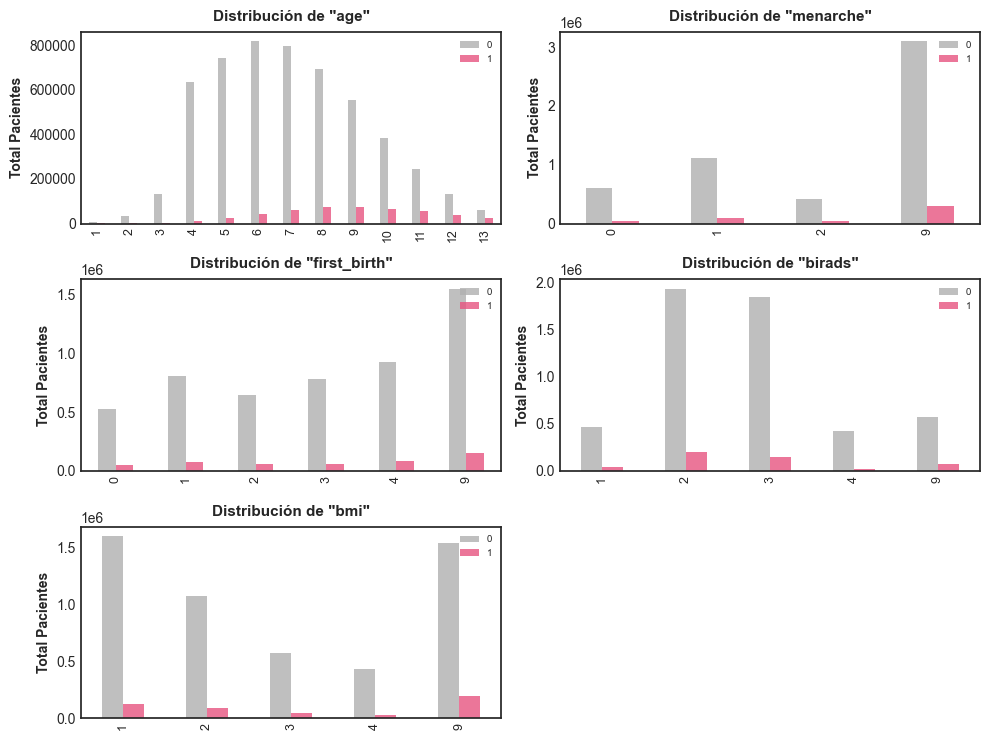

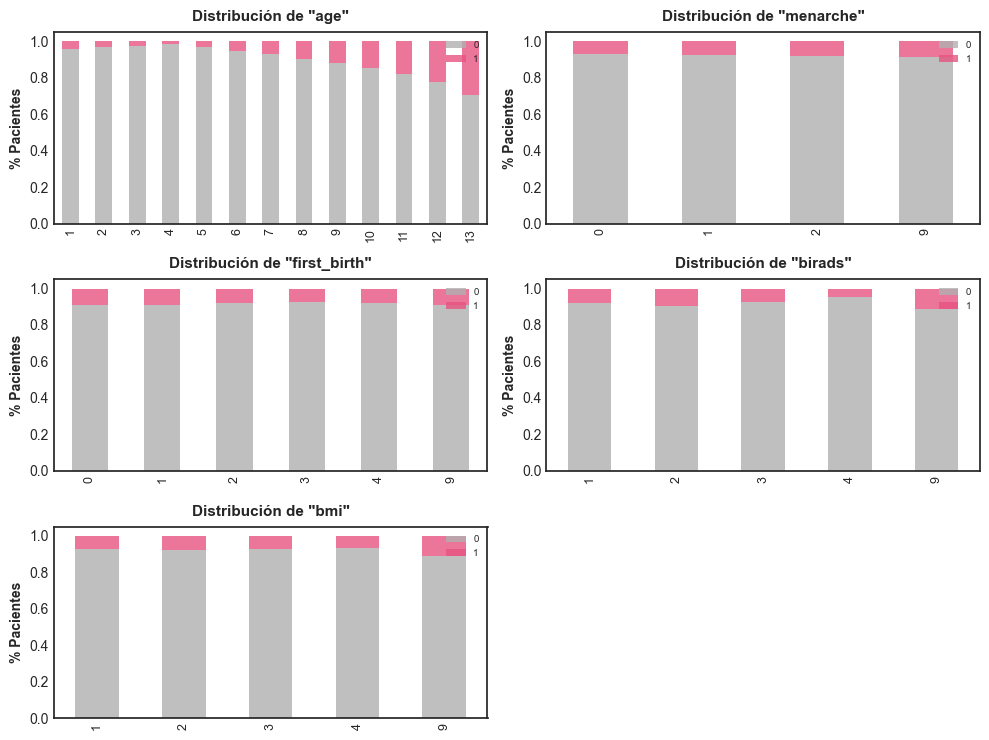

In [75]:
# Total de pacientes
# Visualizacion unidimensional categoricas 
# Para observar su discriminacion por target
plot_categorias(data_agg_temp, col_cat_ord, 'cancer', False, True)
print("\n")
plot_categorias(data_agg_temp, col_cat_ord, 'cancer', True, True)

### Age

In [76]:
analizar_categorias(data_agg, 'age')

# No parace haber errores de escritura en las etiquetas
# Hay demasiadas categorías
# Y algunas poco representadas (<5%)

Labels: ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13'] 

age distribution:
     Count      %
age              
7    51929  16.95
6    51186  16.71
5    38884  12.69
8    27374   8.94
4    25707   8.39
9    25482   8.32
10   22172   7.24
11   18280   5.97
12   14170   4.63
3    12598   4.11
13   10163   3.32
2     6193   2.02
1     2207   0.72 



In [77]:
# Recategorizar manteniendo el orden de grupos de edad
# según lo observado en el histograma

def categorizar_edad(age):
    if age in ('1', '2', '3'):
        return '18-39'
    elif age == '4':
        return '40-44'
    elif age == '5':
        return '45-49'
    elif age=='6':
            return '50-54'
    elif age=='7':
            return '55-59'
    elif age=='8':
            return '60-64'
    elif age=='9':
            return '65-69'
    elif age == '10':
            return '70-74'
    elif age in ('11', '12', '13'):
            return '>=75'
        
data_agg['age'] = data_agg['age'].apply(categorizar_edad)
analizar_categorias(data_agg, 'age')

Labels: ['18-39' '40-44' '45-49' '50-54' '55-59' '60-64' '65-69' '70-74' '>=75'] 

age distribution:
       Count      %
age                
55-59  51929  16.95
50-54  51186  16.71
>=75   42613  13.91
45-49  38884  12.69
60-64  27374   8.94
40-44  25707   8.39
65-69  25482   8.32
70-74  22172   7.24
18-39  20998   6.85 



Valor de Chi-cuadrado: 10354.0920
Valor p: 0.0000
Sí hay relación significativa entre las variables (p ≤ 0.05).



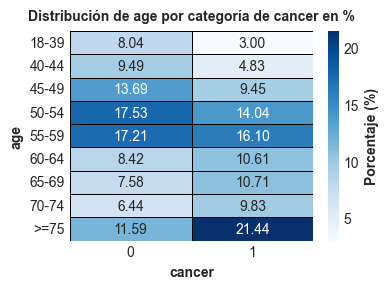

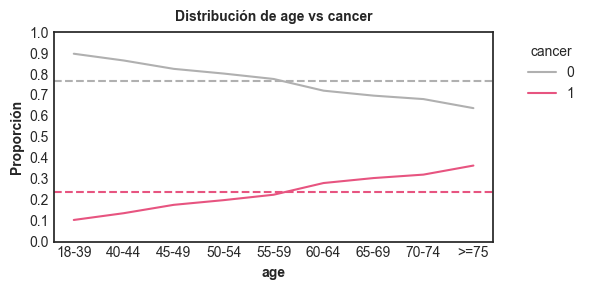


Residuals:
-------------
cancer      0      1
age                 
18-39   46.82 -46.82
40-44   39.47 -39.47
45-49   29.90 -29.90
50-54   22.01 -22.01
55-59    6.97  -6.97
60-64  -17.99  17.99
65-69  -26.61  26.61
70-74  -30.69  30.69
>=75   -66.82  66.82



In [78]:
# Tabla cruzada entre dos variables categóricas explicativa y objeto
analisis_bivariante(data_agg, 'age', 'cancer')

p es menor que el nivel de significancia, se puede rechazar la hipótesis nula, hay suficiente evidencia para afirmar que hay una asociación significativa entre las variables edad y cancer

Categorias que puede ser discriminativas de target:  
A medida que aumenta la edad, el porcentaje de personas con cáncer crece de forma gradual   
La proporción de casos con cancer aumenta significativamente a partir de los 60-64 años    
Esto sugiere una tendencia creciente del riesgo con la edad  

### Menarche

In [79]:
analizar_categorias(data_agg, 'menarche')

# No parace haber errores de escritura en las etiquetas
# Categorias bien representadas

Labels: ['0' '1' '2' '9'] 

menarche distribution:
           Count      %
menarche               
9         134423  43.88
1          69728  22.76
0          53915  17.60
2          48279  15.76 



Valor de Chi-cuadrado: 715.5030
Valor p: 0.0000
Sí hay relación significativa entre las variables (p ≤ 0.05).



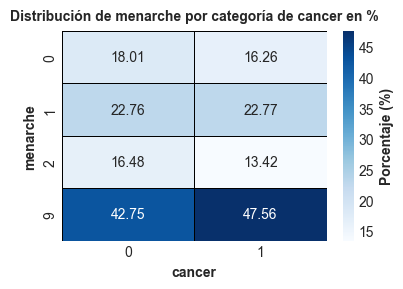

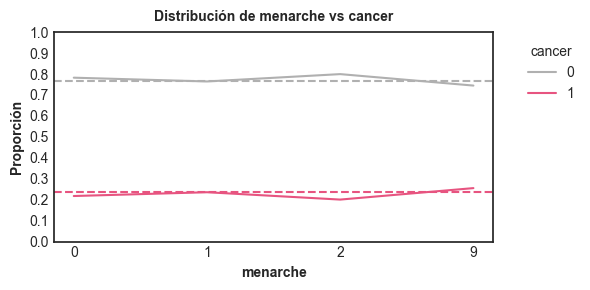


Residuals:
-------------
cancer        0      1
menarche              
0         10.83 -10.83
1         -0.06   0.06
2         19.74 -19.74
9        -22.76  22.76



In [80]:
# Tabla cruzada entre dos variables categóricas explicativa y objeto
analisis_bivariante(data_agg, 'menarche', 'cancer')

Pordía ser una categoria discriminativa la 0 (Age >=14) y la 2 (Age <12), pero de forma muy sutil, con una disminución de los casos de cancer.   
Los missing (categoria 9) son aleatorios, no están relacionados con la variable target.

### First_birth

In [81]:
analizar_categorias(data_agg, 'first_birth')

# No parace haber errores de escritura en las etiquetas
# Categorias bien representadas

Labels: ['0' '1' '2' '4' '9' '3'] 

first_birth distribution:
             Count      %
first_birth              
9            62784  20.49
4            54333  17.74
0            49986  16.32
1            49918  16.29
3            46498  15.18
2            42826  13.98 



Valor de Chi-cuadrado: 184.8053
Valor p: 0.0000
Sí hay relación significativa entre las variables (p ≤ 0.05).



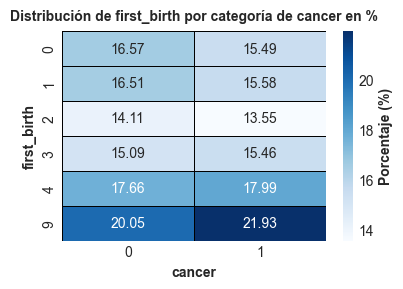

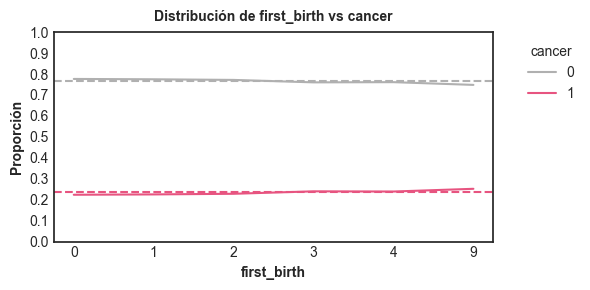


Residuals:
-------------
cancer           0      1
first_birth              
0             6.88  -6.88
1             5.93  -5.93
2             3.84  -3.84
3            -2.42   2.42
4            -2.07   2.07
9           -10.90  10.90



In [82]:
# Tabla cruzada entre dos variables categóricas explicativa y objeto
analisis_bivariante(data_agg, 'first_birth', 'cancer')

No parece haber una categoría discriminativa clara.
Los missing (categoria 9) son aleatorios, no están relacionados con la variable target.

### Birads 

In [83]:
analizar_categorias(data_agg, 'birads')

# No parace haber errores de escritura en las etiquetas
# Categorias bien representadas

Labels: ['1' '2' '3' '4' '9'] 

birads distribution:
        Count      %
birads              
2       90691  29.60
3       85439  27.89
9       46337  15.13
1       45540  14.87
4       38338  12.51 



Valor de Chi-cuadrado: 1360.6516
Valor p: 0.0000
Sí hay relación significativa entre las variables (p ≤ 0.05).



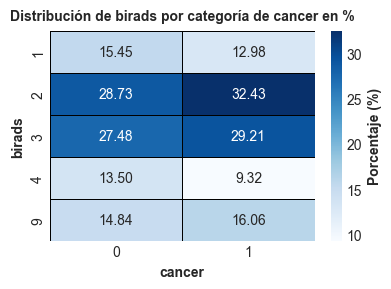

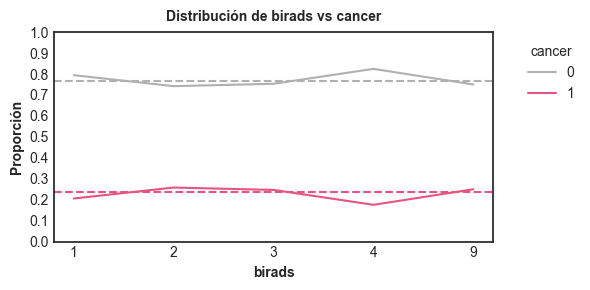


Residuals:
-------------
cancer      0      1
birads              
1       16.25 -16.25
2      -19.01  19.01
3       -9.02   9.02
4       29.64 -29.64
9       -7.99   7.99



In [84]:
# Tabla cruzada entre dos variables categóricas explicativa y objeto
analisis_bivariante(data_agg, 'birads', 'cancer')

Pordía ser una categoria discriminativa:   
Extremadanmente denso (4) con ausencia de cancer   
El resto de categorias están bastante equilibradas
Los missing (categoria 9) son aleatorios, no están relacionados con la variable target.

### BMI

In [85]:
analizar_categorias(data_agg, 'bmi')

# No parace haber errores de escritura en las etiquetas
# Categorias bien representadas

Labels: ['4' '2' '9' '1' '3'] 

bmi distribution:
     Count      %
bmi              
9    82818  27.03
1    70526  23.02
2    63988  20.89
3    48416  15.80
4    40597  13.25 



Valor de Chi-cuadrado: 3734.8987
Valor p: 0.0000
Sí hay relación significativa entre las variables (p ≤ 0.05).



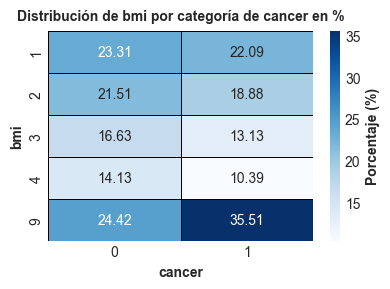

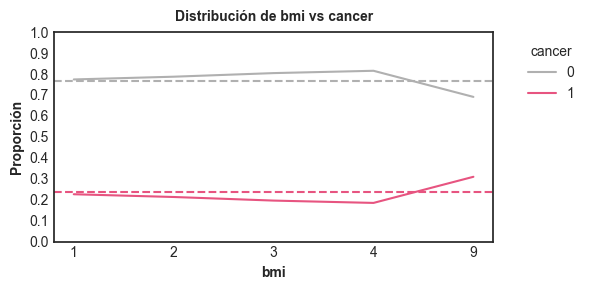


Residuals:
-------------
cancer      0      1
bmi                 
1        6.78  -6.78
2       15.18 -15.18
3       22.50 -22.50
4       25.96 -25.96
9      -58.61  58.61



In [86]:
# Tabla cruzada entre dos variables categóricas explicativa y objeto
analisis_bivariante(data_agg, 'bmi', 'cancer')

La categoria desconocido tiene una mayor incidencia de cancer.
El resto de categorías no parece contribuir a la diferenciación entre tener o no cáncer.

## EDA: Variable Objetivo Cancer

In [87]:
analizar_categorias(data_agg, 'cancer')
# Es un data set desbalanceado

Labels: ['0' '1'] 

cancer distribution:
         Count      %
cancer               
0       234198  76.45
1        72147  23.55 



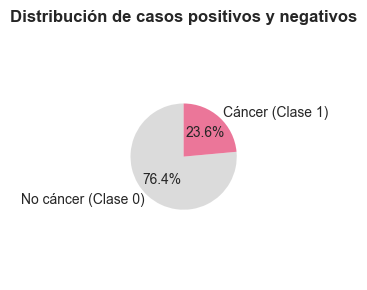

In [88]:
counter = Counter(data_agg['cancer'].astype(int))
labels = ['No cáncer (Clase 0)', 'Cáncer (Clase 1)']
sizes = [counter.get(0,0), counter.get(1,0)]

# Crear pie chart
plt.figure(figsize=(3,3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=["#D3D3D3CC", "#E75480CC"])
plt.title('Distribución de casos positivos y negativos')
plt.axis('equal') 
plt.show()

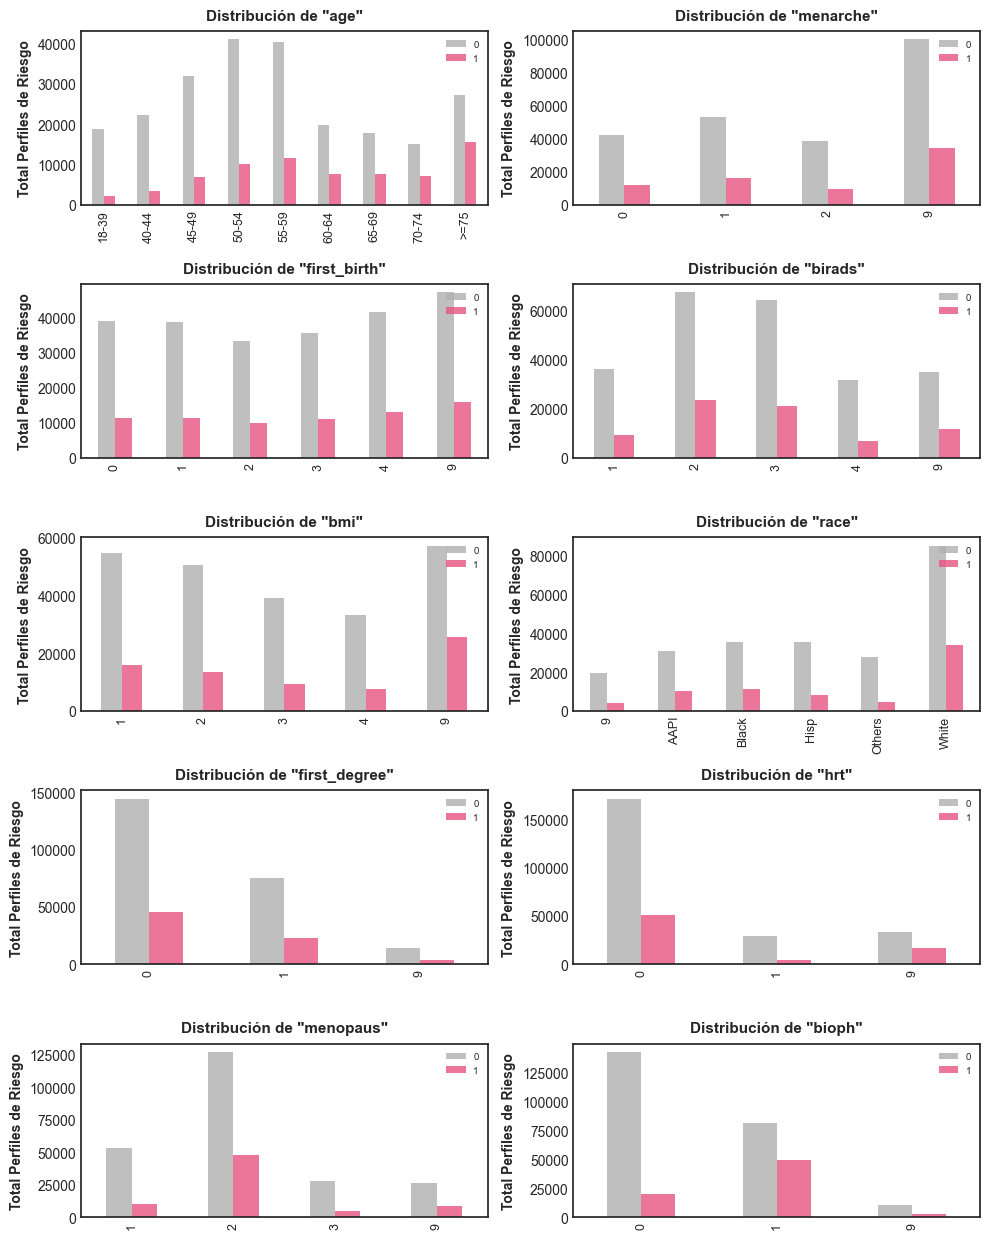

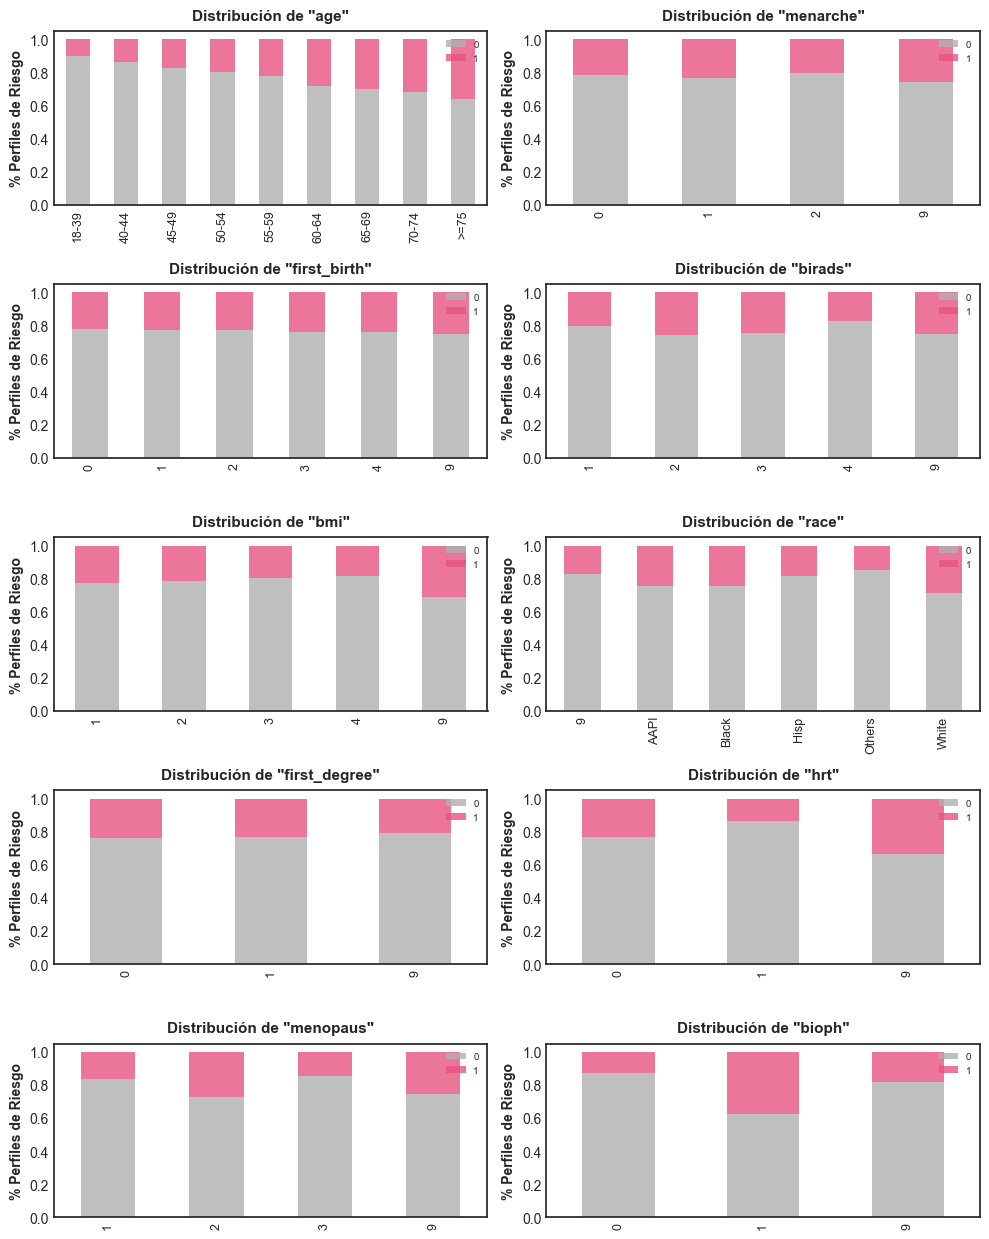

In [89]:
# ¿Cómo queda finalmente la dependencia de las variables con la variable objetivo?

col_categoricas = col_cat_ord + ['race', 'first_degree', 'hrt', 'menopaus', 'bioph']

plot_categorias(data_agg, col_categoricas, 'cancer', False, False)
print("\n")
plot_categorias(data_agg, col_categoricas, 'cancer', True, False)

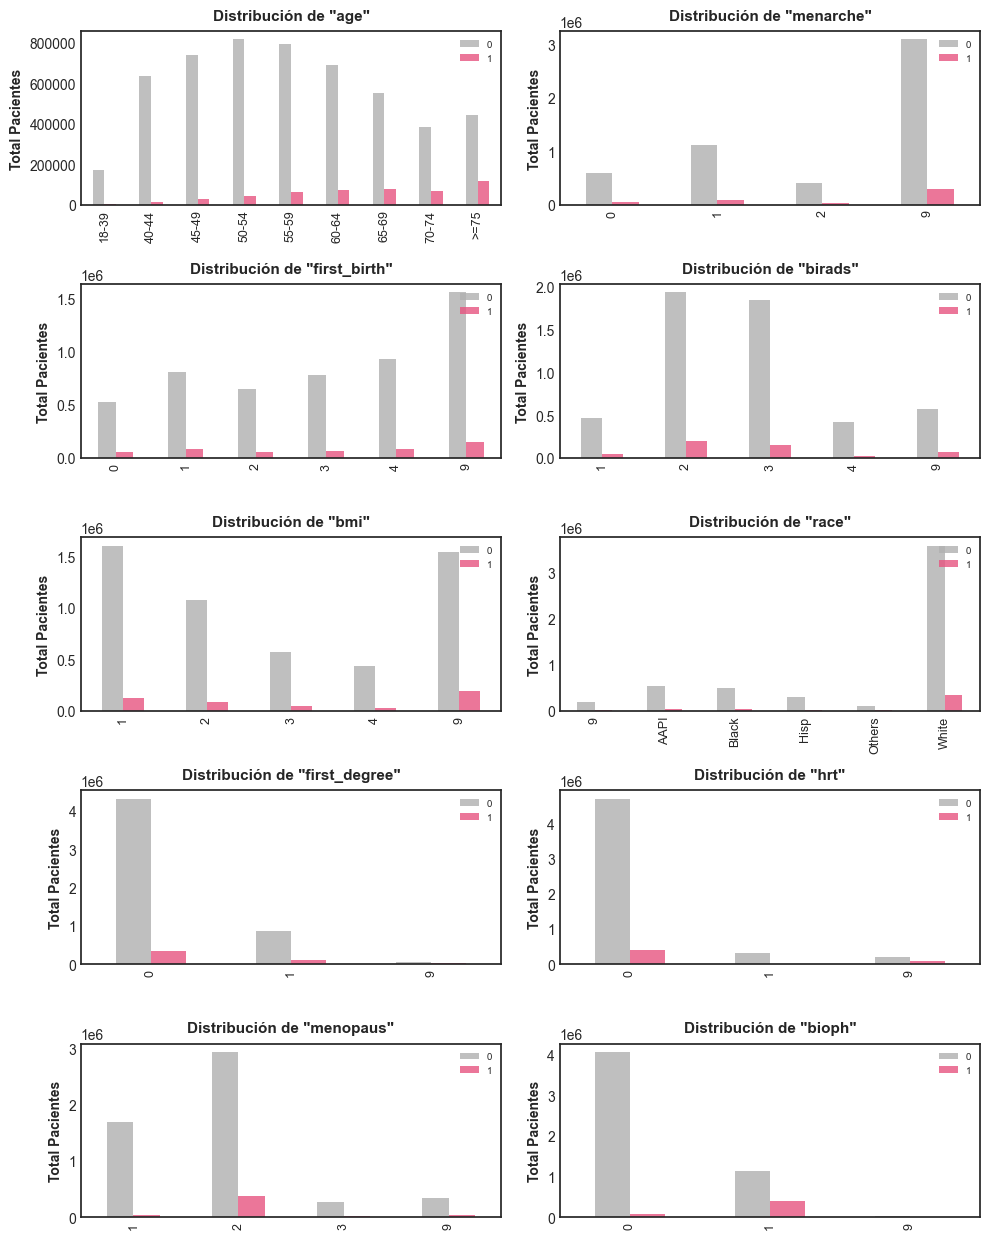

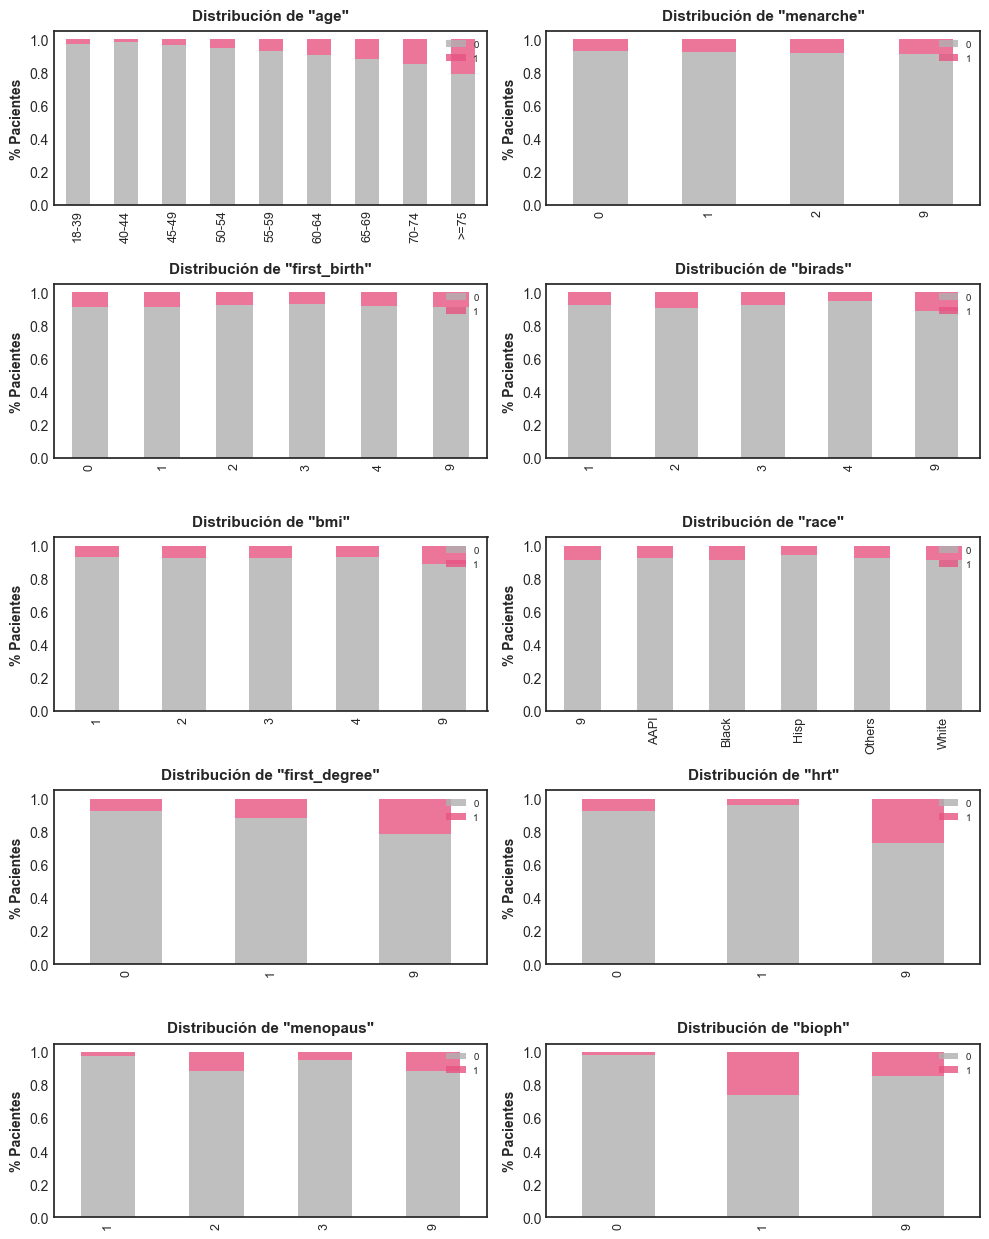

In [90]:
plot_categorias(data_agg, col_categoricas, 'cancer', False, True)
print("\n")
plot_categorias(data_agg, col_categoricas, 'cancer', True, True)

Para evaluar la importancia de cada variable con respecto a la variable objetivo, ya sea categórica o continua, se utiliza el valor de V de Cramer. Este estadístico captura tanto las relaciones lineales como no lineales. Su valor está acotado entre 0 y 1, donde 0 indica independencia y 1 indica dependencia total. Mide asociación entre dos variables.

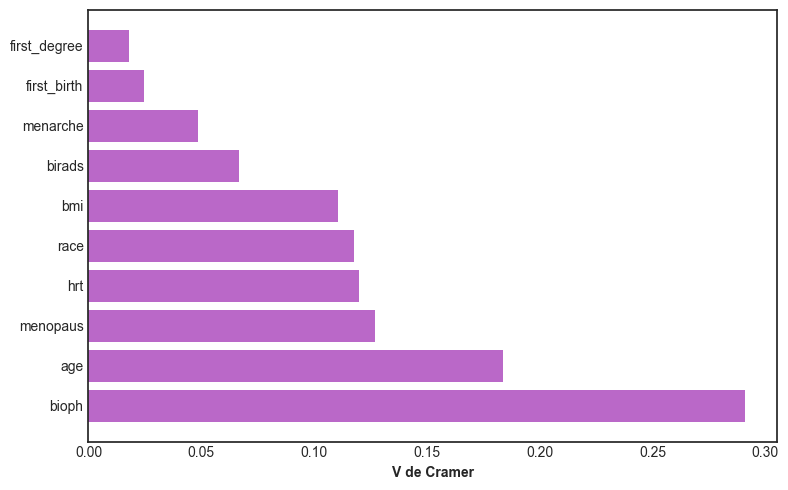

In [91]:
# No hay valores faltantes como tal, estos están en categorías
# Se puede usar la siguiente función
# No se tiene en cuenta "count"
graficoVcramer(data_agg[col_categoricas], data_agg['cancer'])

Se calcularon los coeficientes V de Cramer para evaluar la asociación entre las variables explicativas y la variable objetivo.   
En línea con el análisis exploratorio previo, bajo este criterio, las variables con mayor poder predictivo en orden de importancia son: bioph, age, menopaus, hrt, race y bmi.   
Por el contrario, variables como first_degree, first_birth y menarche presentan valores muy bajos (V < 0.05), indicando que apenas muestran asociación con la variable objetivo y, por tanto, su relevancia predictiva es limitada.

## EDA Missing 

In [92]:
# Se define la etiqueta 9 como valores perdidos para proceder a su estudio

for col in data.columns:
    data_agg[col] = data_agg[col].replace('9', np.nan)

data_agg.isnull().sum()

age                  0
race             23356
first_degree     17547
menarche        134423
first_birth      62784
birads           46337
hrt              49191
menopaus         34833
bmi              82818
bioph            12878
cancer               0
count                0
dtype: int64

### Descripción de Valores Perdidos del Dataset

Los valores faltantes pueden tener un impacto en la calidad y precisión del modelo predictivo. Estos, pueden reducir el número de observaciones disponibles, y si no son manejados adecuadamente pueden introducir sesgos, especialmente si no son aleatorios, llevando a conclusiones incorrectas.    Además, los valores faltantes en una variable pueden estar correlacionados con los faltantes en otras, lo que permite identificar relaciones entre las variables y determinar si las imputaciones deben realizarse de manera conjunta o independiente.  

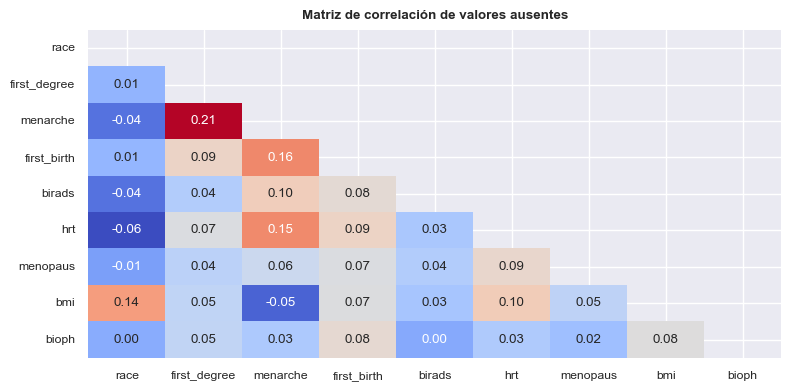

In [93]:
patron_perdidos(data_agg)
# No hay correlación entre valores ausentes
# No hay correlaciones fuertes entre los valores perdidos de diferentes variables. 
# Eso significa que los valores de correlación reales podrían no ser muy importantes
# En nuestro conjunto de datos, el mapa de calor muestra que no existen 
# correlaciones fuertes entre los valores faltantes de las diferentes variables.

TOTAL FILAS: 306345

NULOS POR VARIABLE:
----------------------
              Num Nulos    % Nulos
menarche         134423  43.879613
bmi               82818  27.034226
first_birth       62784  20.494540
hrt               49191  16.057386
birads            46337  15.125757
menopaus          34833  11.370514
race              23356   7.624084
first_degree      17547   5.727856
bioph             12878   4.203757
age                   0   0.000000
cancer                0   0.000000
count                 0   0.000000 

NULOS POR FILA (%):
-----------------
count    306345.000000
mean         12.626478
std          10.623946
min           0.000000
25%           8.333333
50%           8.333333
75%          16.666667
max          75.000000
dtype: float64 



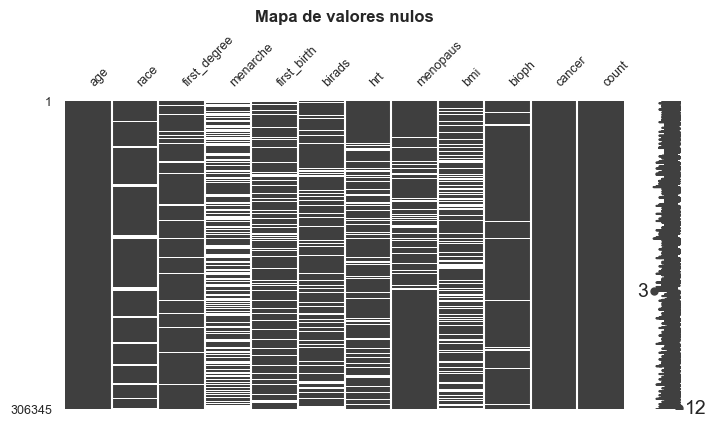

In [94]:
# ¿Cuantos valores perdidos hay?
summary_missing(data_agg)

In [95]:
## A NIVEL DE VARIABLE (según criterio en Shafiq Alam et al. 2023)
# Missing bajos - manejables (<5%): bioph, 
# Missing moderados - imputables (5-15%): race, first_degree, birads, menopaus
# Missing altos - impactant en el analisis (>15%) : hrt, first_birth, bmi, menarche

# Se observa que no hay ninguna variable que supere el 50% de observaciones perdidas. 
# Excepto Menarquia que se acerca al 44% de valores faltantes 

## A NIVEL DE FILA
# Observaciones, máximo un 75% de variables perdidas en al menos una fila
# Media de valores perdidos por fila: ~13% (bastante manejable).

# Creamos la variable prop_missings 
# la proporción de valores perdidos respecto al total de columnas en esa fila.
data_agg['prop_missings'] = data_agg.isna().mean(axis = 1)
data_agg.head()

age   race first_degree menarche first_birth birads hrt menopaus  bmi  \
0  18-39  White            0        0           0      1   0        1    4   
1  18-39  White            0        0           0      2   0        1    2   
2  18-39  White            0        0           0      2   0        1  NaN   
3  18-39  White            0        0           0      3   0        1  NaN   
4  18-39  White            0        0           0      4   0        1    1   

  bioph cancer  count  prop_missings  
0     0      0      1       0.000000  
1     0      0      1       0.000000  
2     0      0      3       0.083333  
3     0      0      1       0.083333  
4     0      0      2       0.000000

In [96]:
#Vamos a ver esta variable nueva es mas adecuada que sea categorica o cuantitativa
# Calculamos el número de valores distintos que tiene la nueva variable
# Saber si es más adecuado que sea numerica o categorica y noperder informacion
len(data_agg['prop_missings'].unique())
# con 10 valores interesa pasarlo a categorico

10

In [97]:
# Transformo la nueva variable en categórica (ya que tiene pocos valores diferentes)
data_agg["prop_missings"] = data_agg["prop_missings"].astype(str)
analizar_categorias(data_agg, 'prop_missings') 

Labels: ['0.0' '0.08333333333333333' '0.25' '0.16666666666666666'
 '0.3333333333333333' '0.4166666666666667' '0.5' '0.5833333333333334'
 '0.6666666666666666' '0.75'] 

prop_missings distribution:
                     Count      %
prop_missings                    
0.08333333333333333  98043  32.00
0.16666666666666666  73910  24.13
0.0                  72251  23.58
0.25                 39744  12.97
0.3333333333333333   15375   5.02
0.4166666666666667    5069   1.65
0.5                   1522   0.50
0.5833333333333334     359   0.12
0.6666666666666666      66   0.02
0.75                     6   0.00 



In [98]:
# Agrupamos las categorias con menos representacion
data_agg['prop_missings'] = data_agg['prop_missings'].replace('0.08333333333333333', '0.08')
data_agg['prop_missings'] = data_agg['prop_missings'].replace('0.16666666666666666', '0.17')
data_agg['prop_missings'] = data_agg['prop_missings'].replace('0.3333333333333333', '>0.30')
data_agg['prop_missings'] = data_agg['prop_missings'].replace('0.4166666666666667', '>0.30')
data_agg['prop_missings'] = data_agg['prop_missings'].replace('0.5', '>0.30')
data_agg['prop_missings'] = data_agg['prop_missings'].replace('0.5833333333333334', '>0.30')
data_agg['prop_missings'] = data_agg['prop_missings'].replace('0.6666666666666666', '>0.30')
data_agg['prop_missings'] = data_agg['prop_missings'].replace('0.75', '>0.30')

analizar_categorias(data_agg, 'prop_missings') 

Labels: ['0.0' '0.08' '0.25' '0.17' '>0.30'] 

prop_missings distribution:
               Count      %
prop_missings              
0.08           98043  32.00
0.17           73910  24.13
0.0            72251  23.58
0.25           39744  12.97
>0.30          22397   7.31 



Valor de Chi-cuadrado: 2168.8483
Valor p: 0.0000
Sí hay relación significativa entre las variables (p ≤ 0.05).



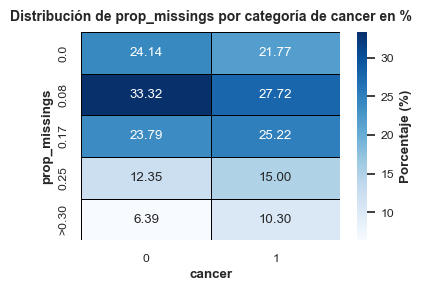

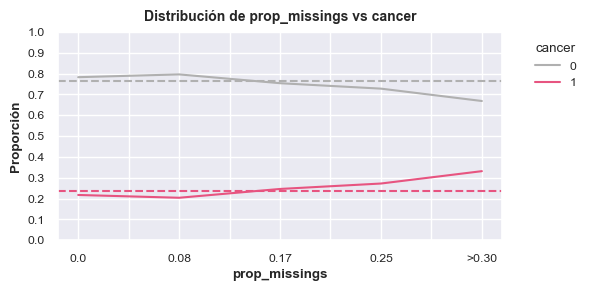


Residuals:
-------------
cancer             0      1
prop_missings              
0.0            13.16 -13.16
0.08           28.22 -28.22
0.17           -7.86   7.86
0.25          -18.51  18.51
>0.30         -35.22  35.22



In [99]:
# Se relacionan los missing con la variable target?
analisis_bivariante(data_agg, 'prop_missings', 'cancer')

Las filas de los perfiles con valores perdidos  >0.3%, parece tener relación con la variable target.

### Tratamiento de Valores Perdidos

**NIVEL FILA**
1. Eliminamos filas/observaciones con missing superiores a 50%. Cuando en una variable hay mas de la mitad de los datos faltantes, es recomendable rechazarla al inicio del proceso, pues carece de suficiente informacion.

Al ser un dataset grande no se pierde demasiada información y se gana coherencia sin comprometer la representatividad

Filas Eliminadas: 431(0.14%)

TOTAL FILAS: 305914

NULOS POR VARIABLE:
----------------------
               Num Nulos    % Nulos
menarche          133994  43.801199
bmi                82406  26.937636
first_birth        62376  20.390044
hrt                48808  15.954811
birads             46074  15.061096
menopaus           34509  11.280621
race               23108   7.553757
first_degree       17182   5.616611
bioph              12615   4.123708
age                    0   0.000000
cancer                 0   0.000000
count                  0   0.000000
prop_missings          0   0.000000 

NULOS POR FILA (%):
-----------------
count    305914.000000
mean         11.593806
std           9.675361
min           0.000000
25%           7.692308
50%           7.692308
75%          15.384615
max          46.153846
dtype: float64 



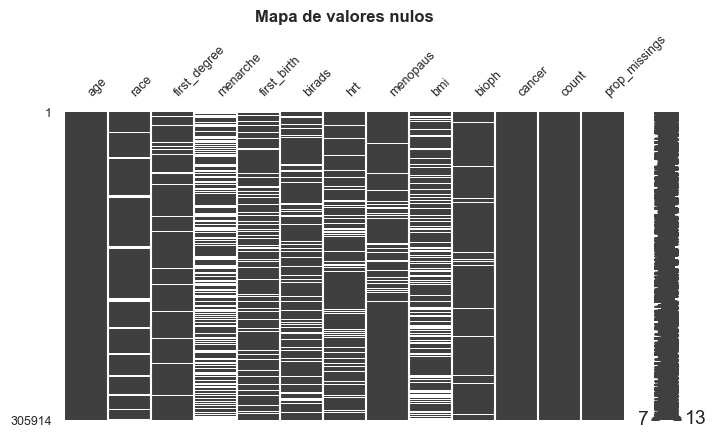

In [100]:
data_clean_fila = data_agg[data_agg.isnull().mean(axis=1) <= 0.5]

filas_remove = (data_agg.shape[0]-data_clean_fila.shape[0])
filas_remove_pct = filas_remove * 100 /data_agg.shape[0]
print(f'Filas Eliminadas: {filas_remove}({filas_remove_pct:.2f}%)\n')

summary_missing(data_clean_fila)

**NIVEL VARIABLE**  

2. Variable "Menarche". Casi el 50% del dataset no tiene esta información. Se puede perder información valiosa si se descarta esta variable aunque este incompleta. Sin embargo, se ha visto en el EDA que esta variable apenas aporta información discriminativa a la variable target. En el selección de variables se estudiará si eliminar esta variable.

3. ¿Imputar datos missing? Se realizará la siguiente estrategia:
- Para **categoricas nominales** se creará/dejará la categoría "Unknown".Los missing que parecen estar relacionados con el target, conviene preservarlos en lugar de imputarlos. La ausencia parece informativa en variables como "race", "hrt" y "bioph". Ya habiamos visto que las categorias de las nominales con etiqueta "9" son suficientemente representativas.
  
- Para **categorias ordinales** se imputarán los valores mediante una técnica de imputación multivariante. Estos métodos utilizan información de multiples variables para estimar y rellenar los valores perdidos, resultando en estimaciones más precisas menos sesgadas que las técnicas tradicionales. Son particularmente útiles cuando hay patrones complejos en los datos. Entre estos métodos se encuentran KNNImputer, IterativeImputer y Miss Forest. Un estudio (Shafiq Alam et al. 2023) mostró la eficacia de modelos basados en árboles para imputar datos ordinales, ya que no solo completan los conjuntos de datos de manera precisa, sino que además tienden a preservar mejor las relaciones entre variables y a reproducir de forma más fiel las estructuras de clustering, lo que redunda en una mejora del rendimiento de modelos predictivos posteriores. Se usa IterativeImputer con DecisionTreeClassifier como estimador, basado en los resultados del estudios anterior..
- Además para **categorias ordinales** se creará un indicador de "Missing" para cada variable que indique si en la fila hay un valor perdido, donde 1 indica que el valor está perdido y cero que el valor está presente.


In [101]:
# Variables nominales
col_nom_notarget = ['race', 'first_degree', 'hrt', 'menopaus', 'bioph']

data_clean = data_clean_fila.copy()
for col in col_nom_notarget:
    data_clean[col] = data_clean[col].fillna("Unknown")
    print(f'{col}: {data_clean[col].unique()}')

race: ['White' 'Black' 'AAPI' 'Others' 'Hisp' 'Unknown']
first_degree: ['0' '1' 'Unknown']
hrt: ['0' '1' 'Unknown']
menopaus: ['1' '2' 'Unknown' '3']
bioph: ['0' '1' 'Unknown']


In [102]:
# variables ordinales
col_ord_indicator = ['menarche', 'first_birth', 'birads', 'bmi']

for col in col_ord_indicator:
    data_clean[f'{col}_NA'] = data_clean[col].isna().astype(int)

data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305914 entries, 0 to 306339
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   age             305914 non-null  object
 1   race            305914 non-null  object
 2   first_degree    305914 non-null  object
 3   menarche        171920 non-null  object
 4   first_birth     243538 non-null  object
 5   birads          259840 non-null  object
 6   hrt             305914 non-null  object
 7   menopaus        305914 non-null  object
 8   bmi             223508 non-null  object
 9   bioph           305914 non-null  object
 10  cancer          305914 non-null  object
 11  count           305914 non-null  int64 
 12  prop_missings   305914 non-null  object
 13  menarche_NA     305914 non-null  int32 
 14  first_birth_NA  305914 non-null  int32 
 15  birads_NA       305914 non-null  int32 
 16  bmi_NA          305914 non-null  int32 
dtypes: int32(4), int64(1), object(12)


In [103]:
data_clean.head()

age   race first_degree menarche first_birth birads hrt menopaus  bmi  \
0  18-39  White            0        0           0      1   0        1    4   
1  18-39  White            0        0           0      2   0        1    2   
2  18-39  White            0        0           0      2   0        1  NaN   
3  18-39  White            0        0           0      3   0        1  NaN   
4  18-39  White            0        0           0      4   0        1    1   

  bioph cancer  count prop_missings  menarche_NA  first_birth_NA  birads_NA  \
0     0      0      1           0.0            0               0          0   
1     0      0      1           0.0            0               0          0   
2     0      0      3          0.08            0               0          0   
3     0      0      1          0.08            0               0          0   
4     0      0      2           0.0            0               0          0   

   bmi_NA  
0       0  
1       0  
2       1  
3       1  
4       0

<br>

# **Featuring Engineering**

## Division Train/Test

La variable 'count' no se usa como variable predictora para modelos individuales. Se debe valorar si usar como sample_weight al entrenar el modelo. El peso no se normaliza ni se escala pues los modelos ya ajustan la importancia de acuerdo al valor absoluto.         
Del mismo modo en un análisis clustering debe hacerse solo con las variables de características, sin considerar cuántos hay en cada grupo. Cada fila representa un perfil, no importa cuántas personas lo tienen para el algoritmo de clustering.

Las transformaciones de datos deben hacerse después de dividir los datos en train y test.
- Evitar la contaminación de datos (data leakage): el escalador tiene acceso a información de los datos de prueba durante el ajuste, lo que nos puede llevar a modelos no generalizables, ya que los datos de prueba influyen indirectamente en el entrenamiento.
- Simular un escenario real, en el que los datos de prueba nunca estarán disponibles durante el entrenamiento

In [104]:
X = data_clean.drop(['cancer', 'count'], axis=1)
y = data_clean['cancer']
sample_weight = data_clean['count']

print("Variables explicativas:\n ", X.columns.values)
print("\nVariable explicativa dimensiones:\n", X.shape)
print("\nVariable objetivo dimensiones:\n", y.shape)

Variables explicativas:
  ['age' 'race' 'first_degree' 'menarche' 'first_birth' 'birads' 'hrt'
 'menopaus' 'bmi' 'bioph' 'prop_missings' 'menarche_NA' 'first_birth_NA'
 'birads_NA' 'bmi_NA']

Variable explicativa dimensiones:
 (305914, 15)

Variable objetivo dimensiones:
 (305914,)


In [105]:
# las ordinales las tratamos como numéricas 
# todas las ordinales comienzan en cero
# bmi y birads comienzan en uno
X[['bmi', 'birads']] = X[['bmi', 'birads']].astype(float)-1.0

print(f"BMI: {X['bmi'].unique()}")
print(f"Birads: {X['birads'].unique()}")
print(f"First_Birth: {X['first_birth'].unique()}")
print(f"Menarche: {X['menarche'].unique()}")

BMI: [ 3.  1. nan  0.  2.]
Birads: [ 0.  1.  2.  3. nan]
First_Birth: ['0' '1' '2' '4' nan '3']
Menarche: ['0' '1' '2' nan]


*Stratify* en *train_test_split* sirve para mantener la misma proporción de clases en el train y en el test que la que hay en el dataset original.

In [106]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y)

print(f'La frecuencia de cada clase en train es: \n{y_train.value_counts(normalize=True)}')
print(f'\nLa frecuencia de cada clase en test es: \n{y_test.value_counts(normalize=True)}')

La frecuencia de cada clase en train es: 
cancer
0    0.764864
1    0.235136
Name: proportion, dtype: float64

La frecuencia de cada clase en test es: 
cancer
0    0.764869
1    0.235131
Name: proportion, dtype: float64


## Feature Transformation

Se transforman las variables en el siguiente orden secuencial:
- Imputacion de los datos 
- Se crea un column transformer para preprocesar los datos:
    - One-hot encoder para caterogóricas nominales
    - Ordinal encoder para categóricas ordinales

Por último se balance los datos train para entrenar los modelos

In [107]:
# se define las listas de variables a transformar
cat_w_miss =  X_train.columns[X_train.isnull().any()].tolist()
cat_nom = ['race' ,'first_degree', 'hrt', 'menopaus' , 'bioph']
cat_binary = ['menarche_NA', 'first_birth_NA','birads_NA','bmi_NA' ]

# para especificar el orden de los niveles en variables ordinales.
age_order = ["18-39", "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74", ">=75"]
missing_order = ["0.0", "0.08", "0.17", "0.25", ">0.30"]

In [108]:
# column Transformer
imputer = IterativeImputer(
    estimator=DecisionTreeClassifier(random_state=seed), 
    random_state=seed)

preprocessor  = ColumnTransformer([
    ("imputer", imputer , cat_w_miss),
    ('OneH_binary', OneHotEncoder(drop='if_binary') , cat_binary ),
    ('OneH_nom', OneHotEncoder(drop='first'), cat_nom),
    ("ord_enc", OrdinalEncoder(categories=[age_order, missing_order]), ['age', 'prop_missings']),
    ], remainder='passthrough')

In [109]:
# guardamos preprocesor
preprocessor.fit(X_train)
with open("preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

In [110]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# Convertir el resultado a un DataFrame si se quiere  visualizarlo
original_names = preprocessor.get_feature_names_out()
clean_names = [f.split("__")[-1] for f in original_names]

X_train_fe = pd.DataFrame(X_train_prep, columns=clean_names, index=X_train.index)
X_test_fe = pd.DataFrame(X_test_prep, columns=clean_names, index=X_test.index)

In [111]:
print(f'Nulos antes de procesar:\n {X_train.isnull().sum()}\n')
print(f'Nulos depués de procesar:\n {X_train_fe.isnull().sum()}\n')

Nulos antes de procesar:
 age                    0
race                   0
first_degree           0
menarche          107111
first_birth        49928
birads             36805
hrt                    0
menopaus               0
bmi                65808
bioph                  0
prop_missings          0
menarche_NA            0
first_birth_NA         0
birads_NA              0
bmi_NA                 0
dtype: int64

Nulos depués de procesar:
 menarche                0
first_birth             0
birads                  0
bmi                     0
menarche_NA_1           0
first_birth_NA_1        0
birads_NA_1             0
bmi_NA_1                0
race_Black              0
race_Hisp               0
race_Others             0
race_Unknown            0
race_White              0
first_degree_1          0
first_degree_Unknown    0
hrt_1                   0
hrt_Unknown             0
menopaus_2              0
menopaus_3              0
menopaus_Unknown        0
bioph_1                 0
bioph_Unknow

In [112]:
print(f'Dimensiones finales train variables explicativas:\n {X_train_fe.shape}\n')
print(f'Dimensiones finales train variable objetivo:\n {y_train.shape}\n')

Dimensiones finales train variables explicativas:
 (244731, 24)

Dimensiones finales train variable objetivo:
 (244731,)



In [113]:
print(f'Dimensiones finales test variables explicativas:\n {X_test_fe.shape}\n')
print(f'Dimensiones finales test variable objetivo:\n {y_test.shape}\n')

Dimensiones finales test variables explicativas:
 (61183, 24)

Dimensiones finales test variable objetivo:
 (61183,)



In [114]:
X_train_fe.head()

menarche  first_birth  birads  bmi  menarche_NA_1  first_birth_NA_1  \
81792        0.0          0.0     1.0  1.0            1.0               1.0   
251541       2.0          1.0     1.0  3.0            0.0               0.0   
304314       1.0          2.0     1.0  3.0            0.0               0.0   
167408       1.0          0.0     2.0  0.0            1.0               0.0   
245805       1.0          4.0     1.0  0.0            1.0               0.0   

        birads_NA_1  bmi_NA_1  race_Black  race_Hisp  ...  \
81792           1.0       0.0         0.0        0.0  ...   
251541          0.0       0.0         1.0        0.0  ...   
304314          0.0       0.0         0.0        1.0  ...   
167408          0.0       0.0         0.0        0.0  ...   
245805          0.0       0.0         0.0        0.0  ...   

        first_degree_Unknown  hrt_1  hrt_Unknown  menopaus_2  menopaus_3  \
81792                    0.0    0.0          1.0         0.0         0.0   
251541                   0.0    0.0          0.0         1.0         0.0   
304314                   0.0    0.0          0.0         1.0         0.0   
167408                   0.0    0.0          0.0         0.0         1.0   
245805                   0.0    0.0          1.0         1.0         0.0   

        menopaus_Unknown  bioph_1  bioph_Unknown  age  prop_missings  
81792                1.0      0.0            0.0  2.0            4.0  
251541               0.0      0.0            0.0  7.0            0.0  
304314               0.0      0.0            0.0  8.0            0.0  
167408               0.0      1.0            0.0  4.0            1.0  
245805               0.0      1.0            0.0  7.0            2.0  

[5 rows x 24 columns]

In [115]:
X_train_fe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244731 entries, 81792 to 179831
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   menarche              244731 non-null  float64
 1   first_birth           244731 non-null  float64
 2   birads                244731 non-null  float64
 3   bmi                   244731 non-null  float64
 4   menarche_NA_1         244731 non-null  float64
 5   first_birth_NA_1      244731 non-null  float64
 6   birads_NA_1           244731 non-null  float64
 7   bmi_NA_1              244731 non-null  float64
 8   race_Black            244731 non-null  float64
 9   race_Hisp             244731 non-null  float64
 10  race_Others           244731 non-null  float64
 11  race_Unknown          244731 non-null  float64
 12  race_White            244731 non-null  float64
 13  first_degree_1        244731 non-null  float64
 14  first_degree_Unknown  244731 non-null  float64
 15  h

In [116]:
# guardar datos procesados
with open("X_train_fe.pkl", "wb") as f:
    pickle.dump(X_train_fe, f)

with open("y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)

with open("X_test_fe.pkl", "wb") as f:
    pickle.dump(X_test_fe, f)

with open("y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

## Balance de clases

Una vez finalizado el proceso de preprocesamiento y transformación de las variables los datos ya se encuentran preparados para su uso en los distintos modelos de machine learning. Sin embargo, antes de entrenarlos, es necesario abordar el problema del desbalanceo de clases existente en la variable objetivo. 

El aprendizaje a partir de datos desbalanceados representa un desafío significativo, ya que esta condición puede llevar a los clasificadores a generar predicciones sesgadas e inexactas. Esto ocurre porque los modelos tienden a favorecer a la clase mayoritaria durante el entrenamiento, dificultando la identificación y clasificación correcta de los casos pertenecientes a la clase minoritaria.

El dataset original está muy desbalanceado. Este desbalance puede afectar la capacidad del modelo para detectar correctamente los casos positivos (cáncer). Por ello, se probaron distintas técnicas de balanceo: SMOTE, SMOTEENN, SMOTETomek, RUS+SMOTE. 

SMOTE(Synthetic Minority Over-sampling Technique)  genera instancias sintéticas de la clase minoritaria interpolando entre observaciones existentes. Para cada instancia minoritaria, se identifican sus k vecinos más cercanos y se crean nuevas muestras a lo largo de la línea que une la instancia original con sus vecinos, de manera que los datos sintéticos mantengan la estructura del espacio de características.

SMOTEENN (SMOTE + Edited Nearest Neighbors) y SMOTETomek (SMOTE + Tomek links) son dos técnicas con buenos resultados para balancear ambas clases, ambas combinan oversampling de la clase minoritaria con algún tipo de undersampling de la clase mayoritaria: SMOTEEN aplica ENN (Edited Nearest Neighbors), que elimina ejemplos ruidosos o conflictivos de ambas clases para limpiar el dataset; SMOTETomek elimina pares de ejemplos cercanos de distintas clases que están demasiado cerca, reduciendo el solapamiento.

RUS (RandomUnderSampler) es la técnica de submuestreo más simple y rápida. Selecciona aleatoriamente muestras de la clase mayoritaria y las elimina del conjunto de entrenamiento hasta alcanzar la distribución deseada. Este ajuste evita que la clase mayoritaria domine el aprendizaje, pero sin eliminar excesiva información clínica relevante que pueda ser útil para la predicción.

In [117]:
# Definir scoring
scoring = {
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc',
    'pr_auc': make_scorer(average_precision_score, needs_proba=True)
}

# Técnicas de balanceo
samplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=seed),
    'SMOTEENN': SMOTEENN(random_state=seed),
    'SMOTETomek': SMOTETomek(random_state=seed),
    'RUS+SMOTE5k3': Pipeline([
        ('rus', RandomUnderSampler(sampling_strategy=0.5, random_state=seed)),
        ('smote', SMOTE(sampling_strategy=1, k_neighbors=3, random_state=seed))
    ]),
    'RUS+SMOTE4k3': Pipeline([
        ('rus', RandomUnderSampler(sampling_strategy=0.4, random_state=seed)),
        ('smote', SMOTE(sampling_strategy=1, k_neighbors=3, random_state=seed))
    ]),
    'RUS+SMOTE5k5': Pipeline([
        ('rus', RandomUnderSampler(sampling_strategy=0.5, random_state=seed)),
        ('smote', SMOTE(sampling_strategy=1, k_neighbors=5, random_state=seed))
    ]),
    'RUS+SMOTE4k5': Pipeline([
        ('rus', RandomUnderSampler(sampling_strategy=0.4, random_state=seed)),
        ('smote', SMOTE(sampling_strategy=1, k_neighbors=5, random_state=seed))
    ]),
    'SMOTE+RUS': Pipeline([
        ('smote', SMOTE(sampling_strategy=0.42, k_neighbors=3, random_state=seed)),
        ('rus', RandomUnderSampler(sampling_strategy=0.7, random_state=seed))
    ])
}

summary_classes = []
summary_scores = []

y_train_n = y_train.astype(int)
y_test_n = y_test.astype(int)

for name, sampler in samplers.items():
    X_train_copy, y_train_copy = X_train_fe.copy(), y_train_n.copy()
    
    if sampler is not None:
        X_train_b, y_train_b = sampler.fit_resample(X_train_copy, y_train_copy)
    else:
        X_train_b, y_train_b = X_train_copy, y_train_copy
    
    # Distribución de clases tras balanceo
    counter = Counter(y_train_b)
    total = sum(counter.values())
    summary_classes.append({
        'Técnica': name,
        'Clase 0 (n)': counter.get(0,0),
        'Clase 0 (%)': round(counter.get(0,0)/total*100,1),
        'Clase 1 (n)': counter.get(1,0),
        'Clase 1 (%)': round(counter.get(1,0)/total*100,1)
    })
    
    # Entrenar modelo
    model = RandomForestClassifier(random_state=seed)
    model.fit(X_train_b, y_train_b)
    
    # Evaluar en train y test
    for dataset, X_eval, y_eval in [('Train', X_train_b, y_train_b), ('Test', X_test_fe, y_test_n)]:
        y_pred = model.predict(X_eval)
        y_prob = model.predict_proba(X_eval)[:,1]
        summary_scores.append({
            'Técnica': name,
            'Dataset': dataset,
            'Recall': round(recall_score(y_eval, y_pred),3),
            'Precision': round(precision_score(y_eval, y_pred),3),
            'F1': round(f1_score(y_eval, y_pred),3),
            'ROC-AUC': round(roc_auc_score(y_eval, y_prob),3),
            'PR-AUC': round(average_precision_score(y_eval, y_prob),3)
        })

# Convertir a DataFrames
df_classes = pd.DataFrame(summary_classes)
df_scores = pd.DataFrame(summary_scores)

# Mostrar resultados
print("Distribución de clases tras balanceo (train):")
print(df_classes)
print("\nMétricas en train y test:")
print(df_scores)

Distribución de clases tras balanceo (train):
        Técnica  Clase 0 (n)  Clase 0 (%)  Clase 1 (n)  Clase 1 (%)
0          None       187186         76.5        57545         23.5
1         SMOTE       187186         50.0       187186         50.0
2      SMOTEENN        92314         54.9        75771         45.1
3    SMOTETomek       187067         50.0       187067         50.0
4  RUS+SMOTE5k3       115090         50.0       115090         50.0
5  RUS+SMOTE4k3       143862         50.0       143862         50.0
6  RUS+SMOTE5k5       115090         50.0       115090         50.0
7  RUS+SMOTE4k5       143862         50.0       143862         50.0
8     SMOTE+RUS       112311         58.8        78618         41.2

Métricas en train y test:
         Técnica Dataset  Recall  Precision     F1  ROC-AUC  PR-AUC
0           None   Train   0.593      0.723  0.651    0.937   0.815
1           None    Test   0.170      0.199  0.184    0.623   0.287
2          SMOTE   Train   0.912      0.893

RESULTADOS:

Todas las técnicas de balanceo aproximan la proporción de clases al 50/50, excepto SMOTEENN que alcanza 45% para la clase positiva. En muchos estudios clínicos y financieros, ratios entre 60-40 o 65-35 ya se consideran un buen equilibrio entre representatividad y reducción de sesgo.

Se evaluaron recall, precision, F1, ROC-AUC y PR-AUC en train y test.
- Recall: proporción de casos positivos correctamente identificados. En este caso, la capacidad del modelo para detectar pacientes con probabilidad de tener cáncer.
- Precision: proporción de predicciones positivas correctas sobre todas las predicciones positivas.
- F1-score: media armónica de precision y recall, balanceando ambos aspectos.
- ROC-AUC: capacidad del modelo para distinguir entre clases en todas las posibles decisiones de umbral.
- PR-AUC: área bajo la curva precision-recall.

Las técnicas SMOTE y SMOTETomek muestran metricas de train muy alto, pero test significativamente menores, indicando sobreajuste. Esto ocurre porque estas técnicas generan conjuntos de entrenamiento con exceso de ejemplos sintéticos y ruido, aumentando la memorización de los datos de entrenamiento. Este comportamiento ha sido reportado en la literatura. De manera similar, SMOTEENN obtuvo métricas de train iguales a 1, lo que evidencia una memorización total del conjunto de entrenamiento y una pérdida de capacidad de generalización al test real. Por estos motivos, SMOTE, SMOTETomek y SMOTEENN fueron descartadas para la elección final del modelo.

La combinación de oversampling moderado mediante SMOTE y undersampling controlado mediante RUS proporcionó un balance óptimo entre la representatividad de ambas clases y la estabilidad de los modelos entrenados, reduciendo el riesgo de sobreajuste.

Por este motivo, se elige como mejor técnica RUS+SMOTE5k3, ya que no solo mantiene un buen balance de clases, sino que también presenta mejores métricas de desempeño que el resto de combinaciones híbridas evaluadas

SMOTE y RandomUnderSampler (y cualquier técnica de resampling) solo se aplica a los datos de entrenamiento para evitar filtración de información (data leakage)

In [118]:
# creación de la pipeline con aplicando SMOTE + RUS
balancer = Pipeline(steps=[
    ("under", RandomUnderSampler(sampling_strategy=0.5, random_state=seed)),
    ("smote", SMOTE(sampling_strategy=1, k_neighbors=3, random_state=seed)),
])

X_train_res, y_train_res = balancer.fit_resample(X_train_fe, y_train)

print("Distribución original de clases en entrenamiento:")
vc_train = y_train.value_counts()
vc_train_norm = y_train.value_counts(normalize=True) * 100 
for cls in vc_train.index:
    print(f"{cls}\t{vc_train[cls]} ({vc_train_norm[cls]:.1f}%)")

print("\nDistribución tras técnica híbrida RUS+SMOTE5k3:")
y_res_series = pd.Series(y_train_res)
vc_res = y_res_series.value_counts()
vc_res_norm = y_res_series.value_counts(normalize=True) * 100
for cls in vc_res.index:
    print(f"{cls}\t{vc_res[cls]} ({vc_res_norm[cls]:.1f}%)")

Distribución original de clases en entrenamiento:
0	187186 (76.5%)
1	57545 (23.5%)

Distribución tras técnica híbrida SMOTE+RUS:
0	115090 (50.0%)
1	115090 (50.0%)


## Selección de variables : RFECV (Recursive Feature Elimination with Cross-Validation)

Las variables irrelevantes pueden provocar sobreajuste y reducir el rendimiento de los modelos. Por ello, se va seleccionar las variabels que más contribuyen a la  predicción utilizan varios métodos.

RFECV es una técnica de selección de variables (features) para modelos de Machine Learning. Combina dos conceptos:
- Eliminación recursiva de variables (RFE): Es un proceso que elimina iterativamente las variables menos importantes del conjunto de datos, entrenando un modelo cada vez y evaluando qué variables son menos relevantes para la predicción.  La característica con importance = 1 ignifica que la variable fue seleccionada en el conjunto óptimo de características. Fue la última en ser eliminada y, por lo tanto, se mantuvo en el conjunto de características óptimo. El ranking, es el orden en que RFECV decidió que las variables podían ser eliminadas sin dañar el rendimiento del modelo.
- Validación cruzada (CV): Evalúa el rendimiento del modelo en diferentes subconjuntos del dato (folds), garantizando que la elección de variables no depende del azar ni de un solo reparto de los datos.

In [119]:
estimator = RandomForestClassifier(n_estimators=100, random_state=seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

#STEP determina la cantidad de características que se eliminarán en cada iteración
selector = RFECV(estimator, step=1, cv=kfold, scoring="roc_auc", n_jobs=-1)
selector = selector.fit(X_train_res, y_train_res)
print("Número óptimo de características:", selector.n_features_)

# Ordenar por ranking 
skf = pd.DataFrame(zip(selector.ranking_, 
                       selector.cv_results_["mean_test_score"], 
                       X_train_res.columns),
                   columns=['importance', 'score', 'feature']).\
                   sort_values('importance', ascending=True) 
print(skf)

Número óptimo de características: 7
    importance     score               feature
23           1  0.805192         prop_missings
1            1  0.780142           first_birth
2            1  0.795897                birads
3            1  0.807174                   bmi
20           1  0.802961               bioph_1
13           1  0.796587        first_degree_1
22           1  0.804956                   age
0            2  0.696500              menarche
12           3  0.797181            race_White
15           4  0.798153                 hrt_1
7            5  0.808554              bmi_NA_1
17           6  0.797979            menopaus_2
8            7  0.801692            race_Black
4            8  0.815108         menarche_NA_1
16           9  0.797442           hrt_Unknown
9           10  0.808076             race_Hisp
5           11  0.816412      first_birth_NA_1
6           12  0.817794           birads_NA_1
10          13  0.803467           race_Others
18          14  0.799759

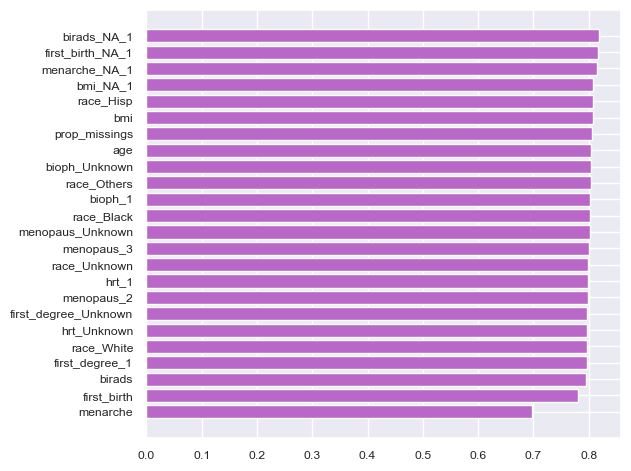

In [120]:
# grafico de barras de las puntuaciones score obtenidas 
skf = skf.sort_values('score', ascending=True)
plt.barh(y=skf["feature"], width=skf["score"], color='#BA68C8')
plt.show()

El mejor rendimiento (el mayor AUC promedio) se obtuvo utilizando 7 variables:prop_missings, first_birth, birads, bmi, bioph_1, first_degree_1 y age.   
Las últimas del ranking pueden ser eliminadas sin que afecten al rendimiento del modelo.

Antes de seleccionar, veamos la redundancia. Puede haber variables redundantes entre sí (muy correlacionadas), lo que puede afectar la interpretabilidad y la robustez. Se revisaa la matriz de correlación entre variables y se considera eliminar aquellas con correlaciones muy altas (> 0.9).

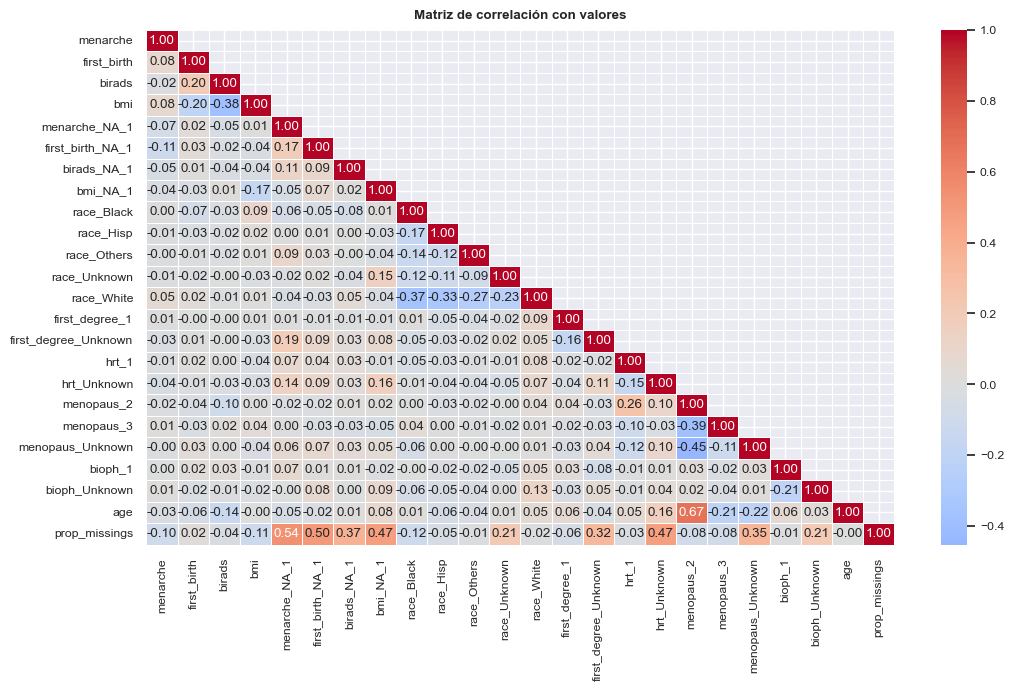

No hay pares de variables con correlación mayor a 0.9.


In [121]:
# Calcula la matriz de correlación
corr_matrix = X_train_res.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

plt.figure(figsize=(11, 7))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", 
            cmap='coolwarm', center=0, linewidths=0.5,
           )
plt.title('Matriz de correlación con valores')
plt.tight_layout()
plt.show()

# Indicar pares con correlación > 0.9 
upper = corr_matrix.where(np.triu(
    np.ones(corr_matrix.shape), k=1).astype(bool))
pares_correlacionados = [(col, row, upper.loc[row, col])
                         for col in upper.columns for row in upper.index \
                         if upper.loc[row, col] > 0.9]

if pares_correlacionados:
    print("Pares de variables con correlación > 0.9:")
    for col, row, corr in pares_correlacionados:
        print(f"{col} y {row} (correlación = {corr:.2f})")
else:
    print("No hay pares de variables con correlación mayor a 0.9.")

Se ve una ligera correlación entre edad y menopaus_2, como cabe esperar, pues esta condición aparece en mujeres al rededor de los 50 años. (0.67)  
Tambien otra muy ligera correlación entre prop_missings y aquellas variables missing marcadas con el flag_NA (entre 0.21 y 0.55)

Para seleccionar las variables, vamos a usar ExtraTrees para complementar el análisis y poder tomar una decisión sobre la selección final.

ExtraTrees es un algoritmo basado en árboles como Random Forest, pero introduce más aleatoriedad al elegir los splits. Esto lo hace menos propenso a sobreajustar y da estimaciones más estables de la importancia de las variables. Las importancias de ExtraTrees miden cuánto reduce la impureza del nodo cada variable en promedio a lo largo de los árboles. Si una variable aparece con importancia muy baja, probablemente aporta poco o es redundante en el árbol. Esto significa que considera cómo interactúan las variables entre sí para predecir la clase. Permite mantener todas las variables realmente relevantes y quitar solo las que aportan poco a la predicción.

                 feature  importance
20               bioph_1    0.178217
22                   age    0.166017
1            first_birth    0.096128
2                 birads    0.076912
3                    bmi    0.068341
0               menarche    0.052901
13        first_degree_1    0.044348
23         prop_missings    0.031664
15                 hrt_1    0.031248
12            race_White    0.028594
7               bmi_NA_1    0.025932
17            menopaus_2    0.025086
16           hrt_Unknown    0.020705
4          menarche_NA_1    0.020346
10           race_Others    0.017722
8             race_Black    0.016307
9              race_Hisp    0.016172
5       first_birth_NA_1    0.015721
18            menopaus_3    0.014533
6            birads_NA_1    0.013992
14  first_degree_Unknown    0.012377
21         bioph_Unknown    0.009969
19      menopaus_Unknown    0.008429
11          race_Unknown    0.008338


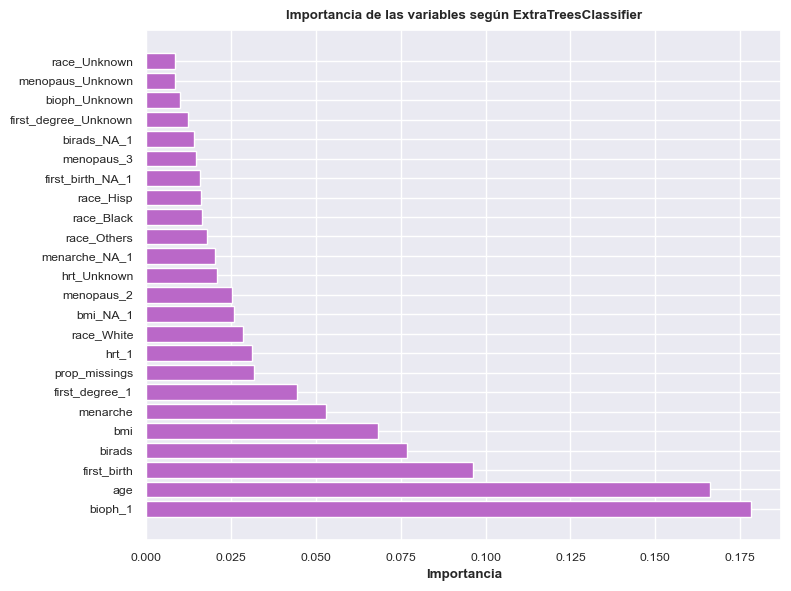

In [122]:
model_importance = ExtraTreesClassifier(n_estimators=100, random_state=seed) 
model_importance.fit(X_train_res, y_train_res) 
model_importance.feature_importances_ 

importancias = pd.DataFrame({
    'feature': X_train_res.columns,
    'importance': model_importance.feature_importances_
}).sort_values('importance', ascending=False)  

print(importancias)

plt.figure(figsize=(8, 6))
plt.barh(y=importancias['feature'], width=importancias['importance'], color='#BA68C8')
plt.xlabel("Importancia")
plt.title("Importancia de las variables según ExtraTreesClassifier")
plt.tight_layout()
plt.show()

Al analizar las importancias con ExtraTrees vemos que las 7 de RFECV están también en el top de ExtraTrees, lo cual da robustez al resultado.   
Las bajas importancias no significan que las variables sean inútiles, sino que son menos relevantes para la predicción pero aún pueden aportar a la interpretación clínica.

Comparamos los resultados de ambas técnicas.

In [123]:
# Crear un DataFrame comparativo
comparison_df = pd.DataFrame({
    'feature': X_train_res.columns,
    'RFECV_Ranking': selector.ranking_, 
    'ExtraTrees_Importance': model_importance.feature_importances_
})

# Ordenar por el ranking de RFECV 
comparison_df.sort_values(by='ExtraTrees_Importance', ascending=False, inplace=True)
comparison_df

feature  RFECV_Ranking  ExtraTrees_Importance
20               bioph_1              1               0.178217
22                   age              1               0.166017
1            first_birth              1               0.096128
2                 birads              1               0.076912
3                    bmi              1               0.068341
0               menarche              2               0.052901
13        first_degree_1              1               0.044348
23         prop_missings              1               0.031664
15                 hrt_1              4               0.031248
12            race_White              3               0.028594
7               bmi_NA_1              5               0.025932
17            menopaus_2              6               0.025086
16           hrt_Unknown              9               0.020705
4          menarche_NA_1              8               0.020346
10           race_Others             13               0.017722
8             race_Black              7               0.016307
9              race_Hisp             10               0.016172
5       first_birth_NA_1             11               0.015721
18            menopaus_3             14               0.014533
6            birads_NA_1             12               0.013992
14  first_degree_Unknown             15               0.012377
21         bioph_Unknown             17               0.009969
19      menopaus_Unknown             16               0.008429
11          race_Unknown             18               0.008338

Conclusión:

Tras aplicar RFECV con un clasificador de Random Forest y validación cruzada estratificada, se identificó que el mejor rendimiento predictivo (máximo AUC medio) se alcanzaba con únicamente 7 variables: prop_missings, first_birth, birads, bioph_1, bmi, first_degre, y age. Esto indica que, desde un punto de vista estrictamente predictivo, un modelo parsimonioso con estas siete variables ya es suficiente para maximizar la capacidad discriminativa.

Para complementar la selección y reforzar la interpretabilidad clínica, se analizó la importancia de variables mediante ExtraTreesClassifier, que confirmó la relevancia de las variables seleccionadas por RFECV e indicó que otras variables, aunque con menor contribución al AUC, también aportan información útil.

Además, se tuvo en cuenta el análisis exploratorio de datos (EDA), que mostró que variables como hrt_1 y race_White presentan diferencias significativas entre grupos de interés y son factores de riesgo reconocidos en la literatura. Por tanto, aunque su aporte al rendimiento predictivo es menor, se decidió incluirlas para garantizar la relevancia clínica del modelo.

Esta selección permite un modelo interpretable y al mismo tiempo alineado con el conocimiento epidemiológico sobre factores de riesgo de cáncer de mama.

In [124]:
umbral = 0.026
features_a_quitar = importancias[importancias['importance'] < umbral]['feature']

print("Variables candidatas a quitar:")
print(features_a_quitar.tolist())

Variables candidatas a quitar:
['bmi_NA_1', 'menopaus_2', 'hrt_Unknown', 'menarche_NA_1', 'race_Others', 'race_Black', 'race_Hisp', 'first_birth_NA_1', 'menopaus_3', 'birads_NA_1', 'first_degree_Unknown', 'bioph_Unknown', 'menopaus_Unknown', 'race_Unknown']


Para aplicar el balance de clases, es recomendable que la variable objetivo (y) esté en formato categórico, ya que estas técnicas de oversampling y undersampling interpreta las clases de forma discreta. Sin embargo, muchos modelos de scikit-learn (Random Forest, XGBoost, LightGBM) esperan que la varaible target sea numérica porque estos algoritmos esperan clases representadas como enteros para poder poder compararlas internamente, calcular probabilidades y métricas como AUC. Entonces, la variable objetivo se ha convertido a enteros (0 y 1).

In [125]:
# Se definen variables finales de trabajo
X_train_work = X_train_res.drop(columns=features_a_quitar)
X_test_work = X_test_fe.drop(columns=features_a_quitar)
y_train_work = y_train_res.astype(int)
y_test_work = y_test.astype(int)

In [126]:
X_train_work.shape

(230180, 10)

<br>

# **Modelado Predictivo**

Los modelos de clasificación no generan directamente clasificaciones binarias, sino probabilidades de pertenencia a una clase.    
Para convertir estas probabilidades en etiquetas binarias, se utiliza un threshold o umbral, generalmente fijado en 0.5 por defecto.     
Modificar este umbral afecta significativamente las métricas: 

¿Qué umbral de threshold utilizar? Si no hay ninguna especificación propia del problema, o se quiere tomar una decisión rápida,  tras conocer tpr y fpr, una opción es elegir el umbral en función del punto de equilibrio máximo  (donde la distancia entre la curva ROC y la diagonal es mayor), aplicando el índice de Youden: tpr - fpr

¿Cómo se validarán los modelos?
1. Usando sobre los datos train cv para cada arquitectura en la búsqueda paramétrica. Permite explorar los hiperparámetros de manera robusta
2. Analizar la variabilidad en los boxplots 2D. Da una idea de la estabilidad del modelo,cajas estrechas = modelo más consistente.
3. ¿Está sobreajustado? Calcular accuracy y auc sobre train y ver la diferencia.Si train ≫ test: probablemente está sobreajustado, si son similares generaliza bien.
4. Calcular recall, auc, matriz de confusion y curva roc en los datos test

## Modelos 

En este proyecto, la selección de las métricas de evaluación para la búsqueda de hiperparámetros se basó en la naturaleza específica del problema: la predicción de una enfermedad. En conjuntos de datos desbalanceados, donde la prevalencia de la enfermedad es significativamente menor que la de los casos sanos, la métrica accuracy puede resultar engañosa. Un modelo que prediga siempre la clase mayoritaria podría alcanzar una alta accuracy, pero sería inútil para identificar pacientes enfermos.

Recall (Sensibilidad): La métrica recall mide la capacidad del modelo para identificar correctamente todos los casos positivos (clase 1). En el contexto de la salud, esto se traduce en la capacidad de detectar a los pacientes que realmente tienen la enfermedad. Minimizar los falsos negativos es crucial, ya que un diagnóstico tardío puede tener consecuencias graves. Maximizar el recall garantiza que la mayor cantidad posible de pacientes enfermos sea detectada.

ROC AUC (Área bajo la curva ROC): Evalúa la capacidad del modelo para distinguir entre clases positiva y negativa a través de distintos umbrales de decisión. Muestra la relación entre la tasa de verdaderos positivos (TPR, sensibilidad) y la tasa de falsos positivos (FPR, 1-especifidad) para diferentes puntos de corte, es decir, los puntos a partir de los cuales se clasifica un evento como "1" y un no evento como "0". A diferencia de la accuracy, el AUC no se ve afectado por el desbalance de clases y proporciona una medida robusta de discriminación. Un valor cercano a 1 indica que el modelo separa eficazmente pacientes sanos de enfermos.  Un valor de 0.5 equivale a un modelo que no tiene capacidad predictiva.

En la búsqueda de hiperparámetros mediante validación cruzada, se utilizan ambas métricas de manera complementaria. El ROC AUC se emplea como criterio de refit, asegurando que el modelo tenga buena capacidad de discriminación general, mientras que el recall sirve como métrica adicional para priorizar la detección de casos positivos.

In [127]:
# metricas de bondad
scoring_metrics = ['recall', 'roc_auc']
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

### LogisticRegression

La regresión logística (LR) es un modelo de clasificación supervisada ampliamente utilizado en contextos clínicos debido a su capacidad para predecir la probabilidad de un evento binario, como la presencia o ausencia de una enfermedad.

Ventajas:
- Interpretabilidad: Los coeficientes de la regresión logística permiten cuantificar directamente el efecto de cada variable en la probabilidad del evento, facilitando la interpretación clínica.
- Simplicidad y robustez: Es fácil de implementar y requiere pocos recursos computacionales.
- Manejo de desbalance moderado: Con técnicas de resampling o ponderación de clases, puede adaptarse a datasets desbalanceados.
  
Desventajas:
- Linealidad en la relación: Asume que la relación entre variables predictoras y log-odds del evento es lineal; relaciones no lineales complejas pueden no ser capturadas.
- Interacciones y efectos complejos: No maneja bien interacciones complejas entre variables a menos que se incluyan explícitamente.
- Sensibilidad a variables irrelevantes: La inclusión de muchas variables irrelevantes puede reducir la precisión del modelo.
- Limitaciones con grandes datasets y alta dimensionalidad: En datasets muy grandes o con muchas variables, otros modelos como Random Forest o Gradient Boosting pueden capturar patrones más complejos.

Se usa la regresión logística como baseline, para comparar el desempeño entre modelos simples y complejos

In [128]:
lr = LogisticRegression(random_state=seed)

param_grid_lr = [{
    'C': [0.01, 0.1, 1, 5, 10, 15, 20],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'class_weight': ['balanced']},
    {
    'C': [0.01, 0.1, 1, 5, 8, 10, 15, 20],  
    'penalty': ['l1', 'l2'],                       
    'solver': ["saga"],   
    "class_weight": ["balanced"]
}]

grid_lr = GridSearchCV(lr, param_grid_lr, cv=cv5, 
                       scoring=scoring_metrics , 
                       refit='roc_auc', 
                       n_jobs=-1)

grid_lr.fit(X_train_work, y_train_work)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=12345, shuffle=True),
             estimator=LogisticRegression(random_state=12345), n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 5, 10, 15, 20],
                          'class_weight': ['balanced'], 'penalty': ['l2'],
                          'solver': ['lbfgs']},
                         {'C': [0.01, 0.1, 1, 5, 8, 10, 15, 20],
                          'class_weight': ['balanced'], 'penalty': ['l1', 'l2'],
                          'solver': ['saga']}],
             refit='roc_auc', scoring=['recall', 'roc_auc'])

In [129]:
results_lr=pd.DataFrame(grid_lr.cv_results_)

# Mostrar resultados
print("Resultados de Grid Search:")
results_lr[['params', 'mean_test_recall', 'mean_test_roc_auc']].head()

Resultados de Grid Search:


params  \
0  {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}   
1   {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}   
2     {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}   
3     {'C': 5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}   
4    {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}   

   mean_test_recall  mean_test_roc_auc  
0          0.714841           0.755386  
1          0.714224           0.755376  
2          0.714172           0.755375  
3          0.714172           0.755375  
4          0.714172           0.755375

In [130]:
modelos_lr = {}

for idx in range(0, len(results_lr)):
    # Instanciar modelo con parámetros del GridSearch
    modelo = LogisticRegression(**results_lr.iloc[idx].params, random_state=seed)
    
    # Ajustar el modelo
    modelo.fit(X_train_work, y_train_work)
    
    # Guardar el modelo
    modelos_lr[f"LR{idx}"] = modelo

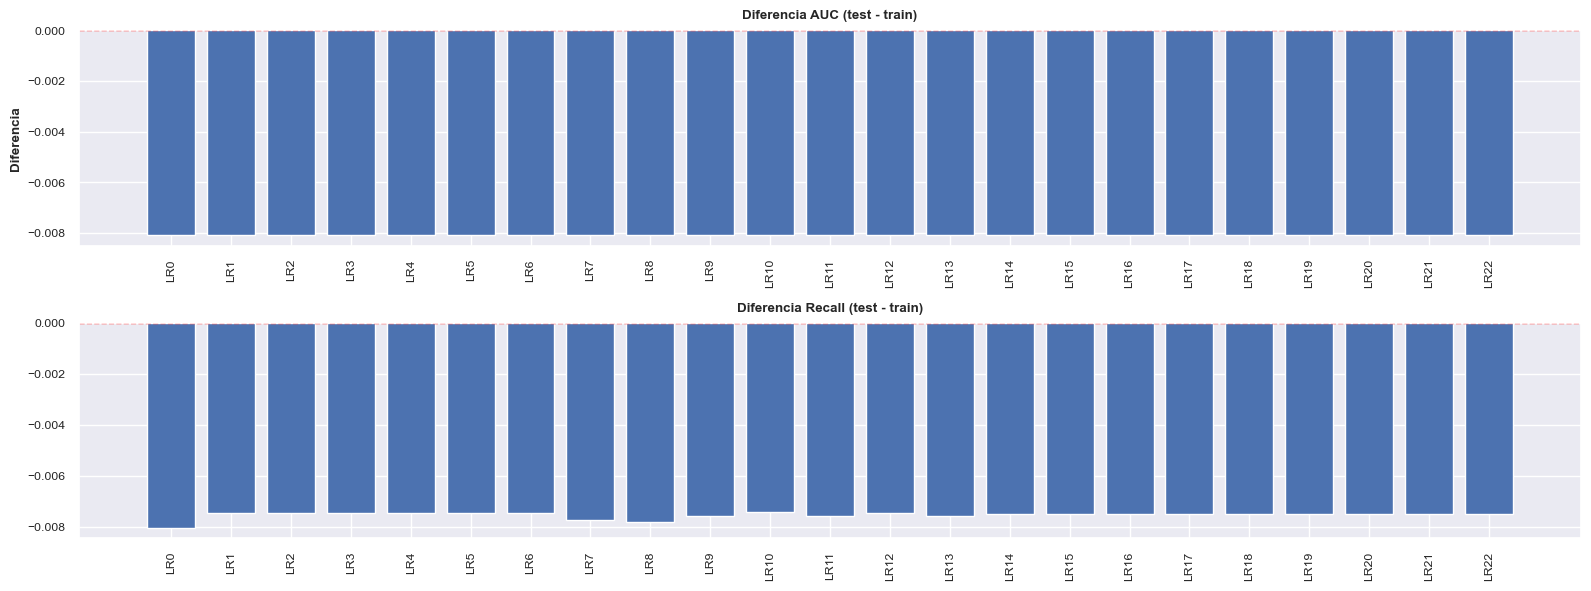

In [131]:
resultados_LR = plot_train_test_differences(modelos_lr, X_train_work, y_train_work, X_test_work, y_test_work)

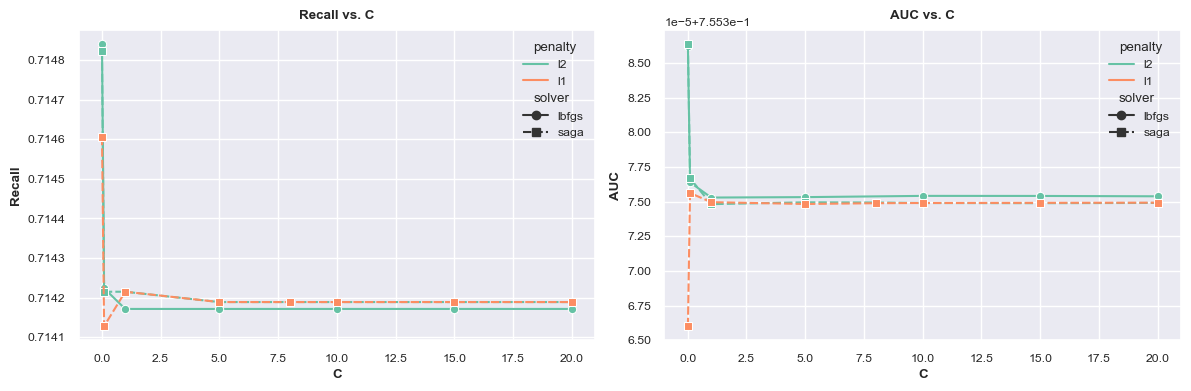

In [132]:
# Crear la figura para los dos gráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
results_lr['C_val'] = results_lr['params'].apply(lambda x: x['C'])
results_lr['penalty'] = results_lr['params'].apply(lambda x: x['penalty'])
results_lr['solver'] = results_lr['params'].apply(lambda x: x['solver'])

# Gráfico de Recall vs Número de Estimadores
sns.lineplot(data=results_lr, x='C_val', y='mean_test_recall', 
            hue='penalty', markers = ['o', 's'],
            style='solver', errorbar=None,     
            palette="Set2", ax=axes[0])
axes[0].set_title("Recall vs. C")
axes[0].set_xlabel("C")
axes[0].set_ylabel("Recall")

# Gráfico de AUC vs Número de Estimadores
sns.lineplot(data=results_lr, x='C_val', y='mean_test_roc_auc', 
            hue='penalty', markers = ['o', 's'],
            style='solver', errorbar=None,         
            palette="Set2", ax=axes[1])
axes[1].set_title("AUC vs. C")
axes[1].set_xlabel("C")
axes[1].set_ylabel("AUC")

# Ajuste de la disposición de los gráficos
plt.tight_layout()
plt.show()

In [133]:
# ¿Cual es el que selecciona el método (mejor AUC sin tener nada mas en cuenta)?
print('Los mejores parámetros según search:\n', grid_lr.best_params_)
print('El mejor modelo según search:\n', grid_lr.best_estimator_)

Los mejores parámetros según search:
 {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
El mejor modelo según search:
 LogisticRegression(C=0.01, class_weight='balanced', random_state=12345,
                   solver='saga')


In [134]:
results_lr[['params', 'mean_test_recall', 'mean_test_roc_auc']].sort_values(by='mean_test_roc_auc',ascending=False).head(10)

params  \
8    {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}   
0   {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}   
10    {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}   
1    {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}   
9     {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}   
4     {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}   
5     {'C': 15, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}   
6     {'C': 20, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}   
3      {'C': 5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}   
2      {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}   

    mean_test_recall  mean_test_roc_auc  
8           0.714823           0.755386  
0           0.714841           0.755386  
10          0.714215           0.755377  
1           0.714224           0.755376  
9           0.714128           0.755376  
4           0.714172           0.755375  
5           0.714172           0.755375  
6           0.714172           0.755375  
3           0.714172           0.755375  
2           0.714172           0.755375

In [135]:
results_lr[['params', 'mean_test_recall', 'mean_test_roc_auc']].sort_values(by='mean_test_recall',ascending=False).head(12)

params  \
0   {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}   
8    {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}   
7    {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}   
1    {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}   
12      {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}   
10    {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}   
11      {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}   
13      {'C': 5, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}   
14      {'C': 5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}   
15      {'C': 8, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}   
16      {'C': 8, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}   
17     {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}   

    mean_test_recall  mean_test_roc_auc  
0           0.714841           0.755386  
8           0.714823           0.755386  
7           0.714606           0.755366  
1           0.714224           0.755376  
12          0.714215           0.755375  
10          0.714215           0.755377  
11          0.714215           0.755375  
13          0.714189           0.755375  
14          0.714189           0.755375  
15          0.714189           0.755375  
16          0.714189           0.755375  
17          0.714189           0.755375

In [136]:
# C<1 la regulariazación es muy fuerte
# analizamos los boxplots
# se eligen los de mejor AUC y Accuracy
# teniendo en cuenta que no esten sobreentrenados
lista_lr = [2, 3, 4, 5, 6, 11, 12, 13, 14, 15] 
resultados_lr = []

# identificar modelos
for i in lista_lr:
    resultados_lr.append({
        "Modelo": f"Modelo{i}",
        "Parametros": results_lr.params.iloc[i],
        "Mean_Recall": results_lr['mean_test_recall'].iloc[i],
        "Std_Recall": results_lr['std_test_recall'].iloc[i],
        "Mean_AUC": results_lr['mean_test_roc_auc'].iloc[i],
        "Std_AUC": results_lr['std_test_roc_auc'].iloc[i]
    })

# Crear DataFrame
df_resultados_lr = pd.DataFrame(resultados_lr)
df_resultados_lr.sort_values(by="Std_AUC", ascending=True, inplace=True)
df_resultados_lr

Modelo  \
3   Modelo5   
4   Modelo6   
1   Modelo3   
2   Modelo4   
0   Modelo2   
6  Modelo12   
5  Modelo11   
9  Modelo15   
8  Modelo14   
7  Modelo13   

                                                                  Parametros  \
3  {'C': 15, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}   
4  {'C': 20, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}   
1   {'C': 5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}   
2  {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}   
0   {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}   
6    {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}   
5    {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}   
9    {'C': 8, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}   
8    {'C': 5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}   
7    {'C': 5, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}   

   Mean_Recall  Std_Recall  Mean_AUC   Std_AUC  
3     0.714172    0.002997  0.755375  0.002483  
4     0.714172    0.002997  0.755375  0.002483  
1     0.714172    0.002985  0.755375  0.002483  
2     0.714172    0.002997  0.755375  0.002483  
0     0.714172    0.002990  0.755375  0.002483  
6     0.714215    0.003074  0.755375  0.002483  
5     0.714215    0.003071  0.755375  0.002483  
9     0.714189    0.003088  0.755375  0.002483  
8     0.714189    0.003088  0.755375  0.002483  
7     0.714189    0.003088  0.755375  0.002483

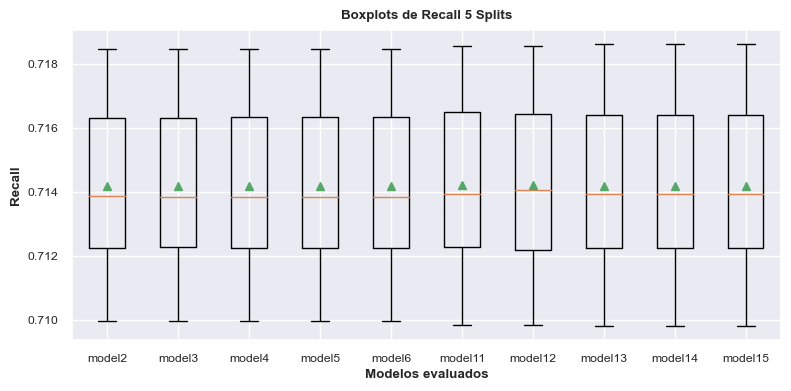

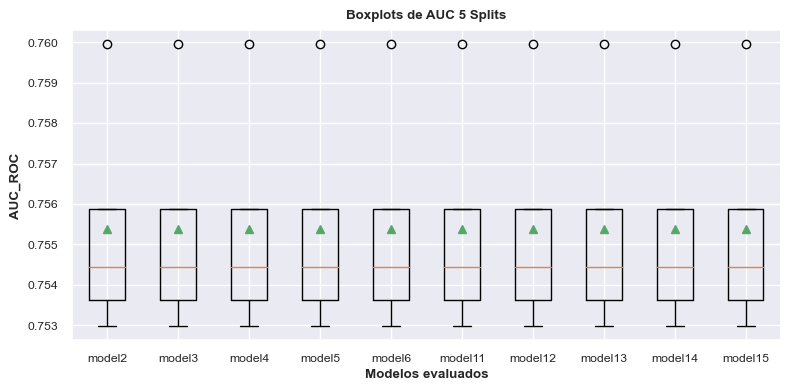

In [137]:
comparar_boxplot_cv5(results_lr, lista_lr)
comparar_boxplot_cv5_auc_roc(results_lr, lista_lr)

In [138]:
# ¿hay alguno de los seleccionados sobreentrenado con overfit?
modelos_lr = {}

# Entrenamiento 
for idx in lista_lr:
    # Instanciar modelo con parámetros del GridSearch
    modelo = LogisticRegression(**results_lr.iloc[idx].params, random_state=seed)
    modelo.fit(X_train_work, y_train_work)
    modelos_lr[f"LR{idx}"] = modelo

evaluar_modelos_train_test(modelos_lr, X_train_work, y_train_work, X_test_work, y_test_work)

AUC para cada modelo:
LR2 | AUC_Train: 0.7554 | AUC_Test: 0.7473 | Diferencia: -0.0081
LR3 | AUC_Train: 0.7554 | AUC_Test: 0.7473 | Diferencia: -0.0081
LR4 | AUC_Train: 0.7554 | AUC_Test: 0.7473 | Diferencia: -0.0081
LR5 | AUC_Train: 0.7554 | AUC_Test: 0.7473 | Diferencia: -0.0081
LR6 | AUC_Train: 0.7554 | AUC_Test: 0.7473 | Diferencia: -0.0081
LR11 | AUC_Train: 0.7554 | AUC_Test: 0.7473 | Diferencia: -0.0081
LR12 | AUC_Train: 0.7554 | AUC_Test: 0.7473 | Diferencia: -0.0081
LR13 | AUC_Train: 0.7554 | AUC_Test: 0.7473 | Diferencia: -0.0081
LR14 | AUC_Train: 0.7554 | AUC_Test: 0.7473 | Diferencia: -0.0081
LR15 | AUC_Train: 0.7554 | AUC_Test: 0.7473 | Diferencia: -0.0081

Recall para cada modelo:
LR2 | Recall_Train: 0.7143 | Recall_Test: 0.7068 | Diferencia: -0.0075
LR3 | Recall_Train: 0.7143 | Recall_Test: 0.7068 | Diferencia: -0.0075
LR4 | Recall_Train: 0.7143 | Recall_Test: 0.7068 | Diferencia: -0.0075
LR5 | Recall_Train: 0.7143 | Recall_Test: 0.7068 | Diferencia: -0.0075
LR6 | Recall_

In [139]:
# todos los modelos tienen exactamente aprox. el mismo Mean_AUC y prácticamente la misma Mean_Accuracy. 
# tanto en train como en test
# Esto significa que el rendimiento es prácticamente idéntico entre ellos.
# En este caso, conviene aplicar el principio de parsimonia: 
# elegir el modelo más simple y menos propenso a overfitting.
# ModeloLR2: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'} 	 
modelo_LR= LogisticRegression( C=1, penalty="l2",
                              solver= "lbfgs", 
                              random_state=seed,
                              class_weight='balanced')

modelo_LR.fit(X_train_work, y_train_work)

LogisticRegression(C=1, class_weight='balanced', random_state=12345)

----------Métricas para el modelo LR:----------

  Accuracy: 0.6777
  Recall:   0.7068
  AUC:      0.7473



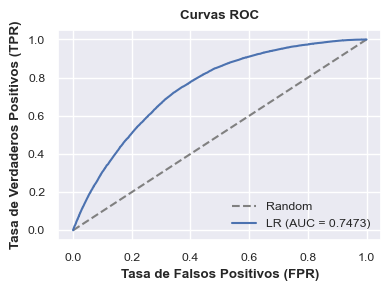


Matriz de confusion lineal. Pto de Corte=0.50


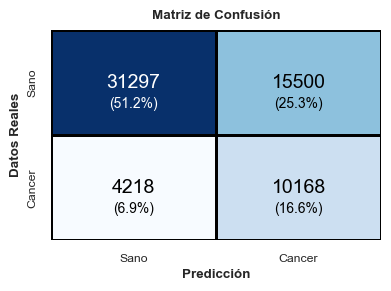


Informe de clasificación para LR:
              precision    recall  f1-score   support

           0       0.88      0.67      0.76     46797
           1       0.40      0.71      0.51     14386

    accuracy                           0.68     61183
   macro avg       0.64      0.69      0.63     61183
weighted avg       0.77      0.68      0.70     61183



In [140]:
#parametros de bondad de ajuste
evaluacion_test_modelo([(modelo_LR, 'LR')], X_test_work, y_test_work)

La curva ROC es una herramienta útil para evaluar la capacidad discriminativa de un modelo diagnóstico a la hora de distinguir entre individuos enfermos y sanos o predisposición a una enfermedad. Esta curva representa, para todos los posibles umbrales de decisión, la tasa de falsos positivos frente a la tasa de verdaderos positivos. La precisión global de un test diagnóstico se resume frecuentemente mediante el área bajo la curva (AUC). 

Por su parte, el índice de Youden (J) se emplea para seleccionar el punto de corte óptimo de probabilidad predicha, ya que corresponde a la máxima distancia vertical entre la curva ROC y la línea diagonal de no discriminación. Su interpretación consiste en maximizar la diferencia entre la tasa de verdaderos positivos (TPR o Sensibilidad, enfermos correctamente clasificados) y la de falsos positivos (FPR o "1-Especificidad", sanos correctamente clasificados), expresándose como $J= Sensibilidad + Especifidad - 1$. El umbral que maximiza el índice de Youden es aquel que permite clasificar correctamente al mayor número de sujetos. Este índice ha sido ampliamente aplicado en contextos estadísticos y clínicos. 

En este trabajo, los puntos de corte de cada modelo se han establecido calculando el valor máximo del índice de Youden.

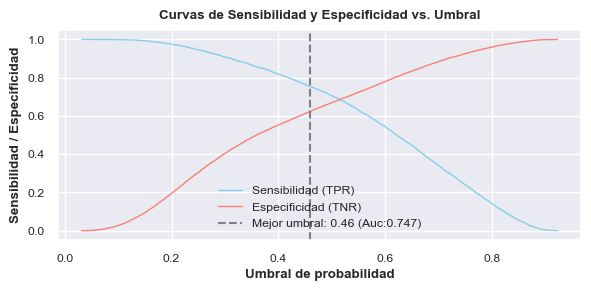

Mejor umbral según Youden para LR: 0.46


In [141]:
best_thresh_LR =youden(modelo_LR, X_test_work, y_test_work)
print(f"Mejor umbral según Youden para LR: {best_thresh_LR:.2f}")

----------Métricas para el modelo LR:----------

  Accuracy: 0.6552
  Recall:   0.7537
  AUC:      0.7473



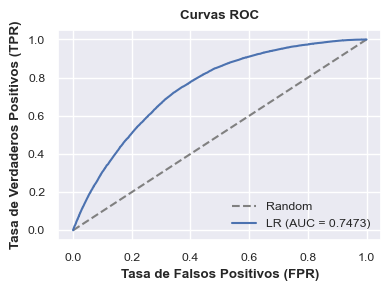


Matriz de confusion lineal. Pto de Corte=0.46


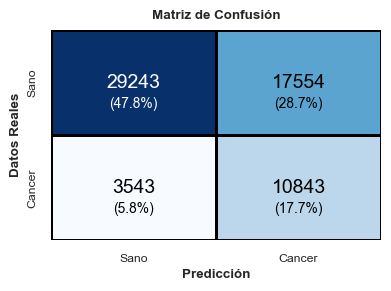


Informe de clasificación para LR:
              precision    recall  f1-score   support

           0       0.89      0.62      0.73     46797
           1       0.38      0.75      0.51     14386

    accuracy                           0.66     61183
   macro avg       0.64      0.69      0.62     61183
weighted avg       0.77      0.66      0.68     61183



In [142]:
evaluacion_test_modelo([(modelo_LR, 'LR')], 
                       X_test_work, y_test_work, best_thresh_LR)

<br>

### Random Forest

Random Forest es un algoritmo de aprendizaje supervisado basado en ensambles de árboles de decisión, desarrollado por Leo Breiman en 2001. Su funcionamiento se basa en entrenar múltiples árboles de decisión de manera independiente y aleatoria, combinando sus predicciones mediante votación (para clasificación) o promedio (para regresión). Esta estrategia permite reducir el riesgo de sobreajuste de un solo árbol y mejorar la capacidad de generalización del modelo. 

En contextos clínicos, como el presente estudio, RF ha demostrado un buen desempeño en la predicción de eventos raros o desequilibrados, alcanzando niveles de precisión y AUC superiores a otros modelos simples, gracias a su capacidad de manejar interacciones complejas entre variables y su robustez ante datos ruidosos. La precisión del modelo se determina mediante métricas como el AUC, accuracy, recall y F1-score, permitiendo evaluar tanto la capacidad de clasificación global como la sensibilidad hacia la clase minoritaria, crítica en entornos médicos.

Ventajas:
- Maneja variables mixtas (categóricas y continuas) sin necesidad de escalado.
- Es robusto ante valores atípicos y ruido, debido a la agregación de múltiples árboles.
- Random Forest es menos susceptible al sobreajuste en comparación con un solo árbol de decisión debido a la agregación de múltiples árboles.
- Manejo de Datos Faltantes: Puede gestionar datos faltantes sin necesidad de imputación adicional, ya que cada árbol puede utilizar diferentes subconjuntos de datos.

Desventajas:
- Es un modelo menos interpretable que un árbol único o una regresión logística, ya que las predicciones se derivan de un conjunto de árboles.
- Puede ser computacionalmente costoso para conjuntos de datos muy grandes, tanto en tiempo de entrenamiento como en memoria.

In [143]:
rf = RandomForestClassifier(random_state= seed)

param_grid_rf = {
    "bootstrap": [True] ,
    "n_estimators":  [100, 200, 300, 400],
    "max_depth": [5, 10, 20, 30],
    "min_samples_leaf": [2, 5, 10, 20],
   # "max_features": [0.6, 0.7, 0.8, 0.9, 1.0],
   # "max_samples": [0.6, 0.7, 0.9],
    "class_weight": ["balanced"]
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=cv5, 
                       scoring=scoring_metrics , 
                       refit="roc_auc", 
                       n_jobs=-1)

# entrenamos y se mide el tiempo del entrenamiento
start_time = time.time()
grid_rf.fit(X_train_work, y_train_work)
end_time = time.time() 

elapsed_time_rf = (end_time - start_time)/60
print(f"Tiempo de ejecución: {elapsed_time_rf:.2f} minutos")

Tiempo de ejecución: 44.65 minutos


In [144]:
# Obtener resultados del grid search
# todos los resultados obtenido en la validacion cruzada en un dataframe 
results_rf = pd.DataFrame(grid_rf.cv_results_)

print("Resultados de Grid Search:")
results_rf[['params', 'mean_test_recall', 'mean_test_roc_auc']].head(20)

Resultados de Grid Search:


params  \
0    {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 100}   
1    {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 200}   
2    {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 300}   
3    {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 400}   
4    {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}   
5    {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 200}   
6    {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 300}   
7    {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 400}   
8   {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100}   
9   {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200}   
10  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 300}   
11  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 400}   
12  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 20, 'n_estimators': 100}   
13  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 20, 'n_estimators': 200}   
14  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 20, 'n_estimators': 300}   
15  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 20, 'n_estimators': 400}   
16  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}   
17  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}   
18  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 300}   
19  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 400}   

    mean_test_recall  mean_test_roc_auc  
0           0.799374           0.790790  
1           0.798010           0.791204  
2           0.798966           0.791578  
3           0.799913           0.791459  
4           0.799392           0.790783  
5           0.798036           0.791194  
6           0.798975           0.791570  
7           0.799948           0.791453  
8           0.799088           0.790672  
9           0.797654           0.791137  
10          0.798897           0.791521  
11          0.799922           0.791419  
12          0.799122           0.790628  
13          0.797819           0.791139  
14          0.798940           0.791506  
15          0.799948           0.791406  
16          0.803519           0.818339  
17          0.801964           0.818275  
18          0.802059           0.818226  
19          0.802485           0.818227

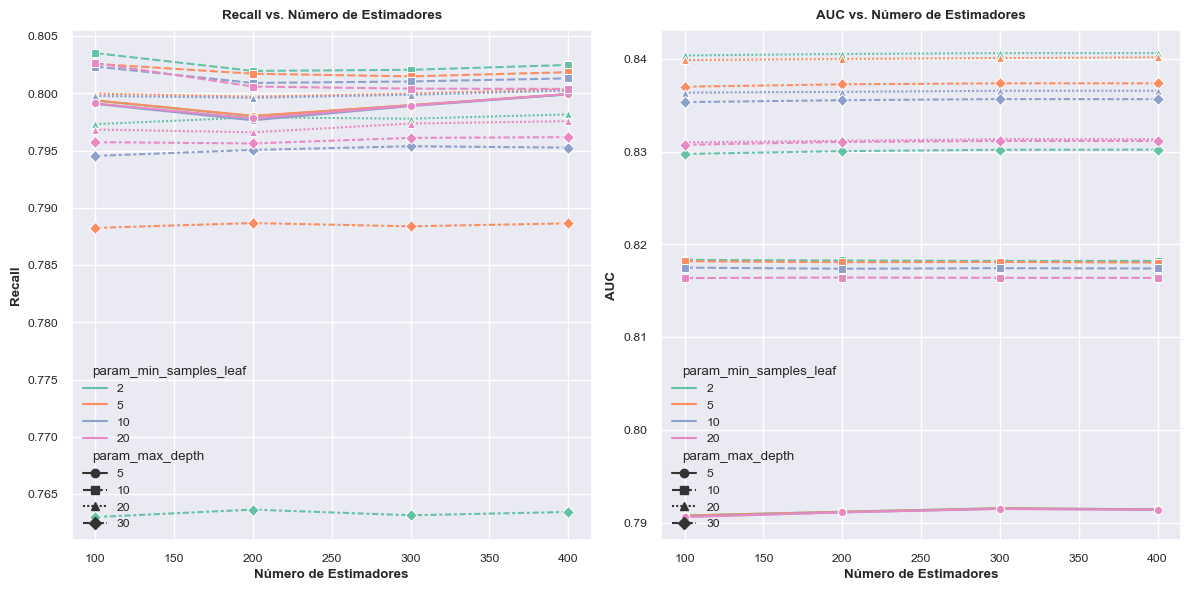

In [145]:
# Crear la figura para los dos gráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


# Gráfico de Recall vs Número de Estimadores
sns.lineplot(data=results_rf, x='param_n_estimators', y='mean_test_recall', 
            hue='param_min_samples_leaf', markers = ['o', 's', '^', 'D'],
            style='param_max_depth',  errorbar=None,     
            palette="Set2", ax=axes[0])
axes[0].set_title("Recall vs. Número de Estimadores")
axes[0].set_xlabel("Número de Estimadores")
axes[0].set_ylabel("Recall")

# Gráfico de AUC vs Número de Estimadores
sns.lineplot(data=results_rf, x='param_n_estimators', y='mean_test_roc_auc', 
               hue='param_min_samples_leaf', markers = ['o', 's', '^', 'D'],
               style='param_max_depth',  errorbar=None,     
               palette="Set2", ax=axes[1])
axes[1].set_title("AUC vs. Número de Estimadores")
axes[1].set_xlabel("Número de Estimadores")
axes[1].set_ylabel("AUC")

# Ajuste de la disposición de los gráficos
plt.tight_layout()
plt.show()

In [146]:
modelos_rf = {}

for idx in range(0, len(results_rf)):
    # Instanciar modelo con parámetros del GridSearch
    modelo = RandomForestClassifier(**results_rf.iloc[idx].params, random_state=seed)
    
    # Ajustar el modelo
    modelo.fit(X_train_work, y_train_work)
    
    # Guardar el modelo
    modelos_rf[f"RF{idx}"] = modelo

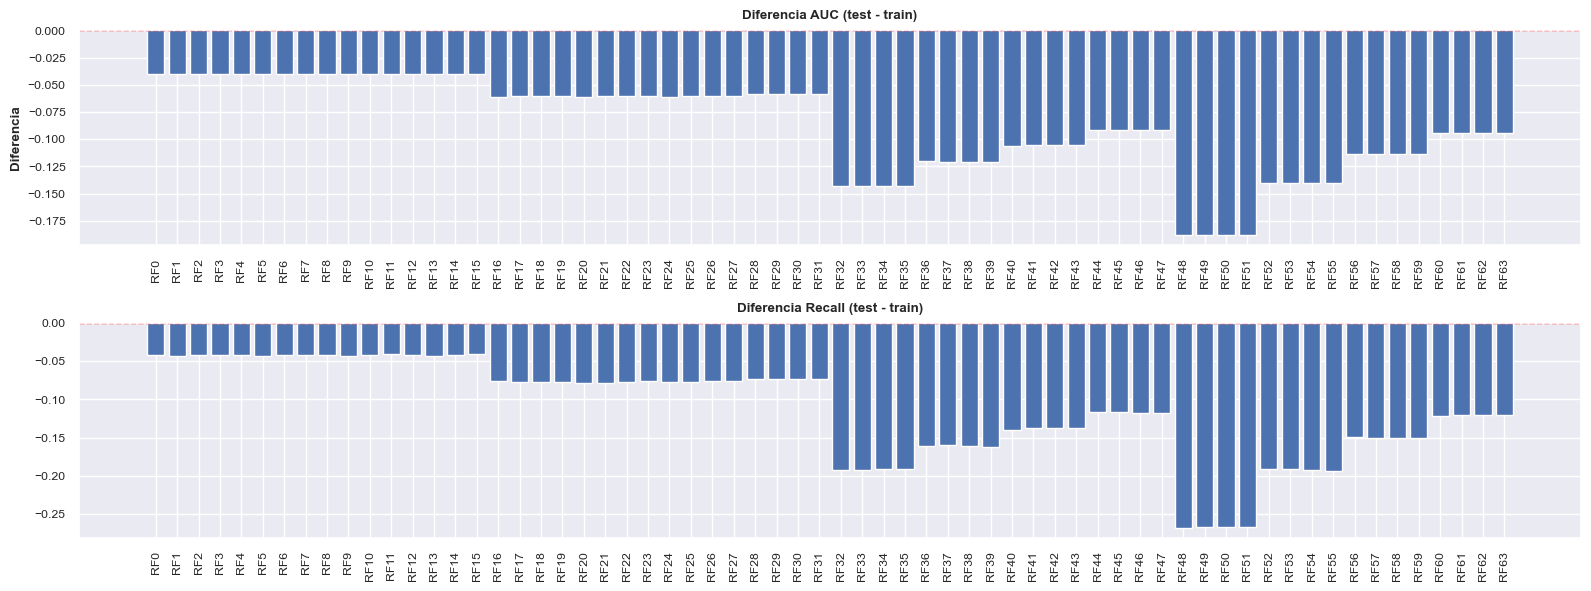

In [147]:
resultados_RF = plot_train_test_differences(modelos_rf, X_train_work, y_train_work, X_test_work, y_test_work)

In [148]:
# Una profundidad de 20 tiene mayor rendimiento en AUC
# pero en recall de 10
# y depth = 5 tiene menor overfit. Compensa
# El mínimo de muestras por hoja no muestra diferencias notables
# se escoge 10 por ser menos propenso al overfit
# no hay diferencias significativas con el numero de estimadores.
# Optamos por 100 estimadores 

#Probamos un nuevo grid
param_grid_rf = {
    "bootstrap": [True] ,
    "n_estimators":  [100],
    "max_depth": [5],
    "min_samples_leaf": [10],
    "max_features": [0.6, 0.7, 0.8, 0.9, 1.0],
    "max_samples": [0.6, 0.7, 0.8, 0.9, 1.0],
    "class_weight": ["balanced"]
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=cv5, 
                       scoring=scoring_metrics , 
                       refit="roc_auc", 
                       n_jobs=-1)

# entrenamos y se mide el tiempo del entrenamiento
start_time = time.time()
grid_rf.fit(X_train_work, y_train_work)
end_time = time.time() 

elapsed_time_rf = (end_time - start_time)/60
print(f"Tiempo de ejecución: {elapsed_time_rf:.2f} minutos")

Tiempo de ejecución: 7.75 minutos


In [149]:
# Obtener resultados del grid search
# todos los resultados obtenido en la validacion cruzada en un dataframe 
results_rf = pd.DataFrame(grid_rf.cv_results_)

print("Resultados de Grid Search:")
results_rf[['params', 'mean_test_recall', 'mean_test_roc_auc']].head()

Resultados de Grid Search:


params  \
0  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.6, 'max_samples': 0.6, 'min_samples_leaf': 10, 'n_estimators': 100}   
1  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.6, 'max_samples': 0.7, 'min_samples_leaf': 10, 'n_estimators': 100}   
2  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.6, 'max_samples': 0.8, 'min_samples_leaf': 10, 'n_estimators': 100}   
3  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.6, 'max_samples': 0.9, 'min_samples_leaf': 10, 'n_estimators': 100}   
4  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.6, 'max_samples': 1.0, 'min_samples_leaf': 10, 'n_estimators': 100}   

   mean_test_recall  mean_test_roc_auc  
0          0.808141           0.787934  
1          0.808576           0.787838  
2          0.808576           0.787985  
3          0.807968           0.787981  
4          0.807151           0.787863

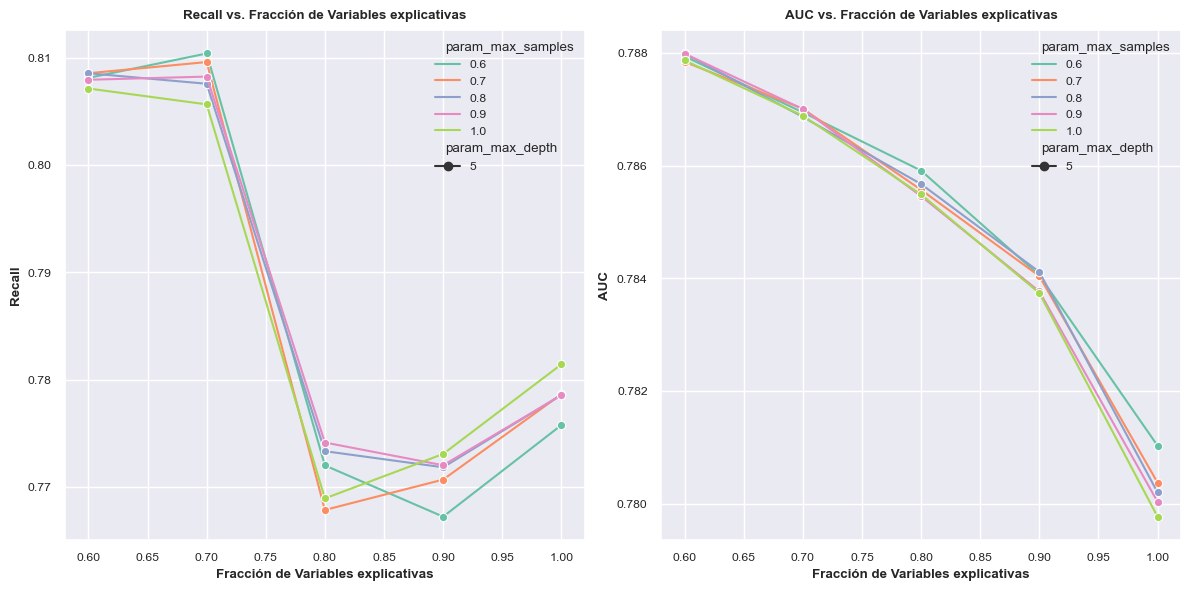

In [150]:
# Crear la figura para los dos gráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


# Gráfico de Recall vs Número de Estimadores
sns.lineplot(data=results_rf, x='param_max_features', y='mean_test_recall', 
            hue='param_max_samples', markers = ['o'],
            style='param_max_depth',  errorbar=None,     
            palette="Set2", ax=axes[0])
axes[0].set_title("Recall vs. Fracción de Variables explicativas")
axes[0].set_xlabel("Fracción de Variables explicativas")
axes[0].set_ylabel("Recall")

# Gráfico de AUC vs Número de Estimadores
sns.lineplot(data=results_rf, x='param_max_features', y='mean_test_roc_auc', 
               hue='param_max_samples', markers = ['o'],
               style='param_max_depth',  errorbar=None,     
               palette="Set2", ax=axes[1])
axes[1].set_title("AUC vs. Fracción de Variables explicativas")
axes[1].set_xlabel("Fracción de Variables explicativas")
axes[1].set_ylabel("AUC")

# Ajuste de la disposición de los gráficos
plt.tight_layout()
plt.show()

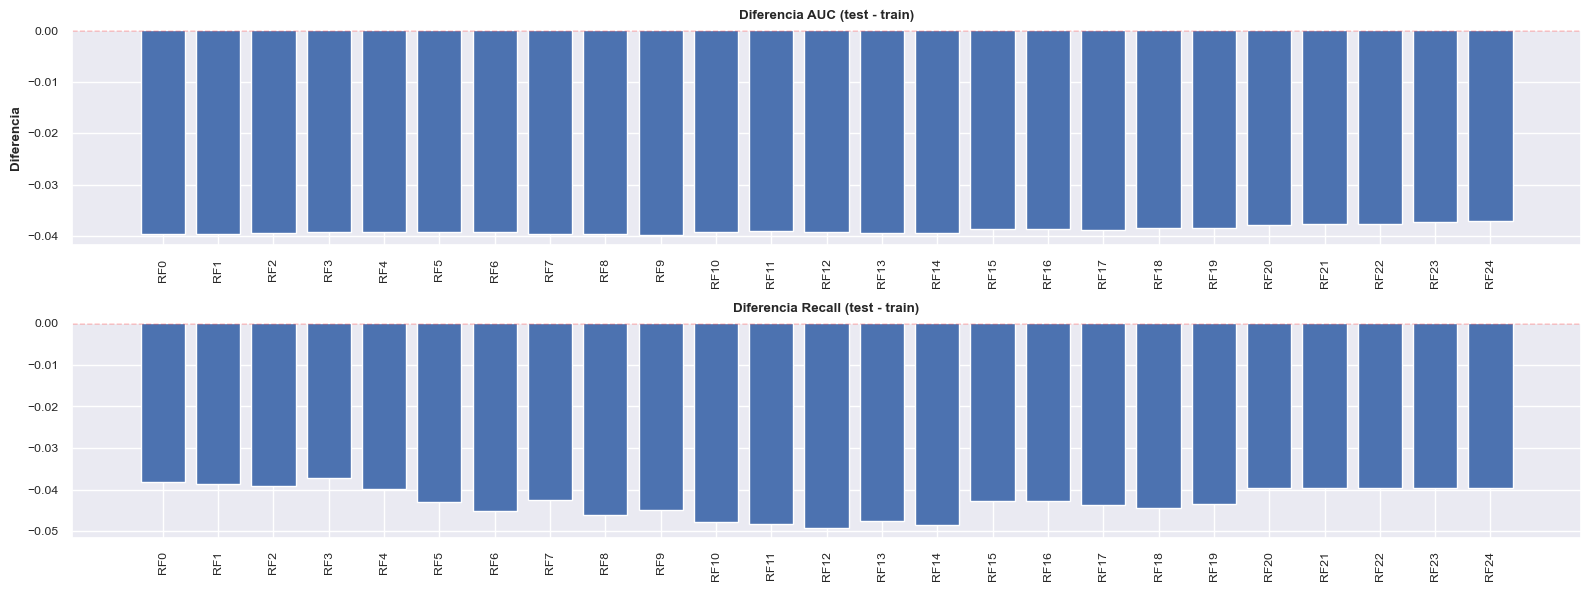

In [151]:
modelos_rf = {}

for idx in range(0, len(results_rf)):
    # Instanciar modelo con parámetros del GridSearch
    modelo = RandomForestClassifier(**results_rf.iloc[idx].params, random_state=seed)
    
    # Ajustar el modelo
    modelo.fit(X_train_work, y_train_work)
    
    # Guardar el modelo
    modelos_rf[f"RF{idx}"] = modelo

resultados_RF = plot_train_test_differences(modelos_rf, X_train_work, y_train_work, X_test_work, y_test_work)

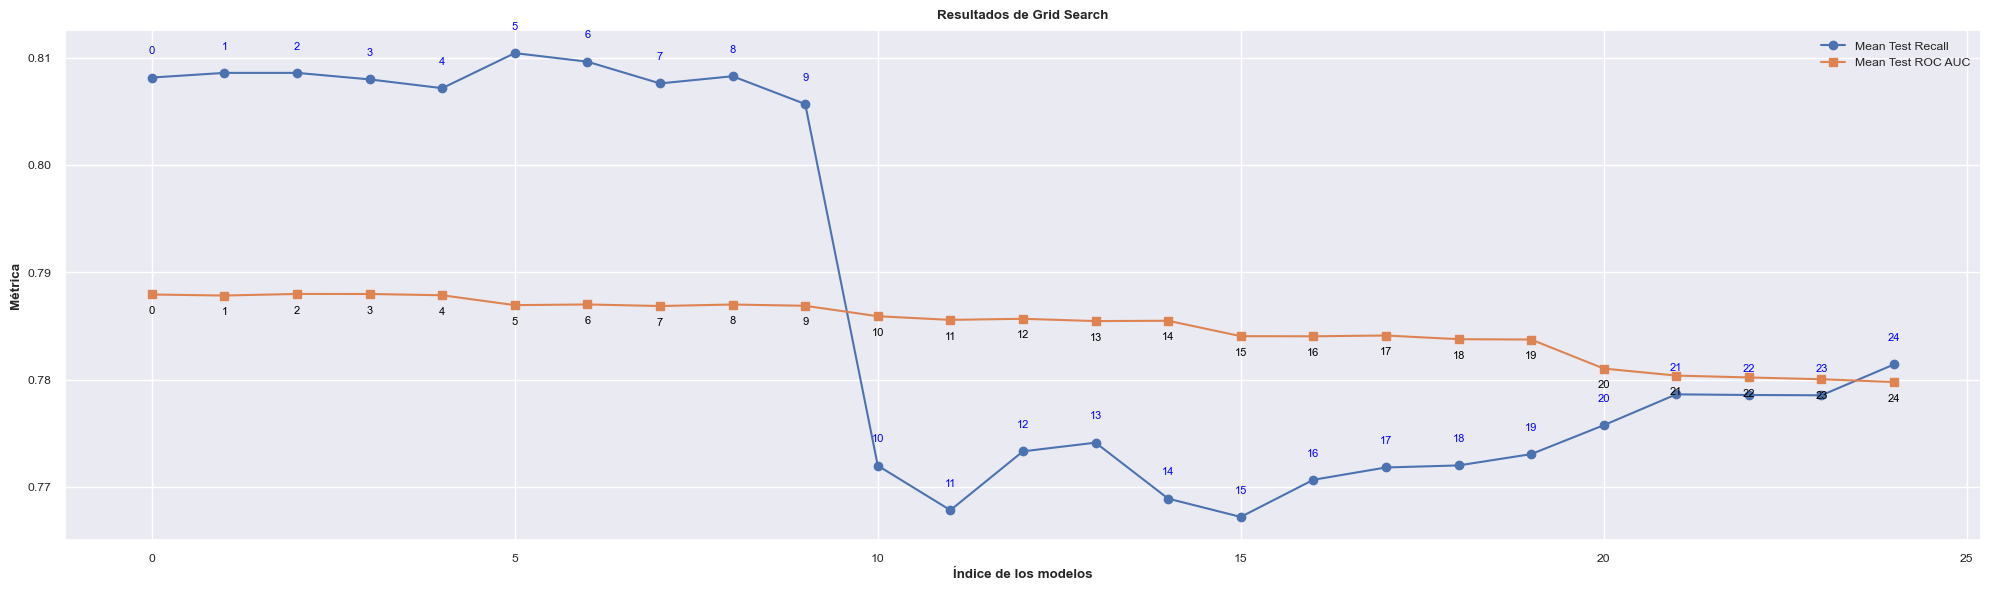

In [152]:
# Las m´tricas disminuyen con el número de variables
# 06-0.7% variables tienen las métricas más altas
# No hay mucho diferencia en rendimiento por samples
# no hay overfit notable
graficar_metricas_gridsearch(results_rf)

In [153]:
# ¿Cual es el que selecciona el método (mejor AUC sin tener nada mas en cuenta)?
print('Los mejores parámetros según search:\n', grid_rf.best_params_)
print('El mejor modelo según search:\n', grid_rf.best_estimator_)

Los mejores parámetros según search:
 {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.6, 'max_samples': 0.8, 'min_samples_leaf': 10, 'n_estimators': 100}
El mejor modelo según search:
 RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=0.6,
                       max_samples=0.8, min_samples_leaf=10,
                       random_state=12345)


In [154]:
results_rf[['params', 'mean_test_recall', 'mean_test_roc_auc']].sort_values(by='mean_test_recall',ascending=False).head()

params  \
5  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.7, 'max_samples': 0.6, 'min_samples_leaf': 10, 'n_estimators': 100}   
6  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.7, 'max_samples': 0.7, 'min_samples_leaf': 10, 'n_estimators': 100}   
1  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.6, 'max_samples': 0.7, 'min_samples_leaf': 10, 'n_estimators': 100}   
2  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.6, 'max_samples': 0.8, 'min_samples_leaf': 10, 'n_estimators': 100}   
8  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.7, 'max_samples': 0.9, 'min_samples_leaf': 10, 'n_estimators': 100}   

   mean_test_recall  mean_test_roc_auc  
5          0.810418           0.786942  
6          0.809619           0.787007  
1          0.808576           0.787838  
2          0.808576           0.787985  
8          0.808263           0.787001

In [155]:
results_rf[['params', 'mean_test_recall', 'mean_test_roc_auc']].sort_values(by='mean_test_roc_auc',ascending=False).head()

params  \
2  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.6, 'max_samples': 0.8, 'min_samples_leaf': 10, 'n_estimators': 100}   
3  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.6, 'max_samples': 0.9, 'min_samples_leaf': 10, 'n_estimators': 100}   
0  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.6, 'max_samples': 0.6, 'min_samples_leaf': 10, 'n_estimators': 100}   
4  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.6, 'max_samples': 1.0, 'min_samples_leaf': 10, 'n_estimators': 100}   
1  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.6, 'max_samples': 0.7, 'min_samples_leaf': 10, 'n_estimators': 100}   

   mean_test_recall  mean_test_roc_auc  
2          0.808576           0.787985  
3          0.807968           0.787981  
0          0.808141           0.787934  
4          0.807151           0.787863  
1          0.808576           0.787838

In [156]:
# analizamos los boxplots
# se eligen los de mejor AUC y Recall
# tambien los que menor overfit tienen en train-test
# teniendo en cuenta que no esten sobreentrenados
lista_rf = [0, 1, 2, 3, 4,5, 6, 7, 8, 9] 
resultados = []

# identificar modelos
for i in lista_rf:
    resultados.append({
        "Modelo": f"Modelo{i}",
        "Parametros": results_rf.params.iloc[i],
        "Mean_Recall": results_rf['mean_test_recall'].iloc[i],
        "Std_Recall": results_rf['std_test_recall'].iloc[i],
        "Mean_AUC": results_rf['mean_test_roc_auc'].iloc[i],
        "Std_AUC": results_rf['std_test_roc_auc'].iloc[i]
    })

# Crear DataFrame
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(by="Std_AUC", ascending=True, inplace=True)
df_resultados

Modelo  \
9  Modelo9   
2  Modelo2   
7  Modelo7   
1  Modelo1   
5  Modelo5   
3  Modelo3   
8  Modelo8   
0  Modelo0   
4  Modelo4   
6  Modelo6   

                                                                                                                                              Parametros  \
9  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.7, 'max_samples': 1.0, 'min_samples_leaf': 10, 'n_estimators': 100}   
2  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.6, 'max_samples': 0.8, 'min_samples_leaf': 10, 'n_estimators': 100}   
7  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.7, 'max_samples': 0.8, 'min_samples_leaf': 10, 'n_estimators': 100}   
1  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.6, 'max_samples': 0.7, 'min_samples_leaf': 10, 'n_estimators': 100}   
5  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.7, 'max_samples': 0.6, 'min_samples_leaf': 10, 'n_estimators': 100}   
3  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.6, 'max_samples': 0.9, 'min_samples_leaf': 10, 'n_estimators': 100}   
8  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.7, 'max_samples': 0.9, 'min_samples_leaf': 10, 'n_estimators': 100}   
0  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.6, 'max_samples': 0.6, 'min_samples_leaf': 10, 'n_estimators': 100}   
4  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.6, 'max_samples': 1.0, 'min_samples_leaf': 10, 'n_estimators': 100}   
6  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.7, 'max_samples': 0.7, 'min_samples_leaf': 10, 'n_estimators': 100}   

   Mean_Recall  Std_Recall  Mean_AUC   Std_AUC  
9     0.805674    0.005860  0.786882  0.002293  
2     0.808576    0.004687  0.787985  0.002310  
7     0.807594    0.008746  0.786861  0.002352  
1     0.808576    0.004334  0.787838  0.002362  
5     0.810418    0.006104  0.786942  0.002384  
3     0.807968    0.003752  0.787981  0.002412  
8     0.808263    0.011047  0.787001  0.002419  
0     0.808141    0.003745  0.787934  0.002437  
4     0.807151    0.003480  0.787863  0.002481  
6     0.809619    0.004639  0.787007  0.002485

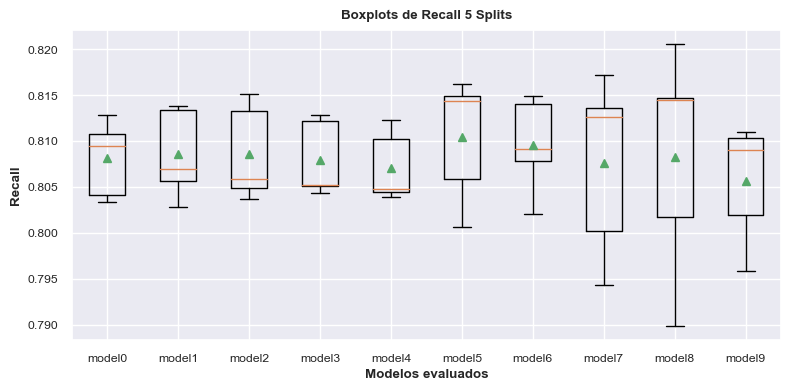

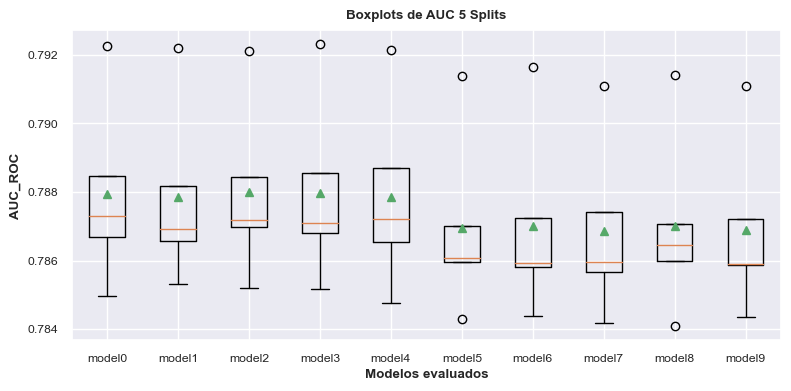

In [157]:
comparar_boxplot_cv5(results_rf, lista_rf)
comparar_boxplot_cv5_auc_roc(results_rf, lista_rf)

In [158]:
# ¿hay alguno de los seleccionados sobreentrenado con overfit?

# Diccionarios para guardar los modelos y sus predicciones
modelos_rf = {}

# Entrenamiento 
for idx in lista_rf:
    modelo = RandomForestClassifier(**results_rf.iloc[idx].params, random_state=seed)
    modelo.fit(X_train_work, y_train_work)
    modelos_rf[f"RF{idx}"] = modelo

evaluar_modelos_train_test(modelos_rf, X_train_work, y_train_work, X_test_work, y_test_work)

AUC para cada modelo:
RF0 | AUC_Train: 0.7885 | AUC_Test: 0.7490 | Diferencia: -0.0395
RF1 | AUC_Train: 0.7887 | AUC_Test: 0.7491 | Diferencia: -0.0396
RF2 | AUC_Train: 0.7883 | AUC_Test: 0.7490 | Diferencia: -0.0393
RF3 | AUC_Train: 0.7881 | AUC_Test: 0.7489 | Diferencia: -0.0392
RF4 | AUC_Train: 0.7882 | AUC_Test: 0.7490 | Diferencia: -0.0392
RF5 | AUC_Train: 0.7874 | AUC_Test: 0.7482 | Diferencia: -0.0392
RF6 | AUC_Train: 0.7876 | AUC_Test: 0.7483 | Diferencia: -0.0393
RF7 | AUC_Train: 0.7878 | AUC_Test: 0.7483 | Diferencia: -0.0395
RF8 | AUC_Train: 0.7879 | AUC_Test: 0.7483 | Diferencia: -0.0395
RF9 | AUC_Train: 0.7876 | AUC_Test: 0.7479 | Diferencia: -0.0397

Recall para cada modelo:
RF0 | Recall_Train: 0.8076 | Recall_Test: 0.7695 | Diferencia: -0.0381
RF1 | Recall_Train: 0.8067 | Recall_Test: 0.7680 | Diferencia: -0.0387
RF2 | Recall_Train: 0.8077 | Recall_Test: 0.7686 | Diferencia: -0.0391
RF3 | Recall_Train: 0.8047 | Recall_Test: 0.7675 | Diferencia: -0.0372
RF4 | Recall_Train

In [159]:
# RF5-RF9 registran mayor diff train-test en recall, se descartan
# RF0–RF4 son casi idénticos en términos de rendimiento.
# RF1 es el modelo mas sencillo, más robusto con un recall elevado
modelo_RF= RandomForestClassifier( bootstrap=True, class_weight="balanced",  
                                  n_estimators=100, max_depth=5, 
                                  max_features=0.6, max_samples=0.7, 
                                  min_samples_leaf=10, random_state=seed)

modelo_RF.fit(X_train_work, y_train_work) 	

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=0.6,
                       max_samples=0.7, min_samples_leaf=10,
                       random_state=12345)

----------Métricas para el modelo RF:----------

  Accuracy: 0.6458
  Recall:   0.7680
  AUC:      0.7491



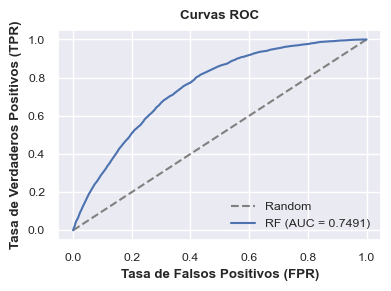


Matriz de confusion lineal. Pto de Corte=0.50


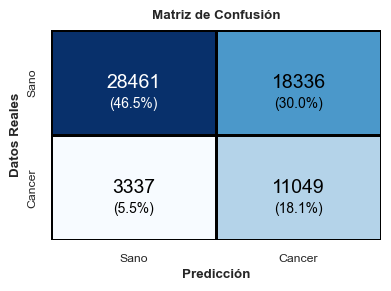


Informe de clasificación para RF:
              precision    recall  f1-score   support

           0       0.90      0.61      0.72     46797
           1       0.38      0.77      0.50     14386

    accuracy                           0.65     61183
   macro avg       0.64      0.69      0.61     61183
weighted avg       0.77      0.65      0.67     61183



In [160]:
# parametros de bondad de ajuste
evaluacion_test_modelo([(modelo_RF, 'RF')], X_test_work, y_test_work)

Con un umbral de 0.5 de probabilidad ( por defecto):   
- Se observa que 77% de los casos reales de cancer (recall clase 1) fueron detectados, lo que en problemas críticos es muy valioso. Lo que indica que el modelo logra captar la mayoría de los casos reales de la clase minoritaria,
- La precisión de la clase 1 es baja (0.39), se detectan muchos falsos positivos. No es muy crítico.

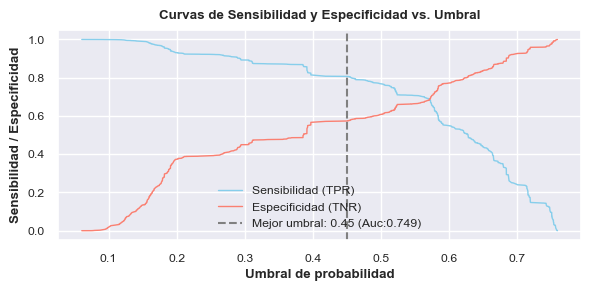

Mejor umbral según Youden para RF: 0.45


In [161]:
best_thresh_RF =youden(modelo_RF, X_test_work, y_test_work)
print(f"Mejor umbral según Youden para RF: {best_thresh_RF:.2f}")

----------Métricas para el modelo RF:----------

  Accuracy: 0.6285
  Recall:   0.8070
  AUC:      0.7491



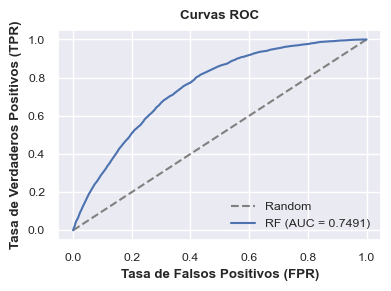


Matriz de confusion lineal. Pto de Corte=0.45


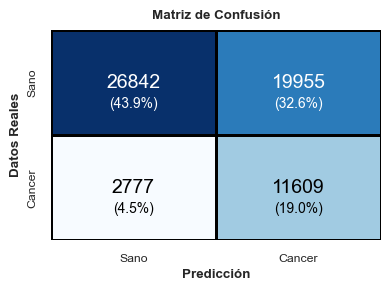


Informe de clasificación para RF:
              precision    recall  f1-score   support

           0       0.91      0.57      0.70     46797
           1       0.37      0.81      0.51     14386

    accuracy                           0.63     61183
   macro avg       0.64      0.69      0.60     61183
weighted avg       0.78      0.63      0.66     61183



In [162]:
# parametros de bondad de ajuste con Youden
evaluacion_test_modelo([(modelo_RF, 'RF')], 
                       X_test_work, y_test_work, best_thresh_RF)

### XGBoost

XGBoost (Extreme Gradient Boosting) es una técnica de boosting basada en árboles de decisión que ha ganado popularidad por su alto rendimiento en competiciones de Machine Learning y su eficiencia computacional. Desarrollado por Tianqi Chen, XGBoost optimiza el método de gradient boosting al incorporar técnicas avanzadas que mejoran tanto la velocidad como la precisión del modelo. XGBoost construye árboles de forma secuencial, donde cada nuevo árbol corrige los errores residuales del modelo anterior. Utiliza un enfoque de optimización basado en el descenso del gradiente para ajustar los árboles, lo que permite mejorar el rendimiento del modelo iterativamente. Incluye términos de regularización L1 y L2 en la función objetivo para controlar el sobreajuste. Esto proporciona mayor flexibilidad y control sobre el ajuste del modelo, contribuyendo a un mejor rendimiento general.  Emplea técnicas avanzadas como el approximate tree learning y histogram-based algorithms para acelerar el proceso de entrenamiento y reducir el uso de memoria.

Ventajas:
- Rendimiento Superior: Gracias a la combinación de boosting y regularización, XGBoost suele superar a modelos simples en AUC y accuracy.
- Capacidad para modelar relaciones complejas: Captura interacciones no lineales y patrones complejos entre variables.
- Eficiencia: Es rápido en el entrenamiento y la predicción, y maneja eficazmente conjuntos de datos grandes y características de alta dimensión.

Desventajas:
- Interpretabilidad limitada: Comparado con modelos lineales o un solo árbol de decisión, es más difícil interpretar cómo cada variable afecta la predicción.
- Sensibilidad a hiperparámetros: Requiere ajuste cuidadoso de parámetros como learning rate, max_depth o n_estimators.
- Computacionalmente más costoso: Aunque es eficiente, puede ser más lento que modelos simples en datasets muy grandes si no se optimiza.

Explicación hiperparámetros: https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d

In [163]:
xgb = XGBClassifier(random_state=seed)

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, 15, 20],
    'min_child_weight': [1, 3, 5, 10, 15],
    #'gamma': [0.1, 0.5, 1] # reducción de pérdida
    #'learning_rate': [0.01, 0.1, 0.3]
    #'subsample': [0.6, 0.8, 1.0], #% rows
    #'colsample_bytree': [0.6, 0.8, 1.0], #%features 
}

grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=cv5, 
                        scoring=scoring_metrics , 
                        refit='roc_auc', 
                        n_jobs=-1)

start_time = time.time()
grid_xgb.fit(X_train_work, y_train_work)
end_time = time.time() 

elapsed_time_xgb = (end_time - start_time)/60
print(f"Tiempo de ejecución: {elapsed_time_xgb:.2f} minutos")

Tiempo de ejecución: 22.50 minutos


In [164]:
results_xgb = pd.DataFrame(grid_xgb.cv_results_)
print("Resultados de Grid Search:")
results_xgb[['params', 'mean_test_recall', 'mean_test_roc_auc']].head(20)

Resultados de Grid Search:


params  \
0    {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}   
1    {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}   
2    {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}   
3    {'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100}   
4    {'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200}   
5    {'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300}   
6    {'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100}   
7    {'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200}   
8    {'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300}   
9   {'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100}   
10  {'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 200}   
11  {'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 300}   
12  {'max_depth': 3, 'min_child_weight': 15, 'n_estimators': 100}   
13  {'max_depth': 3, 'min_child_weight': 15, 'n_estimators': 200}   
14  {'max_depth': 3, 'min_child_weight': 15, 'n_estimators': 300}   
15   {'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100}   
16   {'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200}   
17   {'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300}   
18   {'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100}   
19   {'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200}   

    mean_test_recall  mean_test_roc_auc  
0           0.774689           0.853587  
1           0.760692           0.856031  
2           0.759684           0.856479  
3           0.774689           0.853587  
4           0.760726           0.856040  
5           0.759762           0.856495  
6           0.774941           0.853575  
7           0.761256           0.856078  
8           0.760500           0.856612  
9           0.773351           0.853653  
10          0.761986           0.856058  
11          0.761752           0.856655  
12          0.773621           0.853779  
13          0.762091           0.856114  
14          0.762386           0.856703  
15          0.768086           0.857407  
16          0.764480           0.857849  
17          0.764463           0.857636  
18          0.768911           0.857360  
19          0.764654           0.857764

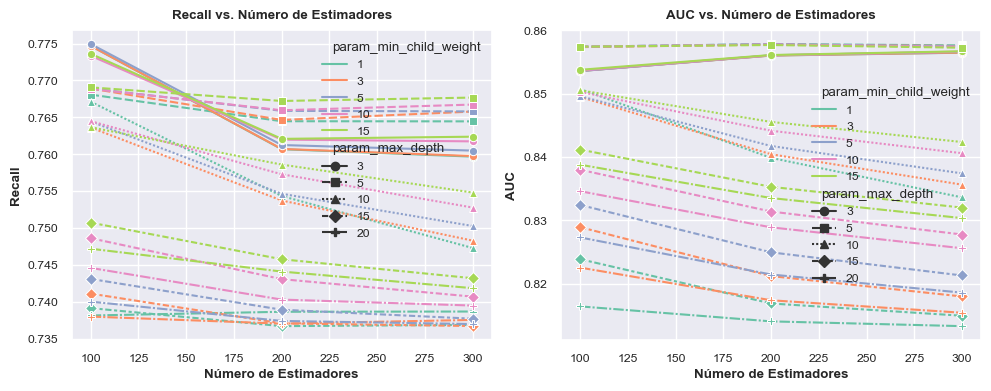

In [165]:
# Crear la figura para los dos gráficos
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Gráfico de recall vs Número de Estimadores
sns.lineplot(data=results_xgb, x='param_n_estimators', y='mean_test_recall', 
            hue='param_min_child_weight', markers = ['o', 's', '^', 'D', 'P'],
            style='param_max_depth',  errorbar=None,     
            palette="Set2", ax=axes[0])
axes[0].set_title("Recall vs. Número de Estimadores")
axes[0].set_xlabel("Número de Estimadores")
axes[0].set_ylabel("Recall")

# Gráfico de AUC vs Número de Estimadores
sns.lineplot(data=results_xgb, x='param_n_estimators', y='mean_test_roc_auc', 
               hue='param_min_child_weight', markers = ['o', 's', '^', 'D', 'P'],
               style='param_max_depth',  errorbar=None,     
               palette="Set2", ax=axes[1])
axes[1].set_title("AUC vs. Número de Estimadores")
axes[1].set_xlabel("Número de Estimadores")
axes[1].set_ylabel("AUC")

# Ajuste de la disposición de los gráficos
plt.tight_layout()
plt.show()

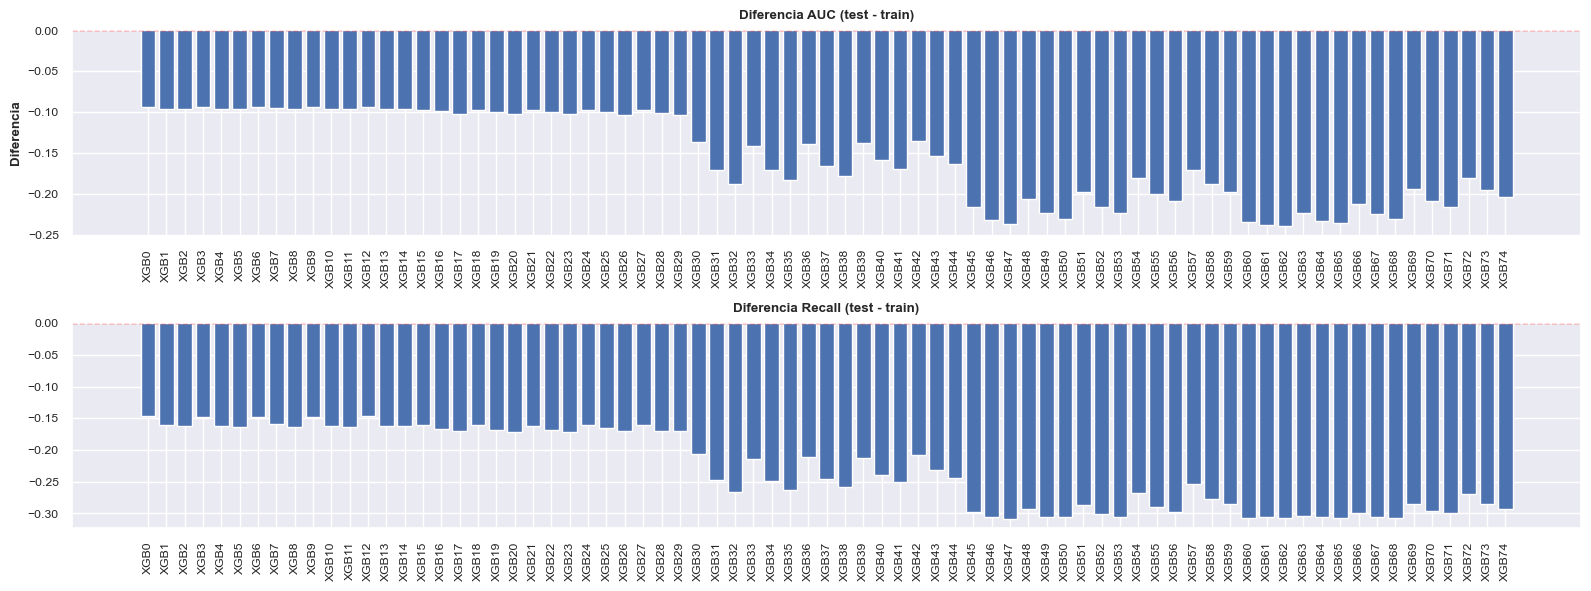

In [166]:
modelos_xgb = {}

for idx in range(0, len(results_xgb)):
    modelo = XGBClassifier(**results_xgb.iloc[idx].params, random_state=seed)
    modelo.fit(X_train_work, y_train_work)
    modelos_xgb[f"XGB{idx}"] = modelo
    
resultados_XGB = plot_train_test_differences(modelos_xgb, X_train_work, y_train_work, X_test_work, y_test_work)

In [167]:
# la profundidad optima se encuentra entorno a 5
# accuracy y AUC disminuyen  con el numero de estimadores
# salvo para profundidad optima.
# por parsimona optamos por 100 estimadores

xgb = XGBClassifier(random_state=seed)

param_grid_xgb = {
    'n_estimators': [100],
    'max_depth': [5],
    'min_child_weight': [1, 5, 10, 15, 20],
    'eta': [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3] , # peso de las variables
    'gamma': [0.1, 0.5, 1, 1.5] # reducción de pérdida
    #'subsample': [0.6, 0.8, 1.0], #% rows
    #'colsample_bytree': [0.6, 0.8, 1.0], #%features 
}

grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=cv5, 
                        scoring=scoring_metrics , 
                        refit='roc_auc', 
                        n_jobs=-1)

start_time = time.time()
grid_xgb.fit(X_train_work, y_train_work)
end_time = time.time() 

elapsed_time_xgb = (end_time - start_time)/60
print(f"Tiempo de ejecución: {elapsed_time_xgb:.2f} minutos")

Tiempo de ejecución: 5.47 minutos


In [168]:
results_xgb = pd.DataFrame(grid_xgb.cv_results_)
print("Resultados de Grid Search:")
results_xgb[['params', 'mean_test_recall', 'mean_test_roc_auc']].head(28)

Resultados de Grid Search:


params  \
0    {'eta': 0.01, 'gamma': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100}   
1    {'eta': 0.01, 'gamma': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100}   
2   {'eta': 0.01, 'gamma': 0.1, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100}   
3   {'eta': 0.01, 'gamma': 0.1, 'max_depth': 5, 'min_child_weight': 15, 'n_estimators': 100}   
4   {'eta': 0.01, 'gamma': 0.1, 'max_depth': 5, 'min_child_weight': 20, 'n_estimators': 100}   
5    {'eta': 0.01, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100}   
6    {'eta': 0.01, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100}   
7   {'eta': 0.01, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100}   
8   {'eta': 0.01, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 15, 'n_estimators': 100}   
9   {'eta': 0.01, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 20, 'n_estimators': 100}   
10     {'eta': 0.01, 'gamma': 1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100}   
11     {'eta': 0.01, 'gamma': 1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100}   
12    {'eta': 0.01, 'gamma': 1, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100}   
13    {'eta': 0.01, 'gamma': 1, 'max_depth': 5, 'min_child_weight': 15, 'n_estimators': 100}   
14    {'eta': 0.01, 'gamma': 1, 'max_depth': 5, 'min_child_weight': 20, 'n_estimators': 100}   
15   {'eta': 0.01, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100}   
16   {'eta': 0.01, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100}   
17  {'eta': 0.01, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100}   
18  {'eta': 0.01, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 15, 'n_estimators': 100}   
19  {'eta': 0.01, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 20, 'n_estimators': 100}   
20   {'eta': 0.02, 'gamma': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100}   
21   {'eta': 0.02, 'gamma': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100}   
22  {'eta': 0.02, 'gamma': 0.1, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100}   
23  {'eta': 0.02, 'gamma': 0.1, 'max_depth': 5, 'min_child_weight': 15, 'n_estimators': 100}   
24  {'eta': 0.02, 'gamma': 0.1, 'max_depth': 5, 'min_child_weight': 20, 'n_estimators': 100}   
25   {'eta': 0.02, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100}   
26   {'eta': 0.02, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100}   
27  {'eta': 0.02, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100}   

    mean_test_recall  mean_test_roc_auc  
0           0.797141           0.788418  
1           0.797237           0.788388  
2           0.797550           0.788373  
3           0.797619           0.788323  
4           0.797724           0.788309  
5           0.797141           0.788420  
6           0.797237           0.788388  
7           0.797550           0.788373  
8           0.797619           0.788324  
9           0.797724           0.788309  
10          0.797141           0.788420  
11          0.797237           0.788388  
12          0.797550           0.788373  
13          0.797619           0.788324  
14          0.797724           0.788310  
15          0.797141           0.788420  
16          0.797237           0.788388  
17          0.797550           0.788373  
18          0.797619           0.788324  
19          0.797724           0.788310  
20          0.807125           0.798996  
21          0.806986           0.798970  
22          0.807186           0.798950  
23          0.806751           0.798825  
24          0.806786           0.798773  
25          0.806621           0.798998  
26          0.806968           0.798957  
27          0.807186           0.798941

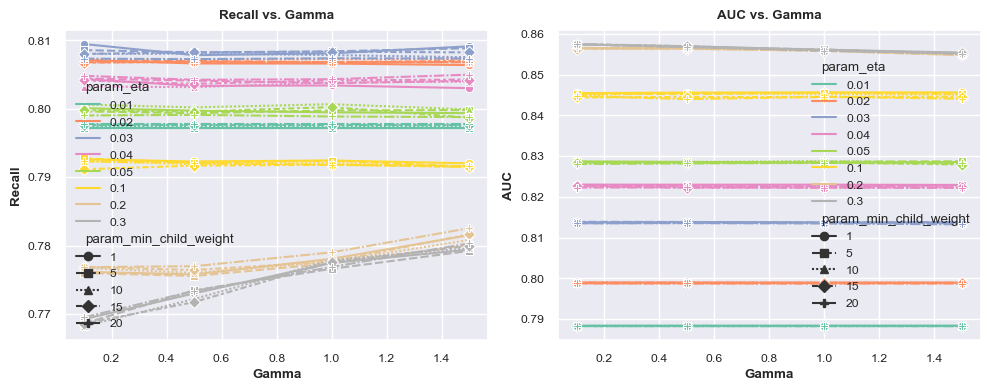

In [169]:
# Crear la figura para los dos gráficos
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Gráfico de Recall vs Número de Estimadores
sns.lineplot(data=results_xgb, x='param_gamma', y='mean_test_recall', 
            hue='param_eta', markers = ['o', 's', '^', 'D', 'P'],
            style ='param_min_child_weight', errorbar=None,     
            palette="Set2", ax=axes[0])
axes[0].set_title("Recall vs. Gamma")
axes[0].set_xlabel("Gamma")
axes[0].set_ylabel("Recall")

# Gráfico de AUC vs Número de Estimadores
sns.lineplot(data=results_xgb, x='param_gamma', y='mean_test_roc_auc', 
               hue='param_eta', markers = ['o', 's', '^', 'D', 'P'],
               style='param_min_child_weight', errorbar=None,     
               palette="Set2", ax=axes[1])
axes[1].set_title("AUC vs. Gamma")
axes[1].set_xlabel("Gamma")
axes[1].set_ylabel("AUC")

# Ajuste de la disposición de los gráficos
plt.tight_layout()
plt.show()

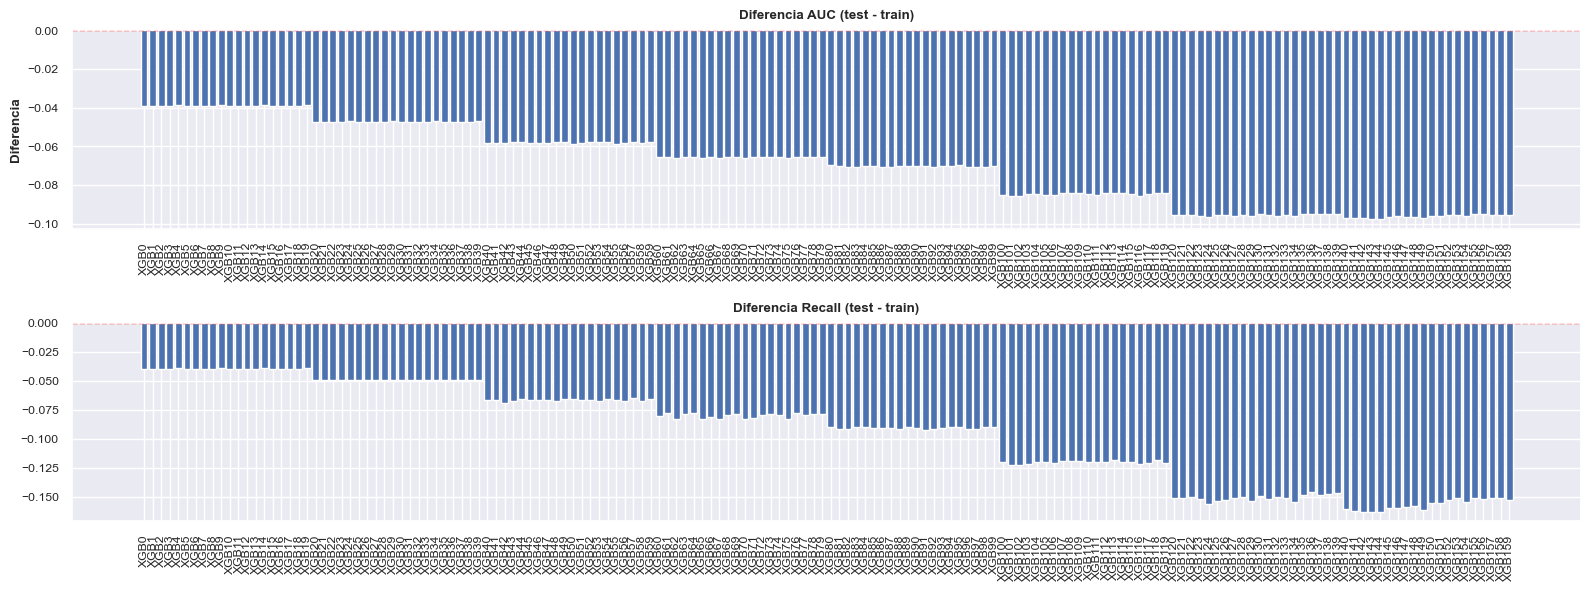

In [170]:
modelos_xgb = {}

for idx in range(0, len(results_xgb)):
    modelo = XGBClassifier(**results_xgb.iloc[idx].params, random_state=seed)
    modelo.fit(X_train_work, y_train_work)
    modelos_xgb[f"XGB{idx}"] = modelo
    
resultados_XGB = plot_train_test_differences(modelos_xgb, X_train_work, y_train_work, X_test_work, y_test_work)

In [171]:
# practicament eno hay diferencia para gamma
# gama 0.1 por pasimonia
# 0.3 y 0.2 de etha tienen los mejores resultados en AUC
# 0.03 y 0.02 en recall
# pero esta sobreentrenado en auc
# 0.02  menor overfit en AUC y mayor recall
xgb = XGBClassifier(random_state=seed)

param_grid_xgb = {
    'n_estimators': [100],
    'max_depth': [5],
    'min_child_weight': [1, 3, 5, 10, 15],
    'eta': [0.01] , # peso de las variables
    'gamma': [0.2], # reducción de pérdida
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], #% rows
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], #%features 
}

grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=cv5, 
                        scoring=scoring_metrics , 
                        refit='roc_auc', 
                        n_jobs=-1)

start_time = time.time()
grid_xgb.fit(X_train_work, y_train_work)
end_time = time.time() 

elapsed_time_xgb = (end_time - start_time)/60
print(f"Tiempo de ejecución: {elapsed_time_xgb:.2f} minutos")

Tiempo de ejecución: 4.50 minutos


In [172]:
results_xgb = pd.DataFrame(grid_xgb.cv_results_)
print("Resultados de Grid Search:")
results_xgb[['params', 'mean_test_recall', 'mean_test_roc_auc']].head(30)

Resultados de Grid Search:


params  \
0    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}   
1    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}   
2    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}   
3    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}   
4    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}   
5    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.6}   
6    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7}   
7    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}   
8    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}   
9    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}   
10   {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.6}   
11   {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.7}   
12   {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}   
13   {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}   
14   {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}   
15  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.6}   
16  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.7}   
17  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.8}   
18  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}   
19  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 1.0}   
20  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 15, 'n_estimators': 100, 'subsample': 0.6}   
21  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 15, 'n_estimators': 100, 'subsample': 0.7}   
22  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 15, 'n_estimators': 100, 'subsample': 0.8}   
23  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 15, 'n_estimators': 100, 'subsample': 0.9}   
24  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 15, 'n_estimators': 100, 'subsample': 1.0}   
25   {'colsample_bytree': 0.7, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}   
26   {'colsample_bytree': 0.7, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}   
27   {'colsample_bytree': 0.7, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}   
28   {'colsample_bytree': 0.7, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, '

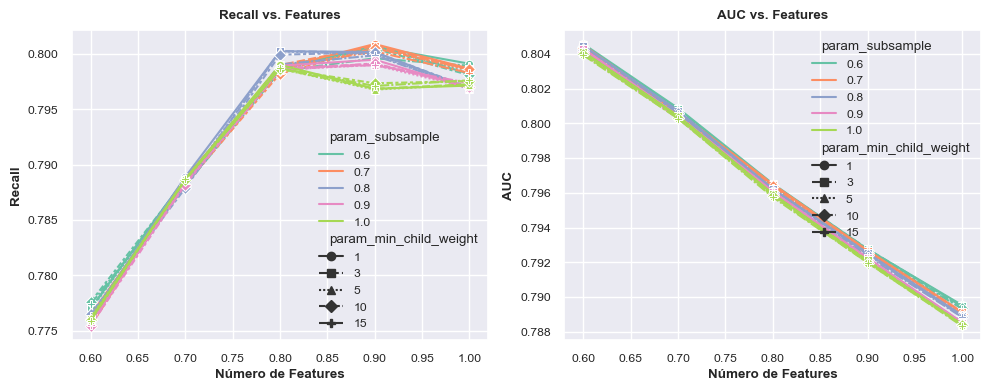

In [173]:
# Crear la figura para los dos gráficos
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Gráfico de Recall vs Features
sns.lineplot(data=results_xgb, x='param_colsample_bytree', y='mean_test_recall', 
            hue='param_subsample', markers = ['o', 's', '^', 'D', 'P'],
            style='param_min_child_weight',  errorbar=None,     
            palette="Set2", ax=axes[0])
axes[0].set_title("Recall vs. Features")
axes[0].set_xlabel("Número de Features")
axes[0].set_ylabel("Recall")

# Gráfico de AUC vs Features
sns.lineplot(data=results_xgb, x='param_colsample_bytree', y='mean_test_roc_auc', 
               hue='param_subsample', markers = ['o', 's','^', 'D', 'P'],
               style='param_min_child_weight',  errorbar=None,     
               palette="Set2", ax=axes[1])
axes[1].set_title("AUC vs. Features")
axes[1].set_xlabel("Número de Features")
axes[1].set_ylabel("AUC")

# Ajuste de la disposición de los gráficos
plt.tight_layout()
plt.show()

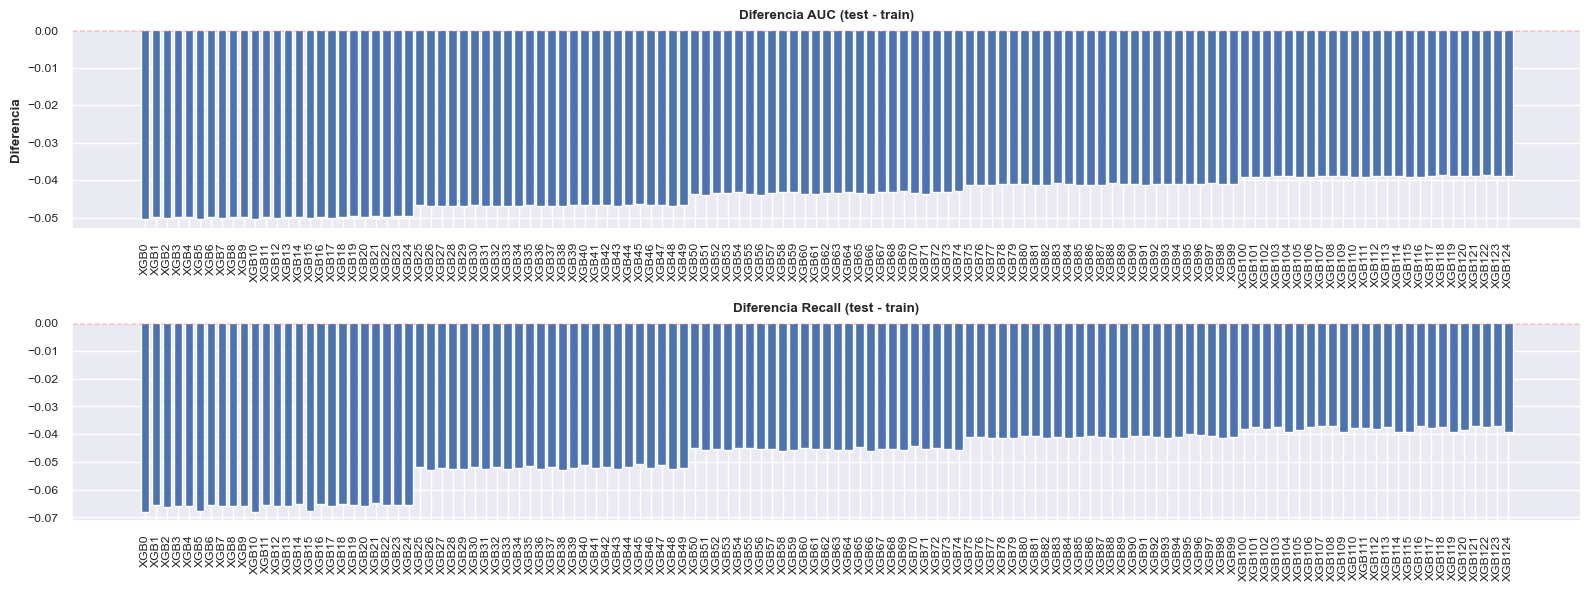

In [174]:
modelos_xgb = {}

for idx in range(0, len(results_xgb)):
    modelo = XGBClassifier(**results_xgb.iloc[idx].params, random_state=seed)
    modelo.fit(X_train_work, y_train_work)
    modelos_xgb[f"XGB{idx}"] = modelo
    
resultados_XGB = plot_train_test_differences(modelos_xgb, X_train_work, y_train_work, X_test_work, y_test_work)

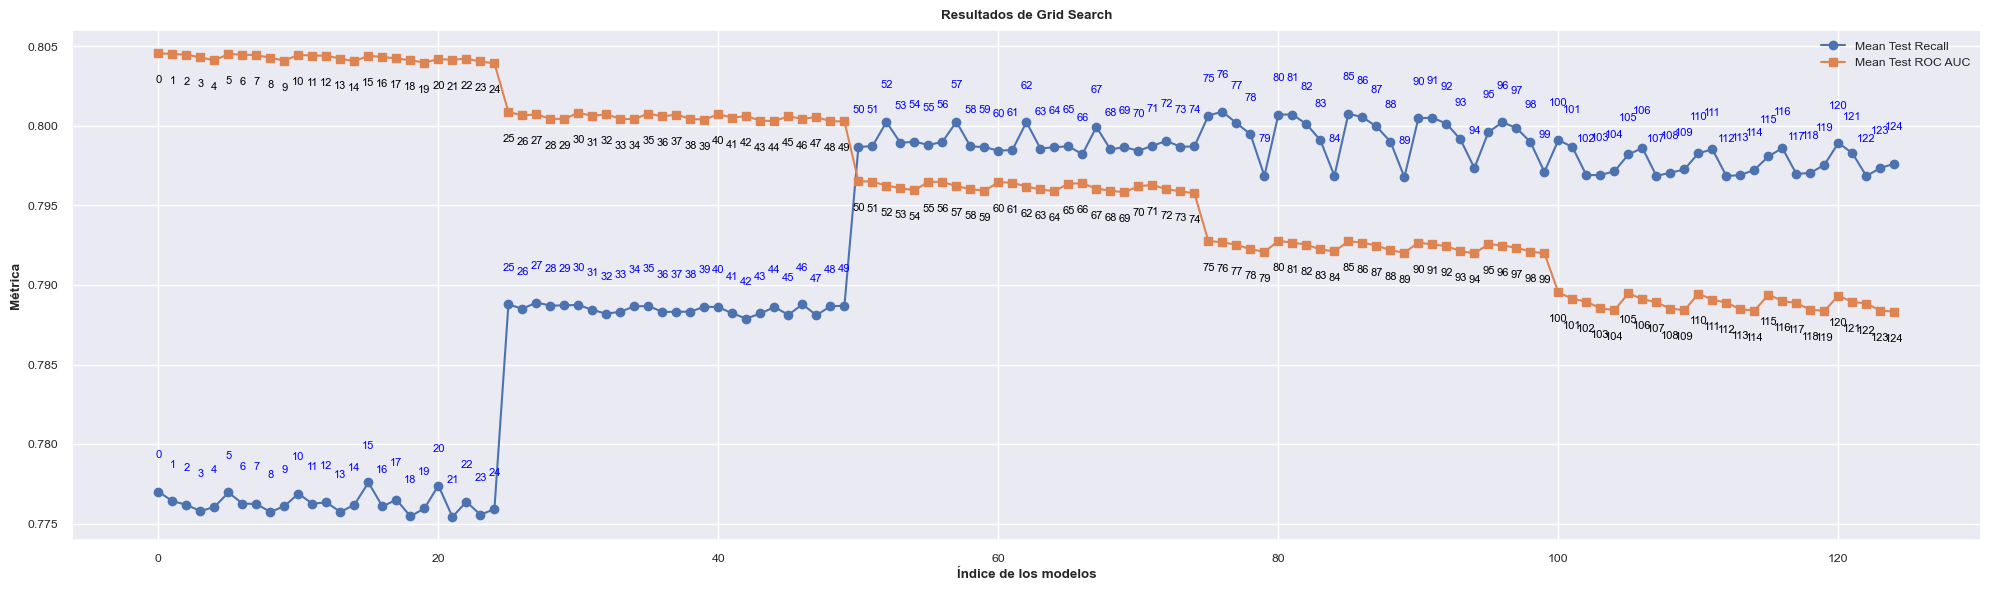

In [175]:
# La mejor performacen es con 0.6% de features en Auc 
# pero es la que más overfit tiene en recall y es la peor
# situacion de compromiso fetures con 0.8%
graficar_metricas_gridsearch(results_xgb)

In [176]:
# ¿Cual es el que selecciona el método (mejor AUC sin tener nada mas en cuenta)?
print('Los mejores parámetros según search:\n', grid_xgb.best_params_)
print('El mejor modelo según search:\n', grid_xgb.best_estimator_)

Los mejores parámetros según search:
 {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}
El mejor modelo según search:
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, feature_weights=None, gamma=0.2,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, ...)


In [177]:
results_xgb[['params', 'mean_test_recall', 'mean_test_roc_auc']].sort_values(by='mean_test_recall',ascending=False).head(5)

params  \
76  {'colsample_bytree': 0.9, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}   
85  {'colsample_bytree': 0.9, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.6}   
80  {'colsample_bytree': 0.9, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.6}   
81  {'colsample_bytree': 0.9, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7}   
75  {'colsample_bytree': 0.9, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}   

    mean_test_recall  mean_test_roc_auc  
76          0.800895           0.792689  
85          0.800765           0.792745  
80          0.800712           0.792769  
81          0.800712           0.792665  
75          0.800652           0.792755

In [178]:
results_xgb[['params', 'mean_test_recall', 'mean_test_roc_auc']].sort_values(by='mean_test_roc_auc',ascending=False).head(60)

params  \
0    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}   
5    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.6}   
1    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}   
2    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}   
6    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7}   
10   {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.6}   
7    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}   
11   {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.7}   
15  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.6}   
12   {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}   
16  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.7}   
3    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}   
8    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}   
17  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.8}   
13   {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}   
22  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 15, 'n_estimators': 100, 'subsample': 0.8}   
20  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 15, 'n_estimators': 100, 'subsample': 0.6}   
21  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 15, 'n_estimators': 100, 'subsample': 0.7}   
18  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}   
4    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}   
9    {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}   
14   {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}   
23  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 15, 'n_estimators': 100, 'subsample': 0.9}   
19  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 1.0}   
24  {'colsample_bytree': 0.6, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 15, 'n_estimators': 100, 'subsample': 1.0}   
25   {'colsample_bytree': 0.7, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}   
30   {'colsample_bytree': 0.7, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.6}   
35   {'colsample_bytree': 0.7, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.6}   
32   {'colsample_bytree': 0.7, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, '

In [179]:
lista_xgb = [27, 30, 32, 35, 40, 52, 56, 57, 60, 62, 67] 
resultados = []

# identificar modelos
for i in lista_xgb:
    resultados.append({
        "Modelo": f"Modelo{i}",
        "Parametros": results_xgb.params.iloc[i],
        "Mean_Recall": results_xgb['mean_test_recall'].iloc[i],
        "Std_Recall": results_xgb['std_test_recall'].iloc[i],
        "Mean_AUC": results_xgb['mean_test_roc_auc'].iloc[i],
        "Std_AUC": results_xgb['std_test_roc_auc'].iloc[i]
    })

# Crear DataFrame
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(by="Std_AUC", ascending=True, inplace=True)
df_resultados

Modelo  \
2   Modelo32   
0   Modelo27   
9   Modelo62   
5   Modelo52   
6   Modelo56   
7   Modelo57   
4   Modelo40   
10  Modelo67   
1   Modelo30   
3   Modelo35   
8   Modelo60   

                                                                                                                             Parametros  \
2    {'colsample_bytree': 0.7, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}   
0    {'colsample_bytree': 0.7, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}   
9    {'colsample_bytree': 0.8, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}   
5    {'colsample_bytree': 0.8, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}   
6    {'colsample_bytree': 0.8, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7}   
7    {'colsample_bytree': 0.8, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}   
4   {'colsample_bytree': 0.7, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.6}   
10  {'colsample_bytree': 0.8, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.8}   
1    {'colsample_bytree': 0.7, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.6}   
3    {'colsample_bytree': 0.7, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.6}   
8    {'colsample_bytree': 0.8, 'eta': 0.01, 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.6}   

    Mean_Recall  Std_Recall  Mean_AUC   Std_AUC  
2      0.788192    0.002285  0.800733  0.001928  
0      0.788896    0.002656  0.800717  0.001939  
9      0.800235    0.002501  0.796183  0.002007  
5      0.800243    0.002628  0.796240  0.002020  
6      0.798992    0.002385  0.796478  0.002023  
7      0.800261    0.002471  0.796211  0.002024  
4      0.788609    0.003301  0.800732  0.002032  
10     0.799930    0.002400  0.796060  0.002039  
1      0.788748    0.003256  0.800821  0.002077  
3      0.788678    0.003248  0.800777  0.002081  
8      0.798436    0.003391  0.796453  0.002105

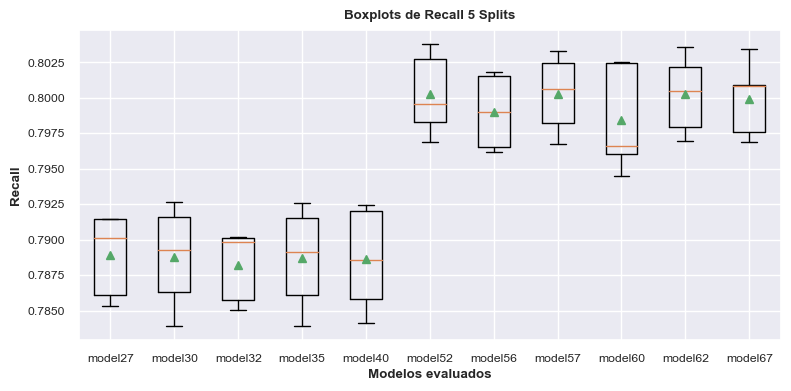

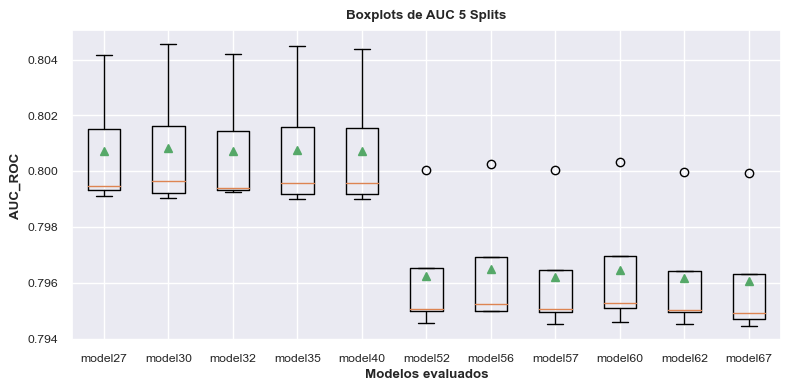

In [180]:
comparar_boxplot_cv5(results_xgb, lista_xgb)
comparar_boxplot_cv5_auc_roc(results_xgb, lista_xgb)

In [181]:
# ¿hay alguno de los seleccionados sobreentrenado con overfit?
modelos_xgb = {}

# Entrenamiento 
for idx in lista_xgb:
    modelo = XGBClassifier(**results_xgb.iloc[idx].params, random_state=seed)
    modelo.fit(X_train_work, y_train_work)
    modelos_xgb[f"XGB{idx}"] = modelo

evaluar_modelos_train_test(modelos_xgb, X_train_work, y_train_work, X_test_work, y_test_work)

AUC para cada modelo:
XGB27 | AUC_Train: 0.8015 | AUC_Test: 0.7546 | Diferencia: -0.0469
XGB30 | AUC_Train: 0.8014 | AUC_Test: 0.7547 | Diferencia: -0.0467
XGB32 | AUC_Train: 0.8014 | AUC_Test: 0.7546 | Diferencia: -0.0469
XGB35 | AUC_Train: 0.8013 | AUC_Test: 0.7547 | Diferencia: -0.0467
XGB40 | AUC_Train: 0.8012 | AUC_Test: 0.7547 | Diferencia: -0.0465
XGB52 | AUC_Train: 0.7970 | AUC_Test: 0.7535 | Diferencia: -0.0435
XGB56 | AUC_Train: 0.7973 | AUC_Test: 0.7535 | Diferencia: -0.0438
XGB57 | AUC_Train: 0.7970 | AUC_Test: 0.7535 | Diferencia: -0.0434
XGB60 | AUC_Train: 0.7973 | AUC_Test: 0.7537 | Diferencia: -0.0436
XGB62 | AUC_Train: 0.7969 | AUC_Test: 0.7536 | Diferencia: -0.0434
XGB67 | AUC_Train: 0.7968 | AUC_Test: 0.7535 | Diferencia: -0.0432

Recall para cada modelo:
XGB27 | Recall_Train: 0.7899 | Recall_Test: 0.7377 | Diferencia: -0.0521
XGB30 | Recall_Train: 0.7895 | Recall_Test: 0.7377 | Diferencia: -0.0518
XGB32 | Recall_Train: 0.7900 | Recall_Test: 0.7381 | Diferencia: -0.0

In [182]:
# Modelos XGB52-67 Diferencia Train–Test menor
# El más robusto para ambas metricas XGB67

modelo_XGB= XGBClassifier(colsample_bytree=0.8, eta=0.01,
                          gamma=0.2, max_depth=5, 
                          min_child_weight=10, subsample= 0.8,
                          n_estimators=100, random_state=seed)

modelo_XGB.fit(X_train_work, y_train_work) 	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, feature_weights=None, gamma=0.2,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, ...)

----------Métricas para el modelo XGB:----------

  Accuracy: 0.6594
  Recall:   0.7537
  AUC:      0.7535



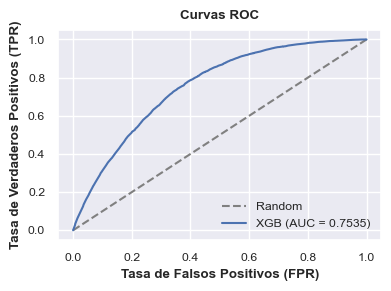


Matriz de confusion lineal. Pto de Corte=0.50


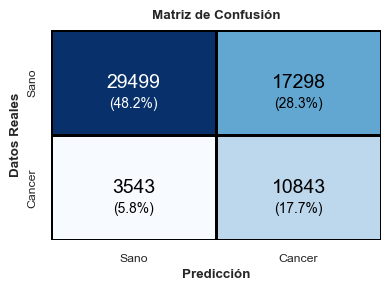


Informe de clasificación para XGB:
              precision    recall  f1-score   support

           0       0.89      0.63      0.74     46797
           1       0.39      0.75      0.51     14386

    accuracy                           0.66     61183
   macro avg       0.64      0.69      0.62     61183
weighted avg       0.77      0.66      0.69     61183



In [183]:
# parametros de bondad de ajuste
evaluacion_test_modelo([(modelo_XGB, 'XGB')], X_test_work, y_test_work)

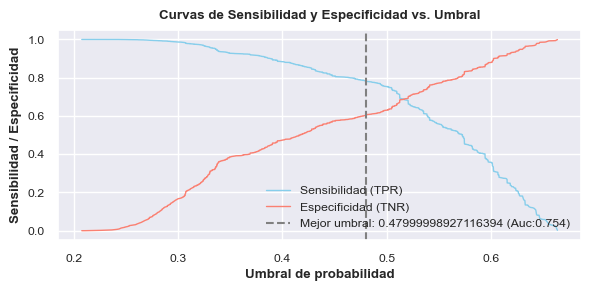

Mejor umbral según Youden para XGB: 0.48


In [184]:
best_thresh_XGB =youden(modelo_XGB, X_test_work, y_test_work)
print(f"Mejor umbral según Youden para XGB: {best_thresh_XGB:.2f}")

----------Métricas para el modelo XGB:----------

  Accuracy: 0.6469
  Recall:   0.7818
  AUC:      0.7535



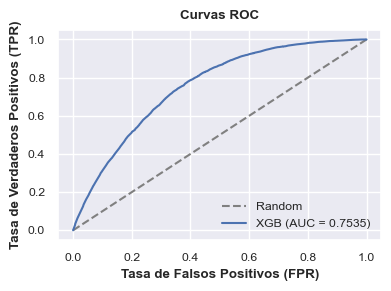


Matriz de confusion lineal. Pto de Corte=0.48


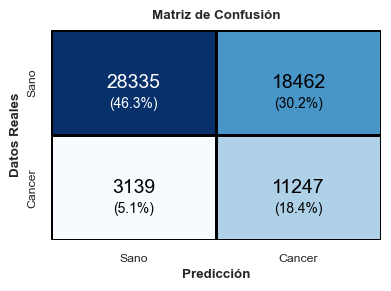


Informe de clasificación para XGB:
              precision    recall  f1-score   support

           0       0.90      0.61      0.72     46797
           1       0.38      0.78      0.51     14386

    accuracy                           0.65     61183
   macro avg       0.64      0.69      0.62     61183
weighted avg       0.78      0.65      0.67     61183



In [185]:
# parametros de bondad de ajuste con Youden
evaluacion_test_modelo([(modelo_XGB, 'XGB')], 
                       X_test_work, y_test_work, best_thresh_XGB)

### LightGBM

LightGBM (Light Gradient Boosting Machine) es otro algoritmo de boosting para manejar grandes volúmenes de datos de manera eficiente. Desarrollado por Microsoft. Al igual que XGBoost, construye árboles secuencialmente para corregir errores residuales y utiliza el descenso del gradiente para mejorar el modelo de manera iterativa, pero introduce innovaciones como el leaf-wise growth y el uso de histogramas para dividir los datos, lo que le permite entrenar modelos de alta precisión con menor tiempo de cómputo y menor consumo de memoria. En contextos clínicos, LightGBM ha mostrado niveles de precisión y AUC competitivos o superiores a otros algoritmos de clasificación, especialmente en conjuntos de datos con un gran número de variables y distribuciones desbalanceadas.

Ventajas:
- Alta precisión y AUC: Comparable o superior a XGBoost en muchos escenarios, gracias a su estrategia de crecimiento leaf-wise.
- Velocidad: LightGBM es extremadamente eficiente en el entrenamiento y la predicción, especialmente en grandes conjuntos de datos, gracias a su enfoque optimizado.
- Escalabilidad: Está diseñado para manejar grandes volúmenes de datos y alta dimensionalidad de manera efectiva, lo que lo hace adecuado para aplicaciones en el mundo real con grandes cantidades de información.
- Flexibilidad en datos heterogéneos: Soporta tanto variables numéricas como categóricas de manera nativa.
- Regularización avanzada: Dispone de parámetros que reducen el riesgo de sobreajuste incluso en modelos profundos.
- Importancia de variables: Permite identificar qué características son más relevantes para la predicción.
  
Desventajas:
- Sensibilidad a Hiperparámetros: Requiere una cuidadosa configuración de hiperparámetros para optimizar el rendimiento, lo que puede ser un desafío.
- Menor Interpretabilidad: Similar a otros métodos de boosting, puede ser menos interpretable que modelos basados en árboles individuales, complicando la interpretación de sus predicciones.

In [186]:
lgb = LGBMClassifier(random_state=seed, verbose=-1, n_jobs=-1, class_weight='balanced')

param_grid_lgb = {
    "n_estimators": [100, 150, 200, 250, 300], 
    "max_depth": [3, 5, 7, 10],
    "min_child_samples": [1, 5, 10, 15],
    #"learning_rate": [0.1, 0.05, 0.01],
    #"reg_alpha": [0.1],      
    #"reg_lambda": [0.1, 0.5, 1.0],    
    #"subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    #"colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    #'boosting_type': ['gbdt', 'dart'],
}

grid_lgb = GridSearchCV(lgb, param_grid_lgb, cv=cv5, 
                        scoring=scoring_metrics , 
                        refit='roc_auc', 
                        n_jobs=-1)

start_time = time.time()
grid_lgb.fit(X_train_work, y_train_work)
end_time = time.time() 

elapsed_time_lgb = (end_time - start_time)/60
print(f"Tiempo de ejecución: {elapsed_time_lgb:.2f} minutos")

Tiempo de ejecución: 6.77 minutos


In [187]:
results_lgb=pd.DataFrame(grid_lgb.cv_results_)
print("Resultados de Grid Search:")
results_lgb[['params', 'mean_test_recall', 'mean_test_roc_auc']].head(10)

Resultados de Grid Search:


params  \
0  {'max_depth': 3, 'min_child_samples': 1, 'n_estimators': 100}   
1  {'max_depth': 3, 'min_child_samples': 1, 'n_estimators': 150}   
2  {'max_depth': 3, 'min_child_samples': 1, 'n_estimators': 200}   
3  {'max_depth': 3, 'min_child_samples': 1, 'n_estimators': 250}   
4  {'max_depth': 3, 'min_child_samples': 1, 'n_estimators': 300}   
5  {'max_depth': 3, 'min_child_samples': 5, 'n_estimators': 100}   
6  {'max_depth': 3, 'min_child_samples': 5, 'n_estimators': 150}   
7  {'max_depth': 3, 'min_child_samples': 5, 'n_estimators': 200}   
8  {'max_depth': 3, 'min_child_samples': 5, 'n_estimators': 250}   
9  {'max_depth': 3, 'min_child_samples': 5, 'n_estimators': 300}   

   mean_test_recall  mean_test_roc_auc  
0          0.792371           0.829846  
1          0.790138           0.843334  
2          0.787584           0.854342  
3          0.781658           0.859566  
4          0.775020           0.862290  
5          0.792371           0.829846  
6          0.790138           0.843334  
7          0.787584           0.854342  
8          0.781658           0.859566  
9          0.775020           0.862290

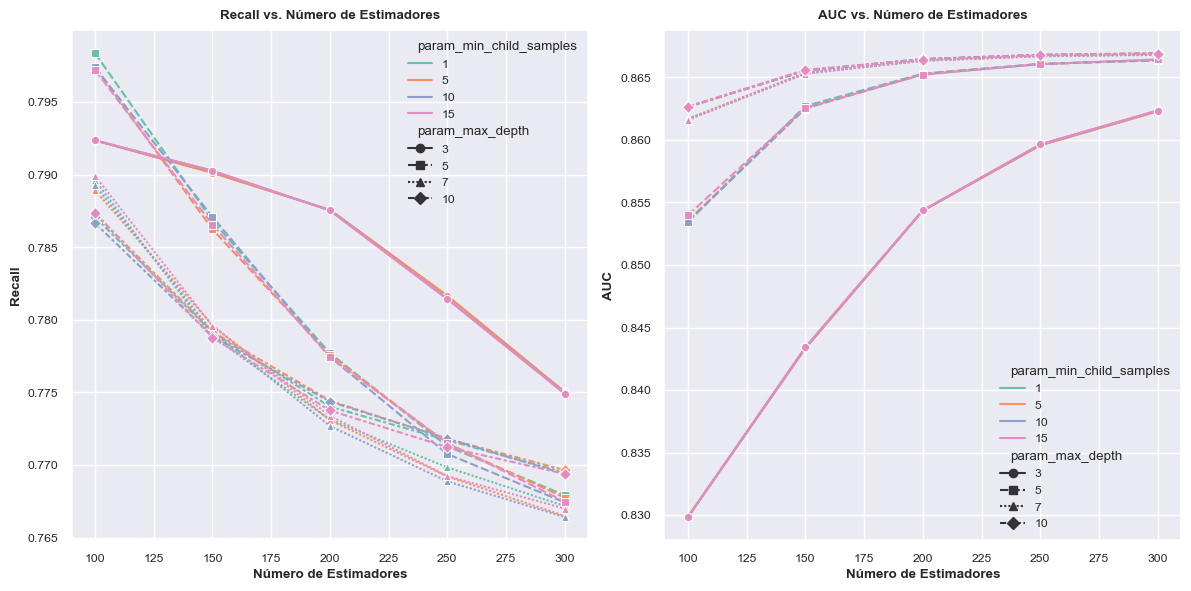

In [188]:
# Crear la figura para los dos gráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de Recall vs Número de Estimadores
sns.lineplot(data=results_lgb, x='param_n_estimators', y='mean_test_recall', 
            hue='param_min_child_samples', markers = ['o', 's', '^', 'D'],
            style='param_max_depth',  errorbar=None,     
            palette="Set2", ax=axes[0])
axes[0].set_title("Recall vs. Número de Estimadores")
axes[0].set_xlabel("Número de Estimadores")
axes[0].set_ylabel("Recall")

# Gráfico de AUC vs Número de Estimadores
sns.lineplot(data=results_lgb, x='param_n_estimators', y='mean_test_roc_auc', 
               hue='param_min_child_samples', markers = ['o', 's', '^', 'D'],
               style='param_max_depth',  errorbar=None,     
               palette="Set2", ax=axes[1])
axes[1].set_title("AUC vs. Número de Estimadores")
axes[1].set_xlabel("Número de Estimadores")
axes[1].set_ylabel("AUC")

# Ajuste de la disposición de los gráficos
plt.tight_layout()
plt.show()

In [189]:
modelos_lgb = {}

for idx in range(0, len(results_lgb)):
    modelo = LGBMClassifier(**results_lgb.iloc[idx].params, random_state=seed, 
                            verbose=-1, n_jobs=-1, class_weight='balanced')
    
    modelo.fit(X_train_work, y_train_work)
    modelos_lgb[f"LGBM{idx}"] = modelo

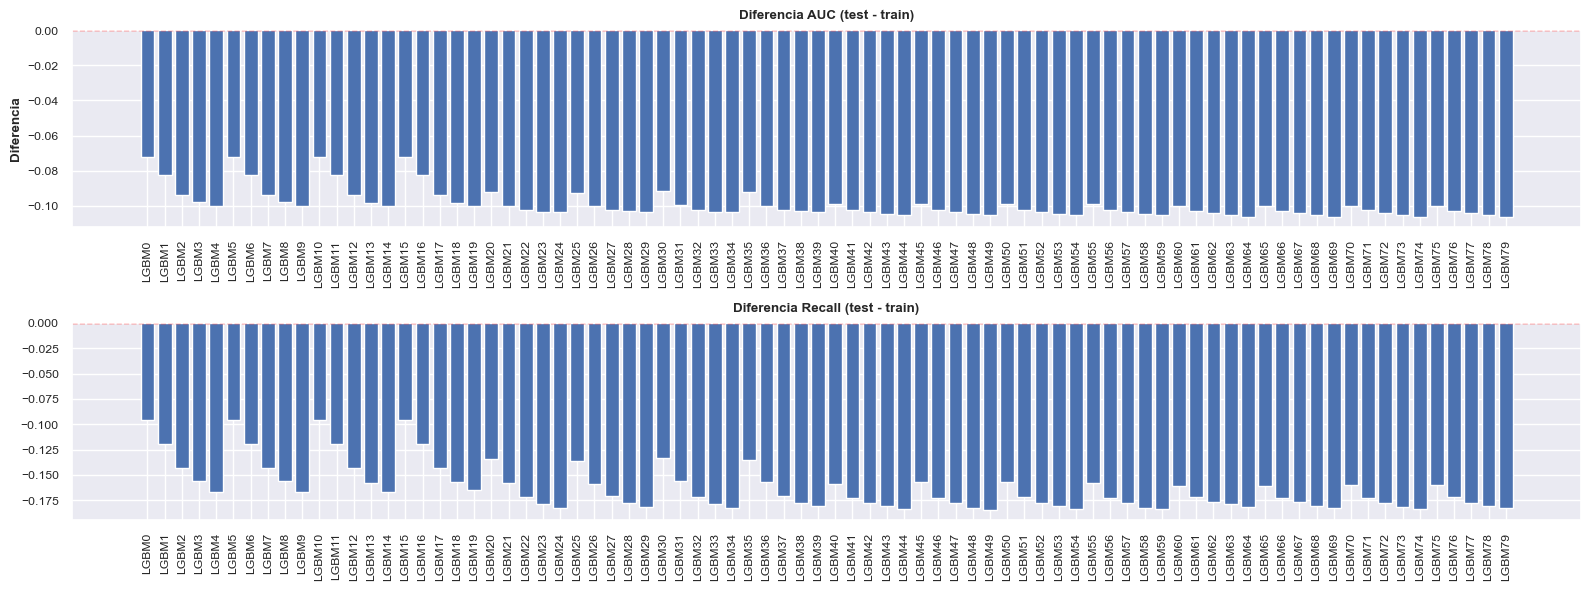

In [190]:
resultados_LGB = plot_train_test_differences(modelos_lgb, X_train_work, y_train_work, X_test_work, y_test_work)

In [191]:
# Aumenta el overfit al aumentar los estimadores
# 150 estimadores es una situación de compromiso
# 7 la profundidad de compromiso donde se puede maximizar ambos
# no hay diferencia en child_samples. 
# se supone Aumentarlo reduce overfitting.
param_grid_lgb = {
    "n_estimators": [100], 
    "max_depth": [7],
    "min_child_samples": [15],
    "learning_rate": [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2],
    "reg_alpha": [0, 0.1, 0.5, 1],      
    "reg_lambda": [0, 0.1, 0.5, 1],    
    #"subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    #"colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    #'boosting_type': ['gbdt', 'dart'],
}

grid_lgb = GridSearchCV(lgb, param_grid_lgb, cv=cv5, 
                        scoring=scoring_metrics , 
                        refit='roc_auc', 
                        n_jobs=-1)

start_time = time.time()
grid_lgb.fit(X_train_work, y_train_work)
end_time = time.time() 

elapsed_time_lgb = (end_time - start_time)/60
print(f"Tiempo de ejecución: {elapsed_time_lgb:.2f} minutos")

Tiempo de ejecución: 6.81 minutos


In [192]:
results_lgb=pd.DataFrame(grid_lgb.cv_results_)
print("Resultados de Grid Search:")
results_lgb[['params', 'mean_test_recall', 'mean_test_roc_auc']].head()

Resultados de Grid Search:


params  \
0    {'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0}   
1  {'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1}   
2  {'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.5}   
3    {'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}   
4  {'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0}   

   mean_test_recall  mean_test_roc_auc  
0          0.801868           0.804302  
1          0.802329           0.804236  
2          0.801859           0.804119  
3          0.801138           0.803995  
4          0.801729           0.804203

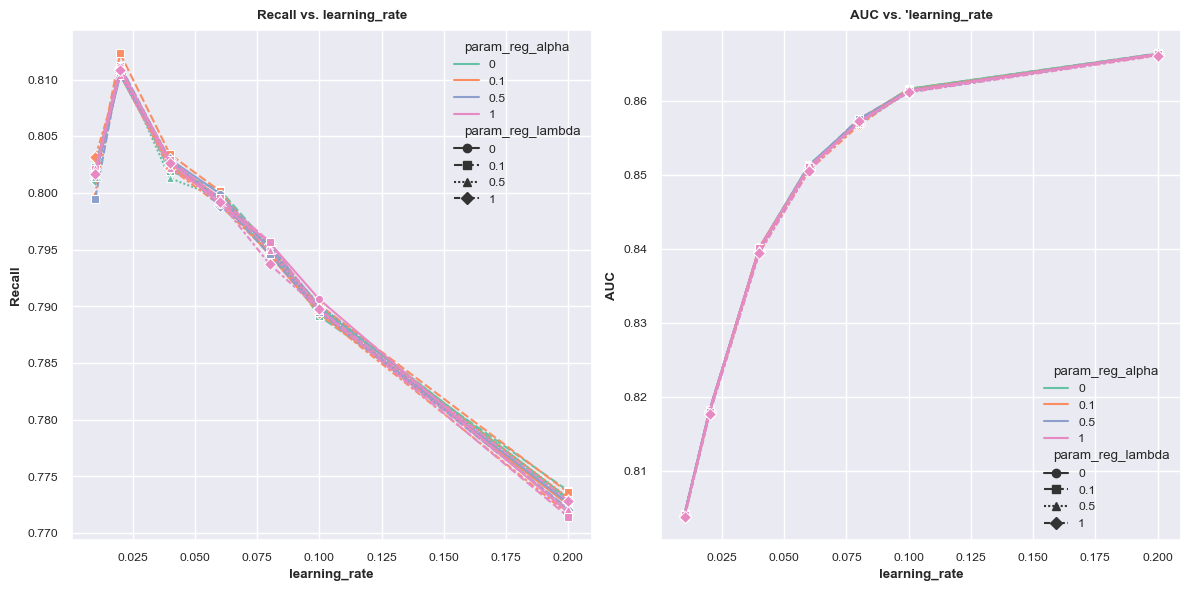

In [193]:
# Crear la figura para los dos gráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de Recall vs 'learning_rate
sns.lineplot(data=results_lgb, x='param_learning_rate', y='mean_test_recall', 
            hue='param_reg_alpha', markers = ['o', 's', '^', 'D'],
            style='param_reg_lambda',  errorbar=None,     
            palette="Set2", ax=axes[0])
axes[0].set_title("Recall vs. learning_rate")
axes[0].set_xlabel("learning_rate")
axes[0].set_ylabel("Recall")

# Gráfico de AUC vs 'learning_rate
sns.lineplot(data=results_lgb, x='param_learning_rate', y='mean_test_roc_auc', 
               hue='param_reg_alpha', markers = ['o', 's', '^', 'D'],
               style='param_reg_lambda',  errorbar=None,     
               palette="Set2", ax=axes[1])
axes[1].set_title("AUC vs. 'learning_rate")
axes[1].set_xlabel("learning_rate")
axes[1].set_ylabel("AUC")

# Ajuste de la disposición de los gráficos
plt.tight_layout()
plt.show()

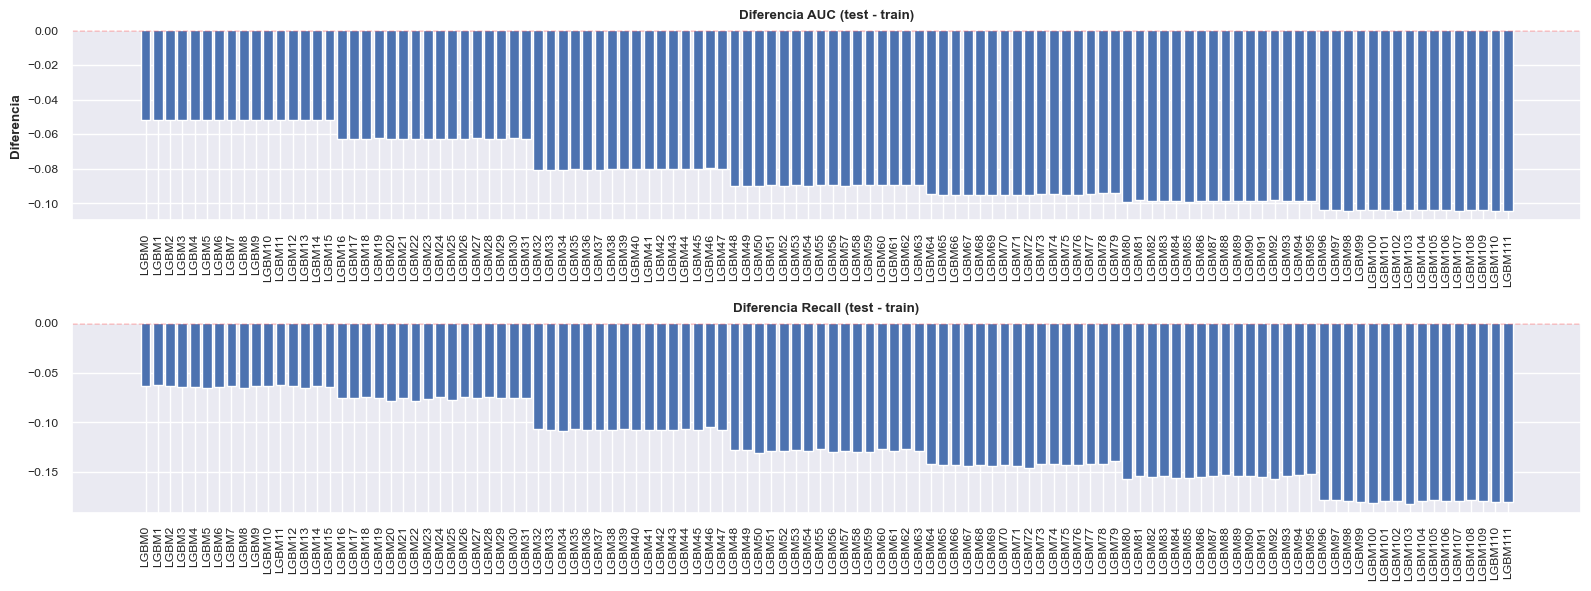

In [194]:
modelos_lgb = {}

for idx in range(0, len(results_lgb)):
    modelo = LGBMClassifier(**results_lgb.iloc[idx].params, random_state=seed, 
                            verbose=-1, n_jobs=-1, class_weight='balanced')
    
    modelo.fit(X_train_work, y_train_work)
    modelos_lgb[f"LGBM{idx}"] = modelo

resultados_LGB = plot_train_test_differences(modelos_lgb, X_train_work, y_train_work, X_test_work, y_test_work)

In [195]:
# nohay diferencia entre las regulaciones
# AUC y el overfit aumentan con el learning rate
# Recall disminuye con learning rate
# escogemos el menor learning rate para evitar overfit

param_grid_lgb = {
    "n_estimators": [100], 
    "max_depth": [7],
    "min_child_samples": [15],
    "learning_rate": [0.01],
    "reg_alpha": [0.1],      
    #"reg_lambda": [0], 
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    'boosting_type': ['gbdt', 'dart'],
}

grid_lgb = GridSearchCV(lgb, param_grid_lgb, cv=cv5, 
                        scoring=scoring_metrics , 
                        refit='roc_auc', 
                        n_jobs=-1)

start_time = time.time()
grid_lgb.fit(X_train_work, y_train_work)
end_time = time.time() 

elapsed_time_lgb = (end_time - start_time)/60
print(f"Tiempo de ejecución: {elapsed_time_lgb:.2f} minutos")

Tiempo de ejecución: 3.72 minutos


In [196]:
results_lgb=pd.DataFrame(grid_lgb.cv_results_)
print("Resultados de Grid Search:")
results_lgb[['params', 'mean_test_recall', 'mean_test_roc_auc']].head(6)

Resultados de Grid Search:


params  \
0  {'boosting_type': 'gbdt', 'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.6}   
1  {'boosting_type': 'gbdt', 'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.7}   
2  {'boosting_type': 'gbdt', 'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.8}   
3  {'boosting_type': 'gbdt', 'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.9}   
4  {'boosting_type': 'gbdt', 'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 1.0}   
5  {'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.6}   

   mean_test_recall  mean_test_roc_auc  
0          0.775497           0.820525  
1          0.775497           0.820525  
2          0.775497           0.820525  
3          0.775497           0.820525  
4          0.775497           0.820525  
5          0.781701           0.815871

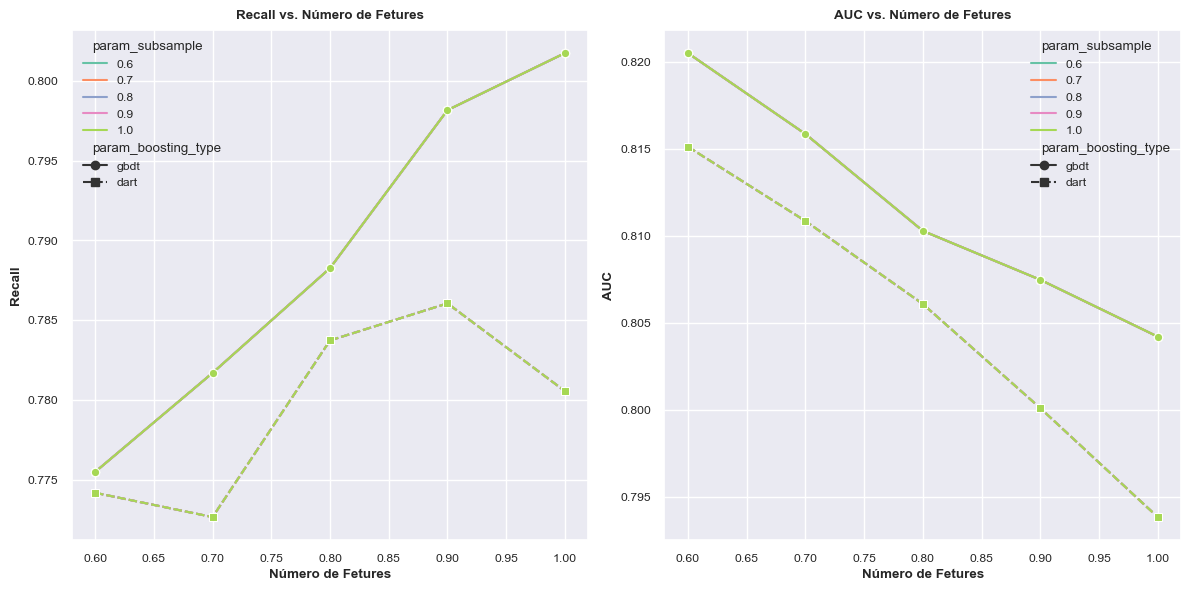

In [197]:
# Crear la figura para los dos gráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de Recall vs Número de Fetures
sns.lineplot(data=results_lgb, x='param_colsample_bytree', y='mean_test_recall', 
            hue='param_subsample', markers = ['o', 's'],
            style='param_boosting_type',  errorbar=None,     
            palette="Set2", ax=axes[0])
axes[0].set_title("Recall vs. Número de Fetures")
axes[0].set_xlabel("Número de Fetures")
axes[0].set_ylabel("Recall")

# Gráfico de AUC vs Número de Fetures
sns.lineplot(data=results_lgb, x='param_colsample_bytree', y='mean_test_roc_auc', 
               hue='param_subsample', markers = ['o', 's'],
               style='param_boosting_type',  errorbar=None,     
               palette="Set2", ax=axes[1])
axes[1].set_title("AUC vs. Número de Fetures")
axes[1].set_xlabel("Número de Fetures")
axes[1].set_ylabel("AUC")

# Ajuste de la disposición de los gráficos
plt.tight_layout()
plt.show()

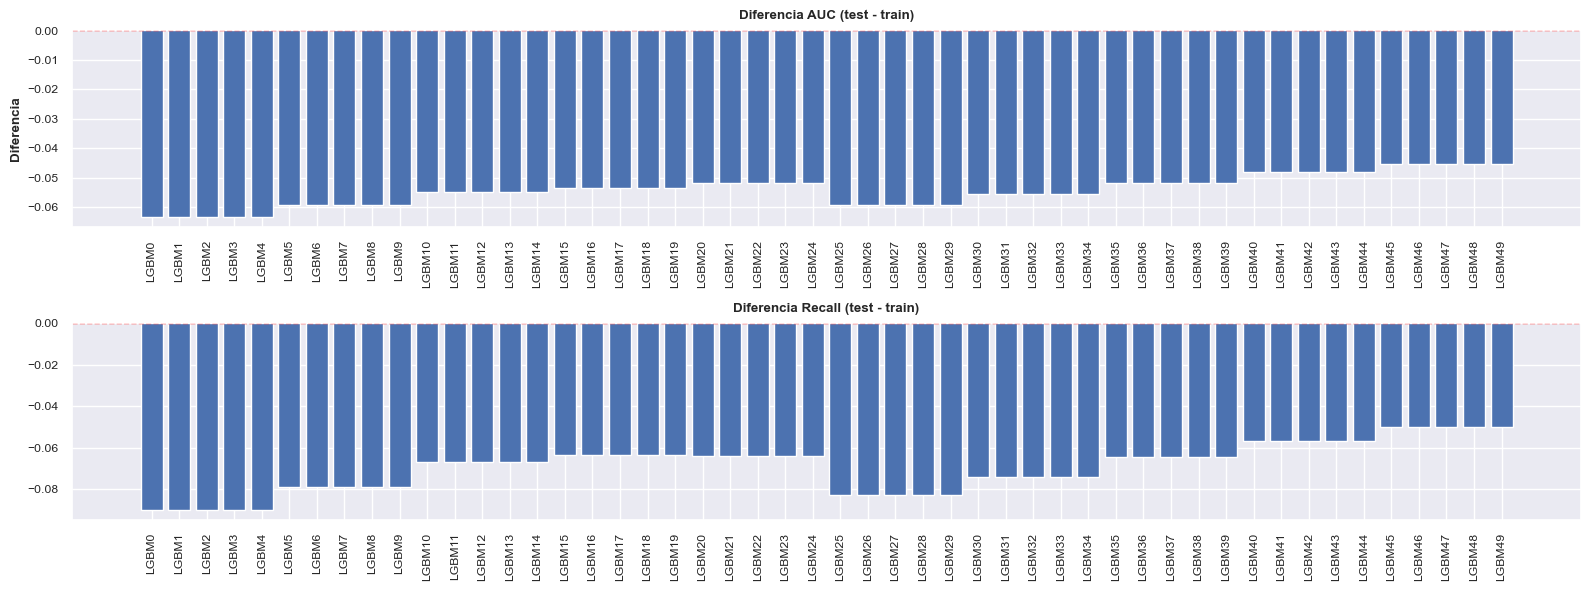

In [198]:
modelos_lgb = {}

for idx in range(0, len(results_lgb)):
    modelo = LGBMClassifier(**results_lgb.iloc[idx].params, random_state=seed, 
                            verbose=-1, n_jobs=-1, class_weight='balanced')
    
    modelo.fit(X_train_work, y_train_work)
    modelos_lgb[f"LGBM{idx}"] = modelo

resultados_LGB = plot_train_test_differences(modelos_lgb, X_train_work, y_train_work, X_test_work, y_test_work)

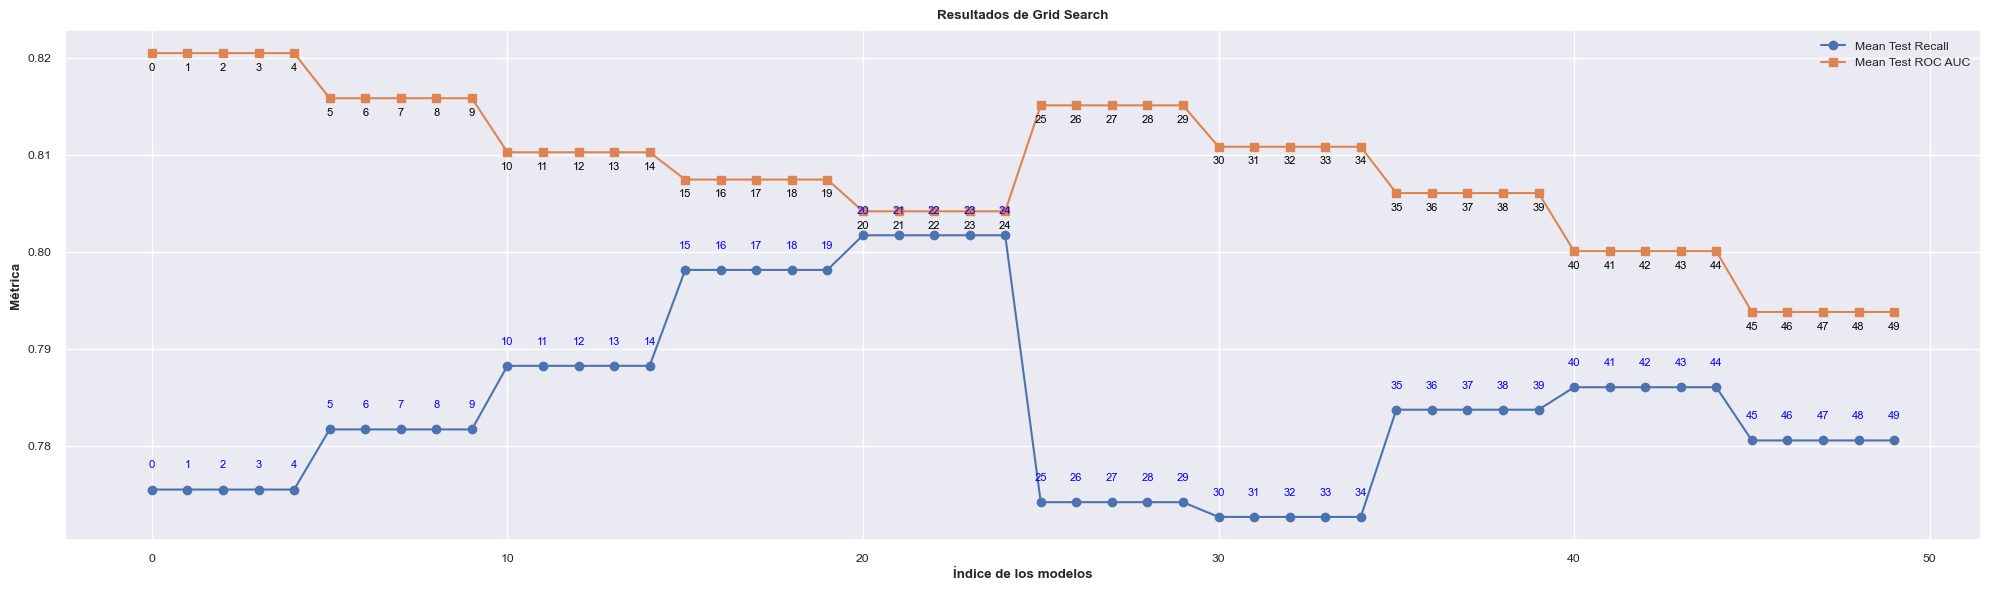

In [199]:
# Dart tiene menor performance en metricas
# AUC disminuyen con el % de características
# Recall a la inversa
# Se reduce el overfit con el numero de variables
# no hay diferencia entre numero de samples
graficar_metricas_gridsearch(results_lgb)

In [200]:
# ¿Cual es el que selecciona el método (mejor AUC sin tener nada mas en cuenta)?
print('Los mejores parámetros según search:\n', grid_lgb.best_params_)
print('El mejor modelo según search:\n', grid_lgb.best_estimator_)

Los mejores parámetros según search:
 {'boosting_type': 'gbdt', 'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.6}
El mejor modelo según search:
 LGBMClassifier(class_weight='balanced', colsample_bytree=0.6,
               learning_rate=0.01, max_depth=7, min_child_samples=15, n_jobs=-1,
               random_state=12345, reg_alpha=0.1, subsample=0.6, verbose=-1)


In [201]:
results_lgb[['params', 'mean_test_recall', 'mean_test_roc_auc']].sort_values(by='mean_test_recall',ascending=False).head(7)

params  \
22  {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.8}   
23  {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.9}   
21  {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.7}   
20  {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.6}   
24  {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 1.0}   
19  {'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 1.0}   
18  {'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.9}   

    mean_test_recall  mean_test_roc_auc  
22          0.801729           0.804203  
23          0.801729           0.804203  
21          0.801729           0.804203  
20          0.801729           0.804203  
24          0.801729           0.804203  
19          0.798158           0.807477  
18          0.798158           0.807477

In [202]:
results_lgb[['params', 'mean_test_recall', 'mean_test_roc_auc']].sort_values(by='mean_test_roc_auc',ascending=False).head(5)

params  \
0  {'boosting_type': 'gbdt', 'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.6}   
1  {'boosting_type': 'gbdt', 'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.7}   
2  {'boosting_type': 'gbdt', 'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.8}   
3  {'boosting_type': 'gbdt', 'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.9}   
4  {'boosting_type': 'gbdt', 'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 1.0}   

   mean_test_recall  mean_test_roc_auc  
0          0.775497           0.820525  
1          0.775497           0.820525  
2          0.775497           0.820525  
3          0.775497           0.820525  
4          0.775497           0.820525

In [203]:
lista_lgb = [20, 21, 22, 23, 24, 40, 41, 42, 43] 
resultados = []

# identificar modelos
for i in lista_lgb:
    resultados.append({
        "Modelo": f"Modelo{i}",
        "Parametros": results_lgb.params.iloc[i],
        "Mean_Recall": results_lgb['mean_test_recall'].iloc[i],
        "Std_Recall": results_lgb['std_test_recall'].iloc[i],
        "Mean_AUC": results_lgb['mean_test_roc_auc'].iloc[i],
        "Std_AUC": results_lgb['std_test_roc_auc'].iloc[i]
    })

# Crear DataFrame
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(by="Std_AUC", ascending=True, inplace=True)
df_resultados

Modelo  \
0  Modelo20   
1  Modelo21   
2  Modelo22   
3  Modelo23   
4  Modelo24   
5  Modelo40   
6  Modelo41   
7  Modelo42   
8  Modelo43   

                                                                                                                                                                    Parametros  \
0  {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.6}   
1  {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.7}   
2  {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.8}   
3  {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.9}   
4  {'boosting_type': 'gbdt', 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 1.0}   
5  {'boosting_type': 'dart', 'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.6}   
6  {'boosting_type': 'dart', 'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.7}   
7  {'boosting_type': 'dart', 'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.8}   
8  {'boosting_type': 'dart', 'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 15, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.9}   

   Mean_Recall  Std_Recall  Mean_AUC   Std_AUC  
0     0.801729    0.007799  0.804203  0.002234  
1     0.801729    0.007799  0.804203  0.002234  
2     0.801729    0.007799  0.804203  0.002234  
3     0.801729    0.007799  0.804203  0.002234  
4     0.801729    0.007799  0.804203  0.002234  
5     0.786054    0.011449  0.800089  0.002747  
6     0.786054    0.011449  0.800089  0.002747  
7     0.786054    0.011449  0.800089  0.002747  
8     0.786054    0.011449  0.800089  0.002747

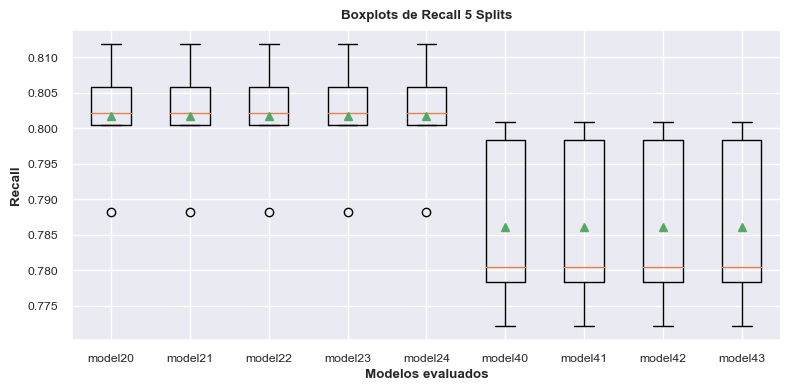

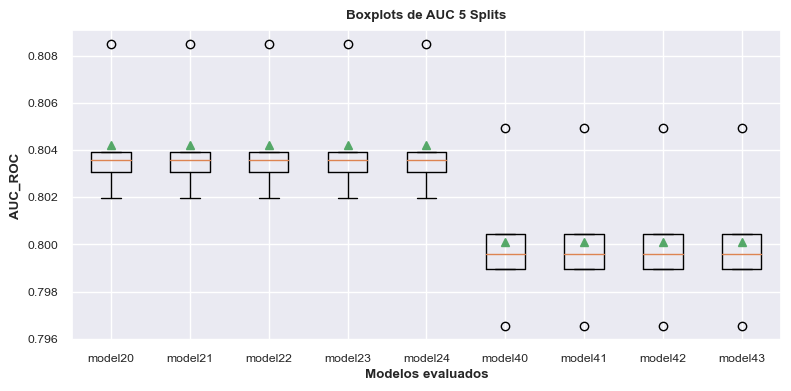

In [204]:
comparar_boxplot_cv5(results_lgb, lista_lgb)
comparar_boxplot_cv5_auc_roc(results_lgb, lista_lgb)

In [205]:
modelos_lgb = {}

# Entrenamiento 
for idx in lista_lgb:
    modelo = LGBMClassifier(**results_lgb.iloc[idx].params, random_state=seed, 
                            verbose=-1, n_jobs=-1, class_weight='balanced')
    modelo.fit(X_train_work, y_train_work)
    modelos_lgb[f"LGB{idx}"] = modelo

evaluar_modelos_train_test(modelos_lgb, X_train_work, y_train_work, X_test_work, y_test_work)

AUC para cada modelo:
LGB20 | AUC_Train: 0.8046 | AUC_Test: 0.7528 | Diferencia: -0.0518
LGB21 | AUC_Train: 0.8046 | AUC_Test: 0.7528 | Diferencia: -0.0518
LGB22 | AUC_Train: 0.8046 | AUC_Test: 0.7528 | Diferencia: -0.0518
LGB23 | AUC_Train: 0.8046 | AUC_Test: 0.7528 | Diferencia: -0.0518
LGB24 | AUC_Train: 0.8046 | AUC_Test: 0.7528 | Diferencia: -0.0518
LGB40 | AUC_Train: 0.8004 | AUC_Test: 0.7525 | Diferencia: -0.0480
LGB41 | AUC_Train: 0.8004 | AUC_Test: 0.7525 | Diferencia: -0.0480
LGB42 | AUC_Train: 0.8004 | AUC_Test: 0.7525 | Diferencia: -0.0480
LGB43 | AUC_Train: 0.8004 | AUC_Test: 0.7525 | Diferencia: -0.0480

Recall para cada modelo:
LGB20 | Recall_Train: 0.8036 | Recall_Test: 0.7397 | Diferencia: -0.0639
LGB21 | Recall_Train: 0.8036 | Recall_Test: 0.7397 | Diferencia: -0.0639
LGB22 | Recall_Train: 0.8036 | Recall_Test: 0.7397 | Diferencia: -0.0639
LGB23 | Recall_Train: 0.8036 | Recall_Test: 0.7397 | Diferencia: -0.0639
LGB24 | Recall_Train: 0.8036 | Recall_Test: 0.7397 | Dife

In [206]:
#LGB40–43 muestran menos diff train-test
# pero recall es menos robust
# Aunque DART es más estable, el GBDT (LGB20–24) 
# ofrece mejor recall, que es más importante
#  la menor variabilidad  LGB20
modelo_LGB= LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, 
                           learning_rate=0.01, max_depth=7, 
                           min_child_samples=15, n_estimators=100, 
                           reg_alpha = 0.1, subsample=0.6, random_state=seed, 
                           verbose=-1, n_jobs=-1, class_weight='balanced')

modelo_LGB.fit(X_train_work, y_train_work) 	

LGBMClassifier(class_weight='balanced', learning_rate=0.01, max_depth=7,
               min_child_samples=15, n_jobs=-1, random_state=12345,
               reg_alpha=0.1, subsample=0.6, verbose=-1)

----------Métricas para el modelo LGB:----------

  Accuracy: 0.6660
  Recall:   0.7397
  AUC:      0.7528



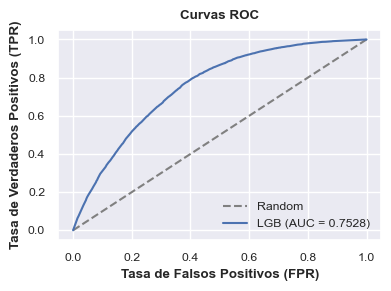


Matriz de confusion lineal. Pto de Corte=0.50


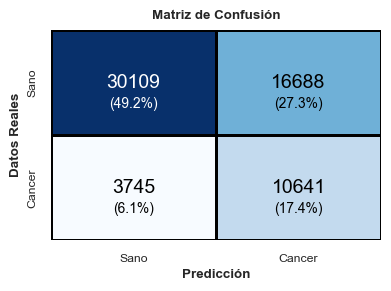


Informe de clasificación para LGB:
              precision    recall  f1-score   support

           0       0.89      0.64      0.75     46797
           1       0.39      0.74      0.51     14386

    accuracy                           0.67     61183
   macro avg       0.64      0.69      0.63     61183
weighted avg       0.77      0.67      0.69     61183



In [207]:
# parametros de bondad de ajuste
evaluacion_test_modelo([(modelo_LGB, 'LGB')], X_test_work, y_test_work)

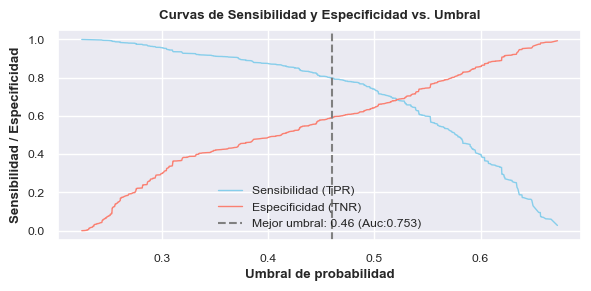

Mejor umbral según Youden para LGB: 0.46


In [208]:
best_thresh_LGB =youden(modelo_LGB, X_test_work, y_test_work)
print(f"Mejor umbral según Youden para LGB: {best_thresh_LGB:.2f}")

----------Métricas para el modelo LGB:----------

  Accuracy: 0.6396
  Recall:   0.7979
  AUC:      0.7528



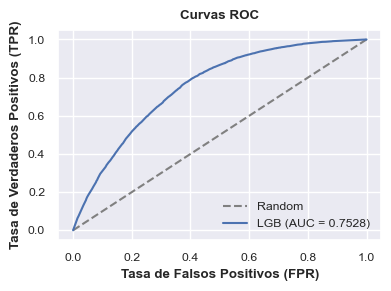


Matriz de confusion lineal. Pto de Corte=0.46


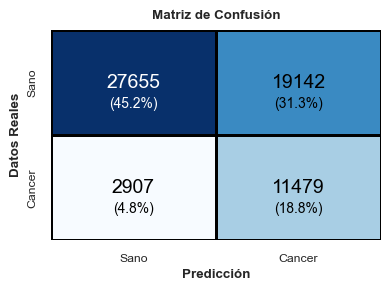


Informe de clasificación para LGB:
              precision    recall  f1-score   support

           0       0.90      0.59      0.71     46797
           1       0.37      0.80      0.51     14386

    accuracy                           0.64     61183
   macro avg       0.64      0.69      0.61     61183
weighted avg       0.78      0.64      0.67     61183



In [209]:
# parametros de bondad de ajuste con Youden
evaluacion_test_modelo([(modelo_LGB, 'LGB')], 
                       X_test_work, y_test_work, best_thresh_LGB)

Se evita probar SVM dado que este dataset es grande, el costo computacional sería elevado sin mejoras notables en los resultados, en comparación con los odelos de boosting.   
Rededes neuronales como  MLP  podrían probarse, pero teniendo solo 10 características, no aportan más beneficio que un modelo de ML clásico o modelos de boosting. 10 features es muy poco para que una red aprenda representaciones complejas.

En AUC son todos muy similares (0.747–0.754), aunque predomina XGBoost.    
En recall (clase 1) RF es superior, lo cual es clave en problemas médicos (prefieres detectar más positivos aunque suba el falso positivo).   
Todos sacrifican precisión en la clase 0 (aumentan falsos positivos) para capturar positivos, común en datasets desbalanceados.

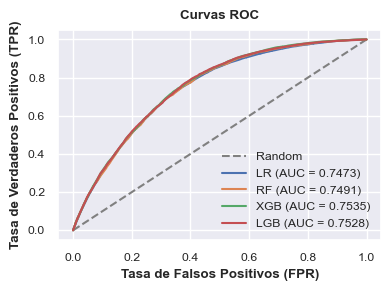

In [210]:
modelos_comparacion= [
    (modelo_LR, 'LR'),        # modelo lineal
    (modelo_RF, 'RF'),        # basado en árboles (bagging)
    (modelo_XGB, 'XGB'),       # boosting, reduce sesgo
    (modelo_LGB, 'LGB'), # relaciones no lineales
]

graficar_roc_multiple_con_display(modelos_comparacion, X_test_work, y_test_work)

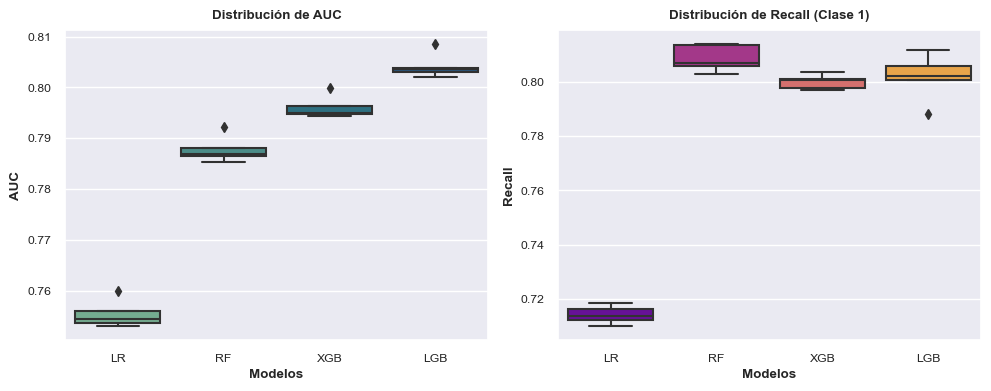

In [211]:
# comparamos la robusted
comparar_modelos_CV5_boxplot(modelos_comparacion, X_train_work, y_train_work)

### Stacking 

Stacking es una técnica de ensemble learning que combina varios modelos de base (modelos de primer nivel) para mejorar la capacidad predictiva final. La idea consiste en entrenar múltiples modelos base con el mismo conjunto de datos de entrenamiento y luego usar sus predicciones como nuevas características para entrenar un meta-modelo (o modelo de segundo nivel). Este meta-modelo aprende a combinar las predicciones de los modelos base de manera óptima, buscando maximizar el rendimiento global del sistema.

Aunque el stacking no garantiza siempre la mejor predicción, generalmente mejora las métricas globales frente a modelos individuales, especialmente si los modelos base son diversos y complementarios.

Ventajas:   
- Mejora del rendimiento: Combinar modelos reduce errores individuales y puede capturar distintos patrones que un único modelo podría pasar por alto. Por eso a menudo el stacking supera a modelos individuales en métricas como AUC, precisión o recall.
- Reducción de sesgo y varianza: Modelos simples pueden tener alto sesgo; combinados mediante stacking pueden corregir errores sistemáticos. Modelos complejos con alta varianza se estabilizan al combinarse con otros.
- Permite aprovechar fortalezas de distintos modelos: El meta-modelo aprende de las capacidades de los modelos base, capturando patrones complejos que podrían escapar a modelos individuales.
- Flexibilidad: Se pueden combinar modelos muy distintos, permitiendo aprovechar fortalezas específicas de cada uno.

Desventajas:  
- Complejidad computacional: entrenar múltiples modelos base + meta-modelo puede ser costoso en tiempo y memoria.
- Difícil de interpretar: al combinar varios modelos, la interpretabilidad disminuye.
- Riesgo de sobreajuste: si el meta-modelo se entrena con predicciones del mismo conjunto de entrenamiento sin validación cruzada, puede memorizar errores y degradar la generalización.
- Dependencia de diversidad: si los modelos base son muy similares, el stacking no aporta beneficio y puede incluso empeorar la predicción.


Para hacer stacking los modelos deben ser diversos. XGB y LGB son ambos boosting basados en árboles, así que tienden a capturar patrones muy similares.
Modelos base diferentes entre sí:
- LR (lineal) → aporta patrones lineales
- RF (árboles, bagging) → captura interacciones y no linealidades distintas
- XGB o LGB (boosting) → capturan relaciones complejas, pero elige uno para no duplicar.

Meta-modelo: LR o un modelo simple, que aprenda a ponderar las predicciones de los modelos base sin sobreajustarse.

En validación cruzada LGB supera a XGB en AUC y recall. Aunque en las métricas de test puntuales XGB parecía mejor, el rendimiento promedio y estable en CV es más relevante para stacking.

In [212]:
modelos_base_stacking = [
    ('RF', modelo_RF),        # basado en árboles (bagging)
    ('LR', modelo_LR),        # modelo lineal
    ('LGB', modelo_LGB)       # boosting, reduce sesgo
]

In [213]:
# Elegimos una regresión (lógistica pues estamos en clasificación) como metamodelo. 
# Es un modelo que de una forma muy simple nos permite combinar modelos base.
# Ayuda a la interpretabilidad final
meta_modelo = LogisticRegression(random_state=seed)

In [214]:
# Construimos el stacking: para ello, se entrena cada modelo base sobre datos train,
# y las predicciones que se consiguen en CV se usan para entrar el metamodelo
stacking = StackingClassifier(
    estimators=modelos_base_stacking,
    final_estimator=meta_modelo,
    cv=cv5,  n_jobs=-1,
    # Si se activa (True), se pasan las características originales al meta-modelo
    passthrough=False  
)

In [215]:
# Tuneo de los hiperparámetros propios del stacking. 

param_grid = {
    'final_estimator__C': [0.001, 0.005, 0.01, 0.03, 0.06, 0.1, 0.5, 1.0, 2, 5],
    'final_estimator__solver': ['lbfgs', 'saga'],
    'final_estimator__class_weight': ['balanced']}

grid_search = GridSearchCV(estimator=stacking,
                           param_grid=param_grid,
                           cv=cv5,
                           n_jobs=-1,
                           scoring=['recall', 'roc_auc'],
                           refit='roc_auc',
                           verbose=5)

start_time = time.time()
resultados_stacking =grid_search.fit(X_train_work, y_train_work)
end_time = time.time() 

elapsed_time_rf = (end_time - start_time)/60
print(f"Tiempo de ejecución: {elapsed_time_rf:.2f} minutos")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tiempo de ejecución: 32.38 minutos


In [216]:
results_stacking= pd.DataFrame(resultados_stacking.cv_results_)
print("Resultados de Grid Search:")
results_stacking[['params','mean_test_recall', 'mean_test_roc_auc']].head()

Resultados de Grid Search:


params  \
0  {'final_estimator__C': 0.001, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'lbfgs'}   
1   {'final_estimator__C': 0.001, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'saga'}   
2  {'final_estimator__C': 0.005, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'lbfgs'}   
3   {'final_estimator__C': 0.005, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'saga'}   
4   {'final_estimator__C': 0.01, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'lbfgs'}   

   mean_test_recall  mean_test_roc_auc  
0          0.787010           0.790558  
1          0.787080           0.790558  
2          0.789513           0.796319  
3          0.789547           0.796319  
4          0.792067           0.799582

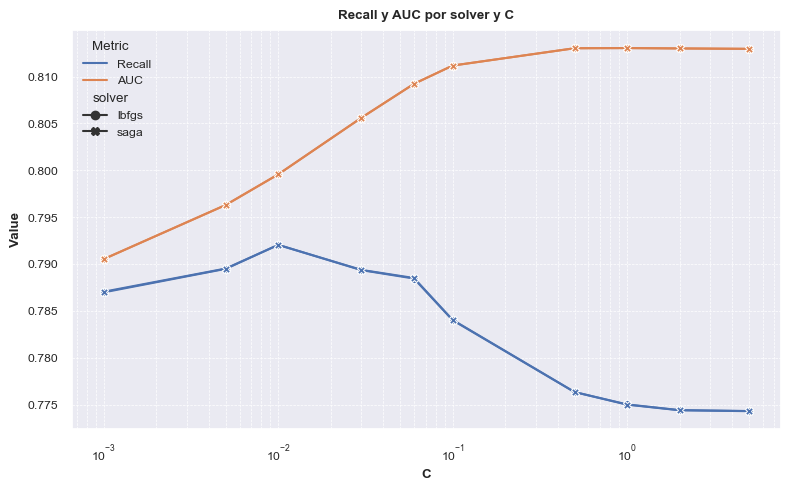

In [217]:
df_long = pd.DataFrame({
    'C': results_stacking['params'].apply(lambda x: x['final_estimator__C']),
    'solver': results_stacking['params'].apply(lambda x: x['final_estimator__solver']),
    'Recall': results_stacking['mean_test_recall'],
    'AUC': results_stacking['mean_test_roc_auc']
})

# Melt para tener una columna “metric” y otra “value”
df_melted = df_long.melt(id_vars=['C', 'solver'], value_vars=['Recall', 'AUC'], 
                         var_name='Metric', value_name='Value')

# Graficar con Seaborn usando hue
plt.figure(figsize=(8,5))
sns.lineplot(data=df_melted, x='C', y='Value', style='solver', hue='Metric', markers=True, dashes=False)
plt.xscale('log')
plt.title('Recall y AUC por solver y C')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [218]:
modelos_stacking = {}

for idx in range(len(results_stacking)):
    # Extraer solo los parámetros de final_estimator
    fe_params = {k.replace("final_estimator__", ""): v 
                 for k, v in results_stacking.iloc[idx].params.items() 
                 if k.startswith("final_estimator__")}

    # Crear el stacking
    modelo = StackingClassifier(
        estimators=modelos_base_stacking,
        final_estimator=LogisticRegression(**fe_params, random_state=seed),
        passthrough=False
    )

    modelo.fit(X_train_work, y_train_work)
    modelos_stacking[f"STACK{idx}"] = modelo

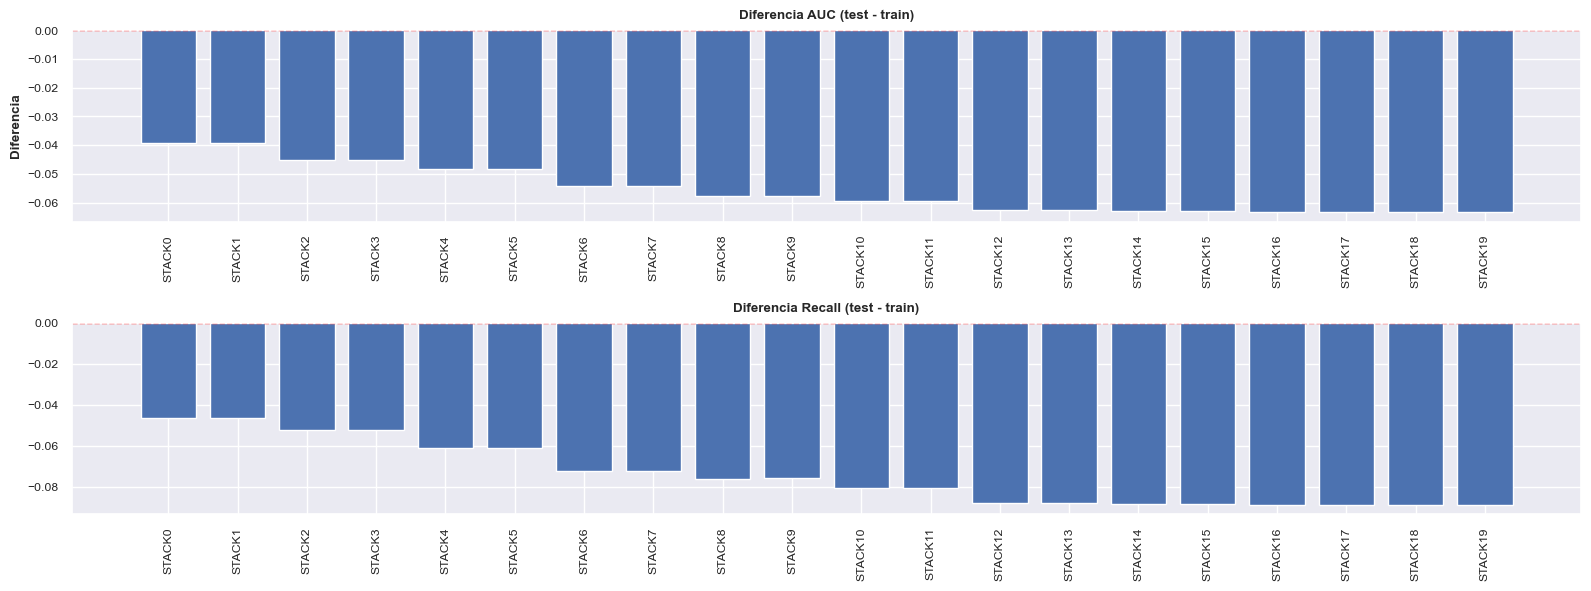

In [219]:
resultados_Stack = plot_train_test_differences(modelos_stacking, 
                                               X_train_work, y_train_work, 
                                               X_test_work, y_test_work)

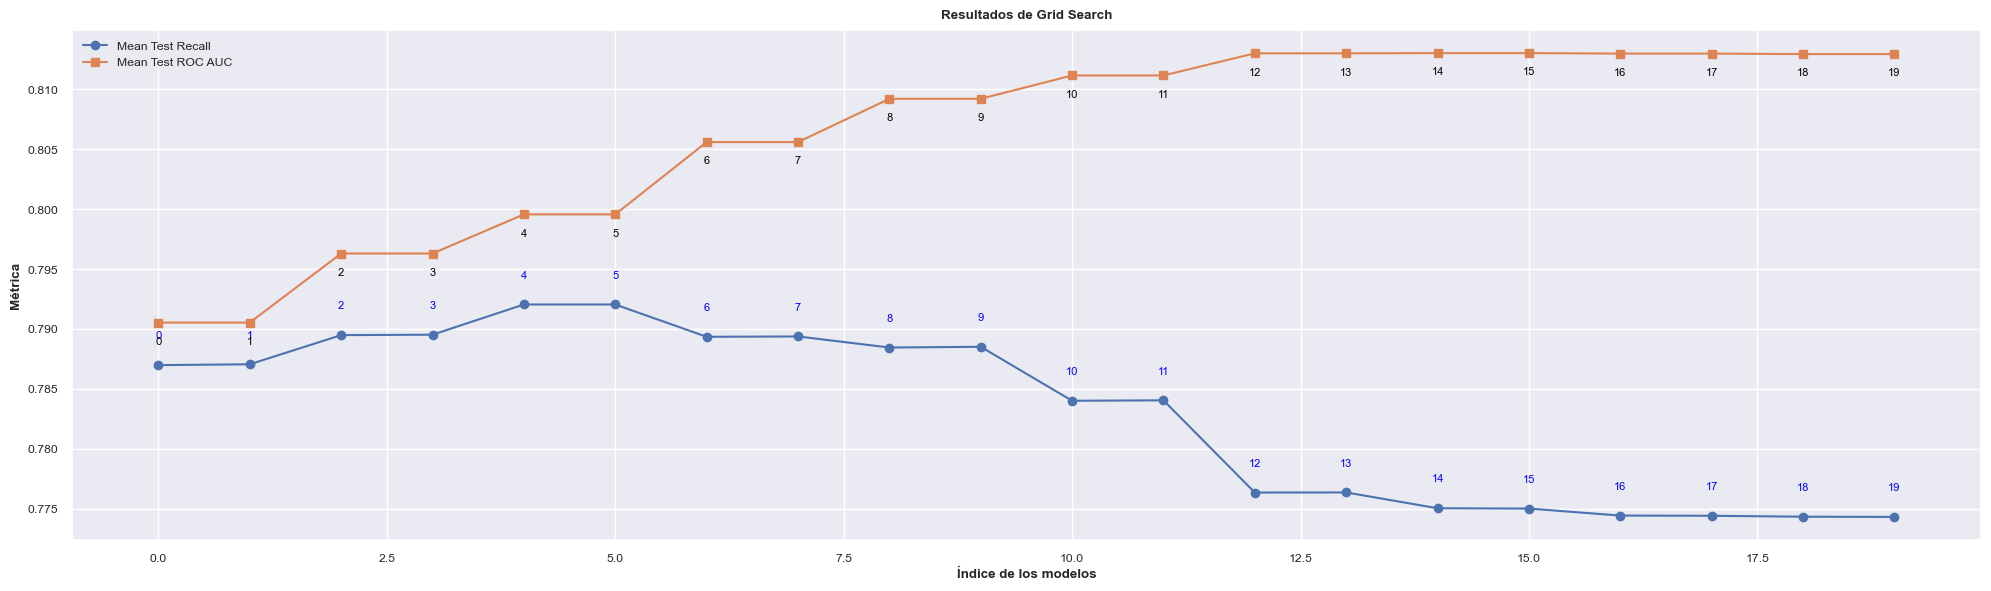

In [220]:
# No hay diferencias en el tipo de solver
graficar_metricas_gridsearch(results_stacking)

In [221]:
print("Mejores hiperparámetros encontrados segun maxima accuracy:")
print(resultados_stacking.best_params_)
print("Mejor precisión en validación cruzada: {:.4f}".format(resultados_stacking.best_score_))

Mejores hiperparámetros encontrados segun maxima accuracy:
{'final_estimator__C': 1.0, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'saga'}
Mejor precisión en validación cruzada: 0.8130


In [222]:
results_stacking[['params', 'mean_test_recall', 'mean_test_roc_auc']].sort_values(by='mean_test_recall',ascending=False).head()

params  \
4   {'final_estimator__C': 0.01, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'lbfgs'}   
5    {'final_estimator__C': 0.01, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'saga'}   
3   {'final_estimator__C': 0.005, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'saga'}   
2  {'final_estimator__C': 0.005, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'lbfgs'}   
7    {'final_estimator__C': 0.03, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'saga'}   

   mean_test_recall  mean_test_roc_auc  
4          0.792067           0.799582  
5          0.792067           0.799582  
3          0.789547           0.796319  
2          0.789513           0.796319  
7          0.789400           0.805612

In [223]:
results_stacking[['params', 'mean_test_recall', 'mean_test_roc_auc']].sort_values(by='mean_test_roc_auc',ascending=False).head()

params  \
15   {'final_estimator__C': 1.0, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'saga'}   
14  {'final_estimator__C': 1.0, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'lbfgs'}   
13   {'final_estimator__C': 0.5, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'saga'}   
12  {'final_estimator__C': 0.5, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'lbfgs'}   
16    {'final_estimator__C': 2, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'lbfgs'}   

    mean_test_recall  mean_test_roc_auc  
15          0.775046           0.813033  
14          0.775072           0.813033  
13          0.776392           0.813014  
12          0.776384           0.813014  
16          0.774463           0.812993

In [224]:
# seleccionamos los modelos basandonos en la grafica
lista_stacking = [0, 1,2,3,4,5,6,7]
resultados = []

for i in lista_stacking:
    resultados.append({
        "Modelo": f"Modelo{i}",
        "Parametros": results_stacking.params.iloc[i],
        "Mean_Recall": results_stacking['mean_test_recall'].iloc[i],
        "Std_Recall": results_stacking['std_test_recall'].iloc[i],
        "Mean_AUC": results_stacking['mean_test_roc_auc'].iloc[i],
        "Std_AUC": results_stacking['std_test_roc_auc'].iloc[i]
    })

# Crear DataFrame
df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values(by="Std_AUC", ascending=True, inplace=True)
df_resultados

Modelo  \
7  Modelo7   
6  Modelo6   
5  Modelo5   
4  Modelo4   
3  Modelo3   
2  Modelo2   
1  Modelo1   
0  Modelo0   

                                                                                                       Parametros  \
7    {'final_estimator__C': 0.03, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'saga'}   
6   {'final_estimator__C': 0.03, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'lbfgs'}   
5    {'final_estimator__C': 0.01, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'saga'}   
4   {'final_estimator__C': 0.01, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'lbfgs'}   
3   {'final_estimator__C': 0.005, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'saga'}   
2  {'final_estimator__C': 0.005, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'lbfgs'}   
1   {'final_estimator__C': 0.001, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'saga'}   
0  {'final_estimator__C': 0.001, 'final_estimator__class_weight': 'balanced', 'final_estimator__solver': 'lbfgs'}   

   Mean_Recall  Std_Recall  Mean_AUC   Std_AUC  
7     0.789400    0.010912  0.805612  0.002223  
6     0.789374    0.010884  0.805612  0.002223  
5     0.792067    0.006519  0.799582  0.002225  
4     0.792067    0.006509  0.799582  0.002225  
3     0.789547    0.004527  0.796319  0.002302  
2     0.789513    0.004549  0.796319  0.002302  
1     0.787080    0.003917  0.790558  0.002310  
0     0.787010    0.003826  0.790558  0.002311

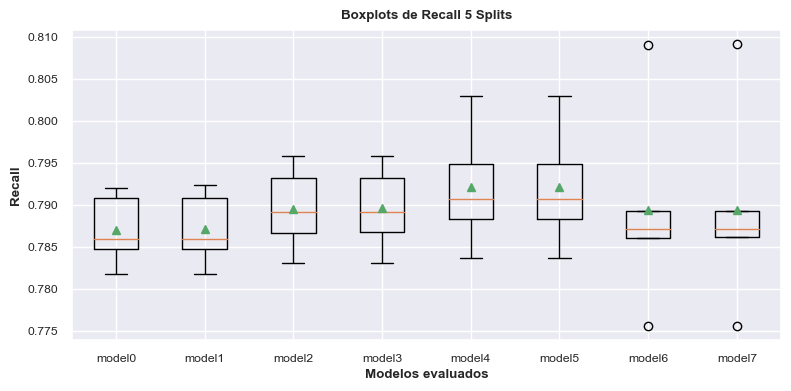

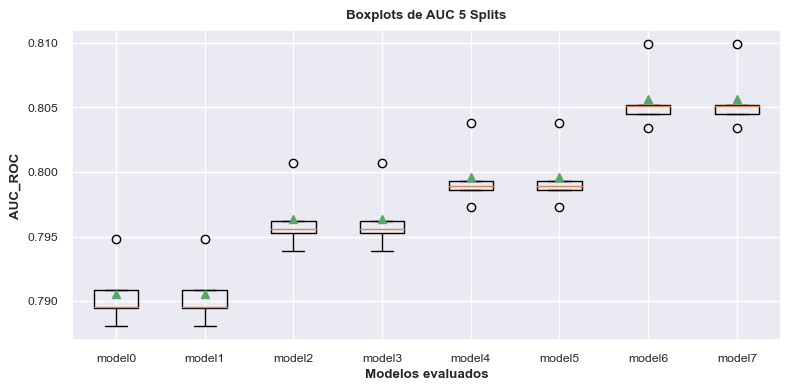

In [225]:
comparar_boxplot_cv5(results_stacking, lista_stacking)
comparar_boxplot_cv5_auc_roc(results_stacking, lista_stacking)

In [226]:
#  guardar los modelos y sus predicciones para evaluar
modelos_stack = {}

for idx in lista_stacking:
    # Extraer solo los parámetros de final_estimator
    fe_params = {k.replace("final_estimator__", ""): v 
                 for k, v in results_stacking.iloc[idx].params.items() 
                 if k.startswith("final_estimator__")}

    # Crear el stacking
    modelo = StackingClassifier(
        estimators=modelos_base_stacking,
        final_estimator=LogisticRegression(**fe_params, random_state=seed),
        passthrough=False
    )

    modelo.fit(X_train_work, y_train_work)
    modelos_stack[f"STACK{idx}"] = modelo

evaluar_modelos_train_test(modelos_stack, X_train_work, y_train_work, X_test_work, y_test_work)

AUC para cada modelo:
STACK0 | AUC_Train: 0.7914 | AUC_Test: 0.7519 | Diferencia: -0.0394
STACK1 | AUC_Train: 0.7914 | AUC_Test: 0.7519 | Diferencia: -0.0394
STACK2 | AUC_Train: 0.7974 | AUC_Test: 0.7523 | Diferencia: -0.0450
STACK3 | AUC_Train: 0.7974 | AUC_Test: 0.7523 | Diferencia: -0.0450
STACK4 | AUC_Train: 0.8007 | AUC_Test: 0.7525 | Diferencia: -0.0483
STACK5 | AUC_Train: 0.8007 | AUC_Test: 0.7525 | Diferencia: -0.0483
STACK6 | AUC_Train: 0.8068 | AUC_Test: 0.7524 | Diferencia: -0.0544
STACK7 | AUC_Train: 0.8068 | AUC_Test: 0.7524 | Diferencia: -0.0544

Recall para cada modelo:
STACK0 | Recall_Train: 0.7869 | Recall_Test: 0.7404 | Diferencia: -0.0465
STACK1 | Recall_Train: 0.7869 | Recall_Test: 0.7404 | Diferencia: -0.0465
STACK2 | Recall_Train: 0.7879 | Recall_Test: 0.7359 | Diferencia: -0.0520
STACK3 | Recall_Train: 0.7879 | Recall_Test: 0.7359 | Diferencia: -0.0520
STACK4 | Recall_Train: 0.7907 | Recall_Test: 0.7297 | Diferencia: -0.0609
STACK5 | Recall_Train: 0.7906 | Recall

In [227]:
# Parece que los modelos 2-3 tienen mejor balance recall/auc
# nohay demasiada diferencia entre train-test, aceptable
# generalizan igual que el resto con menos sobreajuste
# el 3 tiene menos std en recall
# {'final_estimator__C': 0.005, 'final_estimator__class_weight': 'balanced', 
# 'final_estimator__solver': 'saga'} 	

modelo_STCK= StackingClassifier(
    estimators=modelos_base_stacking,  # Modelos base
    final_estimator=LogisticRegression(C=0.005, solver='saga', 
                                       class_weight='balanced', random_state=seed), 
    passthrough=False)

modelo_STCK.fit(X_train_work, y_train_work)

StackingClassifier(estimators=[('RF',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=5,
                                                       max_features=0.6,
                                                       max_samples=0.7,
                                                       min_samples_leaf=10,
                                                       random_state=12345)),
                               ('LR',
                                LogisticRegression(C=1, class_weight='balanced',
                                                   random_state=12345)),
                               ('LGB',
                                LGBMClassifier(class_weight='balanced',
                                               learning_rate=0.01, max_depth=7,
                                               min_child_samples=15, n_jobs=-1,
                                               random_state=12345,
                                               reg_alpha=0.1, subsample=0.6,
                                               verbose=-1))],
                   final_estimator=LogisticRegression(C=0.005,
                                                      class_weight='balanced',
                                                      random_state=12345,
                                                      solver='saga'))

----------Métricas para el modelo STCK:----------

  Accuracy: 0.6664
  Recall:   0.7359
  AUC:      0.7523



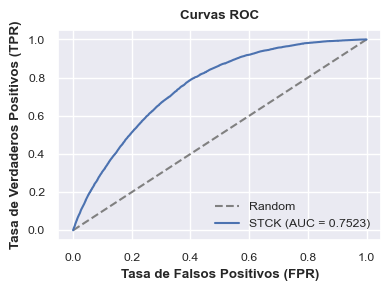


Matriz de confusion lineal. Pto de Corte=0.50


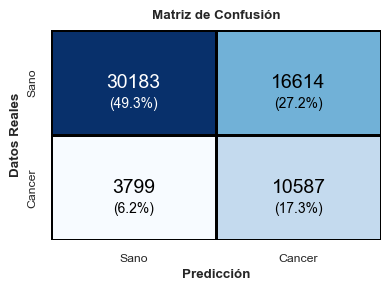


Informe de clasificación para STCK:
              precision    recall  f1-score   support

           0       0.89      0.64      0.75     46797
           1       0.39      0.74      0.51     14386

    accuracy                           0.67     61183
   macro avg       0.64      0.69      0.63     61183
weighted avg       0.77      0.67      0.69     61183



In [228]:
# parametros de bondad de ajuste
evaluacion_test_modelo([(modelo_STCK, 'STCK')], X_test_work, y_test_work)

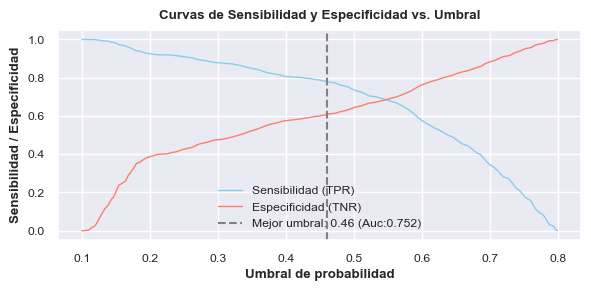

Mejor umbral según Youden para STCK: 0.46


In [229]:
best_thresh_STCK =youden(modelo_STCK, X_test_work, y_test_work)
print(f"Mejor umbral según Youden para STCK: {best_thresh_STCK:.2f}")

----------Métricas para el modelo STCK:----------

  Accuracy: 0.6486
  Recall:   0.7792
  AUC:      0.7523



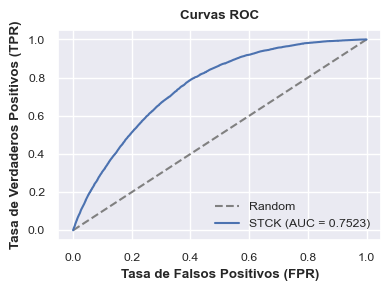


Matriz de confusion lineal. Pto de Corte=0.46


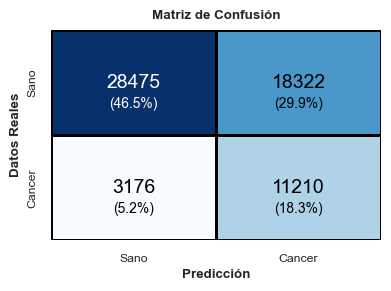


Informe de clasificación para STCK:
              precision    recall  f1-score   support

           0       0.90      0.61      0.73     46797
           1       0.38      0.78      0.51     14386

    accuracy                           0.65     61183
   macro avg       0.64      0.69      0.62     61183
weighted avg       0.78      0.65      0.68     61183



In [230]:
# parametros de bondad de ajuste con Youden
evaluacion_test_modelo([(modelo_STCK, 'STCK')], 
                       X_test_work, y_test_work, best_thresh_STCK)

##	**Comparación de resultados**

Se procedió a comparar los modelos para evaluar el desempeño de diferentes clasificadores individuales y de un modelo de stacking (ensamble), con el fin de determinar si el stacking mejora la calidad de las predicciones en términos de recall, AUC y matriz de confusión.

El Random Forest alcanza la mayor recall para la clase 1, mientras que LGB logra el mejor AUC, lo que indica una mayor capacidad de discriminación entre clases. Por su parte, el modelo de stacking no mejora significativamente ninguna de las métricas respecto a los modelos base.

Si el stacking presentara mejoras significativas frente a los modelos individuales, se podría concluir que la combinación de distintos modelos aporta diversidad y mejora la generalización. Sin embargo, en este caso, no se observa tal beneficio, por lo que no resulta ventajoso utilizar stacking en lugar de un modelo base bien optimizado.

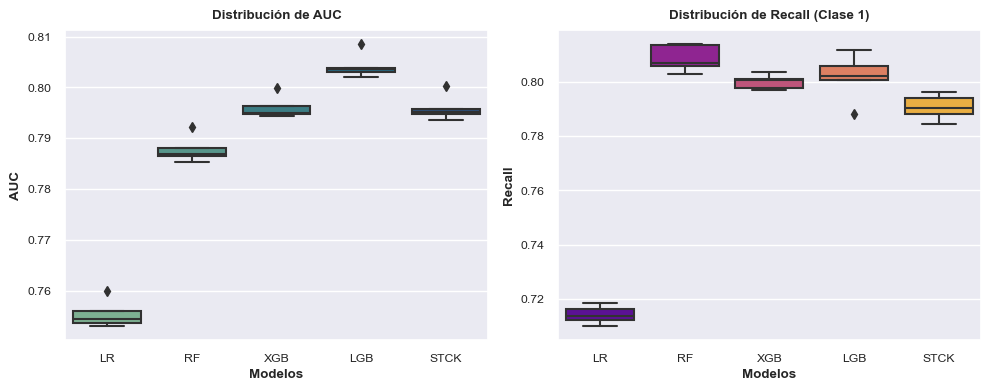

In [231]:
modelos_comparacion= [
    (modelo_LR, 'LR'),       
    (modelo_RF, 'RF'),      
    (modelo_XGB, 'XGB'),       
    (modelo_LGB, 'LGB'), 
    (modelo_STCK, 'STCK')
]

comparar_modelos_CV5_boxplot(modelos_comparacion, X_train_work, y_train_work)

Para evaluar la estabilidad y robustez de los modelos frente a la aleatoriedad inherente del entrenamiento, se cambia la semilla (random_state o seed).

A veces un modelo puede parecer excelente simplemente porque la semilla inicial favoreció ciertas particiones o inicializaciones. Probar con distintas semillas ayuda a tener una evaluación más objetiva.

Si las métricas cambian drásticamente al variar la semilla, significa que el modelo no es estable y puede no generalizar bien. Si los resultados son consistentes, entonces el modelo es robusto frente a la aleatoriedad. Cambiar la semilla te permite ver si los resultados dependen demasiado de una configuración particular.

Al cambiar la semilla aleatoria de los modelos, es necesario volver a dividir los datos en conjuntos de entrenamiento y prueba, así como reentrenar y validar los modelos con la misma estructura de datos. Esto garantiza que la evaluación sea consistente y justa, evitando que los resultados dependan únicamente de la inicialización o del ordenamiento de los datos. Además, permite analizar la estabilidad y robustez de los modelos frente a la aleatoriedad inherente al entrenamiento y a la partición de los datos, asegurando que las métricas obtenidas reflejen el comportamiento real de los clasificadores y no particularidades de una partición específica.

In [232]:
# la semilla utilizada para entrenar la nueva particion de datos
new_seed=seed+200

In [233]:
# Nueva partición de datos

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X, y, test_size=0.2, random_state=new_seed, stratify=y)

imputer = IterativeImputer(
    estimator=DecisionTreeClassifier(random_state=new_seed), 
    random_state=new_seed)

preprocessor  = ColumnTransformer([
    ("imputer", imputer , cat_w_miss),
    ('OneH_binary', OneHotEncoder(drop='if_binary') , cat_binary ),
    ('OneH_nom', OneHotEncoder(drop='first'), cat_nom),
    ("ord_enc", OrdinalEncoder(categories=[age_order, missing_order]), ['age', 'prop_missings']),
    ], remainder='passthrough')

X_train_prep_2 = preprocessor.fit_transform(X_train_2)
X_test_prep_2 = preprocessor.transform(X_test_2)

original_names_2 = preprocessor.get_feature_names_out()
clean_names_2 = [f.split("__")[-1] for f in original_names]

X_train_fe_2 = pd.DataFrame(X_train_prep_2, columns=clean_names_2, index=X_train_2.index)
X_test_fe_2 = pd.DataFrame(X_test_prep_2, columns=clean_names_2, index=X_test_2.index)

In [234]:
balancer2 = Pipeline(steps=[
    ("under", RandomUnderSampler(sampling_strategy=0.5, random_state=new_seed)),
    ("smote", SMOTE(sampling_strategy=1, k_neighbors=3, random_state=new_seed)),
])

X_train_res_2, y_train_res_2 = balancer2.fit_resample(X_train_fe_2, y_train_2)

print("Distribución original de clases en entrenamiento:")
vc_train_2 = y_train_2.value_counts()
vc_train_norm_2 = y_train_2.value_counts(normalize=True) * 100 
for cls in vc_train_2.index:
    print(f"{cls}\t{vc_train_2[cls]} ({vc_train_norm_2[cls]:.1f}%)")

print("\nDistribución tras técnica híbrida SMOTE+RUS:")
y_res_series_2 = pd.Series(y_train_res_2)
vc_res_2 = y_res_series_2.value_counts()
vc_res_norm_2 = y_res_series_2.value_counts(normalize=True) * 100
for cls in vc_res_2.index:
    print(f"{cls}\t{vc_res_2[cls]} ({vc_res_norm_2[cls]:.1f}%)")

Distribución original de clases en entrenamiento:
0	187186 (76.5%)
1	57545 (23.5%)

Distribución tras técnica híbrida SMOTE+RUS:
0	115090 (50.0%)
1	115090 (50.0%)


In [235]:
X_train_work2 = X_train_res_2.drop(columns=features_a_quitar)
X_test_work2 = X_test_fe_2.drop(columns=features_a_quitar)
y_train_work2 = y_train_res_2.astype(int)
y_test_work2 = y_test_2.astype(int)

X_train_work.shape

(230180, 10)

In [236]:
# Reentrenamiento de modelos

## LR
modelo_LR2= LogisticRegression(C=1, penalty="l2",
                              solver= "lbfgs", 
                              random_state=new_seed,
                              class_weight='balanced')
## RF
modelo_RF2= RandomForestClassifier( bootstrap=True, class_weight="balanced",  
                                  n_estimators=100, max_depth=5, 
                                  max_features=0.6, max_samples=0.7, 
                                  min_samples_leaf=10, random_state=new_seed)
## XGB
modelo_XGB2= XGBClassifier(colsample_bytree=0.8, eta=0.01,
                          gamma=0.2, max_depth=5, 
                          min_child_weight=10, subsample= 0.8,
                          n_estimators=100, random_state=new_seed)
## LGB
modelo_LGB2= LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, 
                           learning_rate=0.01, max_depth=7, 
                           min_child_samples=15, n_estimators=100, 
                           reg_alpha = 0.1, subsample=0.6, random_state=new_seed, 
                           verbose=-1, n_jobs=-1, class_weight='balanced')

## STCK
modelos_base_stacking2 = [
    ('RF2', modelo_RF2),
    ('LR2', modelo_LR2),
    ('LGB2', modelo_LGB2)
]

modelo_STCK2= StackingClassifier(
    estimators=modelos_base_stacking2,  # Modelos base
    final_estimator=LogisticRegression(C=0.005, solver='saga', 
                                       class_weight='balanced', random_state=new_seed), 
    passthrough=False)

# Entrenamiento modelos
modelo_LR2.fit(X_train_work2, y_train_work2)
modelo_RF2.fit(X_train_work2, y_train_work2)
modelo_XGB2.fit(X_train_work2, y_train_work2)
modelo_LGB2.fit(X_train_work2, y_train_work2)
modelo_STCK2.fit(X_train_work2, y_train_work2)

StackingClassifier(estimators=[('RF2',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=5,
                                                       max_features=0.6,
                                                       max_samples=0.7,
                                                       min_samples_leaf=10,
                                                       random_state=12545)),
                               ('LR2',
                                LogisticRegression(C=1, class_weight='balanced',
                                                   random_state=12545)),
                               ('LGB2',
                                LGBMClassifier(class_weight='balanced',
                                               learning_rate=0.01, max_depth=7,
                                               min_child_samples=15, n_jobs=-1,
                                               random_state=12545,
                                               reg_alpha=0.1, subsample=0.6,
                                               verbose=-1))],
                   final_estimator=LogisticRegression(C=0.005,
                                                      class_weight='balanced',
                                                      random_state=12545,
                                                      solver='saga'))

In [237]:
# Diferencia train-test
modelos_comparacion2= [
    (modelo_LR2, 'LR'),       
    (modelo_RF2, 'RF'),      
    (modelo_XGB2, 'XGB'),       
    (modelo_LGB2, 'LGB'), 
    (modelo_STCK2, 'STCK')
]


for modelo, nombre in modelos_comparacion2:
    # Predicciones y probabilidades en train
    y_train_pred = modelo.predict(X_train_work2)
    y_train_prob = modelo.predict_proba(X_train_work2)[:, 1]
    
    # Predicciones y probabilidades en test
    y_test_pred = modelo.predict(X_test_work2)
    y_test_prob = modelo.predict_proba(X_test_work2)[:, 1]
    
    # Calcular métricas
    auc_train = roc_auc_score(y_train_work2, y_train_prob)
    auc_test = roc_auc_score(y_test_work2, y_test_prob)
    diff_auc = auc_test - auc_train
    
    recall_train = recall_score(y_train_work2, y_train_pred)
    recall_test = recall_score(y_test_work2, y_test_pred)
    diff_recall = recall_test - recall_train
    
    # Mostrar resultados
    print(f"{nombre} | AUC_Train: {auc_train:.4f} | AUC_Test: {auc_test:.4f} | Diferencia: {diff_auc:.4f}")
    print(f"{nombre} | Recall_Train: {recall_train:.4f} | Recall_Test: {recall_test:.4f} | Diferencia: {diff_recall:.4f}")
    print("-" * 80)

LR | AUC_Train: 0.7546 | AUC_Test: 0.7475 | Diferencia: -0.0070
LR | Recall_Train: 0.7143 | Recall_Test: 0.7032 | Diferencia: -0.0111
--------------------------------------------------------------------------------
RF | AUC_Train: 0.7869 | AUC_Test: 0.7491 | Diferencia: -0.0378
RF | Recall_Train: 0.8064 | Recall_Test: 0.7637 | Diferencia: -0.0427
--------------------------------------------------------------------------------
XGB | AUC_Train: 0.7977 | AUC_Test: 0.7533 | Diferencia: -0.0444
XGB | Recall_Train: 0.7996 | Recall_Test: 0.7475 | Diferencia: -0.0522
--------------------------------------------------------------------------------
LGB | AUC_Train: 0.8044 | AUC_Test: 0.7530 | Diferencia: -0.0515
LGB | Recall_Train: 0.8103 | Recall_Test: 0.7489 | Diferencia: -0.0615
--------------------------------------------------------------------------------
STCK | AUC_Train: 0.7967 | AUC_Test: 0.7524 | Diferencia: -0.0443
STCK | Recall_Train: 0.7992 | Recall_Test: 0.7491 | Diferencia: -0.050

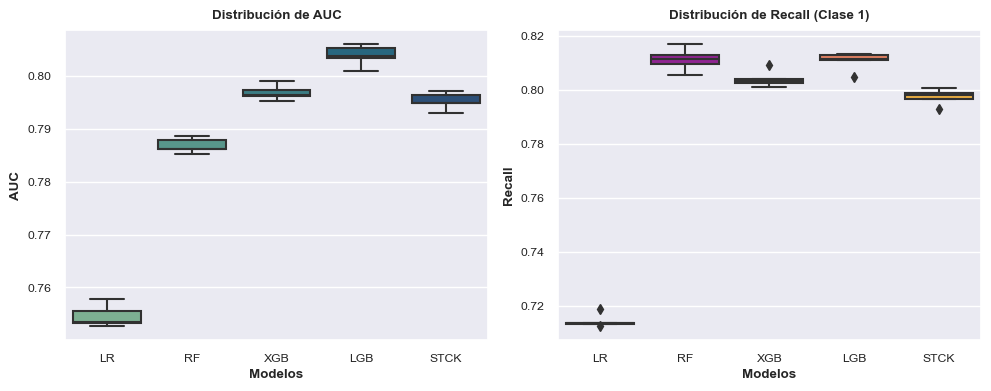

In [238]:
# comparación metricas
comparar_modelos_CV5_boxplot(modelos_comparacion2, X_train_work2, y_train_work2)

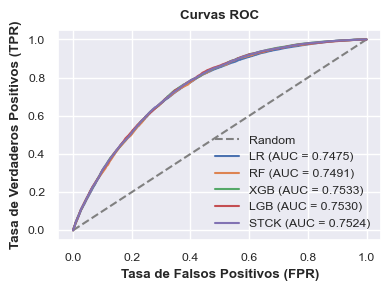

In [239]:
# curvas roc
graficar_roc_multiple_con_display(modelos_comparacion2, X_test_work2, y_test_work2)

----------Métricas para el modelo LR:----------

  Accuracy: 0.6770
  Recall:   0.7032
  AUC:      0.7475



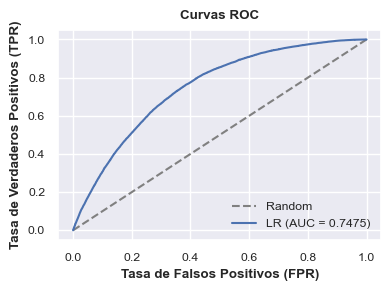


Matriz de confusion lineal. Pto de Corte=0.50


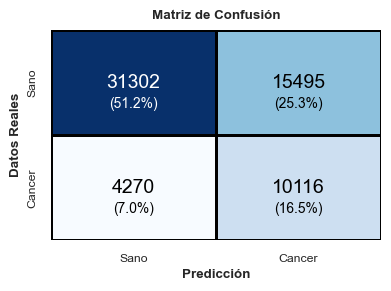


Informe de clasificación para LR:
              precision    recall  f1-score   support

           0       0.88      0.67      0.76     46797
           1       0.39      0.70      0.51     14386

    accuracy                           0.68     61183
   macro avg       0.64      0.69      0.63     61183
weighted avg       0.77      0.68      0.70     61183

----------Métricas para el modelo RF:----------

  Accuracy: 0.6456
  Recall:   0.7637
  AUC:      0.7491



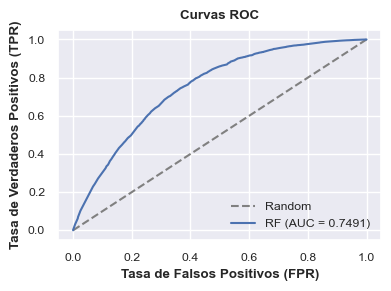


Matriz de confusion lineal. Pto de Corte=0.50


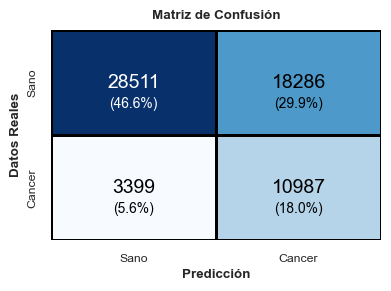


Informe de clasificación para RF:
              precision    recall  f1-score   support

           0       0.89      0.61      0.72     46797
           1       0.38      0.76      0.50     14386

    accuracy                           0.65     61183
   macro avg       0.63      0.69      0.61     61183
weighted avg       0.77      0.65      0.67     61183

----------Métricas para el modelo XGB:----------

  Accuracy: 0.6643
  Recall:   0.7475
  AUC:      0.7533



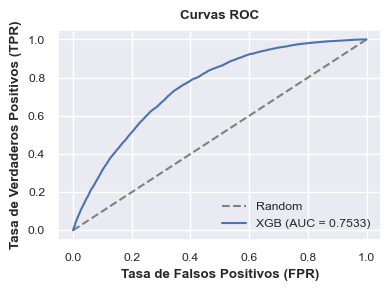


Matriz de confusion lineal. Pto de Corte=0.50


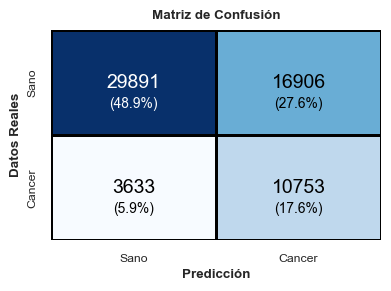


Informe de clasificación para XGB:
              precision    recall  f1-score   support

           0       0.89      0.64      0.74     46797
           1       0.39      0.75      0.51     14386

    accuracy                           0.66     61183
   macro avg       0.64      0.69      0.63     61183
weighted avg       0.77      0.66      0.69     61183

----------Métricas para el modelo LGB:----------

  Accuracy: 0.6611
  Recall:   0.7489
  AUC:      0.7530



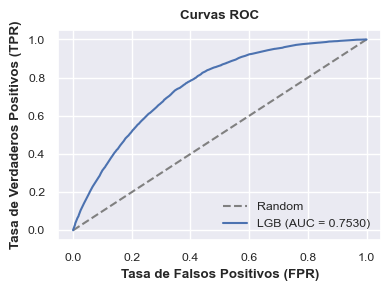


Matriz de confusion lineal. Pto de Corte=0.50


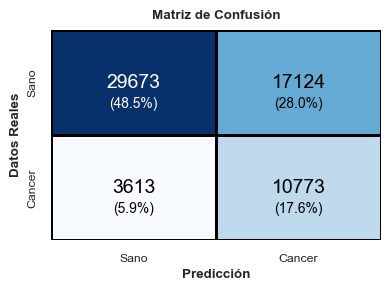


Informe de clasificación para LGB:
              precision    recall  f1-score   support

           0       0.89      0.63      0.74     46797
           1       0.39      0.75      0.51     14386

    accuracy                           0.66     61183
   macro avg       0.64      0.69      0.63     61183
weighted avg       0.77      0.66      0.69     61183

----------Métricas para el modelo STCK:----------

  Accuracy: 0.6613
  Recall:   0.7491
  AUC:      0.7524



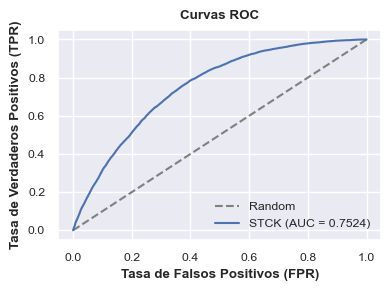


Matriz de confusion lineal. Pto de Corte=0.50


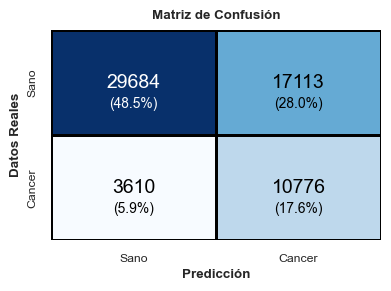


Informe de clasificación para STCK:
              precision    recall  f1-score   support

           0       0.89      0.63      0.74     46797
           1       0.39      0.75      0.51     14386

    accuracy                           0.66     61183
   macro avg       0.64      0.69      0.63     61183
weighted avg       0.77      0.66      0.69     61183



In [240]:
# matrices de confusion
evaluacion_test_modelo(modelos_comparacion2, X_test_work2, y_test_work2)

# **Discusión de Resultados, Elección del Mejor Modelo e Interpretabilidad**

## Elección del Mejor Modelo

Los resultados muestran que las variaciones entre semillas son mínimas: por ejemplo, LR presenta un AUC de prueba de 0.7473 y 0.7475, y un Recall de 0.7068 y 0.7032; RF, XGB y LGB muestran diferencias igualmente pequeñas. El modelo de Stacking presenta una ligera mayor variabilidad en Recall (0.7359 vs 0.7491), lo que es esperable al combinar modelos, pero no hay cambios drásticos que indiquen inestabilidad. Estos resultados indican que todos los modelos evaluados son robustos frente a la aleatoriedad de la partición de datos y las semillas, lo que refuerza la fiabilidad de las conclusiones obtenidas sobre su rendimiento.

¿Cuál sería el mejor modelo?

- Random Forest (RF): Mayor Recall de la clase 1 en todas las pruebas, lo que indica que es el modelo que mejor identifica los casos positivos. Sin embargo, su AUC es ligeramente inferior al de XGB y LGB.

- LightGBM (LGB): Mejor AUC en general, buena capacidad de discriminación, aunque su Recall es un poco menor que RF.

- XGBoost (XGB): Equilibrio entre AUC y Recall, rendimiento consistente, aunque no sobresale en ninguna métrica.

- Logistic Regression (LR): Rendimiento más bajo en Recall y AUC comparado con los modelos basados en árboles.

- Stacking: No mejora significativamente ninguna métrica respecto a los modelos individuales; su ventaja sería la combinación de modelos, pero no aporta valor adicional.

Tras evaluar los distintos modelos candidatos —Logistic Regression, Random Forest, XGBoost, LightGBM y un modelo de Stacking— se observa que los modelos basados en árboles (RF, XGB, LGB) superan consistentemente a la regresión logística en términos de Recall y AUC. Random Forest alcanza el mayor Recall de la clase positiva, lo que indica que es el modelo más eficaz para identificar correctamente los casos relevantes. Por su parte, LightGBM presenta la mayor AUC, mostrando una capacidad ligeramente superior para discriminar entre clases. El modelo de Stacking no aporta mejoras significativas frente a los modelos individuales, por lo que su complejidad adicional no se justifica en este caso.

En un contexto médico, el Recall es prioritario (no queremos dejar casos positivos sin diagnosticar, aunque aumente un poco el número de falsos positivos). Por eso, aunque LGBM pueda tener un AUC marginalmente mejor, RF es más adecuado porque logra mejor Recall. Además RF es más interpretable (importancia de variables, visualización de árboles), más sencillo, robusto y estable (varias semillas muestran resultados consistentes).

Por tanto, Random Forest se elige como modelo principal, priorizando la detección de casos positivos, aunque LightGBM también constituye una alternativa válida

In [241]:
# el punto de corte que se usaría sería el de Youden para classificar los casos
Win_model = RandomForestClassifier( bootstrap=True, class_weight="balanced",  
                                  n_estimators=100, max_depth=5, 
                                  max_features=0.6, max_samples=0.7, 
                                  min_samples_leaf=10, random_state=seed)

Win_model.fit(X_train_work, y_train_work)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=0.6,
                       max_samples=0.7, min_samples_leaf=10,
                       random_state=12345)

In [242]:
# Guardamos el modelo
with open("Win_model.pkl", "wb") as f:
    pickle.dump(Win_model, f)

## Interpretabilidad

SHAP (SHapley Additive exPlanations) se usó para evaluar el impacto y la importancia de cada variable de entrada en el resultado del modelo. Es una herramienta de interpretación de modelos de Machine Learning que te dice cuánto contribuye cada característica a la predicción de un modelo. Se basa en los valores de Shapley de la teoría de juegos. Este framework permite que cualquier algoritmo de Aprendizaje Automático sea esencialmente “explicado” al proporcionar visualizaciones intuitivas e interactivas que apuntan a mostrar qué características son más relevantes para una determinada predicción y para el modelo en su conjunto. Este enfoque proporcionó información sobre los factores más influyentes en la predicción del riesgo de cáncer de mama.

Al trabajar con modelos de aprendizaje automático complejos como Random Forest, la interpretabilidad se vuelve clave. Los valores SHAP son excelentes porque permiten ver el modelo desde dos perspectivas: global y local.

La interpretabilidad global ayuda a comprender el comportamiento general del modelo. Es como observar el "bosque completo" y comprender qué características son importantes en promedio. Esto resulta útil cuando se desea ver qué factores impulsan las predicciones en general.

La interpretabilidad local se centra en las predicciones individuales. En este caso, los valores SHAP muestran exactamente por qué un modelo realizó una predicción específica para un punto de datos en particular. Es como "acercarse a un solo árbol" y examinar sus ramas. ¿Por qué el modelo pensó que este paciente pude desarrollar cáncer? SHAP da la respuesta desglosando la contribución de cada característica.

In [243]:
# Parche para compatibilidad con SHAP
if not hasattr(np, 'bool'):
    np.bool = bool

# Inicializar javascript
shap.initjs()

In [244]:
# Detecta la estructura de tu modelo basado en árbol y calcula valores SHAP.
explainer = shap.TreeExplainer(Win_model)

# Contiene la contribución de cada feature a la predicción.
shap_values = explainer.shap_values(X_test_work)

# Elegimos la clase positiva
shap_values_class1 = shap_values[1]

In [245]:
with open("explainer.pkl", "wb") as f:
    pickle.dump(explainer, f)

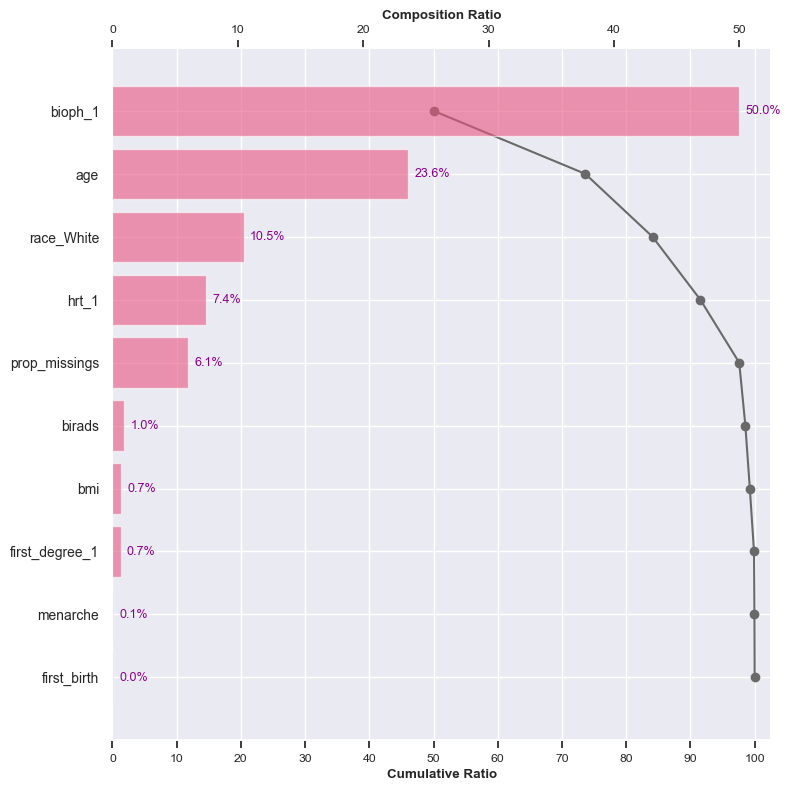

In [246]:
# Importancia global de características
# Muestra la importancia promedio de cada feature. 
# Barras más largas → features más influyentes.

make_shap_waterfall_plot(shap_values_class1, X_test_work)

Según el gráfico de Waterfall, la variable más importante es Bioph, la cual tiene el 50% de la explicabilidad del modelo, seguido en este order age (24%), race_white (11%), hrt (7%),  prop_missing (6%). Entre bioph, age, race_white, se explica el 84% del modelo. Las primeras 9 variables explican el 100% del modelo.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


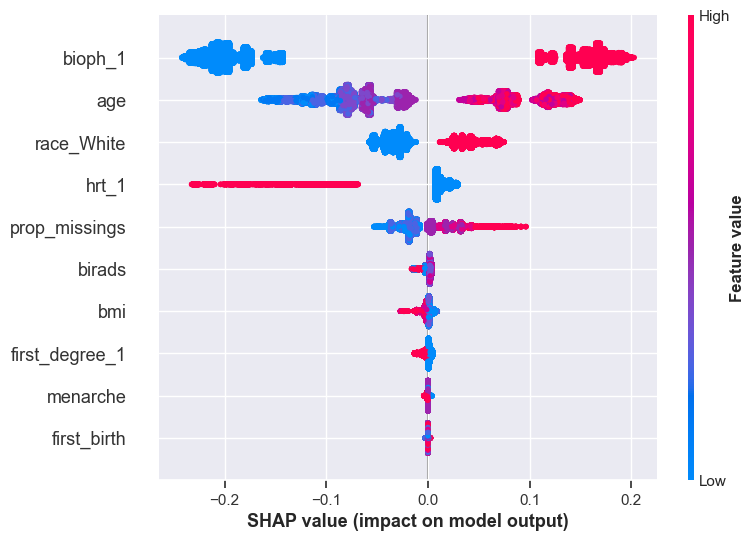

In [247]:
# Distribución del impacto de cada feature en las predicciones
shap.summary_plot(shap_values_class1, X_test_work, plot_type="dot", show=True)

Se puede observar la distribución del impacto de la característica en el modelo, estimado mediante SHAP. Este gráfico ordena las características según la suma de las magnitudes de los valores SHAP de todas las muestras y muestra el orden de importancia de las características. Cada punto representa un paciente. El color representa el valor de la característica (rojo alto, azul bajo). El eje x mide el impacto en el resultado del modelo (derecha positivo, izquierda negativo). Un valor positivo indica riesgo de cáncer de mama y un valor negativo, un buen pronóstico.

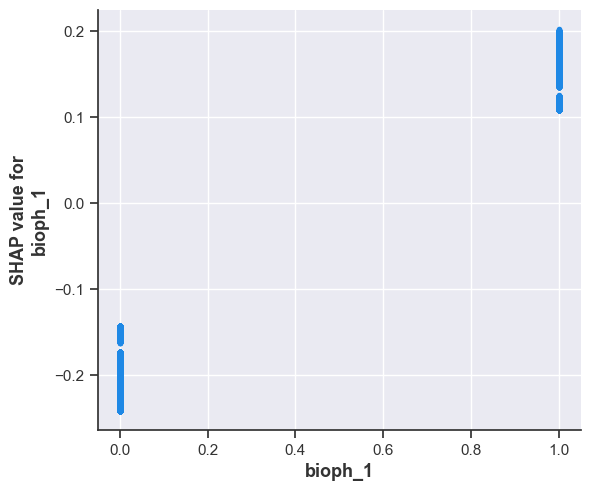

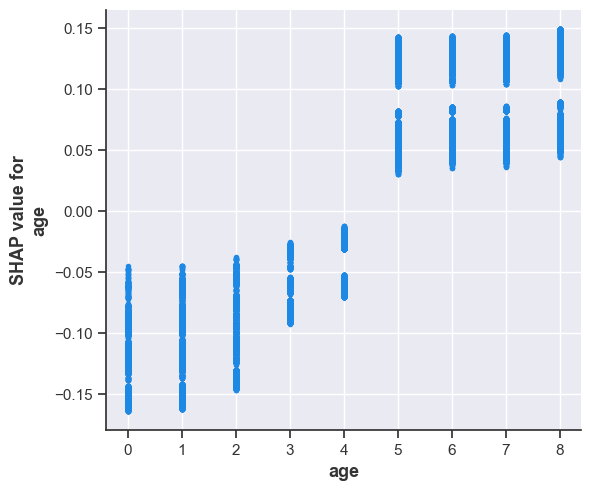

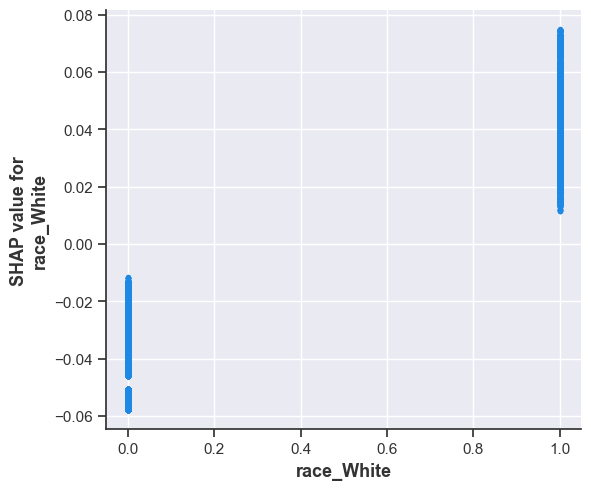

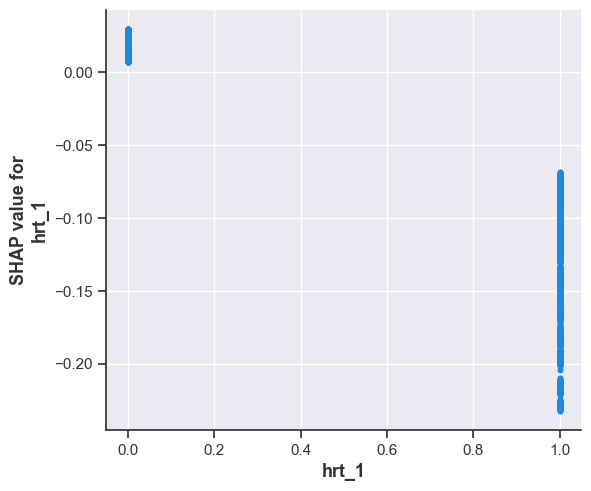

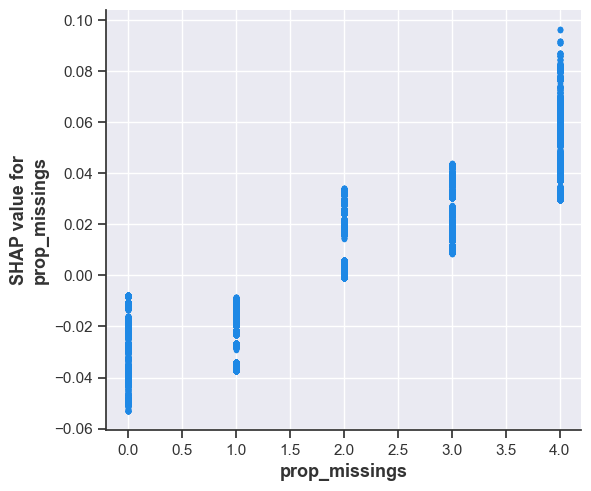

In [248]:
# Examinemos top features y su dependence plots
top_features = ['bioph_1', 'age', 'race_White', 'hrt_1', 'prop_missings']

for feature in top_features:
    shap.dependence_plot(feature, shap_values[1], X_test_work, interaction_index=None)

Basado en los dependence plots, es claro que los pacientes que tienen probabilidad de padecer cancer se caracterizan por:
- una biopsia previa
- edades igual o por encima del grupo 5 (45-49)
- de raza blanca
- no pasaron por terapia hormonal

In [249]:
# Explicación local (ejemplo de un paciente concreto)
# Valores SHAP de una predicción individual

def plot_force_patient(i: int):
    plt.figure(figsize=(8, 4))
    shap.force_plot(
        explainer.expected_value[1],      
        shap_values_class1[i, :],        
        X_test_work.iloc[i, :],         
        matplotlib=True
    )
    plt.tight_layout()
    plt.show()

    # --- Top 5 features más importantes ---
    print('\n')
    top_features = X_test_work.columns[shap_values_class1[i, :].argsort()[::-1]][:5]
    df_top5 = pd.DataFrame({
        'Feature': top_features,
        'Valor': [X_test_work.iloc[i][f] for f in top_features],
        'Contribución SHAP': [shap_values_class1[i, X_test_work.columns.get_loc(f)] for f in top_features]
    })
    df_top5['Valor'] = df_top5['Valor'].round(2)
    df_top5['Contribución SHAP'] = df_top5['Contribución SHAP'].round(3)
    print(f"Influencia de las features en la predicción de cáncer de mama de la paciente no. #{i}:")
    display(df_top5)
            

# Widget interactivo: slider para escoger el paciente
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(X_test_work)-1,
    step=1,
    description='No. Paciente:'
)

widgets.interact(plot_force_patient, i=slider)

interactive(children=(IntSlider(value=0, description='No. Paciente:', max=61182), Output()), _dom_classes=('wi…

<function __main__.plot_force_patient(i: int)>

Lo que se ve arriba es un force plot que muestra cómo cada feature afecta la predicción de un paciente concreto.   
Los valores de las features en rosa contribuyen a subir la predicción hacia la clase positiva (cancer)   
El tamaño de la barra muestra la magnitud del efecto de esa feature.   
Los valores de las features en azul contribuyen a bajar la predicción, es decir, hacia la clase negativa   
La suma de todas las contribuciones individuales de las features explica la diferencia entre el valor base del modelo (0.5) y la predicción final. Por debajo de la base line, menos probabilidad de padecer cancer.

<br>

# **Productivización del Modelo**

Tras el desarrollo, entrenamiento y validación del modelo predictivo, se procedió a su despliegue a producción mediante una aplicación web interactiva implementada con Streamlit. El objetivo fue permitir la evaluación de riesgo individual de manera ágil y accesible, sin requerir conocimientos técnicos en programación.

Los pasos metodológicos fueron los siguientes:

- Serialización del modelo y preprocesador: Se almacenaron el modelo entrenado y el preprocesador de datos en archivos binarios (pickle), garantizando que la transformación de las variables y las predicciones sean consistentes con el entrenamiento original.

- Gestión de datos de paciente: Los datos introducidos se almacenan de forma anónima en un archivo CSV, creando así una base de datos que puede utilizarse para mejorar y recalibrar el modelo en futuras versiones, garantizando privacidad y confidencialidad.

- Diseño de la interfaz de usuario: La aplicación permite la introducción de los datos de la paciente a través de selectores desplegables, categorizando adecuadamente las variables ordinales y nominales según las reglas definidas en el conjunto de entrenamiento.

- Predicción en tiempo real: Cada entrada es transformada automáticamente por el preprocesador antes de ser evaluada por el modelo, generando tanto la predicción de riesgo como la probabilidad asociada. Se implementó además un umbral óptimo basado en el índice de Youden para la clasificación binaria, garantizando un balance entre sensibilidad y especificidad según lo estudiado.

- Interpretabilidad del modelo: Se incorporaron herramientas de explicación basadas en SHAP (SHapley Additive exPlanations), permitiendo visualizar la contribución de las principales variables a la predicción individual, lo que aumenta la transparencia y la confianza en los resultados.

- Presentación y experiencia de usuario: Se estructuró la app con un título descriptivo, subtítulo explicativo y elementos gráficos (logo institucional), buscando claridad y profesionalidad en la interacción con el usuario final.

Esta implementación convierte el modelo de un prototipo experimental en una herramienta práctica y confiable, lista para ser evaluada en entornos clínicos o de investigación, facilitando la toma de decisiones individualizadas sobre el riesgo de cáncer de mama, y permitiendo la generación de datos anónimos para mejorar futuras versiones del modelo.

Para poner en funcionamiento la aplicación web de predicción de riesgo de cáncer de mama, se siguieron los siguientes pasos:
1. Preparar el entorno asegurandose de contar con las librerías y dependencias descritas en el archivo de requerimientos adjunto.
2. Colocar los archivos necesarios en la misma carpeta
    - app.py → script principal de la aplicación.
    - Win_model.pkl → modelo entrenado serializado.
    - preprocessor.pkl → objeto preprocesador serializado.
    - logo.jpg  → imagen para la cabecera.
3. Ejecutar la aplicación, abriendo una terminal en la carpeta que contiene los archivos, activar el entorno definido y ejecutar: streamlit run app.py  Esto abrirá automáticamente la aplicación en el navegador predeterminado.

<br>

# **Conclusiones. Discusión sobre limitaciones y posibles aplicaciones prácticas**

En este trabajo se desarrolló un modelo predictivo para estimar el riesgo de cáncer de mama a partir de datos clínicos y demográficos del dataset "BCSC Risk Factors". Los resultados muestran que es posible identificar patrones de riesgo relevantes mediante técnicas de machine learning solo con estas variables, lo que puede contribuir a la personalización de la prevención, por ejemplo, ajustando la frecuencia de cribado según el riesgo individual, priorizando a pacientes de mayor riesgo y espaciando controles en pacientes de menor riesgo, optimizando recursos económicos y mejorando la prevención y el seguimiento clínico.

**Conclusiones**:
- Se realizó un analisis de datos exploratorios iniciales determinando que las variables con mayor factor de predicción de la variable target son: edad, raza blanca, terapia hormonal previa, antecedentes de biopsia, índice de masa corporal, historial familiar de primer grado y densidad mamaria. Este análisis fue corroborado mediante técnicas de explicación de modelos, como SHAP, que confirmaron la relevancia de estas variables.
-  Se determinó que la mejor estrategia para balancear los datos fue aplicar una combinación entre RUS (RandomUnderSampler) y Smote, en comparación con otras.
- Se determinó que, entre todos los modelos evaluados, el Random Forest fue el que obtuvo mejores resultados para este dataset para la predicción de la probabilidad de padecer un cancer de mama
- La implementación de un umbral basado en el índice de Youden permite ajustar la sensibilidad y especificidad según objetivos clínicos, mejorando la metrica de recall hasta 0.81 y Auc de 0.75.

**Limitaciones**
- Dependencia de la calidad y representatividad del dataset: posibles sesgos de población (debido a que los datos son prinicpalmente de origen estadounidense) que pueden limitar la generalización a otras poblaciones
- Presencia de valores perdidos en algunas variables explicativas (por ejemplo, menarquia), que podría introducir ruido o sesgos residuales y afectar la predicción.
- Las variables explicativas son muy limitadas para una correcta predicción. Incorporar datos genéticos y biomarcadores podría mejorar la capacidad predictiva. 
- Limitaciones inherentes a Random Forest: aunque robusto, es menos interpretable que modelos lineales. Hay que tener cuidado porque RF puede estar sesgado hacia la clase mayoritaria en problemas de clasificación desbalanceada, como pueden ser datos clínicos.
- Para predicciones en tiempo real o en dispositivos con recursos limitados, un RF muy grande puede ser más lento que modelos más simples.

**Aplicaciones prácticas**
- Soporte a la toma de decisiones médicas: el modelo puede ayudar a identificar pacientes con riesgo elevado, priorizando cribados y estrategias de prevención.
- Investigación clínica: permite analizar patrones de riesgo y explorar relaciones entre variables clínicas y riesgo de cáncer, contribuyendo a estudios epidemiológicos y de poblaciones, así como tratamientos personalizados.
- Educación y comunicación con pacientes: visualizaciones SHAP facilitan explicar los factores que más contribuyen al riesgo individual, promoviendo decisiones para mejorar el estilo de vida.
- Mejora continua del modelo: los datos de pacientes se registran de forma anónima, generando una base de datos que puede utilizarse para reentrenamiento y refinamiento del modelo en futuras versiones.

**Perspectiva futura**
- Validación externa en otras poblaciones independientes y diversas para asegurar robustez y generalización.
- Integración de variables adicionales (genéticas, biomarcadores) podría mejorar la predicción y la personalización del riesgo.
- Desarrollo de interfaces más interactivas y educativas para facilitar el uso clínico diario.
- Mejora continua del modelo en futuras versiones con los datos adicionales.

<br>

# **Referencias**

1. Breast Cancer Surveillance Consortium. (s.f.). *Risk Factor Dataset*.  
   Recuperado de: https://www.bcsc-research.org/index.php/datasets/rf/risk-factor-dataset-download
2. Breast Cancer Surveillance Consortium. (s.f.). *Risk Factor Dataset Documentation*.  
   Recuperado de: https://www.bcsc-research.org/indx.php/datasets/rf/documentatio
5. https://medium.com/@vatvenger/choosing-the-appropriate-correlation-coefficient-a167a65203ff
7. Shafiq Alam, Muhammad Sohaib Ayub, Sakshi Arora, Muhammad Asad Khan, An investigation of the imputation techniques for missing values in ordinal data enhancing clustering and classification analysis validity, Decision Analytics Journal, Volume 9, 2023, 100341, https://doi.org/10.1016/j.dajour.2023.100341.
8. https://medium.com/@paghadalsneh/handling-missing-values-in-categorical-data-12b8afaa1be4
9. https://medium.com/@adnan.mazraeh1993/certainly-212c21c25408
10. https://suparnachowdhury.medium.com/the-art-of-feature-engineering-handling-missing-values-fd6b4290a99e
11. https://medium.com/@pingsubhak/how-to-handle-categorical-features-50e68c9f416a
12. Kumar V, Lalotra GS, Sasikala P, Rajput DS, Kaluri R, Lakshmanna K, Shorfuzzaman M, Alsufyani A, Uddin M. Addressing Binary Classification over Class Imbalanced Clinical Datasets Using Computationally Intelligent Techniques. Healthcare (Basel). 2022 Jul 13;10(7):1293. doi: 10.3390/healthcare10071293
13. M. F. Kabir and S. Ludwig, "Classification of Breast Cancer Risk Factors Using Several Resampling Approaches," 2018 17th IEEE International Conference on Machine Learning and Applications (ICMLA), Orlando, FL, USA, 2018, pp. 1243-1248, doi: 10.1109/ICMLA.2018.00202.
14. R. Gupta, R. Bhargava and M. Jayabalan, "Diagnosis of Breast Cancer on Imbalanced Dataset Using Various Sampling Techniques and Machine Learning Models," 2021 14th International Conference on Developments in eSystems Engineering (DeSE), Sharjah, United Arab Emirates, 2021, pp. 162-167, doi: 10.1109/DeSE54285.2021.9719398.
15. Manir, S. B., & Deshpande, P. (2024). Critical Risk Assessment, Diagnosis, and Survival Analysis of Breast Cancer. Diagnostics, 14(10), 984. https://doi.org/10.3390/diagnostics14100984
16. https://fiqey.medium.com/combining-oversampling-and-undersampling-for-imbalanced-classification-smote-tomek-and-smote-enn-944c6c7ba8e
17. https://niranjanappaji.medium.com/balancing-act-mastering-imbalanced-data-with-smote-and-tomek-link-strategies-289f39597122
18. Song J, Gao Y, Yin P, Li Y, Li Y, Zhang J, Su Q, Fu X, Pi H. The Random Forest Model Has the Best Accuracy Among the Four Pressure Ulcer Prediction Models Using Machine Learning Algorithms. Risk Manag Healthc Policy. 2021 Mar 18;14:1175-1187. doi: 10.2147/RMHP.S297838. PMID: 33776495; PMCID: PMC7987326.
19. https://doi.org/10.1002/1097-0142(197803)41:3<868::AID-CNCR2820410314>3.0.CO;2-0
20. Hassanzad, M., Hajian-Tilaki, K. Methods of determining optimal cut-point of diagnostic biomarkers with application of clinical data in ROC analysis: an update review. BMC Med Res Methodol 24, 84 (2024). https://doi.org/10.1186/s12874-024-02198-2
